In [1008]:
import pandas as pd
import numpy as np
import plotly
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
from datetime import datetime
from scipy.stats import chi2_contingency
import plotly.graph_objects as go

#### Loading data by splitting the dataset into multiple chunks of 200,000 rows each.

In [1012]:
steam_review_df = pd.read_csv('steam_reviews.csv',sep=",", header='infer', index_col=0, chunksize=200000) 

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    
is_first_chunk = True

num_isnull_df=pd.DataFrame()
df_size=0
app_name_df=pd.DataFrame()
language_df=pd.DataFrame()
author_df=pd.DataFrame()
author_playtime_forever_df=pd.DataFrame()
author_playtime_at_review_df=pd.DataFrame()
num_review_df=pd.DataFrame()
monthly_num_review_df=pd.DataFrame()
seasonal_num_review_df=pd.DataFrame()
month_day_num_review_df=pd.DataFrame()
time_num_review_df=pd.DataFrame()
date_time_df=pd.DataFrame()
player_game_playtime_df=pd.DataFrame()
player_preference_df=pd.DataFrame()

for chunk in steam_review_df: 
    #Some information does not require exploring the entire dataset
    if is_first_chunk:    
        df_head=chunk.head()
        df_dtypes=chunk.dtypes

    is_first_chunk = False
    
    num_isnull_df=pd.concat([num_isnull_df,chunk.isnull()])
    df_size+=chunk.shape[0]
    app_name_df=pd.concat([app_name_df,chunk['app_name']])
    language_df=pd.concat([language_df,chunk['language']])
    author_df=pd.concat([author_df,chunk['author.steamid']])
    author_playtime_forever_df=pd.concat([author_playtime_forever_df,chunk['author.playtime_forever']])
    author_playtime_at_review_df=pd.concat([author_playtime_at_review_df,chunk['author.playtime_at_review']])
    
    chunk['datetime_created']=pd.to_datetime(chunk['timestamp_created'], unit='s')
    chunk['month_created']=pd.to_datetime(chunk['timestamp_created'], unit='s').dt.month
    chunk['day_created']=pd.to_datetime(chunk['timestamp_created'], unit='s').dt.day
    chunk['month_day_created']=chunk['month_created'].astype(str)+"/"+chunk['day_created'].astype(str)
    chunk['season_created']=chunk['month_created'].apply(get_season)
    chunk['time_created']=pd.to_datetime(chunk['timestamp_created'], unit='s').dt.strftime('%H:%M')
    #A user is considered a veteran user of a game if their gameplay time exceeds one month
    chunk['seniority']=['new user' if playtime < 43200 else 'veteran user' for playtime in chunk['author.playtime_forever']]
    
    num_review_df=pd.concat([num_review_df,chunk.groupby('app_name').agg(num_review=('review_id','count'),
                                                                         num_purchased=('steam_purchase','sum'),
                                                                         num_received_free=('received_for_free','sum'),
                                                                         num_recommended=('recommended','sum')
                                                                        ).reset_index()],ignore_index=True)
    monthly_num_review_df=pd.concat([monthly_num_review_df,chunk.groupby(['app_name', 'month_created']).agg(
                                                                        num_review=('review_id','count')
                                                                        ).reset_index()],ignore_index=True)

    seasonal_num_review_df=pd.concat([seasonal_num_review_df,chunk.groupby(['app_name', 'season_created']).agg(
                                                                        num_review=('review_id','count')
                                                                        ).reset_index()],ignore_index=True)
    month_day_num_review_df=pd.concat([month_day_num_review_df,chunk.groupby(['app_name', 'month_day_created']).agg(
                                                                        num_review=('review_id','count')
                                                                        ).reset_index()],ignore_index=True)
    time_num_review_df=pd.concat([time_num_review_df,chunk.groupby(['app_name','time_created']).agg(
                                                                        num_review=('review_id','count')
                                                                        ).reset_index()],ignore_index=True)
    date_time_df=pd.concat([date_time_df,chunk['datetime_created']])
    player_game_playtime_df=pd.concat([player_game_playtime_df,chunk.groupby(['author.steamid','app_name']).agg(
                                                                        playtime=('author.playtime_forever','max')
                                                                        ).reset_index()],ignore_index=True)
    
    player_preference_df=pd.concat([player_preference_df,chunk[['author.playtime_forever','recommended','seniority']]])



# Research questions (RQs)

1. [**RQ1**] Before diving deep into the dataset provided, it's crucial to understand its structure and main features. Data scientists usually take the first step of performing an Exploratory Data Analysis (EDA). What can you say about our dataset? Please perform an EDA and summarize the dataset's key characteristics using visualizations and tabular summaries.


In [1015]:

print("Starting Exploratory Data Analysis\n\n")
print("Printing the dataset's head\n\n")
display(df_head)
print("\n\n")
print("Printing all columns and their data types \n\n")
print(df_dtypes)
print("\n\n")
print("Printing number of null values in each column \n\n")
display(num_isnull_df.sum())
print("\n\n")
print("Printing number of records: ",df_size," \n\n")
print("Printing the number of distinct values for the most important fields: \n\n")
print(app_name_df.nunique())
print(language_df.nunique())
print(author_df.nunique())
print("\n\n")
print("Printing the mean value of author.playtime_forever \n\n")
print(int(author_playtime_forever_df['author.playtime_forever'].mean()))
print("\n\n")
print("Printing the median value of author.playtime_forever \n\n")
print(int(author_playtime_forever_df['author.playtime_forever'].median()))
print("\n\n")
print("Printing the mean value of author.playtime_at_review \n\n")
print(int(author_playtime_at_review_df['author.playtime_at_review'].mean()))
print("\n\n")
print("Printing the median value of author.playtime_at_review \n\n")
print(int(author_playtime_at_review_df['author.playtime_at_review'].median()))
print("\n\n")


Starting Exploratory Data Analysis


Printing the dataset's head




app_id                  app_name  review_id  language  \
0  292030  The Witcher 3: Wild Hunt   85185598  schinese   
1  292030  The Witcher 3: Wild Hunt   85185250  schinese   
2  292030  The Witcher 3: Wild Hunt   85185111  schinese   
3  292030  The Witcher 3: Wild Hunt   85184605   english   
4  292030  The Witcher 3: Wild Hunt   85184287  schinese   

                                              review  timestamp_created  \
0                            不玩此生遗憾，RPG游戏里的天花板，太吸引人了         1611381629   
1                                 拔DIAO无情打桩机--杰洛特!!!         1611381030   
2                                              巫师3NB         1611380800   
3  One of the best RPG's of all time, worthy of a...         1611379970   
4                                                 大作         1611379427   

   timestamp_updated  recommended  votes_helpful  votes_funny  ...  \
0         1611381629         True              0            0  ...   
1         1611381030         True              0            0  ...   
2         1611380800         True              0            0  ...   
3         1611379970         True              0            0  ...   
4         1611379427         True              0            0  ...   

   steam_purchase  received_for_free  written_during_early_access  \
0            True              False                        False   
1            True              False                        False   
2            True              False                        False   
3            True              False                        False   
4            True              False                        False   

      author.steamid  author.num_games_owned  author.num_reviews  \
0  76561199095369542                       6                   2   
1  76561198949504115                      30                  10   
2  76561199090098988                       5                   1   
3  76561199054755373                       5                   3   
4  76561199028326951                       7                   4   

   author.playtime_forever  author.playtime_last_two_weeks  \
0                   1909.0                          1448.0   
1                   2764.0                          2743.0   
2                   1061.0                          1061.0   
3                   5587.0                          3200.0   
4                    217.0                            42.0   

   author.playtime_at_review  author.last_played  
0                     1909.0        1.611343e+09  
1                     2674.0        1.611386e+09  
2                     1060.0        1.611384e+09  
3                     5524.0        1.611384e+09  
4                      217.0        1.610788e+09  

[5 rows x 22 columns]




Printing all columns and their data types 


app_id                              int64
app_name                           object
review_id                           int64
language                           object
review                             object
timestamp_created                   int64
timestamp_updated                   int64
recommended                          bool
votes_helpful                       int64
votes_funny                         int64
weighted_vote_score               float64
comment_count                       int64
steam_purchase                       bool
received_for_free                    bool
written_during_early_access          bool
author.steamid                      int64
author.num_games_owned              int64
author.num_reviews                  int64
author.playtime_forever           float64
author.playtime_last_two_weeks    float64
author.playtime_at_review         float64
author.last_played                float64
dtype: object



Printing nu

app_id                                0
app_name                              0
review_id                             0
language                              0
review                            33748
timestamp_created                     0
timestamp_updated                     0
recommended                           0
votes_helpful                         0
votes_funny                           0
weighted_vote_score                   0
comment_count                         0
steam_purchase                        0
received_for_free                     0
written_during_early_access           0
author.steamid                        0
author.num_games_owned                0
author.num_reviews                    0
author.playtime_forever               2
author.playtime_last_two_weeks        2
author.playtime_at_review         25682
author.last_played                    2
dtype: int64




Printing number of records:  21747371  


Printing the number of distinct values for the most important fields: 


app_name    315
dtype: int64
language    28
dtype: int64
author.steamid    10715340
dtype: int64



Printing the mean value of author.playtime_forever 


16091



Printing the median value of author.playtime_forever 


4307



Printing the mean value of author.playtime_at_review 


8807



Printing the median value of author.playtime_at_review 


1881





From the previous analysis, we explored the main characteristics of the dataset. We observed its initial records, giving us an overview of the data it contains, and we understood that each record represents a unique review submitted by a specific player.

Next, we analyzed the dataset’s columns and their respective data types. There are 22 columns (one fewer than what is seen on Kaggle, which has 23 columns, as the index column is not included). The main data types are int64, object, float64, and bool.

Then, we moved on to detecting the number of null values in each column. We observed that there isn’t a significant percentage of null values; only the review field and some playtime fields contain null values. Since Steam allows empty comments, it’s acceptable for this field to be null. Furthermore, playtime fields depend on the players' playtime. Therefore, we can conclude that all records are consistent.

We also determined the exact number of records, which is 21747371. It’s important to know the number of distinct values in some key fields:
- app_name: 315 distinct values
- language: 28 distinct values
- author.steamid: 10715340 distinct values

Finally, we examined the median and mean values of the fields author.playtime_forever and author.playtime_at_review to understand, on average, how much time users spend on a game and how long they play before leaving a review.


2. [**RQ2**] *Let's explore the dataset by analyzing the distribution of reviews across different applications.*

 - Identify which applications have the highest and lowest number of reviews.

In [1021]:
num_review_df=num_review_df.groupby('app_name').agg(num_review=('num_review','sum'),
                                                    num_purchased=('num_purchased','sum'),
                                                    num_received_free=('num_received_free','sum'),
                                                    num_recommended=('num_recommended','sum')                                                    
                                                   ).reset_index().sort_values(by='num_review', ascending=False)
print(num_review_df.loc[num_review_df['num_review'].idxmax()])
print(num_review_df.loc[num_review_df['num_review'].idxmin()])


app_name             PLAYERUNKNOWN'S BATTLEGROUNDS
num_review                                 1644255
num_purchased                              1372721
num_received_free                            61443
num_recommended                             886417
Name: 182, dtype: object
app_name             Neon Hardcorps
num_review                      200
num_purchased                    29
num_received_free                27
num_recommended                  89
Name: 164, dtype: object


The application <strong>PLAYERUNKNOWN'S BATTLEGROUNDS</strong> has the highest number of reviews, with <strong>1644255</strong> reviews,
while <strong>Neon Hardcorps</strong> has the lowest number of reviews, with <strong>200</strong> reviews.

- Plot the number of reviews for each application in descending order. What insights can you draw from the plot?

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 19977 (\N{CJK UNIFIED IDEOGRAPH-4E09}) missing from current font.

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 22269 (\N{CJK UNIFIED IDEOGRAPH-56FD}) missing from current font.

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 32676 (\N{CJK UNIFIED IDEOGRAPH-7FA4}) missing from current font.

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 33521 (\N{CJK UNIFIED IDEOGRAPH-82F1}) missing from current font.

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 20256 (\N{CJK UNIFIED IDEOGRAPH-4F20}) missing from current font.

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 65290 (\N{FULLWIDTH ASTERISK}) missing from current font.

/opt/anaconda3/lib/python3.12/

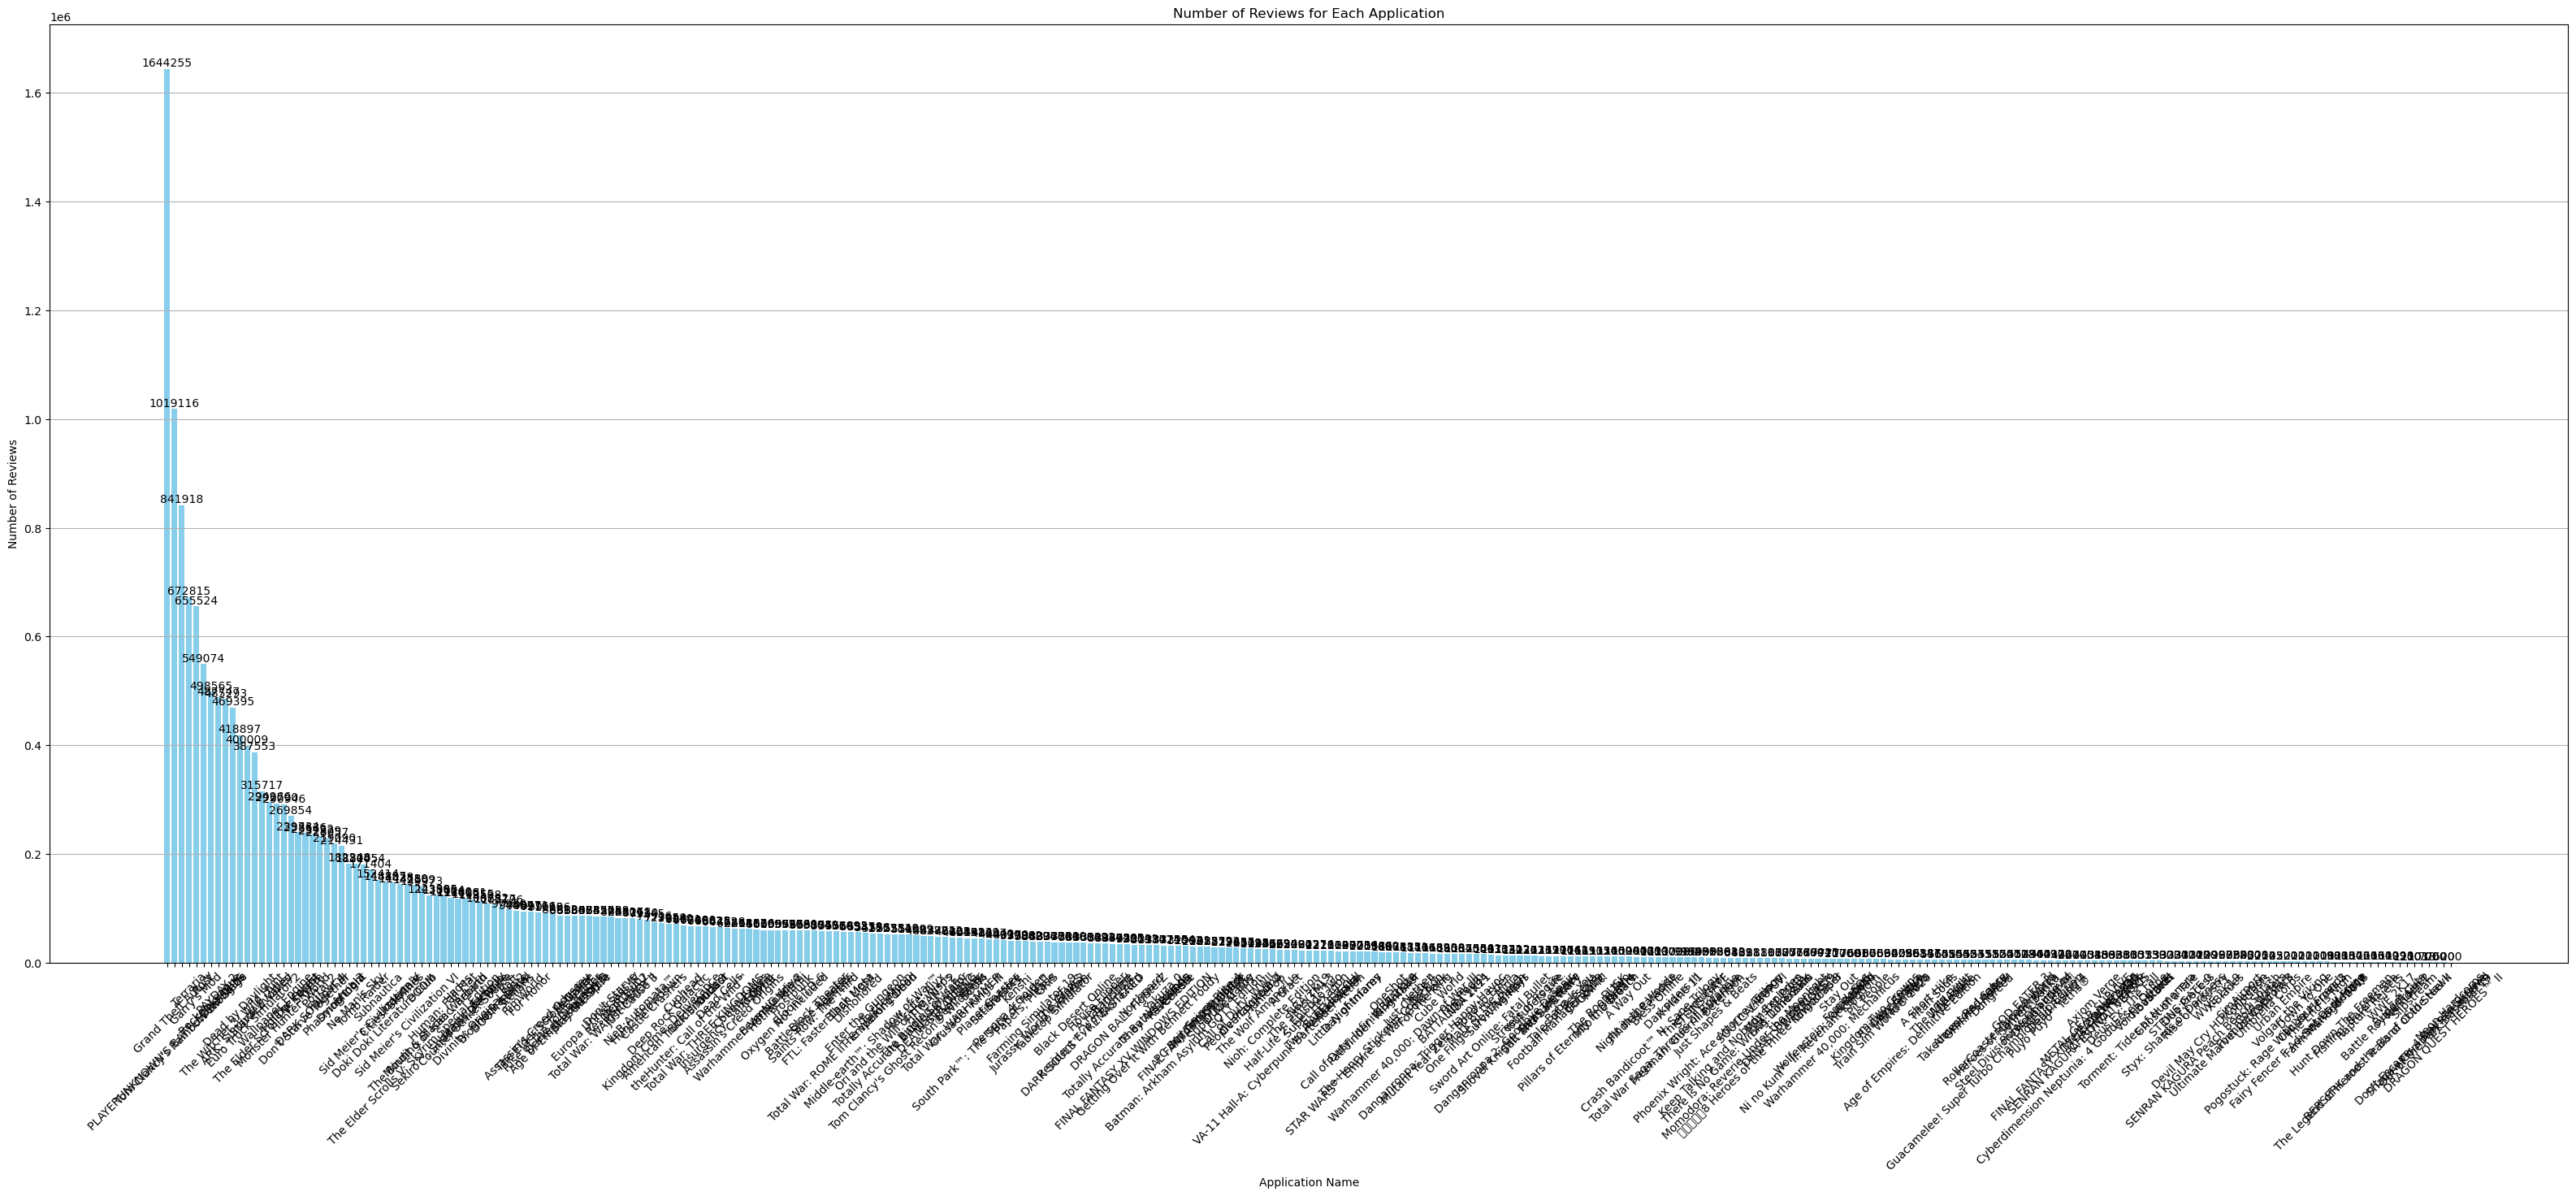

In [1025]:
plt.figure(figsize=(40,15))
bars = plt.bar(num_review_df['app_name'], num_review_df['num_review'], color='skyblue')
plt.xlabel('Application Name')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews for Each Application')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Adding data values on top of the bars
for bar in bars:
    yval = bar.get_height() 
    plt.text(bar.get_x() + bar.get_width()/2, yval, yval, ha='center', va='bottom')  # Add text

plt.show() 

From the plot, we observe that the leading games have a significantly larger number of reviews, indicating the popularity of these games.

- For the top 5 applications by number of reviews, how many reviews came from users who purchased the application versus those who received it for free? Provide a percentage breakdown and highlight any similarities.


In [1029]:
top_5_app_df = num_review_df.nlargest(5, 'num_review')
top_5_app_sum_df=top_5_app_df.sum()
display(top_5_app_sum_df)
top_5_app_df['num_purchased_ratio']=np.multiply(np.divide (top_5_app_df['num_purchased'],top_5_app_df['num_review']),100).apply(lambda x: "{:.2f}%".format(x))
top_5_app_df['num_received_free_ratio']=np.multiply(np.divide(top_5_app_df['num_received_free'],top_5_app_df['num_review']),100).apply(lambda x: "{:.2f}%".format(x))
display(top_5_app_df)

app_name             PLAYERUNKNOWN'S BATTLEGROUNDSGrand Theft Auto ...
num_review                                                     4833628
num_purchased                                                  4059526
num_received_free                                               181286
num_recommended                                                3751424
dtype: object

app_name  num_review  num_purchased  \
182   PLAYERUNKNOWN'S BATTLEGROUNDS     1644255        1372721   
118              Grand Theft Auto V     1019116         905288   
273  Tom Clancy's Rainbow Six Siege      841918         702505   
248                        Terraria      672815         527762   
114                     Garry's Mod      655524         551250   

     num_received_free  num_recommended num_purchased_ratio  \
182              61443           886417              83.49%   
118              38624           831311              88.83%   
273              36300           742397              83.44%   
248              20154           658741              78.44%   
114              24765           632558              84.09%   

    num_received_free_ratio  
182                   3.74%  
118                   3.79%  
273                   4.31%  
248                   3.00%  
114                   3.78%

From the analysis, we observe that 4059526 reviews came from users who purchased the application, while 181286 reviews were from users who received it for free. This represents approximately 80% of reviews from purchasing users and about 4% from free users. Additionally, all five applications exhibit a similar pattern, with a high percentage of reviews coming from users who purchased the application, indicating that purchased users are generally more likely to leave reviews.

- Which applications have the most and the least user recommendations? Summarize your findings.

In [1033]:
print(num_review_df.loc[num_review_df['num_recommended'].idxmax()])
print(num_review_df.loc[num_review_df['num_recommended'].idxmin()])

app_name             PLAYERUNKNOWN'S BATTLEGROUNDS
num_review                                 1644255
num_purchased                              1372721
num_received_free                            61443
num_recommended                             886417
Name: 182, dtype: object
app_name             Neon Hardcorps
num_review                      200
num_purchased                    29
num_received_free                27
num_recommended                  89
Name: 164, dtype: object


According to the previous analysis, apps <strong>PLAYERUNKNOWN'S BATTLEGROUNDS</strong> have the highest number of user recommendations, with <strong>886417</strong> recommendations. On the other hand, app <strong>Neon Hardcorps</strong> has the fewest recommendations, with only <strong>89</strong> recommendations.

- Is there a correlation between the number of recommendations and the applications' review scores? Use a statistical test to confirm the significance of the relationship.

Since the review score does not exist in the dataset, we considered it as the ratio between the number of recommendations and the number of reviews, represented on a scale from 0 to 10.

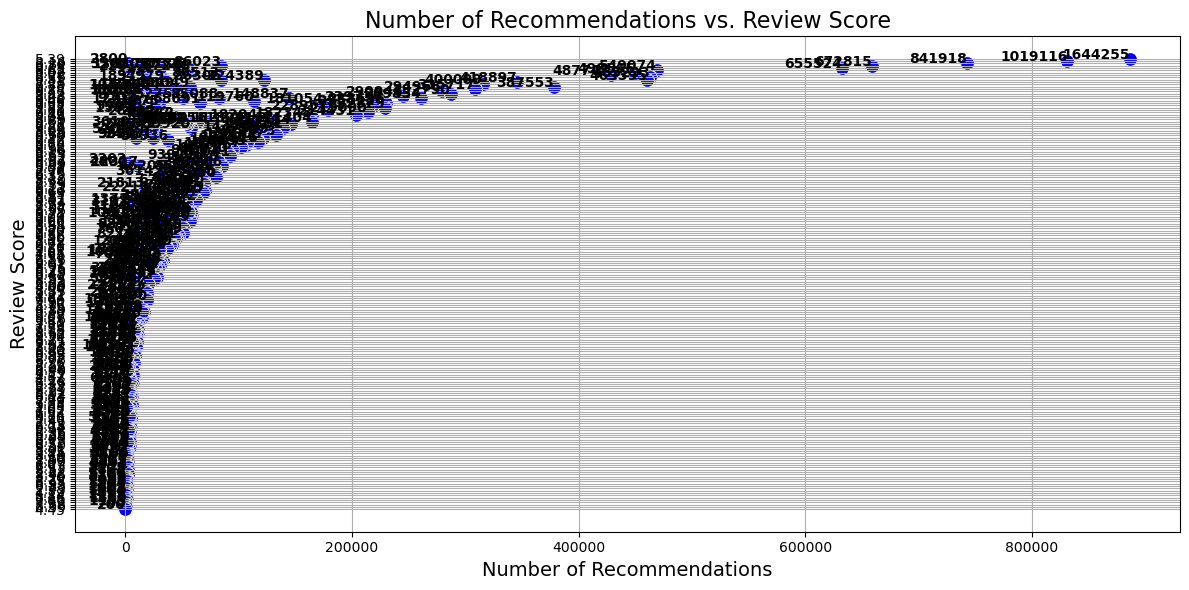

In [1038]:
num_review_df['review_score']=np.multiply(np.divide(num_review_df['num_recommended'],num_review_df['num_review']),10).apply(lambda x: "{:.2f}".format(x))

plt.figure(figsize=(12, 6))
sns.scatterplot(data=num_review_df, x='num_recommended', y='review_score', s=100, color='blue')
for i in range(num_review_df.shape[0]):
    plt.text(num_review_df['num_recommended'].iloc[i], 
             num_review_df['review_score'].iloc[i], 
             f"{num_review_df['num_review'].iloc[i]}",
             horizontalalignment='right', 
             size='medium', 
             color='black', 
             weight='semibold')


plt.title('Number of Recommendations vs. Review Score', fontsize=16)
plt.xlabel('Number of Recommendations', fontsize=14)
plt.ylabel('Review Score', fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.show()

Since the review score of an application is the ratio between the number of recommendations and the total number of reviews, a higher number of recommendations will imply a higher review score. However, there are cases of high review scores with a low number of reviews; in such cases, these scores are less significant due to the limited number of examples.

3. [**RQ3**] *Understanding when users are most active in submitting reviews can help identify peak engagement periods.*

 - Plot the number of reviews submitted each month and describe any trends.

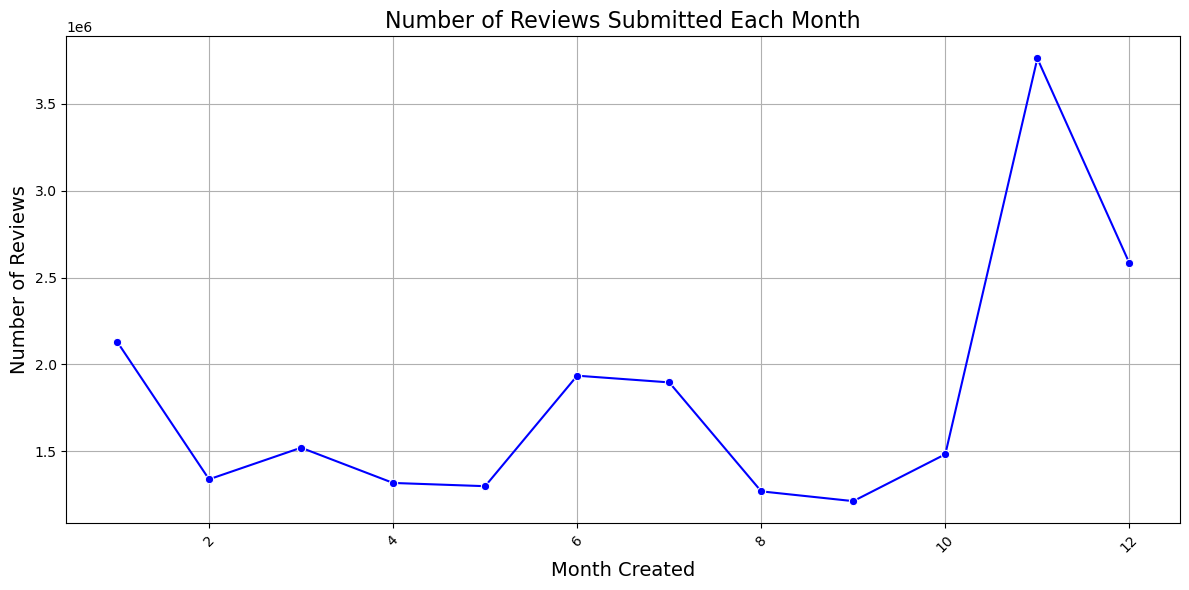

In [1043]:
monthly_num_review_df=monthly_num_review_df.groupby(['month_created']).agg(num_review=('num_review','sum')
                                                   ).reset_index().sort_values(by='num_review', ascending=False)
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_num_review_df, x='month_created', y='num_review', marker='o', color='blue')

# Set titles and labels
plt.title('Number of Reviews Submitted Each Month', fontsize=16)
plt.xlabel('Month Created', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

From the plot, we observe that the number of reviews is highest in November and December, while it dips in other months. This trend suggests that users are more active in leaving reviews during the winter months, possibly due to spending more time indoors or engaging more with apps during this period.

  - Identify any seasonal patterns or trends in review activity. Explain any seasonal impact you notice.

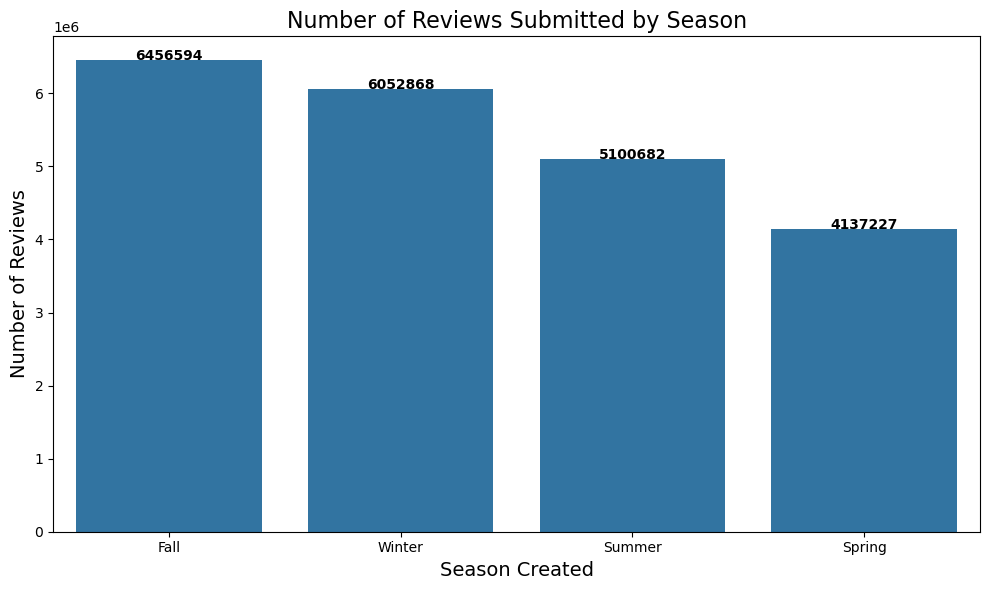

In [1047]:
seasonal_num_review_df=seasonal_num_review_df.groupby(['season_created']).agg(num_review=('num_review','sum')
                                                   ).reset_index().sort_values(by='num_review', ascending=False)
plt.figure(figsize=(10, 6))

sns.barplot(data=seasonal_num_review_df, x='season_created', y='num_review')

plt.title('Number of Reviews Submitted by Season', fontsize=16)
plt.xlabel('Season Created', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)

# Add data labels on top of each bar
for i in range(seasonal_num_review_df.shape[0]):
    plt.text(i, seasonal_num_review_df['num_review'].iloc[i], 
             f"{seasonal_num_review_df['num_review'].iloc[i]}",
             horizontalalignment='center', 
             size='medium', 
             color='black', 
             weight='semibold')

plt.tight_layout()
plt.show()

As shown in the previous chart, review activity tends to peak in the fall months while dropping off during the spring. This seasonal pattern suggests that users may be more likely to engage with apps and leave reviews during the colder months. In contrast, the lower review activity in the spring could indicate that users are spending less time on their devices, possibly due to outdoor activities.

- Determine if certain times of the year have higher engagement rates. Describe noticeable peaks in user activity.

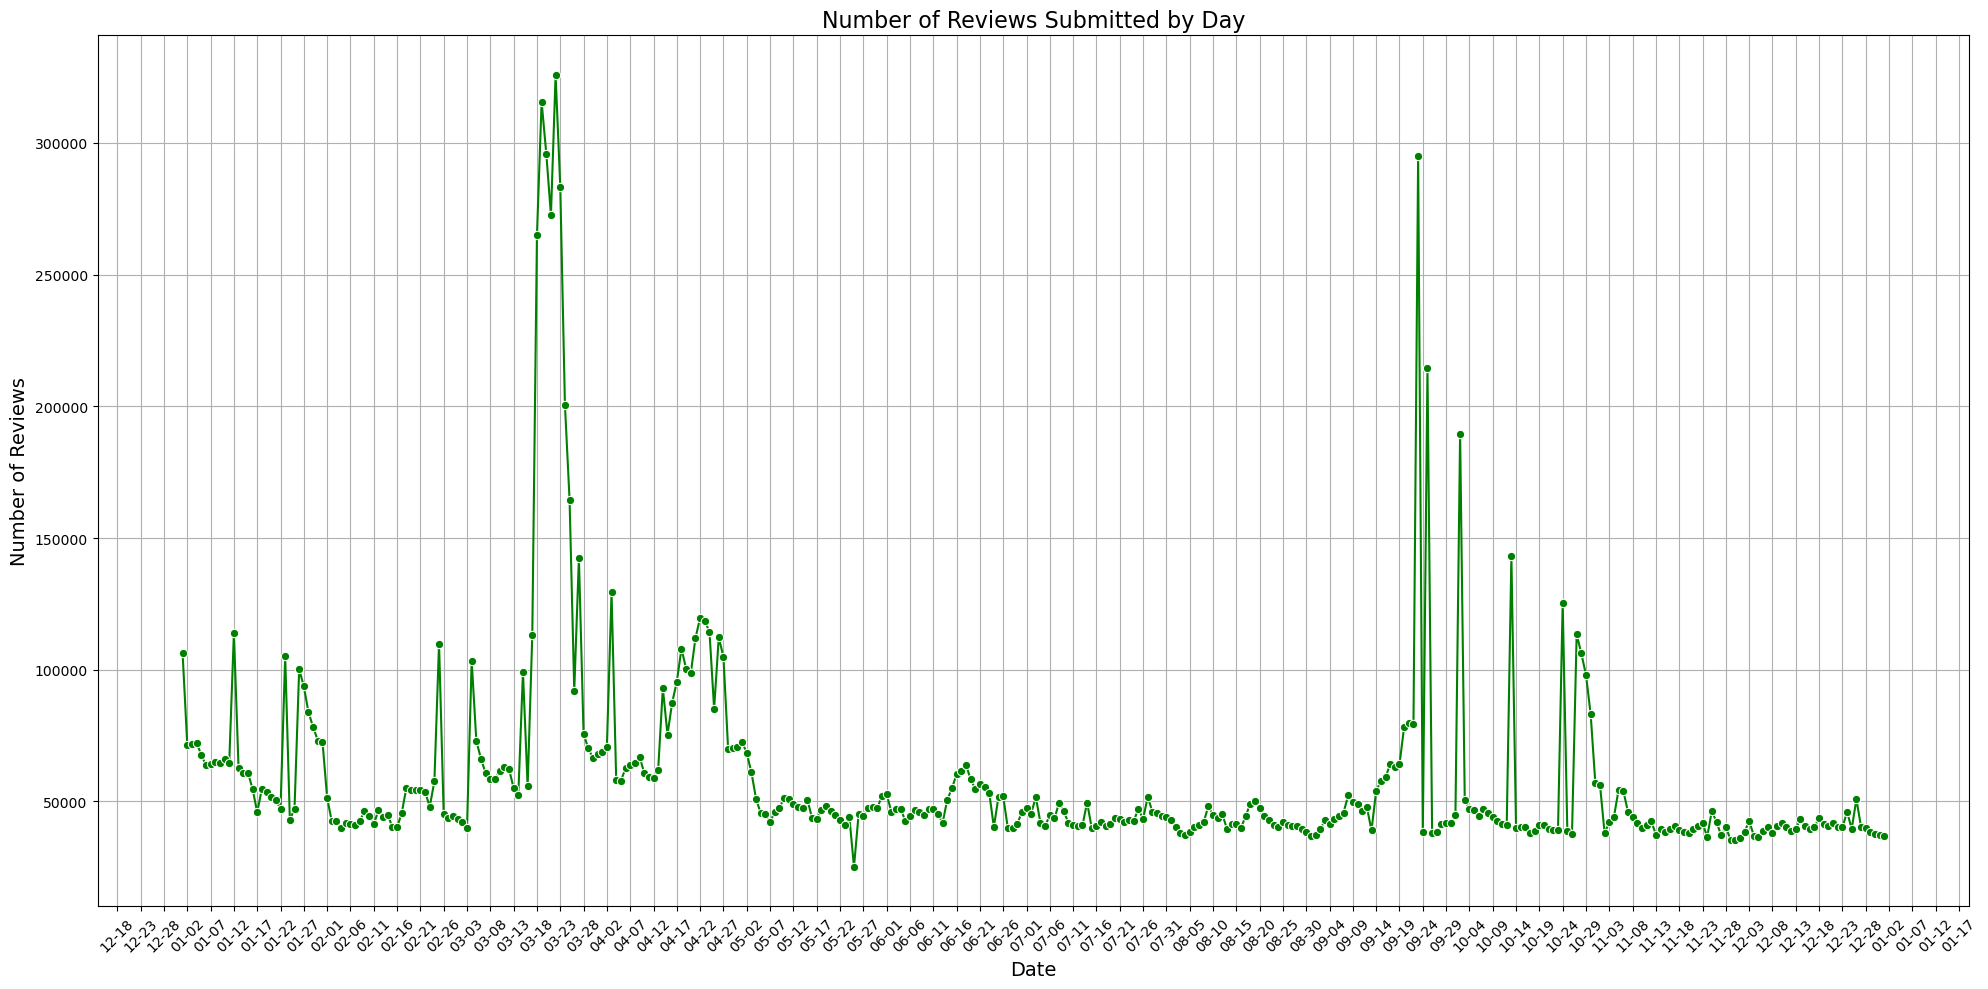

In [1051]:
month_day_num_review_df=month_day_num_review_df.groupby(['month_day_created']).agg(num_review=('num_review','sum')
                                        ).reset_index()
plt.figure(figsize=(20, 10))
sns.lineplot(data=month_day_num_review_df, x='month_day_created', y='num_review', marker='o', color='green')
plt.title('Number of Reviews Submitted by Day', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(rotation=45) 
# Reduce frequency of x-axis labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))  # Show every 5 days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.grid(True)
plt.tight_layout()
plt.show()

- What is the most common time of day users write reviews? For example, users might typically write reviews at 17:44. Explain how this time distribution could influence your analysis.


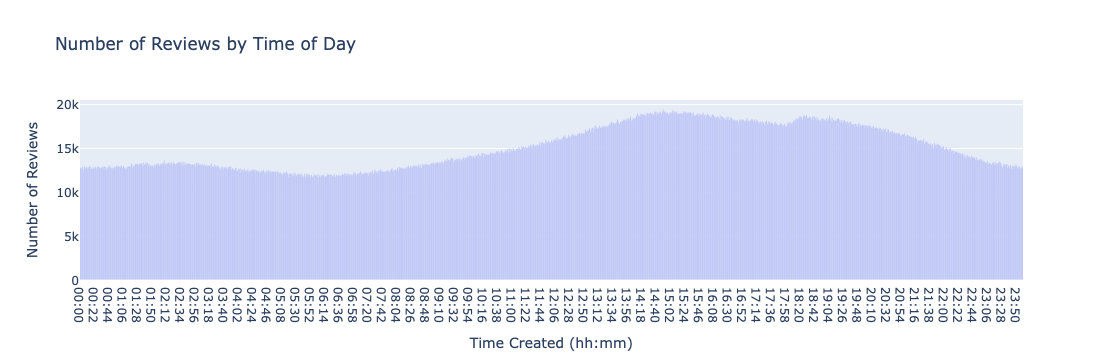

In [1054]:
time_num_review_df=time_num_review_df.groupby(['time_created']).agg(num_review=('num_review','sum')
                                               ).reset_index()

fig = px.bar(time_num_review_df, 
             x='time_created', 
             y='num_review', 
             labels={'time_created': 'Time Created (hh:mm)', 'num_review': 'Number of Reviews'},
             title='Number of Reviews by Time of Day',
             hover_data={'time_created': True, 'num_review': True})  # Enable tooltips

fig.show()

The analysis indicates that users most commonly write reviews between 14:00 and 21:00. This time distribution could suggest that users are more active in engaging with apps during the afternoon and evening, possibly due to increased leisure time after work or school.

- Create a function that accepts a list of time intervals and plots the number of reviews for each interval.

The function created is named <strong>plot_reviews_by_intervals</strong>. It accepts three parameters: df, time_column, and interval (list of tuples), which indicate the column on which the interval analysis is applied in the DataFrame.

In [1059]:
def plot_reviews_by_intervals(df, time_column, intervals):
    # Convert intervals to datetime.time objects for flexibility
    interval_ranges = {}
    for start_time_str, end_time_str in intervals:
        start_time = datetime.strptime(start_time_str, "%H:%M:%S").time()
        end_time = datetime.strptime(end_time_str, "%H:%M:%S").time()
        interval_label = f"{start_time_str} -{end_time_str}"
        interval_ranges[interval_label] = (start_time, end_time)

    # Create a dictionary to count reviews for each interval
    review_counts = {interval: 0 for interval in interval_ranges.keys()}

    # Categorize each review time
    for review_time in df[time_column]:
        
        review_time_only = review_time.time()  # Get time only
        for interval, (start, end) in interval_ranges.items():
            # Intervals that cross midnight
            if start <= end:
                if start <=review_time_only <= end:
                    review_counts[interval]+=1
                    break
            
            else:  # Interval crosses midnight (for instance 23:00 - 02:59)
                if review_time_only >= start or review_time_only <= end:
                    review_counts[interval]+=1
                    break

    # Plot the results
    plt.figure(figsize=(10, 6))
    bars = plt.bar(review_counts.keys(), review_counts.values(), color='skyblue')
    plt.xlabel('Time Interval')
    plt.ylabel('Number of Reviews')
    
    plt.title('Number of Reviews by Time Interval')
    plt.xticks(rotation=45)
    plt.tight_layout()
        # Add value labels
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

    plt.show()

- Use the function to plot the number of reviews for the following time intervals:

| Initial Time | Final Time |
|--------------|------------|
| 00:00:00     | 02:59:59   |
| 03:00:00     | 05:59:59   |
| 06:00:00     | 10:59:59   |
| 11:00:00     | 13:59:59   |
| 14:00:00     | 16:59:59   |
| 17:00:00     | 19:59:59   |
| 20:00:00     | 23:59:59   |

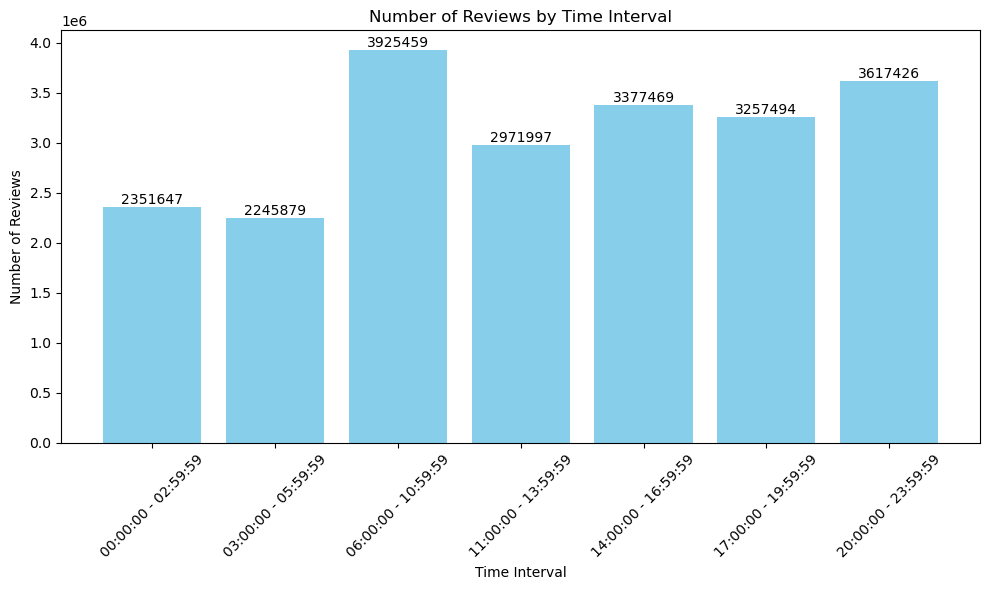

In [1064]:
# Define custom intervals
intervals = [
    ('00:00:00', '02:59:59'),
    ('03:00:00', '05:59:59'),
    ('06:00:00', '10:59:59'),
    ('11:00:00', '13:59:59'),
    ('14:00:00', '16:59:59'),
    ('17:00:00', '19:59:59'),
    ('20:00:00', '23:59:59')
]

plot_reviews_by_intervals(date_time_df, 'datetime_created', intervals)

   - Summarize your findings from the time interval analysis.

From the time interval analysis, we observe that the period between 06:00:00 and 10:59:59 has the highest number of reviews. Conversely, the interval between 00:00:00 and 05:59:00 shows the lowest number of reviews, which could be attributed to users sleeping during these hours.

4. [**RQ4**] *Investigating whether users who spend more time using an application give higher or lower ratings.*

   - Analyze the relationship between the amount of time a user has spent on an application and their review score.

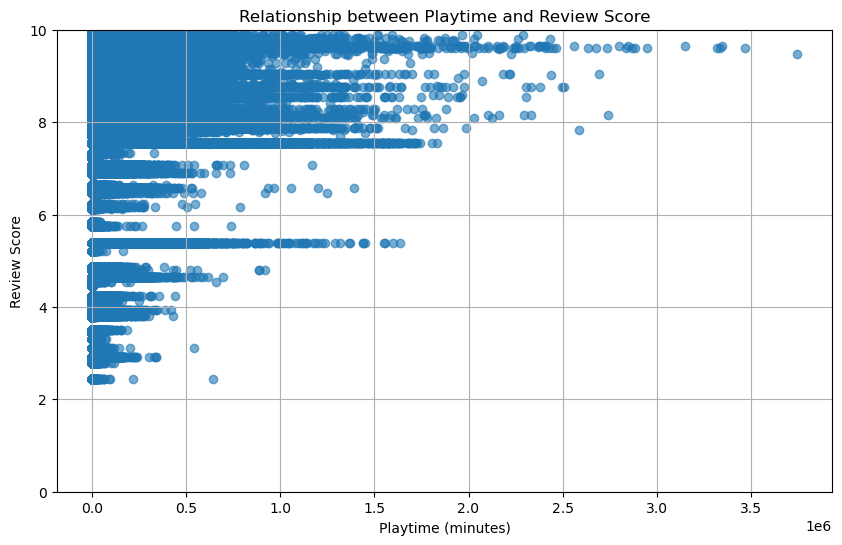

In [1074]:
player_game_playtime_df=player_game_playtime_df.groupby(['author.steamid','app_name']).agg(playtime=('playtime','max')
                                                   ).reset_index().sort_values(by='playtime', ascending=False)
appname_reviewscore_dict = num_review_df.set_index('app_name')['review_score'].to_dict()

player_game_playtime_df['review_score']=player_game_playtime_df['app_name'].map(appname_reviewscore_dict)
# Ensure that review_score is treated as a numeric type
player_game_playtime_df['review_score'] = pd.to_numeric(player_game_playtime_df['review_score'], errors='coerce')

plt.figure(figsize=(10, 6))
plt.scatter(player_game_playtime_df['playtime'], player_game_playtime_df['review_score'], alpha=0.6)
plt.title('Relationship between Playtime and Review Score')
plt.xlabel('Playtime (minutes)')
plt.ylabel('Review Score')
plt.grid(True)
plt.ylim(0, 10)  # Assuming the review score is on a scale from 0 to 10
plt.show()

The analysis shows that users who spend more time in an application are more likely to leave positive reviews and recommend the app. This trend suggests that extended engagement often correlates with user satisfaction, as those who enjoy the experience tend to spend more time and leave favorable feedback. Meanwhile, users with less playtime tend to leave more varied reviews, as first impressions of a game can differ from user to user.

 - Do more experienced users (who have used the application longer) tend to give higher or lower ratings? Comment on any trends you observe.

In [1088]:
good_review_by_experienced_player_df= player_preference_df.loc[player_preference_df['seniority'] == 'veteran user']
print("Printing the percentage of positive reviews (recommendations for the game) given by experienced users.")
good_review_by_experienced_player=good_review_by_experienced_player_df['recommended'].sum()/len(good_review_by_experienced_player_df)
print("percentage of positive reviews: ",f"{good_review_by_experienced_player* 100:.2f}%")

Printing the percentage of positive reviews (recommendations for the game) given by experienced users.
percentage of positive reviews:  81.83%


The analysis shows that users who spend more time in an application are more likely to leave positive reviews and recommend the app. This trend suggests that extended gameplay time often indicates user satisfaction, as those who enjoy the experience tend to spend more time and leave favorable feedback.

   - Plot the distribution of review scores based on different user experience levels (e.g., new users vs. veteran users). Is there a statistical difference in the score distributions? Use an appropriate statistical test to validate your hypothesis.


Since it is not possible to provide a specific numerical review score on steam, this metric is calculated as the ratio of recommendations to the total number of reviews. Accordingly, we will analyze how users with different experience levels recommend the game.

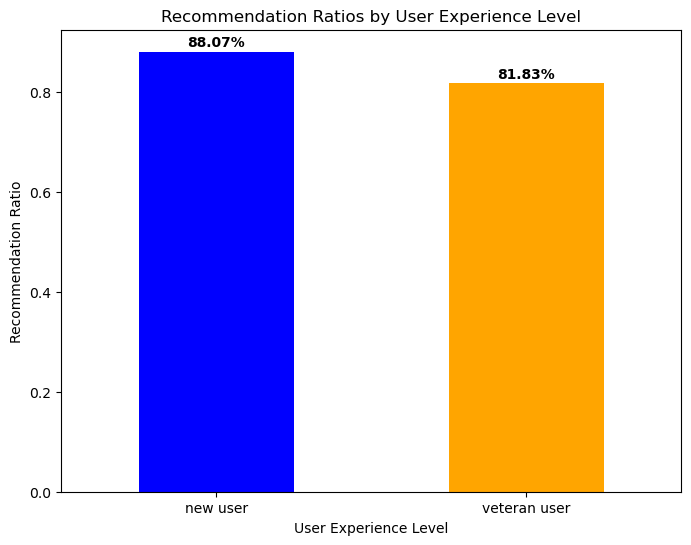

Performing statistical test
p-value equals to: 0.834888029637264
No significant difference in recommendation rates between new and veteran users (p >= 0.05)


In [1084]:
recommendation_count_df = player_preference_df[player_preference_df['recommended'] == True].groupby('seniority').size()
# Calculate total preference counts for each user group
total_preference_count_df = player_preference_df.groupby('seniority').size()
# Calculate recommendation ratios
recommendation_ratio_df = recommendation_count_df / total_preference_count_df
# Plot recommendation ratios for new vs veteran users
ax = recommendation_ratio_df.plot(kind='bar', color=['blue', 'orange'], figsize=(8, 6))
plt.title('Recommendation Ratios by User Experience Level')
plt.xlabel('User Experience Level')
plt.ylabel('Recommendation Ratio')
plt.xticks(rotation=0)

# Adding value labels on top of bars
for i, v in enumerate(recommendation_ratio_df):
    ax.text(i, v + 0.01, f"{v*100:.2f}%", ha='center', fontweight='bold')

plt.show()
print("Performing statistical test")
# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
print("p-value equals to:",p_value)
# Verify the results
alpha = 0.05
if p_value < alpha:
    print("Significant difference in recommendation rates between new and veteran users (p < 0.05)")
else:
    print("No significant difference in recommendation rates between new and veteran users (p >= 0.05)")

As shown in the previous analysis, there is no statistically significant difference between user experience levels, as confirmed by the calculated p-value, given a significance threshold of 0.05.

   - Ask an LLM tool (ChatGPT, Claude AI, etc.) to interpret the statistical results of the analysis and provide potential explanations for the trends. Does the LLM suggest additional factors that could explain why users who spend more time on the app give higher or lower ratings? How can you validate the interpretations provided by the LLM?


We asked ChatGPT to interpret the statistical results of the analysis and provide explanations for the trends. It confirmed that there is no significant difference in the recommendation ratios between new and veteran users. This suggests that the majority of users who left a review also recommended the game, regardless of their "seniority". ChatGPT then suggested several potential explanations for the observed similarity, including:

- Similar User Experience
- Effective Recommendation System
- Sample Size
- User Engagement
- External Factors
- Variability in User Preferences
<br>

Since the initial analysis did not reveal a significant difference between the two user categories, the suggestions focus on explaining the reasons for the similarity in this distribution rather than differences. These hypotheses can be tested with further analysis using data from the dataset. For example, as suggested, we can assess the sample size to ensure that the dataset is robust enough to provide meaningful insights. 

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/steam-reviews-2021/steam_reviews.csv


In [5]:
file_path = '/kaggle/input/steam-reviews-2021/steam_reviews.csv'

While looking at latest Kaggle competition I found this one that was really interesting and could solve our problem on [how to deal with large dataset](https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use ): 

It is sponsored by Dell and Nvidia that suggest the use of their new technology to deal with pandas dataframe with the use of GPU.

More info about the project can be found in their [official page](https://developer.nvidia.com/rapids)

While more info regarding the library we are gonna use can be found on their [github repository](https://github.com/rapidsai/cudf)

In [5]:
import cudf
import rmm

print("RAPIDS cuDF is using GPU memory:", rmm.is_initialized())

RAPIDS cuDF is using GPU memory: True


# [RQ5] It is interesting to explore the top reviewers to gain insight into their demographic location, the quality of their reviews, and the applications they tend to review most frequently.



In [ ]:
df_rq5 = cudf.read_csv(file_path, usecols=['author.steamid', 'review_id','language','votes_helpful','app_name'])

### Determine the ten reviewers with the highest number of reviews in the dataset.


In [20]:
df_rq5 = cudf.read_csv(file_path, usecols=['author.steamid', 'review_id','language','votes_helpful','app_name'])
reviewer_counts = df_rq5.groupby('author.steamid').size().reset_index(name='review_count')
top_reviewers = reviewer_counts.sort_values(by='review_count', ascending=False).head(10)

print(top_reviewers)


             author.steamid  review_count
2102182   76561198062813911           149
10063909  76561198315585536           132
7971611   76561198192166873           107
3192200   76561198239163744           106
1250658   76561198045381877           103
3705816   76561198064946151           100
2443283   76561198013146396            99
5238613   76561198027973295            96
2964203   76561197969749884            88
11118453  76561197989746995            86


### What is the percentage of each language used by these top 10 reviewers when submitting a review?


In [13]:
top_reviewer_ids = top_reviewers['author.steamid'].to_arrow().to_pylist()
top_reviews = df_rq5[df_rq5['author.steamid'].isin(top_reviewer_ids)]
language_counts = top_reviews.groupby('language').size().reset_index(name='count')
total_reviews = language_counts['count'].sum()
language_counts['percentage'] = (language_counts['count'] / total_reviews) * 100

print(language_counts)


   language  count  percentage
0  schinese    191   17.917448
1   russian    300   28.142589
2   english    575   53.939962


### Let's examine whether other users found the reviews from these top 10 reviewers helpful or if they were simply spamming. Calculate the average number of valuable votes these reviewers received for their submitted reviews. Elaborate on the results you see.


In [15]:
top_reviews = df_rq5[df_rq5['author.steamid'].isin(top_reviewer_ids)][['author.steamid', 'votes_helpful']]
helpful_votes_avg = top_reviews.groupby('author.steamid')['votes_helpful'].mean().reset_index(name='average_helpful_votes')

print(helpful_votes_avg)


      author.steamid  average_helpful_votes
0  76561198062813911               0.885906
1  76561198045381877               2.252427
2  76561198239163744               7.641509
3  76561197989746995              21.058140
4  76561198027973295              11.802083
5  76561198064946151               3.990000
6  76561198192166873              38.897196
7  76561197969749884              26.238636
8  76561198013146396               0.969697
9  76561198315585536              49.712121


### Create a plot showing the distribution of the number of reviews each application received from the top 10 reviewers, arranged in descending order.


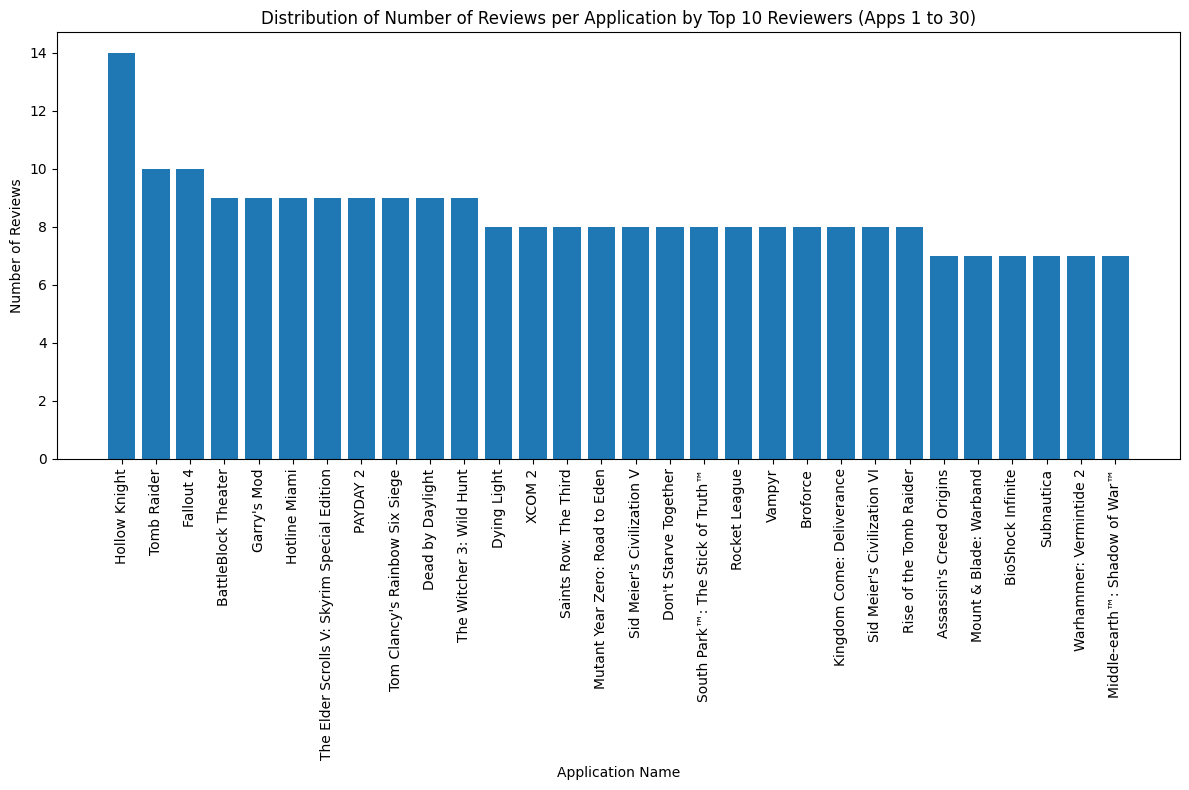

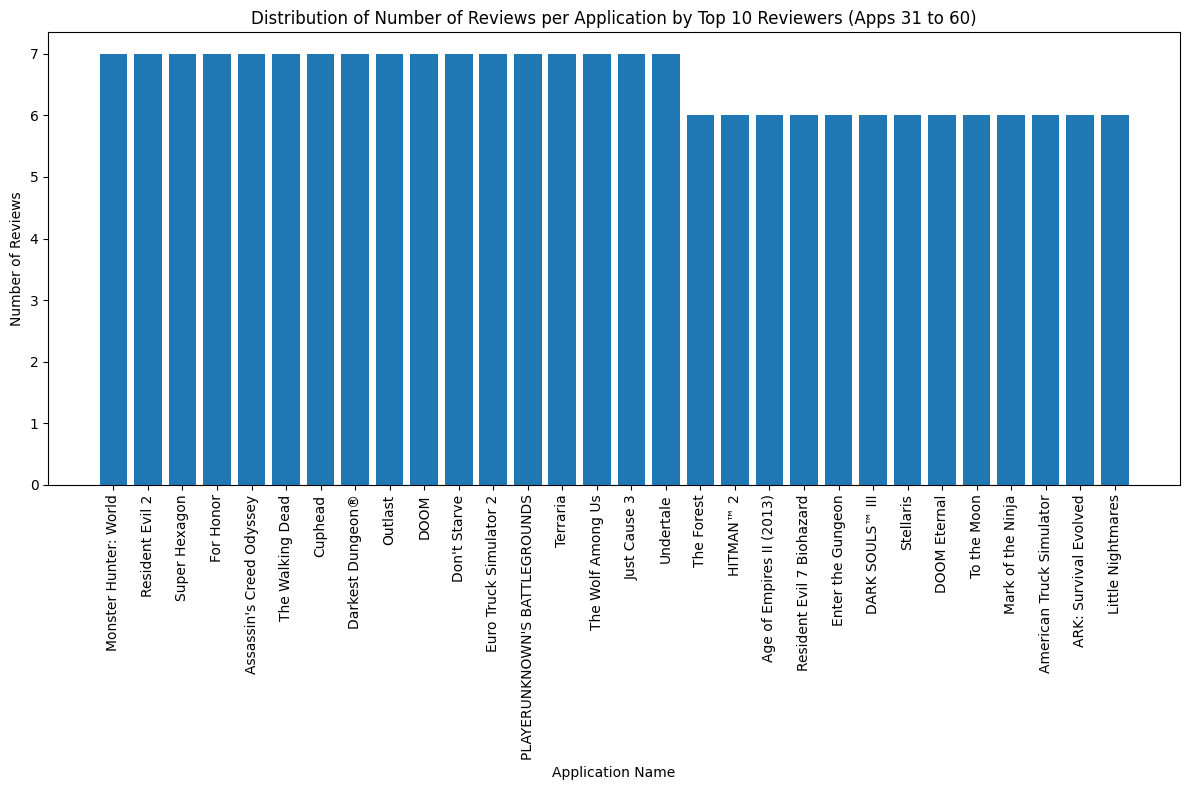

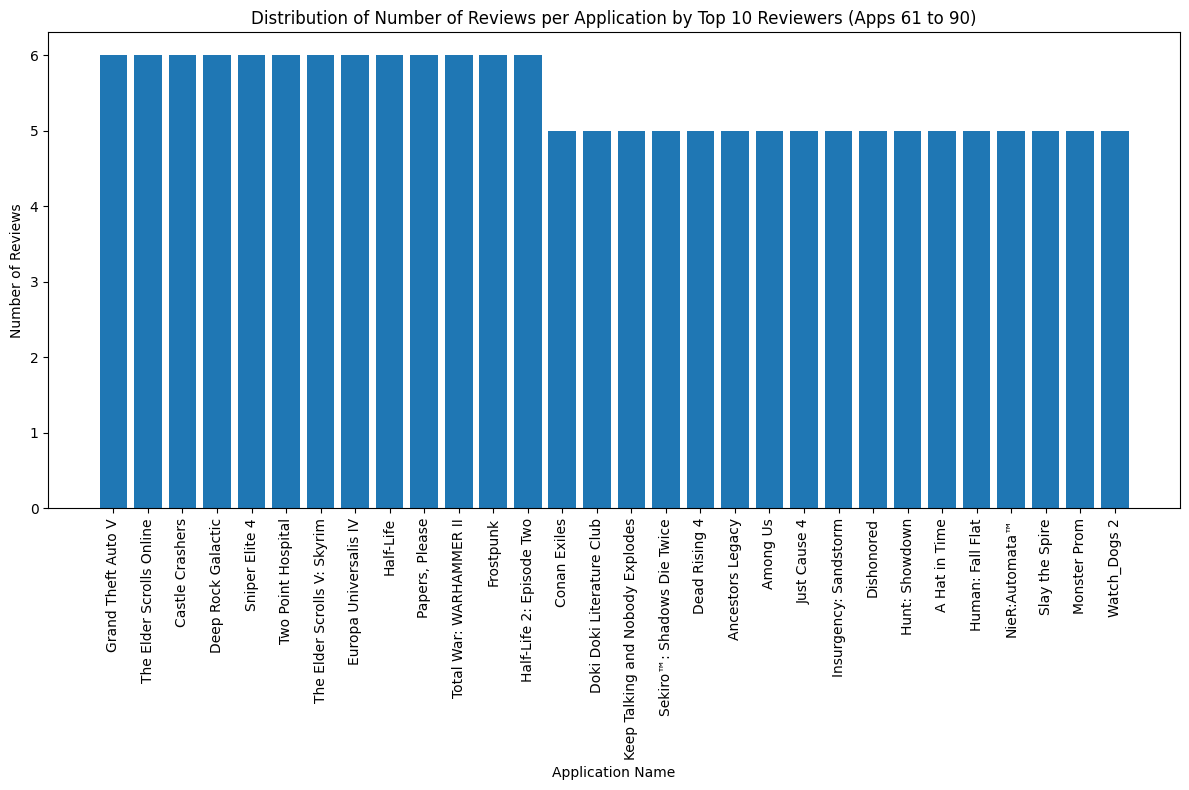

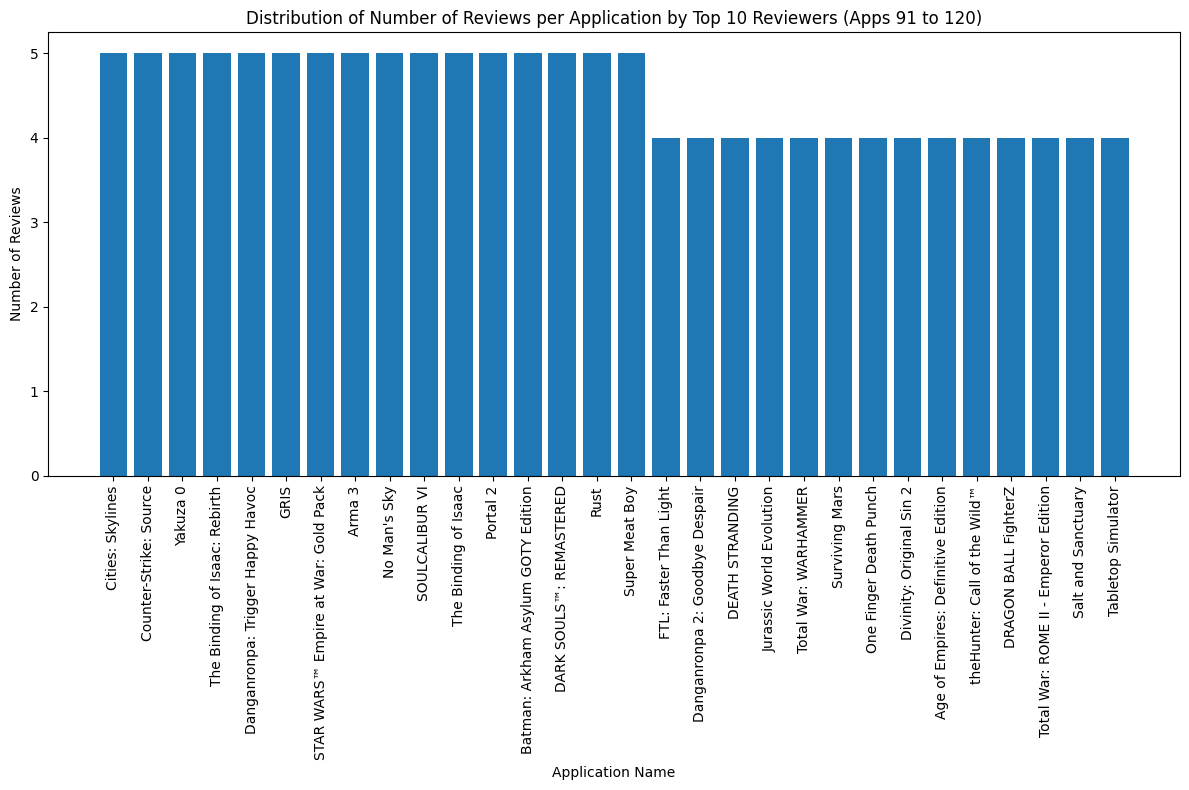

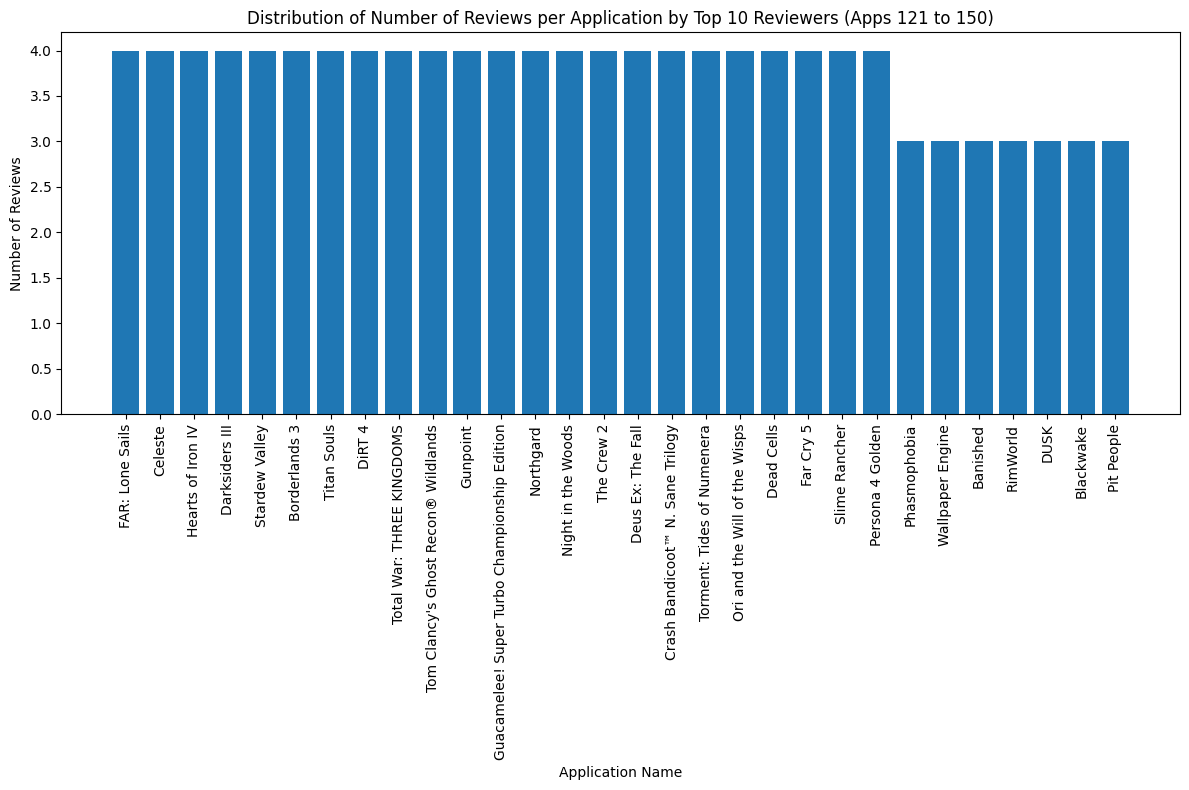

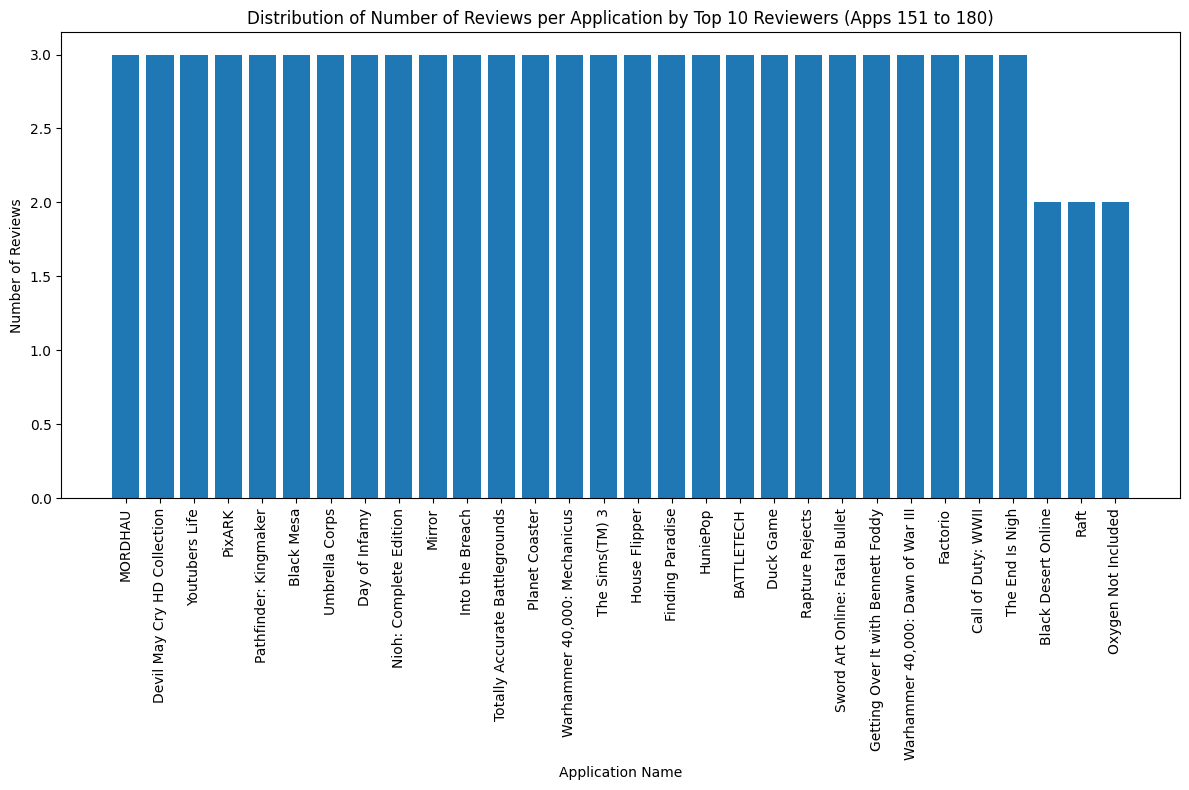

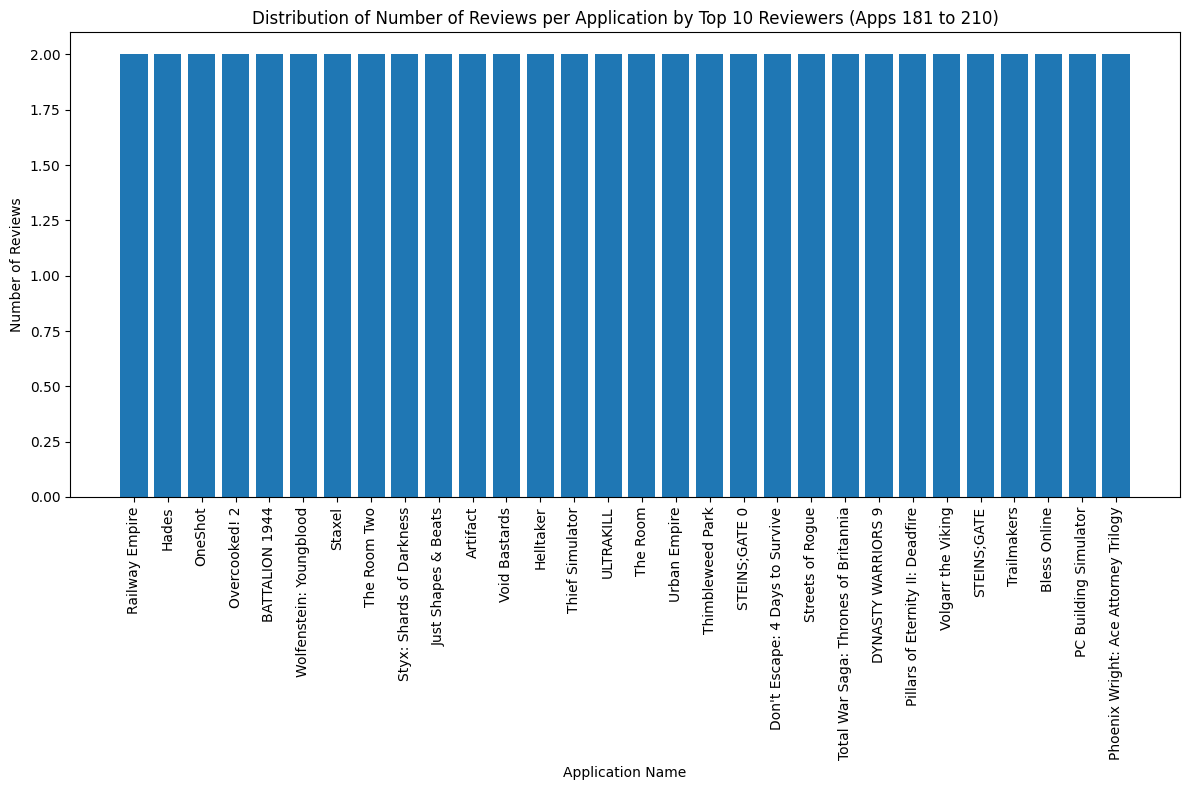

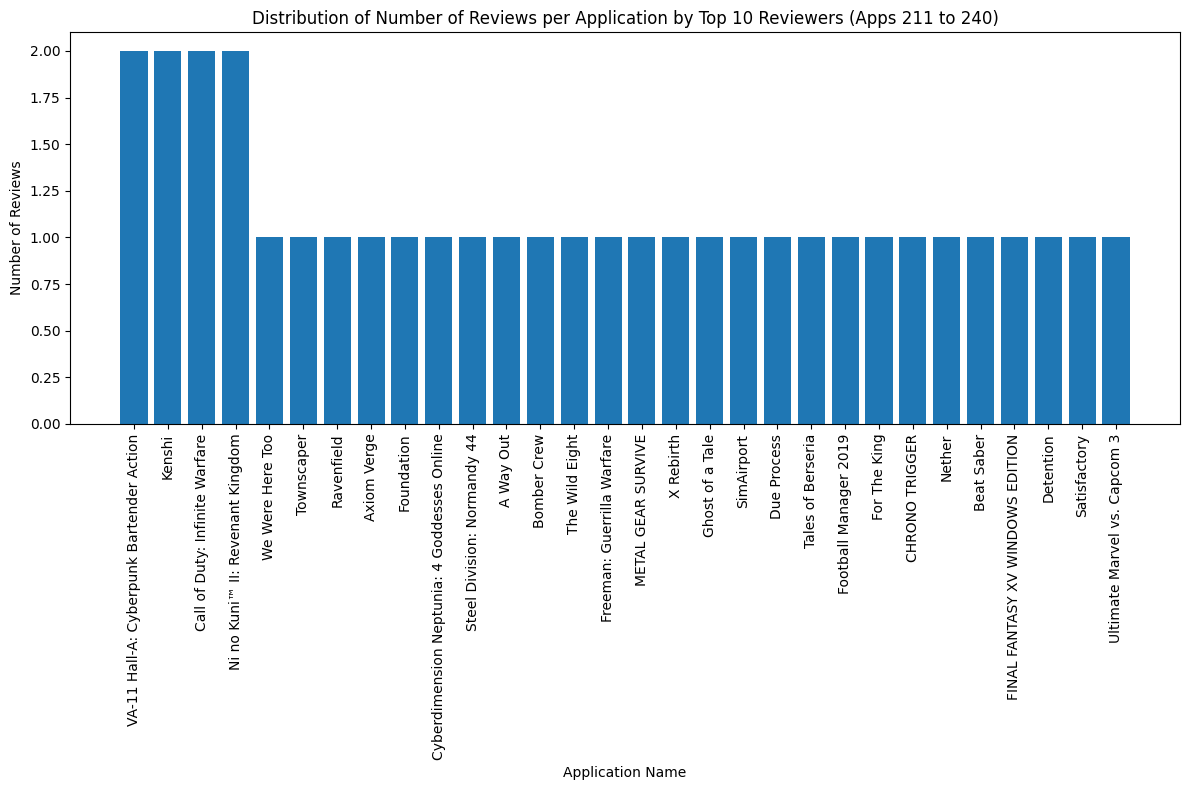

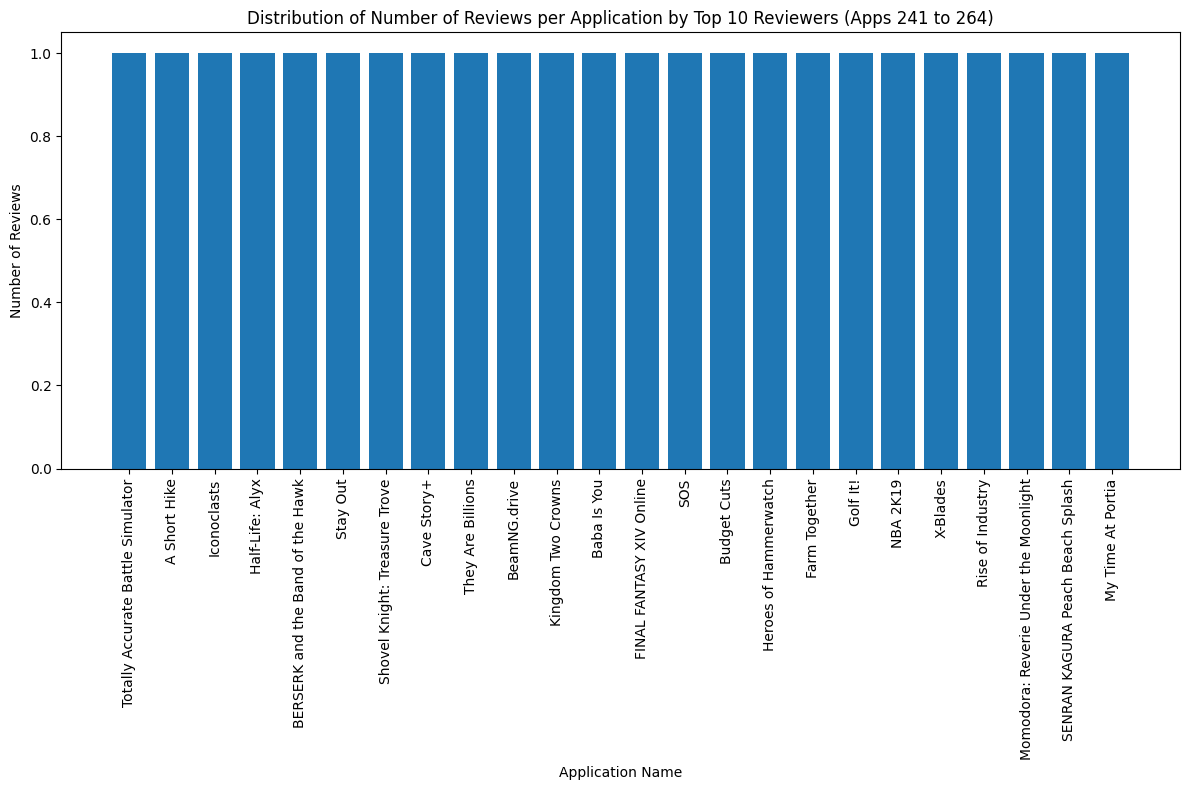

In [27]:
import matplotlib.pyplot as plt
import numpy as np

#we have 315 games, so we have to make more plots to make it readable
apps_per_plot = 30  
num_plots = int(np.ceil(len(app_review_counts) / apps_per_plot))

for i in range(num_plots):
    #range
    start_idx = i * apps_per_plot 
    end_idx = min((i + 1) * apps_per_plot, len(app_review_counts))
    
    # Subset of applications for the current plot
    subset_app_ids = app_review_counts['app_name'].iloc[start_idx:end_idx].to_numpy()
    subset_review_counts = app_review_counts['review_count'].iloc[start_idx:end_idx].to_numpy()
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.bar(subset_app_ids, subset_review_counts)
    plt.xlabel("Application Name")
    plt.ylabel("Number of Reviews")
    plt.title(f"Distribution of Number of Reviews per Application by Top 10 Reviewers (Apps {start_idx+1} to {end_idx})")
    plt.xticks(rotation=90)  
    plt.tight_layout() 
    plt.show()


# [RQ6] Let's investigate the behavior of specific groups, specifically focusing on English and Spanish reviewers


In [29]:
df_rq6 = cudf.read_csv(file_path, usecols=['language', 'timestamp_created', 'timestamp_updated', 'author.num_games_owned', 'author.num_reviews'])

### Which group is more likely to edit or update their review after submitting it? “English or Spanish!”?


In [30]:
english_reviews = df_rq6[df_rq6['language'] == 'english']
spanish_reviews = df_rq6[df_rq6['language'] == 'spanish']
#total rev
total_english_reviews = english_reviews.shape[0]
total_spanish_reviews = spanish_reviews.shape[0]

# updated rev 
english_updated = english_reviews[english_reviews['timestamp_updated'] != english_reviews['timestamp_created']].shape[0]
spanish_updated = spanish_reviews[spanish_reviews['timestamp_updated'] != spanish_reviews['timestamp_created']].shape[0]

# Proportion
english_update_proportion = english_updated / total_english_reviews if total_english_reviews > 0 else 0
spanish_update_proportion = spanish_updated / total_spanish_reviews if total_spanish_reviews > 0 else 0

print("Proportion of updated reviews:")
print(f"English: {english_update_proportion:.2%}")
print(f"Spanish: {spanish_update_proportion:.2%}")

Proportion of updated reviews:
English: 11.89%
Spanish: 9.94%
English reviewers are more likely to update their reviews.


English reviewers are more likely to update their reviews

### Provide the average number of games that reviewers from each group have on their Steam accounts and the average number of games for which they write reviews. What can you say about the number you just calculated?


In [31]:
# game owned
english_avg_games_owned = english_reviews['author.num_games_owned'].mean()
spanish_avg_games_owned = spanish_reviews['author.num_games_owned'].mean()

print("Average number of games owned by reviewers:")
print(f"English: {english_avg_games_owned:.2f}")
print(f"Spanish: {spanish_avg_games_owned:.2f}")

# game reviewed
english_avg_reviews_written = english_reviews['author.num_reviews'].mean()
spanish_avg_reviews_written = spanish_reviews['author.num_reviews'].mean()

print("\nAverage number of games for which they write reviews:")
print(f"English: {english_avg_reviews_written:.2f}")
print(f"Spanish: {spanish_avg_reviews_written:.2f}")

Average number of games owned by reviewers:
English: 1369501.6635062841
Spanish: 121.91626051246742

Average number of games for which they write reviews:
English: 456456.8744984789
Spanish: 9.387421924949589

Interpretation of the number of games owned and reviewed:
English reviewers tend to own more games on average than Spanish reviewers.
English reviewers also tend to review more games on average than Spanish reviewers.


English reviewers tend to own more games on average than Spanish reviewers.

English reviewers also tend to review more games on average than Spanish reviewers.


# [RQ7] Certainly, calculating probabilities and conducting statistical tests are essential skills for any data scientist. Let's calculate some intriguing figures.



In [32]:
df_rq7 = cudf.read_csv(file_path, usecols=['votes_helpful', 'recommended', 'author.num_reviews', 'author.num_games_owned'])

### What is the probability of submitting a review and receiving at least one helpful vote from other users?


In [33]:
total_reviews = df_rq7.shape[0]
reviews_with_helpful_votes = df_rq7[df_rq7['votes_helpful'] > 0].shape[0]
prob_helpful_vote = reviews_with_helpful_votes / total_reviews if total_reviews > 0 else 0

print(f"Probability of receiving at least one helpful vote: {prob_helpful_vote:.2%}")


Probability of receiving at least one helpful vote: 28.07%


### What is the probability of submitting a review and receiving at least one helpful vote from other users, given that you don’t recommend the app?


In [34]:
non_recommended_reviews = df_rq7[df_rq7['recommended'] == False]
total_non_recommended = non_recommended_reviews.shape[0]
non_recommended_helpful_votes = non_recommended_reviews[non_recommended_reviews['votes_helpful'] > 0].shape[0]

# Conditional Probability
prob_helpful_given_non_recommend = non_recommended_helpful_votes / total_non_recommended if total_non_recommended > 0 else 0
print(f"Probability of receiving at least one helpful vote given a non-recommendation: {prob_helpful_given_non_recommend:.2%}")

Probability of receiving at least one helpful vote given a non-recommendation: 48.46%


### Is the probability of “a review receiving at least one helpful vote” independent of the probability that “the reviewer has submitted at least five reviews before the current review”? Elaborate on it.


In [36]:
# Probability of receiving at least one helpful vote
P_A = prob_helpful_vote #RQ7.1

# Probability that the reviewer has submitted at least 5 reviews
total_five_reviews = df_rq7[df_rq7['author.num_reviews'] >= 5].shape[0]
P_B = total_five_reviews / total_reviews if total_reviews > 0 else 0

# Probability of both events occurring
reviews_with_helpful_and_five = df_rq7[(df_rq7['votes_helpful'] > 0) & (df_rq7['author.num_reviews'] >= 5)].shape[0]
P_A_and_B = reviews_with_helpful_and_five / total_reviews if total_reviews > 0 else 0

# Independence
independent = P_A_and_B == (P_A * P_B)
print(f"P(A): {P_A:.4f}")
print(f"P(B): {P_B:.4f}")
print(f"P(A ∩ B): {P_A_and_B:.4f}")
print(f"Are 'receiving at least one helpful vote' and 'reviewer has submitted at least 5 reviews' independent? {'Yes' if independent else 'No'}")


P(A): 0.2807
P(B): 0.4555
P(A ∩ B): 0.1564
Are 'receiving at least one helpful vote' and 'having submitted at least five reviews' independent? No


### We hypothesize that “reviewers who own a larger number of games are likely to leave fewer reviews on the platform.” Please validate or refute this statement through statistical analysis.


In [6]:
import cudf
df_rq7_4_cudf = cudf.read_csv(file_path, usecols=['author.num_games_owned', 'author.num_reviews'])
df_rq7_4 = df_rq7_4_cudf.to_pandas()


##### Pearson's correlation


In [7]:
from scipy.stats import pearsonr

pearson_corr, pearson_p_value = pearsonr(df_rq7_4['author.num_games_owned'], df_rq7_4['author.num_reviews'])

# Display results for Pearson's correlation
print(f"Pearson's correlation coefficient: {pearson_corr:.2f}")
print(f"P-value for Pearson's correlation: {pearson_p_value:.2e}")

Pearson's correlation coefficient: -0.00
P-value for Pearson's correlation: 9.99e-01


no linear relationship

##### Spearman's rank correlation


In [8]:
from scipy.stats import spearmanr

spearman_corr, spearman_p_value = spearmanr(df_rq7_4['author.num_games_owned'], df_rq7_4['author.num_reviews'])

print(f"Spearman's correlation coefficient: {spearman_corr:.2f}")
print(f"P-value for Spearman's correlation: {spearman_p_value:.2e}")


Spearman's correlation coefficient: 0.60
P-value for Spearman's correlation: 0.00e+00


As the number of games owned increases, the tendency to submit reviews also increases, contradicting the hypothesis. This result shows that there’s a non-linear relationship, which Pearson’s test couldn’t capture

In [14]:
from scipy.stats import skew, kurtosis

skew_games = skew(df_rq7_4['author.num_games_owned'])
kurt_games = kurtosis(df_rq7_4['author.num_games_owned'])
print(f"skewness 'author.num_games_owned': {skew_games:.2f}")
print(f"kurtosis 'author.num_games_owned': {kurt_games:.2f}")

skew_reviews = skew(df_rq7_4['author.num_reviews'])
kurt_reviews = kurtosis(df_rq7_4['author.num_reviews'])
print(f"skewness 'author.num_reviews': {skew_reviews:.2f}")
print(f"kurtosis 'author.num_reviews': {kurt_reviews:.2f}")


skewness 'author.num_games_owned': 2085.54
kurtosis 'author.num_games_owned': 4349469.20
skewness 'author.num_reviews': 3297.53
kurtosis 'author.num_reviews': 10873680.50


Both distributions are highly skewed.

The high value of kurtosis suggests a leptokurtic distribution (extreme peaks and very long tails)
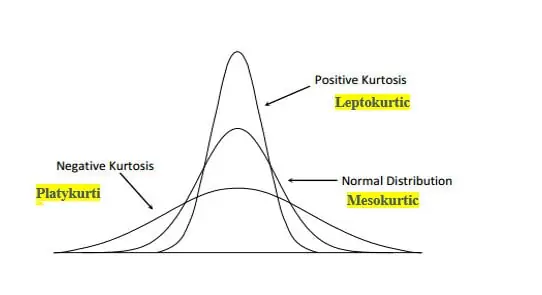

These values ​​indicate a distribution very far from normal, probably with a large number of data concentrated in the vicinity of a few values, with the presence of extreme values ​​or outliers.


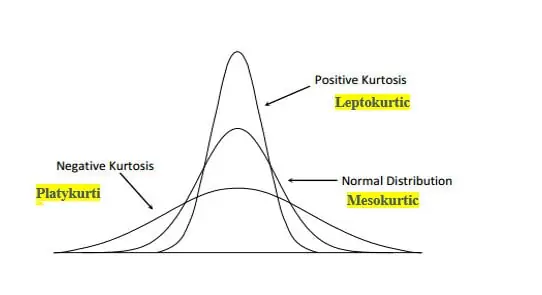
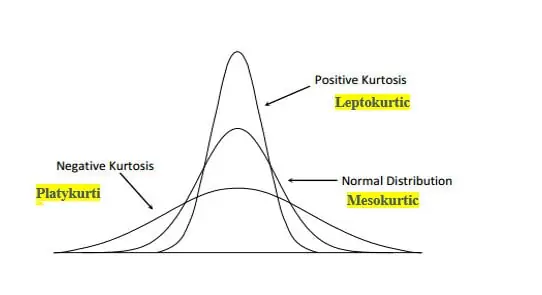
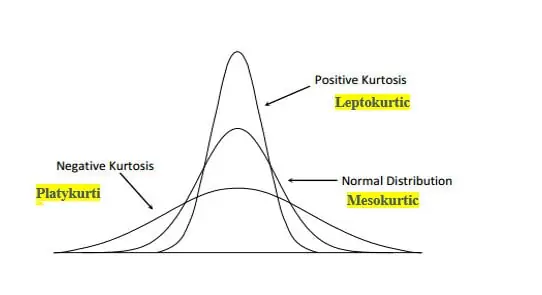

Before going forward, let's just see how the scatterplot of our data points looks like

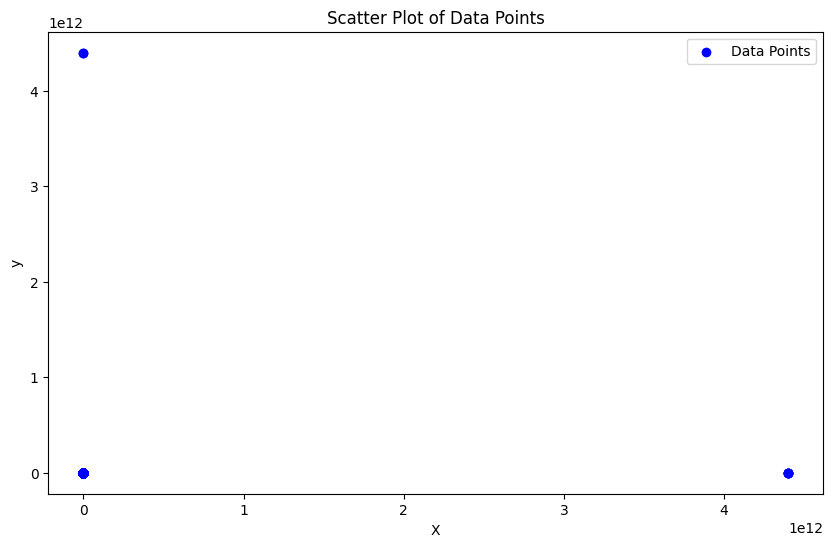

In [30]:
X = df_rq7_4['author.num_games_owned'].values.reshape(-1, 1)
y = df_rq7_4['author.num_reviews'].values

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Data Points')
plt.xlabel("X")
plt.ylabel("y")
plt.title("Scatter Plot of Data Points")
plt.legend()
plt.show()

there is a clear presence of outlier, let's dive deeper: 

In [22]:
print("\nTop 10 'author.num_games_owned':")
print(df_rq7_4['author.num_games_owned'].nlargest(10))

print("\nTop 10 'author.num_reviews':")
print(df_rq7_4['author.num_reviews'].nlargest(10))


Top 10 'author.num_games_owned':
5502449     4398046511619
21079021    4398046511316
3507697     4398046511179
8680945     4398046511170
6913009     4398046511151
5790335             24258
5242234             24184
4418318             24172
17742447            22024
20632981            22023
Name: author.num_games_owned, dtype: int64

Top 10 'author.num_reviews':
13093694    4398046511108
5663041     4398046511105
504382               5236
575674               5236
656318               5236
1258197              5236
3249032              5236
3274520              5236
3294251              5236
7839830              5236
Name: author.num_reviews, dtype: int64


those values are complitely out of bound

In [26]:
df_filtered = df_rq7_4[(df_rq7_4['author.num_games_owned'] <= 100000) & (df_rq7_4['author.num_reviews'] <= 100000)]
df_filtered['games_owned_decile'] = pd.qcut(df_filtered['author.num_games_owned'], 10)

/tmp/ipykernel_30/3886059253.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['games_owned_decile'] = pd.qcut(df_filtered['author.num_games_owned'], 10)


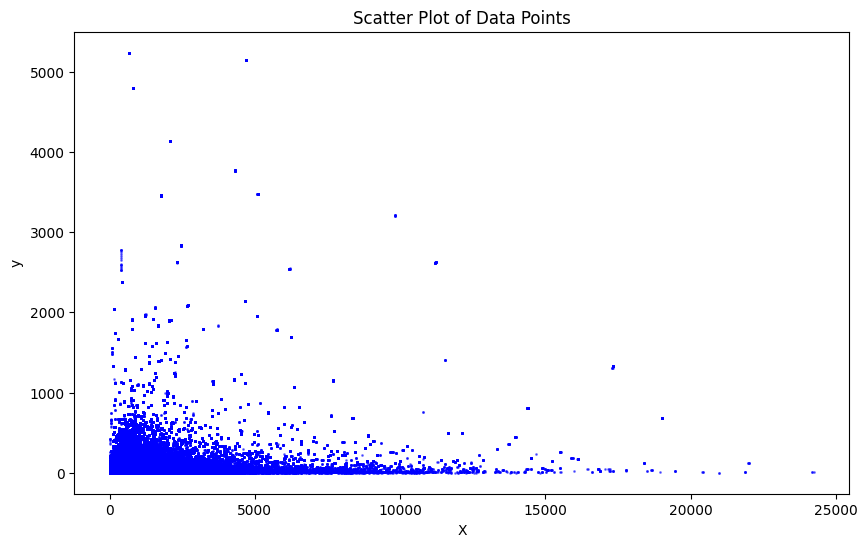

In [32]:
X = df_filtered['author.num_games_owned'].values.reshape(-1, 1)
y = df_filtered['author.num_reviews'].values

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Data Points', s=1, alpha=0.5) # Smaller marker size and transparency
plt.xlabel("X")
plt.ylabel("y")
plt.title("Scatter Plot of Data Points")
#plt.legend() # UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
plt.show()

I see an inversed relationship that looks like an hyperbole, but it's not really clear

In [27]:
from scipy.stats import kruskal
#Distribution Shift Analysis Using Kruskal-Wallis Test
groups = [group['author.num_reviews'].values for name, group in df_filtered.groupby('games_owned_decile')]

kruskal_stat, kruskal_p = kruskal(*groups)
print(f"Kruskal-Wallis test for groups in 'author.num_games_owned': Stats={kruskal_stat:.2f}, P-value={kruskal_p:.2e}")


/tmp/ipykernel_30/854629439.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group['author.num_reviews'].values for name, group in df_filtered.groupby('games_owned_decile')]


Kruskal-Wallis test for groups in 'author.num_games_owned': Stats=7735639.53, P-value=0.00e+00


The significant result indicates that the number of reviews varies depending on the range of games owned. However, it does not indicate the direction of the relationship (whether reviewers with more games tend to leave more or fewer reviews) or which ranges exhibit specific differences.

In [28]:
median_reviews_by_decile = df_filtered.groupby('games_owned_decile')['author.num_reviews'].median()
print("Median for each decile of 'author.num_games_owned':\n", median_reviews_by_decile)


/tmp/ipykernel_30/2426924743.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_reviews_by_decile = df_filtered.groupby('games_owned_decile')['author.num_reviews'].median()


Mediane delle recensioni per decile di 'author.num_games_owned':
 games_owned_decile
(-0.001, 7.0]        1.0
(7.0, 17.0]          2.0
(17.0, 28.0]         2.0
(28.0, 42.0]         3.0
(42.0, 61.0]         4.0
(61.0, 85.0]         5.0
(85.0, 121.0]        6.0
(121.0, 178.0]       7.0
(178.0, 301.0]       9.0
(301.0, 24258.0]    15.0
Name: author.num_reviews, dtype: float64



000
From the median number of reviews for each decile of game ownership, we see a clear progressive increase in the average number of reviews as the number of games owned increases. This result refutes the hypothesis that "reviewers who own more games are likely to leave fewer reviews."

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


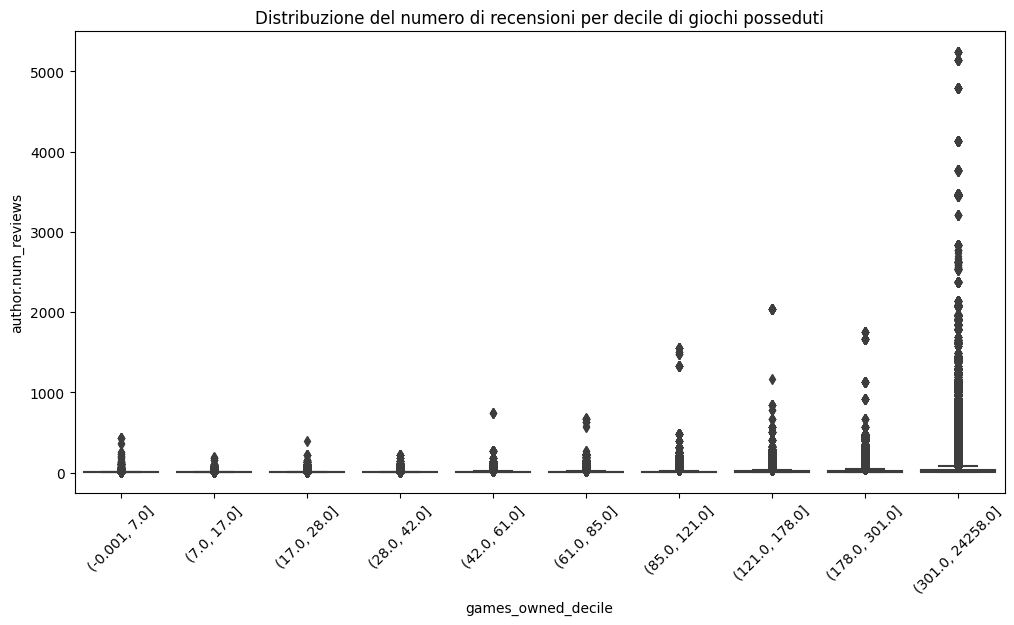

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(x='games_owned_decile', y='author.num_reviews', data=df_filtered)
plt.xticks(rotation=45)
plt.title("Distribuzione del numero di recensioni per decile di giochi posseduti")
plt.show()


The plot suggests that there may be distinct subgroups among those who own a lot of games: some active reviewers and some less active.

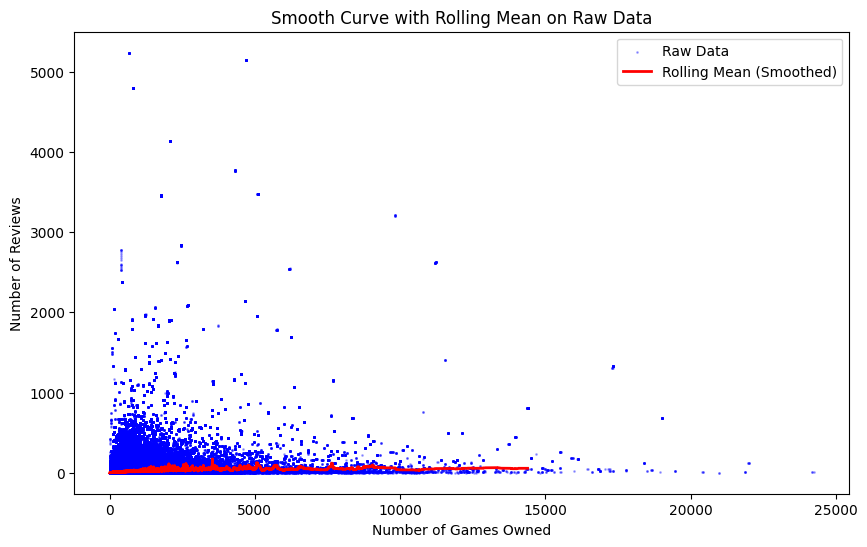

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_filtered 
df_sorted = df.sort_values(by='author.num_games_owned')

#rolling median
df_sorted['smoothed_reviews'] = df_sorted['author.num_reviews'].rolling(window=500, center=True).median()
# Plot 
plt.figure(figsize=(10, 6))
plt.scatter(df_sorted['author.num_games_owned'], df_sorted['author.num_reviews'], s=1, color='blue', alpha=0.3, label='Raw Data')
plt.plot(df_sorted['author.num_games_owned'], df_sorted['smoothed_reviews'], color='red', linewidth=2, label='Rolling Mean (Smoothed)')
plt.xlabel('Number of Games Owned')
plt.ylabel('Number of Reviews')
plt.title('Smooth Curve with Rolling Mean on Raw Data')
plt.legend()
plt.show()


The use of the median over the mean shows a much smoother trend and doesn't need to deal with outliers since it's a more robust method. 

Users with very few games (e.g., close to 0) seem slightly less active in terms of reviews, but since the trend is not really clear (the slope is so small that it can't be really understood), we can't say that the number of games owned influence review activity for the majority of users.




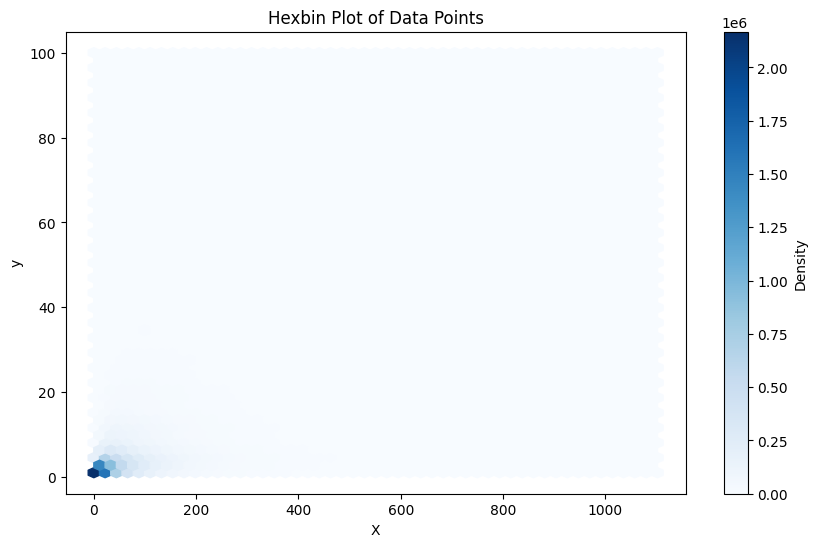

In [16]:
# Hexbin plot to show density of our data points
plt.figure(figsize=(10, 6))
plt.hexbin(X.flatten(), y.flatten(), gridsize=50, cmap='Blues') 
plt.xlabel("X")
plt.ylabel("y")
plt.title("Hexbin Plot of Data Points")
plt.colorbar(label='Density')
plt.show()

Since there is this high density of value near to 0, I don't consider the use of logaritmic transformation

Just out of curiosity, since the previous test denied any linear relationship but suggested that a non-linear relationship may occur, we try to fit a 2nd degree polynomial

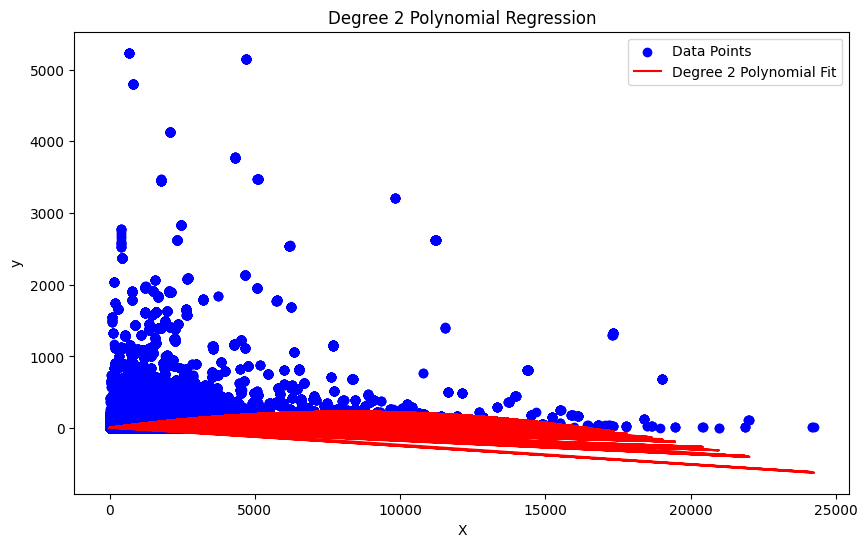

R² for polynomial degree 2: 0.12
RMSE for polynomial degree 2: 32.06


In [46]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Fit 
model = LinearRegression()
model.fit(X_poly, y)

# Predict 
y_pred = model.predict(X_poly)
r2 = r2_score(y, y_pred)
rmse = mean_squared_error(y, y_pred, squared=False)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Data Points')
plt.plot(X, y_pred, color='red', label='Degree 2 Polynomial Fit')
plt.xlabel("X")
plt.ylabel("y")
plt.title("Degree 2 Polynomial Regression")
plt.legend()
plt.show()

print(f"R² for polynomial degree 2: {r2:.2f}")
print(f"RMSE for polynomial degree 2: {rmse:.2f}")

the model doesn’t capture much of the underlying relationship between the variables, but is interesting to see that it confirm what told earlier about the slight initial rise, followed by a very gradual decrease

### Conclusion

To answer the question of the problem, as claimed before, the results refutes the hypothesis that "reviewers who own more games are likely to leave fewer reviews."

I wanted to have a full overview of the relationship between this two features to give a more clear answer supported by the previous statistical analysis. 

In the end the outliers are the biggest problem we had to deal with; when dealing with real data is a problem that often occurs but we can't afford to lose this information  

The central tendency (typical behavior of the majority of the users) shows a slight relationship between games owned and reviews, meaning that for most users, owning more games impact slightly positively their review activity.

The outliers might represent a unique segment of users who behave differently from the average user. Probably they are spammer or gain something to submit more review as possible: while their behavior is interesting, it does not generalize to the broader user base.



Additionally, with more computational resources, it would have been interesting to use LOESS (Local Polynomial Regression) to analyze complex relationship like this one with a method not affected too much by the noise and density. It fits a smooth curve to the data by locally fitting polynomial regressions at various points, showing a trend

### Ask an LLM tool (such as ChatGPT, Claude AI, Gemini, Perplexity, etc.) to understand the purposes of histograms, bar plots, scatterplots, and pie charts and what kind of insights they offer that might be useful for statistical analysis. Are those results trustworthy, or can you do something to improve somehow the confidence in the suggestions given by the LLM?


## Using LLMs to Understand the Purposes and Insights of Common Charts

When using an LLM tool (such as ChatGPT, Claude AI, Gemini, or Perplexity) to understand the purposes and insights provided by different types of charts like histograms, bar plots, scatterplots, and pie charts, here’s how you might approach evaluating the results and improving confidence in the suggestions:

### 1. Understanding the Purposes and Insights of Common Charts

Let’s start by summarizing what you might expect the LLM to provide as a response for each type of chart:

- **Histograms**:
  - **Purpose**: To show the distribution of a single continuous variable.
  - **Insights**: Can reveal patterns such as skewness, central tendency, spread, and the presence of outliers. Useful for understanding the shape of the data distribution and identifying ranges with high or low frequencies.
  - **Applications in Analysis**: Often used in data cleaning, normality checking, and understanding the distribution of a variable before further statistical modeling.

- **Bar Plots**:
  - **Purpose**: To compare categorical data or discrete quantities.
  - **Insights**: Shows differences in frequency or count across categories, making it easy to compare sizes of different groups.
  - **Applications in Analysis**: Useful for visualizing categorical data, proportions, and even summarizing aggregated values (like means or medians) for different groups.

- **Scatterplots**:
  - **Purpose**: To show the relationship between two continuous variables.
  - **Insights**: Can reveal correlations, clusters, trends, and patterns of association. Useful for understanding potential linear or non-linear relationships between variables.
  - **Applications in Analysis**: Frequently used in regression analysis, identifying outliers, and assessing relationships for further modeling.

- **Pie Charts**:
  - **Purpose**: To show proportions of categories as parts of a whole.
  - **Insights**: Provides a high-level view of the composition of a dataset in terms of relative sizes of categories.
  - **Applications in Analysis**: Generally used in business or presentations, but has limited statistical rigor. Not ideal for datasets with many categories or close values.

### 2. Evaluating the Trustworthiness of LLM Responses

The response from an LLM tool, like the one above, might be generally accurate and reliable, especially if it aligns with statistical knowledge. However, to improve confidence in the suggestions and ensure the information is trustworthy, here are some steps you can take:

1. **Cross-Check with Reputable Sources**:
   - Verify the insights provided by the LLM against reputable resources, such as textbooks on data visualization (e.g., "The Grammar of Graphics" by Leland Wilkinson), statistical guides, or respected online tutorials like those from **Khan Academy** or **Coursera**.
   - Cross-reference with statistical documentation and research to confirm the validity of the claims.

2. **Consult Domain-Specific Experts**:
   - If your analysis is specific to a particular field (e.g., medical, finance, social sciences), consult domain experts who might provide additional context or nuances that the LLM may overlook.
   - Experts can offer insights into common pitfalls and best practices that go beyond the general descriptions of chart purposes.

3. **Experiment and Validate with Data**:
   - Test each visualization type on your dataset to see if it provides the insights the LLM described. For example, create histograms, bar plots, scatterplots, and pie charts, and check if the patterns and insights match the LLM’s explanation.
   - Analyzing real data with these charts will help confirm whether the chart provides meaningful insights and if the LLM’s suggestions hold up in practice.

4. **Look for Consistency in LLM Responses**:
   - Rephrase your question and ask the LLM multiple times. Consistent answers across variations of the question can help increase confidence in the reliability of the response.
   - Additionally, compare answers across different LLMs (e.g., ChatGPT, Claude AI) to see if multiple tools provide similar explanations.

5. **Use Peer-Reviewed Articles and Technical Guides**:
   - Research peer-reviewed articles or technical guides on visualization techniques. These often contain comparisons of visualization effectiveness and reliability for different types of data and insights.
   - You can use resources like **IEEE Xplore**, **PubMed**, or **Google Scholar** to find literature on the effectiveness of histograms, bar plots, scatterplots, and pie charts in statistical analysis.

6. **Be Aware of Limitations in LLM Training Data**:
   - Recognize that LLMs are trained on a mix of high-quality and potentially less reliable sources. They can generate plausible-sounding answers but may lack the depth or domain specificity required for certain types of analysis.
   - If the context or complexity of your question is beyond general knowledge, be cautious and corroborate with specialized resources.

7. **Consider Adding Context to Your Query**:
   - LLMs perform better with specific context. For example, adding details about your dataset or the purpose of your analysis (e.g., exploratory data analysis, hypothesis testing) may yield a more targeted response.
   - For instance, asking, “How would a histogram help analyze the distribution of income in a socio-economic study?” canthat the insights are both accurate and relevant for your specific context.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/steam-reviews-2021/steam_reviews.csv


In [ ]:
import pandas as pd
import time
import csv
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

# Introduction to Sentimental Analysis

I chose more advanced methods for this task, focusing on models that are relevant to our dataset rather than just simple to use. Instead of using a standard model like TextBlob, I selected models specifically trained on data similar to our target—informal, user-generated, review-based content. These models were more effective at capturing the true meaning of the reviews, including sarcasm, out-of-context phrases, and unclear language, because they were trained on similar examples, like tweets from X (former Twitter). In contrast, simpler models like TextBlob, which rely on datasets made up mostly of structured text, like Wikipedia articles, lack this depth of understanding.

# English sentiment analysis

Using VADER for sentiment analysis on the Steam Reviews Dataset (22 million rows) proved more effective than TextBlob due to several key advantages:

- Efficiency and Speed: VADER is optimized for processing large volumes of short texts quickly.

- Informal Language Handling: VADER is designed to interpret slang, emojis, and informal expressions frequently found in user reviews, capturing sentiment with greater accuracy.

- Memory Efficiency: VADER’s lower memory usage allows for larger chunk sizes during processing.

- Designed for Reviews: VADER’s sentiment analysis techniques are specifically tuned for online review content, enhancing its effectiveness in this context.

In [6]:
!pip install vaderSentiment

^C


ERROR: Could not find a version that satisfies the requirement vaderSentiment (from versions: none)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for vaderSentiment


In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vader_analyzer = SentimentIntensityAnalyzer()

chunksize = 1000000
sentiment_file_path = 'english_sentiment.csv'
file_path = '/kaggle/input/steam-reviews-2021/steam_reviews.csv'

# sentiment analysis using VADER
def vader_sentiment_analysis(text):
    if pd.isna(text):
        return 'neutral'
    score = vader_analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Start the timer
start_time = time.time()

# Process the file in chunks
for i, chunk in enumerate(pd.read_csv(file_path, chunksize=chunksize, encoding='utf-8', 
                                      quoting=csv.QUOTE_MINIMAL, escapechar='\\', 
                                      on_bad_lines='skip', low_memory=False, dtype=str)):

    chunk = chunk[chunk['language'] == 'english'].copy()
    chunk['sentiment'] = chunk['review'].apply(lambda x: vader_sentiment_analysis(x))
    sentiment_chunk = chunk[['review_id', 'review', 'sentiment']]

    # Log 
    elapsed_time = time.time() - start_time
    print(f"\n--- Chunk {i + 1} processed ---")
    print(f"Time taken for this chunk: {elapsed_time:.2f} seconds")
    print(f"Sample of sentiment data:\n{sentiment_chunk.head()}\n")

    # Overwrite original file
    mode = 'w' if i == 0 else 'a' # w: "write" for the first chunk, a "append" for the next
    header = i == 0
    sentiment_chunk[['review_id','review', 'sentiment']].to_csv(sentiment_file_path, mode=mode, header=header, index=False)

# Calculate total time taken
total_time = time.time() - start_time
print(f"\n=== Total time taken for processing all chunks: {total_time:.2f} seconds ===")


--- Chunk 1 processed ---
Time taken for this chunk: 286.05 seconds
Sample of sentiment data:
   review_id                                             review sentiment
3   85184605  One of the best RPG's of all time, worthy of a...  positive
5   85184171             good story, good graphics. lots to do.  positive
6   85184064                                           dis gud,   neutral
18  85180436  favorite game of all time cant wait for the Ne...  positive
20  85179753                          Why wouldn't you get this   neutral


--- Chunk 2 processed ---
Time taken for this chunk: 551.36 seconds
Sample of sentiment data:
        review_id                          review sentiment
1000000  71818717                             fun  positive
1000002  71818514                         plese\n   neutral
1000005  71818242                       very good  positive
1000006  71818234                       good game  positive
1000007  71818218  Hm.. It's a good game I think,  positive


---

# Simplified Chinese Sentimental Analysis

Initially, SnowNLP was used for Chinese sentiment analysis, but it processed only 250k rows in one hour, projecting a total runtime of over 24 hours. SnowNLP lacks vectorization, which limits its efficiency on large datasets.

To improve performance, we switched to the **roberta-large-finetuned-jd-binary-chinese model**, a binary sentiment model optimized for large-scale data like Steam reviews. Available on [Hugging Face](https://huggingface.co/uer/roberta-base-finetuned-jd-binary-chinese), this model provides greater accuracy and substantial speed improvements, especially when using a GPU. With GPU acceleration, the model efficiently handles large, complex sentiment analysis tasks, making it significantly faster for high-volume data.

In [7]:
!pip install transformers

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from datasets import Dataset
import torch
import re

device = 0 if torch.cuda.is_available() else -1 # Set GPU device

# Directly load the model
# I founded more powerfull models but Kaggle had problem to retrieve my Hugging Face token to access to certain model, this was was preloaded instead
tokenizer = AutoTokenizer.from_pretrained("uer/roberta-base-finetuned-jd-binary-chinese")
model = AutoModelForSequenceClassification.from_pretrained("uer/roberta-base-finetuned-jd-binary-chinese")

# Initialize pipeline with the manually loaded model and tokenizer, and set truncation
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device,
                              max_length=512, truncation=True) # I truncated because I was having this error: RuntimeError: The size of tensor a (894) must match the size of tensor b (512) at non-singleton dimension 1

file_path = '/kaggle/input/steam-reviews-2021/steam_reviews.csv'
sentiment_file_path = 'sentiment_values_schinese.csv'

def analyze_text(batch):
    results = sentiment_pipeline(batch["review"])

    sentiments = []
    scores = []

    for text, res in zip(batch["review"], results):
        clean_label = re.sub(r"\s*\(.*?\)", "", res['label']) # Sentiment output had a star rating from 1 to 5 that represented the score value normalized, we delete this info

        # Since this was a binary classification model, we had to change the threshold to obtain the neutral sentiment
        if res['score'] > 0.6:
            final_sentiment = "positive" if clean_label == "positive" else "negative"
        elif 0.4 <= res['score'] <= 0.6:
            final_sentiment = "neutral"
        else:
            final_sentiment = "negative"

        sentiments.append(final_sentiment)
        scores.append(res['score'])

        # Debug
        #print(f"Text: {text[:100]}...")  # Display up to the first 100 characters of the text
        #print(f"Model Prediction: {clean_label}")
        #print(f"Score: {res['score']:.4f}")
        #print(f"Final Sentiment: {final_sentiment}")
        #print("-" * 50)

    batch["sentiment"] = sentiments
    batch["score"] = scores

    return batch


def process_chunks(file_path, chunksize):
    start_time = time.time()
    chunk_count = 0

    with open(sentiment_file_path, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['review_id', 'review', 'sentiment', 'score'])

    for chunk in pd.read_csv(file_path, chunksize=chunksize, encoding='utf-8',
                             quoting=csv.QUOTE_MINIMAL, escapechar='\\',
                             on_bad_lines='skip', low_memory=False, dtype=str):

        chunk_count += 1
        print(f"\nProcessing chunk {chunk_count}...")

        schinese_reviews = chunk[chunk['language'] == 'schinese'].copy()
        chinese_count = len(schinese_reviews)

        if chinese_count > 0:
            schinese_reviews['review'] = schinese_reviews['review'].fillna("").astype(str)

            dataset = Dataset.from_pandas(schinese_reviews[['review_id', 'review']]) # Create a Hugging Face Dataset (the model documentation stated that it would enhance the performance)

            sentiment_dataset = dataset.map(analyze_text, batched=True, batch_size=64) # we process the data in batch of 64 reviews
            sentiment_df = sentiment_dataset.to_pandas()

            # Debug
            print(f"Sample processed data for chunk {chunk_count}:\n{sentiment_df[['review_id', 'review', 'sentiment', 'score']].head()}")
            print(f"Number of Chinese reviews in chunk {chunk_count}: {chinese_count}")

            # Append processed data to CSV
            sentiment_df[['review_id', 'review', 'sentiment']].to_csv(
                sentiment_file_path, mode='a', header=False, index=False
            )

    total_time = time.time() - start_time
    print(f"\n=== Total processing time: {total_time:.2f} seconds ===")

process_chunks(file_path, chunksize=50000)  # Maximum chunk size by Pc could handle


tokenizer_config.json:   0%|          | 0.00/295 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/409M [00:00<?, ?B/s]


Processing chunk 1...


Map:   0%|          | 0/10920 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Sample processed data for chunk 1:
  review_id                   review sentiment     score
0  85185598  不玩此生遗憾，RPG游戏里的天花板，太吸引人了  positive  0.992877
1  85185250       拔DIAO无情打桩机--杰洛特!!!  positive  0.706966
2  85185111                    巫师3NB  positive  0.894869
3  85184287                       大作  positive  0.993558
4  85183227         年度最佳的作品，没啥好夸的，神作  positive  0.993446
Number of Chinese reviews in chunk 1: 10920

Processing chunk 2...


Map:   0%|          | 0/13189 [00:00<?, ? examples/s]

Sample processed data for chunk 2:
  review_id                                             review sentiment  \
0  77547276                                               剧情满分  positive   
1  77547119  游戏列表:\nThe Witcher 3: Wild Hunt -> 巫师 3: 狂猎\n\...  positive   
2  77547069                                  就是玩了又玩，玩了又玩，听停不下来  positive   
3  77546892  巫师3，总体上，我推荐，按15年的水平来说是顶尖的，\n\n好的方面：\n1.世界画质很好，...  positive   
4  77546853                                     这艘拆哦是的哈是哦的哈熟大肚  positive   

      score  
0  0.993631  
1  0.971995  
2  0.983898  
3  0.987071  
4  0.627987  
Number of Chinese reviews in chunk 2: 13189

Processing chunk 3...


Map:   0%|          | 0/16053 [00:00<?, ? examples/s]

Sample processed data for chunk 3:
  review_id                                             review sentiment  \
0  69868664  A new and great open world,I guess I will take...  positive   
1  69868367                                          剧情很丰富，很不错  positive   
2  69868339                                             牛批就完事了   neutral   
3  69868259                                           111111\n  positive   
4  69868132                                                 好玩  positive   

      score  
0  0.787959  
1  0.993721  
2  0.569822  
3  0.695462  
4  0.967963  
Number of Chinese reviews in chunk 3: 16053

Processing chunk 4...


Map:   0%|          | 0/8272 [00:00<?, ? examples/s]

Sample processed data for chunk 4:
  review_id                       review sentiment     score
0  63167601  刚开始：卧槽这什么莎笔游戏。玩了一段时间：我滴孩真香。   neutral  0.517767
1  63167399              原价不亏，打折血赚！！！！！！  positive  0.987776
2  63166884               波兰蠢驴简直棒，这游戏真香！  positive  0.993572
3  63166688       朋友介绍，好玩，代入感强。不可多得的好游戏。  positive  0.993740
4  63166285                        剧情非常棒  positive  0.993726
Number of Chinese reviews in chunk 4: 8272

Processing chunk 5...


Map:   0%|          | 0/11338 [00:00<?, ? examples/s]

Sample processed data for chunk 5:
  review_id                 review sentiment     score
0  60308524                 那是真的好玩  positive  0.945163
1  60308398                    666  positive  0.919050
2  60307823                  挺有意思的  positive  0.969266
3  60307735                     好玩  positive  0.967963
4  60307705  没啥好说的，我玩过的最良心的游戏，买就对了  positive  0.984914
Number of Chinese reviews in chunk 5: 11338

Processing chunk 6...


Map:   0%|          | 0/10305 [00:00<?, ? examples/s]

Sample processed data for chunk 6:
  review_id                                   review sentiment     score
0  53186792                         完全就是被网友安利过来的，真香~   neutral  0.562310
1  53186377  666666666666666666666666666666666666666  positive  0.862858
2  53185227                       巫师3天下第一，赛博朋克gogogo  positive  0.883428
3  53184864                               折上折购买，手动点赞  positive  0.991132
4  53183775                          打折血赚原价不亏，蠢驴爱了爱了  positive  0.991302
Number of Chinese reviews in chunk 6: 10305

Processing chunk 7...


Map:   0%|          | 0/11899 [00:00<?, ? examples/s]

Sample processed data for chunk 7:
  review_id                                             review sentiment  \
0  46086360                                                  o  positive   
1  46086262                                          选择困难症的末日！  positive   
2  46085790  这款游戏配的上满分！每次打折都有他，一个本应当卖三百多的游戏，才卖63，请问你还在犹豫什么？...  positive   
3  46084988                                             吹爆就完事了  negative   
4  46084758        环境优美，民风淳朴，在找女儿的路上时不时的与百姓玩几局昆特牌，赛马。生活是多么美好啊！  positive   

      score  
0  0.913372  
1  0.988962  
2  0.812942  
3  0.867661  
4  0.991634  
Number of Chinese reviews in chunk 7: 11899

Processing chunk 8...


Map:   0%|          | 0/11949 [00:00<?, ? examples/s]

Sample processed data for chunk 8:
  review_id                                             review sentiment  \
0  37197278                                    Geralt of Rivia  positive   
1  37195872  “玩仙剑的人大概没有不喜欢李逍遥的，我也喜欢着李逍遥，因为他承载了也成全了我幼时的大侠梦。\...  positive   
2  37189209                                                 好玩  positive   
3  37186251                 当在新手村的那个学者教会了我如何玩昆特牌的时候我感觉这个游戏已经变了  positive   
4  37185973                        剧情超棒。支线丰富且有许多很有意思的事件。值得花费时间  positive   

      score  
0  0.932525  
1  0.955838  
2  0.967963  
3  0.991335  
4  0.993765  
Number of Chinese reviews in chunk 8: 11949

Processing chunk 9...


Map:   0%|          | 0/6976 [00:00<?, ? examples/s]

Sample processed data for chunk 9:
  review_id                                             review sentiment  \
0  27962816                                           “游戏中的游戏”   neutral   
1  27962267  不知为什么，当我看到游戏中的游戏奖时，莫名地就想到了这款游戏，真是佩服开发商CD PROJE...  negative   
2  27960924  是一款很好的游戏，无论从剧情、战斗到音乐、画面都无可挑剔，昆特牌也很好玩。有的游戏可以用来打...  positive   
3  27959396  其实这个游戏开始的时候没有什么吸引我的地方，但是等你真的买了之后，深入玩，才可以感受到这个游...  positive   
4  27959194                              “游戏中的游戏”果然还是要给昆特牌3：狂摔  positive   

      score  
0  0.585408  
1  0.784686  
2  0.993632  
3  0.908809  
4  0.915241  
Number of Chinese reviews in chunk 9: 6976

Processing chunk 10...


Map:   0%|          | 0/1454 [00:00<?, ? examples/s]

Sample processed data for chunk 10:
  review_id                                             review sentiment  \
0  18807557                       迄今为止玩过最好的游戏，无论是什么种类的！！支持cdpr  positive   
1  18803397  凯尔莫罕之战后，杰洛特独自一人在空空荡荡的荒原上追寻一个个狩魔猎人曾经的足迹。。。说真的我一...  positive   
2  18801061                                   杰洛特·柯南：真相只有一个！！！  positive   
3  18790693                                             神作，慢慢玩  positive   
4  18784197                                        剧情很丰富，代入感很强  positive   

      score  
0  0.989498  
1  0.939578  
2  0.780344  
3  0.993549  
4  0.993625  
Number of Chinese reviews in chunk 10: 1454

Processing chunk 11...


Map:   0%|          | 0/2101 [00:00<?, ? examples/s]

Sample processed data for chunk 11:
  review_id                                             review sentiment  \
0  49830014  Most Classic and best Game I ever Play !!!!! \...  positive   
1  49637773                                              3梗的起源  positive   
2  49588001                                         它已经不需要评价了。  negative   
3  49525184                                    操作很难受，能跳的地方跳不过去  negative   
4  49490890  小时候放学回家拿张高点的凳子 坐在我爸的拖鞋上很乖的在写作业 我爸过来  游戏打了没 写什么...  positive   

      score  
0  0.932705  
1  0.959037  
2  0.724802  
3  0.944776  
4  0.923214  
Number of Chinese reviews in chunk 11: 2101

Processing chunk 12...


Map:   0%|          | 0/1658 [00:00<?, ? examples/s]

Sample processed data for chunk 12:
  review_id                                       review sentiment     score
0  61664387                23333333333333333333333333333  positive  0.661975
1  61616231  这个游戏能添加机器人作战，非常适合刚入手的CS玩家。并且画质提升了，还有很多游戏成就。  positive  0.993743
2  61609009                                         good  positive  0.974694
3  61575166                                           牛逼  positive  0.957158
4  61563461                                            好  positive  0.960985
Number of Chinese reviews in chunk 12: 1658

Processing chunk 13...


Map:   0%|          | 0/857 [00:00<?, ? examples/s]

Sample processed data for chunk 13:
  review_id                                             review sentiment  \
0  21382461  31个bot和你一起啪啪啪哈哈哈哈哈哈哈超有趣的，而且我觉得比csgo好一些，但是我两个游戏...  positive   
1  21361692                                        神作，优化好，画面好！  positive   
2  21338145                                      还可以吧  就是服务器太少   neutral   
3  21330297  记得我好像是小学5 6年级时候吧,那个时候我CS1.6刚开始玩腻了,直到某一天我在百度看到了...  positive   
4  21309114  优化非常好，配置要求低，娱乐性非常强，可玩性耐玩性都很高，还可以按照个人喜好添加各种武器人物...  positive   

      score  
0  0.801207  
1  0.993751  
2  0.599718  
3  0.940473  
4  0.993754  
Number of Chinese reviews in chunk 13: 857

Processing chunk 14...


Map:   0%|          | 0/1867 [00:00<?, ? examples/s]

Sample processed data for chunk 14:
  review_id                                             review sentiment  \
0  65909377                                                 ：）  positive   
1  65902664                               几年前的游戏,如今依然好玩,就是看不见3  positive   
2  65896171  当初捆绑包打折时入的手，感觉很赚，玩完感觉更赚了，音乐也很好听。就是最后的马格努斯装置玩到自...  positive   
3  65892952                  依然是剧情补完，但精彩程度丝毫不逊于本体，枪车球俱全，业界典范之作  positive   
4  65857403                                        No!我要云Alyx!  negative   

      score  
0  0.621213  
1  0.933043  
2  0.988809  
3  0.991562  
4  0.954925  
Number of Chinese reviews in chunk 14: 1867

Processing chunk 15...


Map:   0%|          | 0/3140 [00:00<?, ? examples/s]

Sample processed data for chunk 15:
  review_id              review sentiment     score
0  72504562         买了绝对不会后悔的游戏  positive  0.988700
1  72501390          通关了，一个字：神作  positive  0.992018
2  72497589      [b] GOOD\t[/b]  positive  0.950361
3  72497098            关卡设计太精妙了  positive  0.825459
4  72496832  这他妈能给差评么？？能么？？就这？？  negative  0.994092
Number of Chinese reviews in chunk 15: 3140

Processing chunk 16...


Map:   0%|          | 0/4513 [00:00<?, ? examples/s]

Sample processed data for chunk 16:
  review_id                                             review sentiment  \
0  54851176                                         在？\n为什么不买？  negative   
1  54849394  玩完看了很多背景故事，刚刚看了下结局炮台唱的歌词，雪儿真的是凯若琳女儿吗？\n游戏真的是设计...  positive   
2  54835851                                没有人能拒绝glados的歌声，没有！  positive   
3  54830993       G胖不会属3 哈哈哈  传送门确实好玩，没玩过1 ，2是真的有意思  尤其是和朋友联机。  positive   
4  54818616  谜题相对于一代来说要难一些，流程也变得更长。\n大场景变得更多，气势也更加恢弘。游玩时的震撼...  positive   

      score  
0  0.888090  
1  0.825023  
2  0.896800  
3  0.987497  
4  0.993743  
Number of Chinese reviews in chunk 16: 4513

Processing chunk 17...


Map:   0%|          | 0/5276 [00:00<?, ? examples/s]

Sample processed data for chunk 17:
  review_id                                             review sentiment  \
0  37171634                   跟朋友一起解密超有意思\n胖瘦仙童机器人哈哈哈ヽ(*´∀`)ﾉﾟ  positive   
1  37163506  超级经典的解谜游戏，可以说脑洞很大了。每过一关都让人感觉很有成就感，当然，V社的游戏对路痴一...  positive   
2  37163311                   提名“我行我素”奖，什么时候才能出PORTAL 3，啊啊啊啊啊。  positive   
3  37159065                                      通关后的创意工坊非常耐玩，  positive   
4  37144937                                             hahaha  positive   

      score  
0  0.971697  
1  0.993622  
2  0.817691  
3  0.993621  
4  0.950403  
Number of Chinese reviews in chunk 17: 5276

Processing chunk 18...


Map:   0%|          | 0/1036 [00:00<?, ? examples/s]

Sample processed data for chunk 18:
  review_id                                             review sentiment  \
0  17600401                                  what a nice game!  positive   
1  17597200                        无论是画面、剧情、模式、还是声音都很不错\n10/10  positive   
2  17587917  当年卡关一直扔下没玩，时隔多年捡起来终于通关了单人模式。。。结局很感人，被我们弄死两次的傲娇...  positive   
3  17578690        通关后来写个评测 portal2不愧是神作 虽然剧情隐晦了些 但是仍然是让人喜欢的作品  positive   
4  17576060           这是一款非常棒的休闲游戏，不会让你一直于游戏之中还要全神贯注，很轻松，不会很累。  positive   

      score  
0  0.950710  
1  0.991540  
2  0.989298  
3  0.991470  
4  0.993712  
Number of Chinese reviews in chunk 18: 1036

Processing chunk 19...


Map:   0%|          | 0/1209 [00:00<?, ? examples/s]

Sample processed data for chunk 19:
  review_id                                             review sentiment  \
0  84905611  每一次进入房间的满头雾水，每一次知晓答案的茅塞顿开，每一次离开关卡的心满意足，让它拥有了无尽...  positive   
1  84903793  商店界面这俩视频演示了个寂寞。。。后面。。还真有\n本来就性价比超高，打折赔本赚吆喝了，v社...  positive   
2  84899393                                  好！我不是傻逼！\n\n但我朋友是  positive   
3  84897925      很优秀，建议有点脑子的玩，不然友谊变友尽[spoiler] 我是傻逼 [/spoiler]  positive   
4  85020475                                               补票作品  positive   

      score  
0  0.991852  
1  0.924858  
2  0.911002  
3  0.956699  
4  0.792548  
Number of Chinese reviews in chunk 19: 1209

Processing chunk 20...


Map:   0%|          | 0/1638 [00:00<?, ? examples/s]

Sample processed data for chunk 20:
  review_id                        review sentiment     score
0  78238175  GOOOOOOOOOOOOOOOOOOOOOD!!!!!  positive  0.835553
1  78237720                          absb  positive  0.623221
2  78229456                 我想下一个猎人\n的mod  positive  0.952974
3  78228272               ```````````````   neutral  0.500035
4  78227092                        .0\n\n  positive  0.864903
Number of Chinese reviews in chunk 20: 1638

Processing chunk 21...


Map:   0%|          | 0/1226 [00:00<?, ? examples/s]

Sample processed data for chunk 21:
  review_id                 review sentiment     score
0  71813588                     好玩  positive  0.967963
1  71809669                    牛大逼  positive  0.967379
2  71807008  gfdhksajheadorsgh ovi   neutral  0.582002
3  71805429                   ok\n  positive  0.943540
4  71802041                      好  positive  0.960985
Number of Chinese reviews in chunk 21: 1226

Processing chunk 22...


Map:   0%|          | 0/1962 [00:00<?, ? examples/s]

Sample processed data for chunk 22:
  review_id                                             review sentiment  \
0  66349044  太好van了、里面的人说话又好听、长的又好看、让我看看有多少人在等打折【滑稽】、一定要买、最...  positive   
1  66347775                                                  额  positive   
2  66347086                                        可以一起玩，可以随便玩  positive   
3  66343824                                                1=∞  positive   
4  66341250          非常好的一款游戏，看中国boy玩这个游戏，就买了下载了，玩着很棒100星推荐！！！  positive   

      score  
0  0.940836  
1  0.710660  
2  0.971755  
3  0.778544  
4  0.993762  
Number of Chinese reviews in chunk 22: 1962

Processing chunk 23...


Map:   0%|          | 0/643 [00:00<?, ? examples/s]

Sample processed data for chunk 23:
  review_id                                        review sentiment     score
0  61415257                                           yes  positive  0.955062
1  61408808  It is a good game made with Half Live engine  positive  0.978577
2  61403038                                           :-)  positive  0.614958
3  61400129                                      创意工坊资源丰富  positive  0.960486
4  61395760                                       够沙雕，爷I辽   neutral  0.512819
Number of Chinese reviews in chunk 23: 643

Processing chunk 24...


Map:   0%|          | 0/785 [00:00<?, ? examples/s]

Sample processed data for chunk 24:
  review_id        review sentiment     score
0  56935337    我的🐴呀，嘿嘿，好玩  positive  0.961413
1  56926307           qaq  positive  0.717770
2  56915974            好玩  positive  0.967963
3  56913463       is good  positive  0.947072
4  56907950  8个人恐怖地图，欢乐无比  positive  0.948805
Number of Chinese reviews in chunk 24: 785

Processing chunk 25...


Map:   0%|          | 0/1265 [00:00<?, ? examples/s]

Sample processed data for chunk 25:
  review_id                                             review sentiment  \
0  51284710  优点,这款游戏就是所有游戏。。。缺点，这款游戏不能代替其他游戏，不过不重要，因为你可以在gm...  positive   
1  51275977                                             游戏体验极差  negative   
2  51272884                                    游戏很好，但是服务器真一坨屎。  negative   
3  51269017                           wdnmd还真就下了一个游戏等于下了所有游戏呗！   neutral   
4  51252548                              有了这款游戏\n你基本不用花钱买其他游戏了  positive   

      score  
0  0.956928  
1  0.984410  
2  0.623589  
3  0.536017  
4  0.937591  
Number of Chinese reviews in chunk 25: 1265

Processing chunk 26...


Map:   0%|          | 0/1760 [00:00<?, ? examples/s]

Sample processed data for chunk 26:
  review_id                                             review sentiment  \
0  42602768  STEAM联机群：欢迎加入Steam（蒸汽），群聊号码：378219945有兴趣的朋友可以加...  positive   
1  42602701                                       我也想记仇╭(╯^╰)╮  negative   
2  42602690               gmod这游戏我不用多说，就一句话：这款游戏把起源引擎的能力用到了极限。  positive   
3  42602254  发现一个每天更新的老司机网站，资源种类超级多\nhttp://www.hsjzyz.com/...  positive   
4  42598671                                       B站 逆风笑视频  入坑  positive   

      score  
0  0.749740  
1  0.605247  
2  0.986985  
3  0.986432  
4  0.696044  
Number of Chinese reviews in chunk 26: 1760

Processing chunk 27...


Map:   0%|          | 0/2144 [00:00<?, ? examples/s]

Sample processed data for chunk 27:
  review_id                                             review sentiment  \
0  34005039  总体来说.....相当的好玩啊，推荐好玩的不行 我是全价入的不亏 想入的不要犹豫强力推荐，特...  positive   
1  34000065                          不多说，就一句话：\n[b] 这是个好游戏[/b]  positive   
2  33996647  [h1]一个游戏 一个世界，借由GMOD观看世界的每一个角落正在发生的故事[/h1]\n\n...  positive   
3  33994415  游戏很不错！层出不穷的mod和模式让人不会厌烦\n但是因为太过自由，导致新手不知道该怎么玩，...  negative   
4  33989725  我是跟着笑笑入的steam，我的第一款游戏就是gmod，模式丰富，欢乐有趣。入这款游戏绝对不...  positive   

      score  
0  0.987585  
1  0.841405  
2  0.921769  
3  0.871301  
4  0.973227  
Number of Chinese reviews in chunk 27: 2144

Processing chunk 28...


Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Sample processed data for chunk 28:
  review_id                                             review sentiment  \
0  27072059  游戏确实很有创意，v社独有的游戏引擎，画面很真实，适合这个玩法。\n\n但是社区里有创意，有...  positive   
1  27060280                              玩GMOD的正确方法：下一天MOD玩一小时  positive   
2  27053531                                         最经典最耐玩的游戏。  positive   
3  27052357                                          可玩性需要慢慢探索  positive   
4  27044602                                         鬼畜的玩法，有点意思  positive   

      score  
0  0.976686  
1  0.983109  
2  0.993711  
3  0.973546  
4  0.977314  
Number of Chinese reviews in chunk 28: 1522

Processing chunk 29...


Map:   0%|          | 0/780 [00:00<?, ? examples/s]

Sample processed data for chunk 29:
  review_id                      review sentiment     score
0  20555136                    很好的沙盒游戏！  positive  0.991651
1  20555021   创意工坊的mod可以让这个games fill乐趣  positive  0.985110
2  20552577  因为只有这游戏我电脑才带的动，所以我能愉快的玩一下午  positive  0.934617
3  20550066                          有毒  negative  0.850826
4  20541462                          很好  positive  0.967079
Number of Chinese reviews in chunk 29: 780

Processing chunk 30...


Map:   0%|          | 0/512 [00:00<?, ? examples/s]

Sample processed data for chunk 30:
  review_id                                             review sentiment  \
0  15170384                             不错，作为我游戏里占空间最大的游戏，模式很多  positive   
1  15139270                 看了人家视频觉得这个游戏不错，但自己玩的时候不知道为何总是贴图错误。   neutral   
2  15111929  作为一个日呆，我是喜欢直播日呆动漫的，作为一个游戏主播，我是需要直播游戏的，但是我并不能明目...  positive   
3  15106722                                               good  positive   
4  15104505                                               ****  negative   

      score  
0  0.993698  
1  0.555585  
2  0.682931  
3  0.974694  
4  0.943546  
Number of Chinese reviews in chunk 30: 512

Processing chunk 31...


Map:   0%|          | 0/258 [00:00<?, ? examples/s]

Sample processed data for chunk 31:
  review_id                                             review sentiment  \
0  11018604  差评233，白下了45g的创意工坊素材，下完后进游戏没有错误提示，但是一进地图在最后一步资源...  negative   
1  11016300                               将一半时间。花在读取服务器MOD的游戏。   neutral   
2  11011491                                     赞一个 !!!!!!!!!!  positive   
3  11004283                                               good  positive   
4  11004247  Garry's Mod就像一个游乐场。。可以在里面无拘无束的搞破坏包括数以万计的素材并且还可...  positive   

      score  
0  0.994217  
1  0.563578  
2  0.990492  
3  0.974694  
4  0.954303  
Number of Chinese reviews in chunk 31: 258

Processing chunk 32...


Map:   0%|          | 0/2510 [00:00<?, ? examples/s]

Sample processed data for chunk 32:
  review_id                                             review sentiment  \
0   5514325   这游戏真不错 。。不过要花不少时间研究，和连接别的服务器时间实在太久。。和朋友联机还是不错的选择  positive   
1   2324709                                             很有创意。。  positive   
2   4146035                      坑爹啊 为了他我吧 所有起源引擎的游戏都买了 然后就后悔了  negative   
3   4873476                                      世界上最好玩的创造游戏之一  positive   
4   3309657  其一，这是一个会吞噬你大量存储空间的过家家游戏，基于你持有的游戏数量，它会吞噬的越多。其二，...  positive   

      score  
0  0.989797  
1  0.977123  
2  0.949185  
3  0.988588  
4  0.960646  
Number of Chinese reviews in chunk 32: 2510

Processing chunk 33...


Map:   0%|          | 0/6955 [00:00<?, ? examples/s]

Sample processed data for chunk 33:
  review_id                               review sentiment     score
0  53110579  游戏性是真的强大，强大到以致于有时在线玩家还会超越《文明6》hhhhh  positive  0.993706
1  53084101       啊，一年又一年，希望在文明7出来的时候能把5全部人物都玩一遍  positive  0.988239
2  53082327                               真香真香真香  positive  0.975004
3  53057532                         嫌时间慢的可以玩这个游戏  positive  0.670681
4  53055735                                    👌   neutral  0.542938
Number of Chinese reviews in chunk 33: 6955

Processing chunk 34...


Map:   0%|          | 0/3707 [00:00<?, ? examples/s]

Sample processed data for chunk 34:
  review_id                        review sentiment     score
0  26909025                “再五分钟就好”奖非你莫属了  positive  0.662162
1  26902205  吸毒中的精品，作业与DEADLINE的噩梦，再来一回合！  positive  0.993604
2  26900359      沉迷文明5无法自拔…“下一回合”这按钮太有魔性了  positive  0.951319
3  26890737                           定闹钟  positive  0.791580
4  26884069               毒品5打折，还不来买买买？\n  negative  0.681986
Number of Chinese reviews in chunk 34: 3707

Processing chunk 35...


Map:   0%|          | 0/1060 [00:00<?, ? examples/s]

Sample processed data for chunk 35:
  review_id                                             review sentiment  \
0  11110841                               不要和lightshader玩！！！！！  negative   
1  11109421  非常耐玩的一款游戏，不过显然大部分的时间我都把这游戏当成了civilization:种田来玩Orz  positive   
2  11008854                                                lol  positive   
3  11005797  确实好玩，无论是画质，还是游戏性，都非常让人着迷。里面的世界要不要那么写实啊！日本基本是开局...  positive   
4  10984772                      一款入门级的人文社科互动教材，唯一的“缺点”就是太杀时间。  positive   

      score  
0  0.707511  
1  0.988808  
2  0.922331  
3  0.989427  
4  0.946729  
Number of Chinese reviews in chunk 35: 1060

Processing chunk 36...


Map:   0%|          | 0/3226 [00:00<?, ? examples/s]

Sample processed data for chunk 36:
  review_id                                             review sentiment  \
0  81847497  这游戏真就只有人类玩家？处决要挂两次？龟龟，怎么不管人类速修？不管人类各种加速修电机的技能？...  negative   
1  81839316                                      eac无法实例化，傻逼游戏  negative   
2  81838513                                           黎明杀机天下第一  positive   
3  81838360                                              太好玩了！  positive   
4  81837619  bug很多，服务器很印度（辣鸡），晚上和男朋友一起玩，开着加速器两个小时只能进4、5把\n新...  positive   

      score  
0  0.984406  
1  0.808018  
2  0.906973  
3  0.968046  
4  0.975486  
Number of Chinese reviews in chunk 36: 3226

Processing chunk 37...


Map:   0%|          | 0/3779 [00:00<?, ? examples/s]

Sample processed data for chunk 37:
  review_id                                             review sentiment  \
0  74794922  我觉得我们的游戏已经做得很好了，曹 治理外挂啊    修好bug啊，匹配体验极差，四个人玩游...  negative   
1  74790630                                                 好玩  positive   
2  74789137  游戏各类优化感觉总体不错，但就是对于我来说上手比较困难，还是比较靠人带的小萌新.....所以...  positive   
3  74787022                                            一起来做印度人  positive   
4  74786043  这时我买完游戏就算他打折到0.8折我都不后悔的游戏。中国玩家大部分都是玻璃心，开局两趴三趴就...  negative   

      score  
0  0.758765  
1  0.967963  
2  0.991362  
3  0.932849  
4  0.884760  
Number of Chinese reviews in chunk 37: 3779

Processing chunk 38...


Map:   0%|          | 0/5115 [00:00<?, ? examples/s]

Sample processed data for chunk 38:
  review_id                                             review sentiment  \
0  69696178             这游戏讲究的是配合  尼玛的你自己一个人单排被虐待怪谁 别像个憨麻批一样乱叫  negative   
1  69677560  这游戏一点也不好玩，而且开启加速器后还极其卡。根本没有游戏体验，里面的玩家也素质极差。故意害...  negative   
2  69674276                                 每个人都可以冲，女角色好看，暴露\n  positive   
3  69672214                                               弟弟游戏  positive   
4  69671319                                     吞了我几十万血点，真的是服了  negative   

      score  
0  0.771986  
1  0.994247  
2  0.984247  
3  0.907845  
4  0.974883  
Number of Chinese reviews in chunk 38: 5115

Processing chunk 39...


Map:   0%|          | 0/4190 [00:00<?, ? examples/s]

Sample processed data for chunk 39:
  review_id                               review sentiment     score
0  61374895  能出点新模式就好了，有点单一，一开始还有点怕，现在只想拥抱麦克叔叔\n  positive  0.988948
1  61370920                         对新手极不又好 但是刺激  negative  0.788346
2  61366290     匹配系统太烂，服务器也有问题。打着打着不是闪退就是掉线。真的难受  negative  0.982773
3  61358210                                  666  positive  0.919050
4  61355393                         好玩的不得了  赶紧充钱  positive  0.891869
Number of Chinese reviews in chunk 39: 4190

Processing chunk 40...


Map:   0%|          | 0/3580 [00:00<?, ? examples/s]

Sample processed data for chunk 40:
  review_id                                             review sentiment  \
0  53845175                                               猛汉落泪   neutral   
1  53834867                                  Dead by Daylight！  negative   
2  53830359  简直是欢乐向游戏，根本不存在恐怖元素，小女生因该挺喜欢的，就是bug有点多，打一把就返回桌面...  positive   
3  53819203  作为第五和杀机都在玩的玩家，真的要做比较的话还是更喜欢杀机这种更有紧张感，恐怖气氛更浓的游戏...  positive   
4  53818208  《黎明杀机》又名：全民生气，这是一款相当气人的猫捉老鼠游戏，玩家会被恐怖氛围怕到生气，会被队...   neutral   

      score  
0  0.556415  
1  0.658396  
2  0.989576  
3  0.983616  
4  0.528044  
Number of Chinese reviews in chunk 40: 3580

Processing chunk 41...


Map:   0%|          | 0/7280 [00:00<?, ? examples/s]

Sample processed data for chunk 41:
  review_id                                             review sentiment  \
0  46547054                             很适合和朋友一起开黑玩，很欢乐，有时候很搞笑  positive   
1  46545317                                         玩不了的重启猫有奇效  negative   
2  46544490  很棒的游戏呀，正在从一开始的蘑菇王慢慢进化，萌新表示还没遇到什么8014、屠夫匹配不到人的问...  positive   
3  46543126                                 你找黑妹  关我克劳黛特什么事！！？   neutral   
4  46542150                                                好玩，  positive   

      score  
0  0.990816  
1  0.690157  
2  0.993760  
3  0.525541  
4  0.972009  
Number of Chinese reviews in chunk 41: 7280

Processing chunk 42...


Map:   0%|          | 0/8662 [00:00<?, ? examples/s]

Sample processed data for chunk 42:
  review_id                                             review sentiment  \
0  38218271  我很喜欢这个游戏 ，但我讨厌这个游戏的匹配机制，是不是这个游戏黄了？我一个20小时的农场主，...  negative   
1  38215391                             我玩了几十级一个回档  心态大蹦  cnm的  negative   
2  38214355  我记得，2016年10月6日，那是我拥有steam账户的第一天。当初并不知道什么游戏好玩，账...  positive   
3  38212377                                        GOOD\nWWWWW  positive   
4  38211066                                         坐等优化，玩着不舒服  negative   

      score  
0  0.937127  
1  0.842574  
2  0.889969  
3  0.967397  
4  0.713344  
Number of Chinese reviews in chunk 42: 8662

Processing chunk 43...


Map:   0%|          | 0/8387 [00:00<?, ? examples/s]

Sample processed data for chunk 43:
  review_id                                             review sentiment  \
0  29090843  说实话，真的是一款很好的游戏。不过真的，玩了这么久的游戏，没见过服务器这么垃圾的。我已经一个...  negative   
1  29090045                             简体中文版里教程居然是英文的！！！差评！！！  negative   
2  29089553             游戏是个好游戏  可这bug也太多了吧 希望官方可以处理一下 优化游戏体验。  negative   
3  29088943  还是挺不错的游戏，虽然经历过很多BUG。还有丢档。不过补偿了。还是挺适合休闲时候玩的游戏，游...  positive   
4  29088720                                  万年读条，游戏总是崩溃，不建议入手  negative   

      score  
0  0.912317  
1  0.994123  
2  0.753924  
3  0.989133  
4  0.887338  
Number of Chinese reviews in chunk 43: 8387

Processing chunk 44...


Map:   0%|          | 0/13169 [00:00<?, ? examples/s]

Sample processed data for chunk 44:
  review_id                                             review sentiment  \
0  23565547                  反作弊很重要，还有中文, 最重要的是希望可以组队，不多2个就可以.  positive   
1  23565409  我爱这款游戏！它刺激，紧张，恐怖，悬疑。还会考验人的人性。平衡性做的也很好。\n\n-关于迈...  positive   
2  23565095  玩了几个小时根本停不下来，前期幸存者与屠夫技能不多，选择性较少，玩到等级高一点会更有意思。\...  positive   
3  23564949  Need Simplified Chinese.登不上游戏的玩家.随便找一个VPN测试账号,...  negative   
4  23564791                                      这个游戏叫做《慌得要死》。  negative   

      score  
0  0.978512  
1  0.976783  
2  0.993639  
3  0.731189  
4  0.641122  
Number of Chinese reviews in chunk 44: 13169

Processing chunk 45...


Map:   0%|          | 0/13735 [00:00<?, ? examples/s]

Sample processed data for chunk 45:
  review_id                   review sentiment     score
0  66176790                        6  positive  0.969392
1  66176524                      有意思  positive  0.968249
2  66174888  垃圾游戏，一点都不像红警和帝国，感觉有点繁琐，  negative  0.904912
3  66170788        打完这把就睡，恩，一把也就半天吧。   neutral  0.539622
4  66170533                沉迷文明，无法自拔  positive  0.900212
Number of Chinese reviews in chunk 45: 13735

Processing chunk 46...


Map:   0%|          | 0/12659 [00:00<?, ? examples/s]

Sample processed data for chunk 46:
  review_id                                         review sentiment     score
0  46487746         时间疯狂地-1s -1s -1s -1s -1s -1s -1s......  negative  0.677678
1  46486381  哎，一到年底就搞事情。\n可我明明才打完一局，怎么就又出新资料片了呢。\n来不及学啊！！！   neutral  0.525405
2  46485469                           这游戏有毒啊 ！！ 根本停不下来！！！！  positive  0.919868
3  46480573                                              好  positive  0.960985
4  46471689                                           下一回合  positive  0.669239
Number of Chinese reviews in chunk 46: 12659

Processing chunk 47...


Map:   0%|          | 0/4265 [00:00<?, ? examples/s]

Sample processed data for chunk 47:
  review_id                                             review sentiment  \
0  83574185  怎么说呢，很好玩的游戏也很良心。刚开始玩你会觉得很漂亮，到了后面当你慢慢知道了这个星球发生的...  positive   
1  83566501                                                  好  positive   
2  83558354                               这游戏要是出个联机版就绝了，我能一直玩。  positive   
3  83548078                                                 好玩  positive   
4  83534976  作为一款将海底作为主舞台的游戏，《深海迷航》将海表面多彩缤纷完美呈现在玩家眼前，阳光透过水面...  positive   

      score  
0  0.991434  
1  0.960985  
2  0.870444  
3  0.967963  
4  0.992156  
Number of Chinese reviews in chunk 47: 4265

Processing chunk 48...


Map:   0%|          | 0/3742 [00:00<?, ? examples/s]

Sample processed data for chunk 48:
  review_id                                             review sentiment  \
0  56236055         真的好玩，但是图太小，剧情太少不够玩啊啊啊，顺便催一下零度之下的汉化，汉化出来我就买  positive   
1  56235939                                    极限模式也能作弊 毫无游戏乐趣  negative   
2  56229577                   难得的一款高质量单机生存类游戏，很容易上手而且很耐玩，十分推荐！  positive   
3  56227566                                           wow好棒的游戏  positive   
4  56225831  一，奇妙世界；二，无人深海；三，无边黑暗\n\n第一步，美丽浅滩\n\n第二部，克服恐惧\n...  positive   

      score  
0  0.967951  
1  0.879085  
2  0.993766  
3  0.993610  
4  0.988925  
Number of Chinese reviews in chunk 48: 3742

Processing chunk 49...


Map:   0%|          | 0/4574 [00:00<?, ? examples/s]

Sample processed data for chunk 49:
  review_id                                             review sentiment  \
0  39637421                      我也是从刚出来测试就开始玩的老玩家了，一直调控制台，真好玩  positive   
1  39634199                                  cnm吓死老子了。。吓死老子了。。  negative   
2  39634006  这一次评测只为一个人，吃喝不愁的live，一位国内的汉化补丁制作人，他的补丁优秀，更新速度快...  positive   
3  39633000  这一次评测只为一个人，吃喝不愁的live，一位国内的汉化补丁制作人，他的补丁优秀，更新速度快...  positive   
4  39632532               这是一款非常好玩的游戏，适合无聊的时候来玩，要是能联机的话这个游戏会更好  positive   

      score  
0  0.991327  
1  0.859114  
2  0.988084  
3  0.988084  
4  0.988891  
Number of Chinese reviews in chunk 49: 4574

Processing chunk 50...


Map:   0%|          | 0/25841 [00:00<?, ? examples/s]

Sample processed data for chunk 50:
  review_id              review sentiment     score
0  84531307  挺好玩的,叫上几个朋友一起，更好\n  positive  0.985375
1  84530864           啥时候更新新关卡啊  positive  0.933645
2  84526888                  66  positive  0.950670
3  84525180           建议有朋友的一起玩  positive  0.825272
4  84517725   简单，有趣，清新，脱俗，值得一玩.  positive  0.993583
Number of Chinese reviews in chunk 50: 25841

Processing chunk 51...


Map:   0%|          | 0/26771 [00:00<?, ? examples/s]

Sample processed data for chunk 51:
  review_id                                             review sentiment  \
0  65103577                    。。。。。。。。。。。。。。。。。。。。。。。。。。。。。。。   neutral   
1  65102824                                                  噢  positive   
2  65102354                                                111  positive   
3  65096736                                   不错的游戏设计，不错的背景音乐。  positive   
4  65096615  感觉很搞笑唯一不足的是STEAM竟然社区打不开需要加速器菜能打开社区！这个非常愚蠢这个STE...  positive   

      score  
0  0.552419  
1  0.812766  
2  0.916918  
3  0.993651  
4  0.950132  
Number of Chinese reviews in chunk 51: 26771

Processing chunk 52...


Map:   0%|          | 0/9833 [00:00<?, ? examples/s]

Sample processed data for chunk 52:
  review_id                                             review sentiment  \
0  46453644                                 和朋友一起玩很开心的游戏，笑到肚子痛  positive   
1  46448842  明明是一款如此欢乐的游戏，为何Bgm却如此悲伤[spoiler]不过bgm是真的很好听[/s...  positive   
2  46444294                           这是一款摔跤游戏 my name is van~  positive   
3  46435680                       很有意思的游戏，虽然在线人数不多，但是还有机会告别孤独的  positive   
4  46420610  通关还是很快的，[spoiler] 毕竟可以爬墙【滑稽】\t[/spoiler]为了拿成就倒...  positive   

      score  
0  0.982783  
1  0.770876  
2  0.666112  
3  0.993533  
4  0.856872  
Number of Chinese reviews in chunk 52: 9833

Processing chunk 53...


Map:   0%|          | 0/2303 [00:00<?, ? examples/s]

Sample processed data for chunk 53:
  review_id            review sentiment     score
0  56759495  没什么好说的，就是好玩，快去玩！  positive  0.970642
1  56683199            很好玩~推薦  positive  0.988407
2  56666210               好游戏  positive  0.987972
3  56558678               好玩的  positive  0.956420
4  56518891            可以锻炼身体  positive  0.978280
Number of Chinese reviews in chunk 53: 2303

Processing chunk 54...


Map:   0%|          | 0/11802 [00:00<?, ? examples/s]

Sample processed data for chunk 54:
  review_id                                             review sentiment  \
0  10485531  虽然并没有游玩很长时间，不过此款游戏值得购买和游玩，Banished是个非常迷你和精美的沙盒...  positive   
1  10188463  一款很好的模拟游戏，需要在发展人口与资源采集之间找到平衡，人口过快发展就得饿死，人口发展过慢...  positive   
2   9997809  写个评测吧，\n1.游戏内容，沙盒式的城市施工，而且不能选定目标，只能给npc市民设定部门任...  positive   
3   9829392                                     no war field\n  positive   
4   9821435                               好游戏，休闲玩家的首选，玩上了就停不下来  positive   

      score  
0  0.991672  
1  0.989726  
2  0.835770  
3  0.911262  
4  0.993708  
Number of Chinese reviews in chunk 54: 11802

Processing chunk 55...


Map:   0%|          | 0/5772 [00:00<?, ? examples/s]

Sample processed data for chunk 55:
  review_id                 review sentiment     score
0  64055243                很好的一款游戏  positive  0.987885
1  64054252                   我是傻逼   neutral  0.517292
2  64053974                  好玩，自闭  positive  0.860905
3  64049211  就是场梦，届不到，梦醒了，还是那熟悉的起点  positive  0.973578
4  64047986                    太难了   neutral  0.540293
Number of Chinese reviews in chunk 55: 5772

Processing chunk 56...


Map:   0%|          | 0/14328 [00:00<?, ? examples/s]

Sample processed data for chunk 56:
  review_id                                             review sentiment  \
0  39208753           超级棒的平台跳跃游戏！主角太可爱了！比那个带着红帽子的中年八字胡大叔可爱多了！！  positive   
1  39112770  女主贼可爱 等寒假不怕表弟抢游戏机了 画风很可爱 内容很丰富  地图全开 就是贵了些 适合居...  positive   
2  39106046  如果要我从《马里奥 奥德赛（Mario Odyssey）》和《时光之帽(Hat in Tim...  positive   
3  39084792  好游戏,我决定过年送朋友一起玩.\n顺便期待一波联机更新.\n之前朋友一直推荐ns天下第一,...  positive   
4  39068756  超级好玩 很可爱的游戏 而且还不失难度 还能在玩耍中学习英语  真是一个不错的游戏  233...  positive   

      score  
0  0.993754  
1  0.991925  
2  0.923859  
3  0.990071  
4  0.993756  
Number of Chinese reviews in chunk 56: 14328

Processing chunk 57...


Map:   0%|          | 0/5586 [00:00<?, ? examples/s]

Sample processed data for chunk 57:
  review_id                                             review sentiment  \
0  81672939  紧张刺激，血腥的同时让我感受到个体的渺小，从不敢下洞到一个一个洞口的深入，从看见洞内的深度颤...  positive   
1  81672761                                  yinweihai keai \n   neutral   
2  81671566                              这个游戏真的挺好玩·但是这个游戏也性能不好  positive   
3  81670645                                               哟西\n  positive   
4  81669443                                            女野人不够细节  positive   

      score  
0  0.990857  
1  0.503555  
2  0.619790  
3  0.637515  
4  0.646672  
Number of Chinese reviews in chunk 57: 5586

Processing chunk 58...


Map:   0%|          | 0/9002 [00:00<?, ? examples/s]

Sample processed data for chunk 58:
  review_id                     review sentiment     score
0  66588314                          1  positive  0.960149
1  66586854                     Good\n  positive  0.974694
2  66586740  一个人进洞穴的时候实在是太恐怖了，漆黑。值得一玩。  positive  0.988889
3  66586400                      好玩 都玩  positive  0.934646
4  66586024                      垃圾游戏！  negative  0.985189
Number of Chinese reviews in chunk 58: 9002

Processing chunk 59...


Map:   0%|          | 0/6021 [00:00<?, ? examples/s]

Sample processed data for chunk 59:
  review_id                                        review sentiment     score
0  52806178  在网吧无聊点开单机偶然玩到的，没想到却上瘾了，和基友一起开黑十分欢乐，简直就是我的森林。  positive  0.993652
1  52804115                一个人玩恐怖游戏  几个人玩真是欢乐多。。还可体验建造的乐趣  positive  0.985327
2  52802678                                          恐怖游戏   neutral  0.517407
3  52795534                         我脑子里只有砍树，砍树使我快乐，我爱砍树。  positive  0.953937
4  52795503                                          nice  positive  0.981160
Number of Chinese reviews in chunk 59: 6021

Processing chunk 60...


Map:   0%|          | 0/2942 [00:00<?, ? examples/s]

Sample processed data for chunk 60:
  review_id                                             review sentiment  \
0  35593417                              单人有点无聊 多人开黑才是本游戏的打开方式  positive   
1  35592194  很好玩的游戏，本以为是纯生存类游戏，但居然是有剧情的，还很感人是最骚的，一人不敢玩，三个小伙...  positive   
2  35588765                                              好玩的游戏  positive   
3  35579366       各方面都还行，联机可玩性也不错，就是我在网吧玩的档回家里就没了，又得开的新的存档，难受。  positive   
4  35573593                                很好玩的游戏，希望出多点能够制作的东西  positive   

      score  
0  0.900957  
1  0.989242  
2  0.976335  
3  0.938128  
4  0.968098  
Number of Chinese reviews in chunk 60: 2942

Processing chunk 61...


Map:   0%|          | 0/3941 [00:00<?, ? examples/s]

Sample processed data for chunk 61:
  review_id                                             review sentiment  \
0  13713043  画面就不用说了 这么小的面积打到这么高的画质，在坠机的孤岛上生存，时时刻刻小心野人的入侵，目...  positive   
1  13666937  不错的游戏，但是优化确实太差。\n·有些东西做好了无法拆掉，这点有点蛋疼\n·土著经常穿墙，...  positive   
2  13637215                                          good game  positive   
3  13477478                    这游戏说好玩也不咋的感觉就那样吧试玩版有缺陷很正常期待下一更新  positive   
4  13476600                            次时代的砍树游戏！      10.5/10！   neutral   

      score  
0  0.993740  
1  0.696780  
2  0.980590  
3  0.739432  
4  0.503699  
Number of Chinese reviews in chunk 61: 3941

Processing chunk 62...


Map:   0%|          | 0/21389 [00:00<?, ? examples/s]

Sample processed data for chunk 62:
  review_id                                             review sentiment  \
0  43830460                          我只想把游戏里面的BGM导入出来，有大佬能做到吗？  negative   
1  43829475                                           我想要一点准系统  positive   
2  43776723                         游戏很好，只是中文翻译的很垃圾，给我造成了不少的困扰   neutral   
3  43774282    ouunmçok güzel ama ingilizceniz yoksa almayın\n  positive   
4  43768737  装机模拟器？不 这是修电脑模拟器。。\n有简体中文好评虽然大部分都是机翻。。\n游戏很好一直...  positive   

      score  
0  0.804834  
1  0.786339  
2  0.520330  
3  0.610254  
4  0.825729  
Number of Chinese reviews in chunk 62: 21389

Processing chunk 63...


Map:   0%|          | 0/7747 [00:00<?, ? examples/s]

Sample processed data for chunk 63:
  review_id                                             review sentiment  \
0  60070030                                            108梁山好汉  positive   
1  60011512  每当我准备拉点朋友玩玩这个我觉得真的很有意思的游戏时，还在标着138的价格让我根本无法安利，...  negative   
2  60003621      G老板，steam已经赚了不少钱了，别在artifact里这么坑钱了，玩个游戏比打牌还贵。   neutral   
3  59995526   如果就这样被放弃了，真的很可惜。想不通明明之前还有抢救的机会，阀门看这游戏成不了摇钱树就放弃了？  negative   
4  59958003                                     对新人很不友好，而且没啥意思  negative   

      score  
0  0.950327  
1  0.752634  
2  0.521954  
3  0.610245  
4  0.943691  
Number of Chinese reviews in chunk 63: 7747

Processing chunk 64...


Map:   0%|          | 0/13609 [00:00<?, ? examples/s]

Sample processed data for chunk 64:
  review_id                                             review sentiment  \
0  55552624   提一下小建议  现在实在是 可能是我网络问题 有办法优化下联机的体验么 会有延迟和卡顿 还有掉线  positive   
1  55551152                                               baba  positive   
2  55550921                                               我是傻逼   neutral   
3  55548836                            没意思，换个区域就得重来一遍，刷来刷去就一个味  negative   
4  55537573  身为一个盗版老玩家，买了游戏后我只花两个小时就神装了（还有一个小时是挂机），完全是为了情怀和...  negative   

      score  
0  0.650009  
1  0.601096  
2  0.517292  
3  0.957858  
4  0.901250  
Number of Chinese reviews in chunk 64: 13609

Processing chunk 65...


Map:   0%|          | 0/5327 [00:00<?, ? examples/s]

Sample processed data for chunk 65:
  review_id                             review sentiment     score
0  74294764            为什么笔记本玩着 巨卡 锁25帧 还有网络垃圾  negative  0.899235
1  74284504                          nice game  positive  0.980121
2  74247733                        这游戏多多少少有点垃圾  negative  0.747353
3  74242866  垃圾游戏，没有导引，转换场景直接卡死，还耻辱工作室合作，真的沙雕。  negative  0.994132
4  74229368               玩还是能玩的下去的，就是游戏做的不够好。  positive  0.704557
Number of Chinese reviews in chunk 65: 5327

Processing chunk 66...


Map:   0%|          | 0/4593 [00:00<?, ? examples/s]

Sample processed data for chunk 66:
  review_id                                             review sentiment  \
0  48060042                游戏优化差是不可否认的，游戏可玩性非常高，给差评是希望制作组改进优化。  negative   
1  48059447  这游戏我真的是服了，建立角色后  出生地是海底，没浮出水面淹半死游了一会被鲨鱼咬死了，重生后...  negative   
2  48057774                               服务器是吃了米田共吗 卡的没办法正常游戏  negative   
3  48055785  玩到现在觉得最有意思的是和傻逼美国人对喷，就喜欢他们打不过我们又无能狂怒的样子，CSTGNB !!  positive   
4  48054876  内存差不多100个G 我就不说了    玩起来没一点游戏体验 太卡 画面模糊  玩了一个小时...  negative   

      score  
0  0.994191  
1  0.981504  
2  0.869649  
3  0.954555  
4  0.993024  
Number of Chinese reviews in chunk 66: 4593

Processing chunk 67...


Map:   0%|          | 0/5741 [00:00<?, ? examples/s]

Sample processed data for chunk 67:
  review_id        review sentiment     score
0  81838263    以前经常玩，现在补票  positive  0.979622
1  81833084             好  positive  0.960985
2  81831454            补票  negative  0.725074
3  81825589       萌死戳永远的神  positive  0.961688
4  81812585  DR成就这辈子是做不完了  positive  0.962584
Number of Chinese reviews in chunk 67: 5741

Processing chunk 68...


Map:   0%|          | 0/7391 [00:00<?, ? examples/s]

Sample processed data for chunk 68:
  review_id                                             review sentiment  \
0  47954005                               c'est bonnnnnnnnnnnn  positive   
1  47948537         [h1]以撒的结合是一款集少女换装、血统检验、寻龙探穴和动作射击的电脑屏保[/h1]  positive   
2  47863935  真tm不好玩，还没游戏说明，40分钟才知道怎么操作。最坑的是买完忘了，等拿出来玩已经18天了...  negative   
3  47853109                  对于新手并不友好，但游戏性十足，道具的组合方式给玩家带来很大乐趣。  positive   
4  47852889                  以撒的结合是真的好游戏，这个游戏是我最喜欢的游戏，好评！！！！！！  positive   

      score  
0  0.642623  
1  0.906690  
2  0.983750  
3  0.989254  
4  0.993741  
Number of Chinese reviews in chunk 68: 7391

Processing chunk 69...


Map:   0%|          | 0/12331 [00:00<?, ? examples/s]

Sample processed data for chunk 69:
  review_id                                             review sentiment  \
0  18412190  从第一代就开始接触以撒系列，一直都很支持这款游戏。耐玩性以及一些接下去的未知的战斗发展让人不...  positive   
1  18409713           。。。。。。。。。。。。。。。。。。。。。。。。。。。。。。。。。。。。。。。。   neutral   
2  18398157  不得不说  这是款十分赞的游戏，，， 一玩上手就根本停不下来的游戏体验以及超长时间的游戏内容...  positive   
3  18396088                                    一个非常不错的游戏，很值得购买  positive   
4  18383497                                         特别好玩！简直神作！  positive   

      score  
0  0.993736  
1  0.540250  
2  0.993751  
3  0.993550  
4  0.993559  
Number of Chinese reviews in chunk 69: 12331

Processing chunk 70...


Map:   0%|          | 0/4121 [00:00<?, ? examples/s]

Sample processed data for chunk 70:
  review_id                                             review sentiment  \
0  26701807                                      通关了两次，非常感动的故事  positive   
1  26698424  原来，玩游戏也是会被感动的，对于我来说，是头一次。。。。\n\n\nRiver：你明年还会来...  positive   
2  26697914  如果我明年没来怎么办？\n那么我们一定会在月球上相遇。\n\n这游戏很适合拿出一个悠闲的下午...  positive   
3  26695922  不得不说，这是一款非常优秀的作品。\n我不知道如何去形容它，简单的来说，有一种美，当它到达了...  positive   
4  26693973  第一次接触这个游戏是用的朋友的共享账号玩的，刚开始是周围很多人推荐所以决定玩一下，不过刚打开...  positive   

      score  
0  0.993740  
1  0.952553  
2  0.989263  
3  0.963795  
4  0.989945  
Number of Chinese reviews in chunk 70: 4121

Processing chunk 71...


Map:   0%|          | 0/3894 [00:00<?, ? examples/s]

Sample processed data for chunk 71:
  review_id                                             review sentiment  \
0  67907023                                    好玩，有趣，不就是换几个键盘嘛  positive   
1  67810368                                                  爽  positive   
2  67632099                                        客户很满意，手已经断了  negative   
3  67314544                               玩一次减寿一年\n别问 问就是生气伤身体   neutral   
4  67236758  I'm pretty sure that I'm not physical disabili...  negative   

      score  
0  0.988862  
1  0.967008  
2  0.713331  
3  0.543905  
4  0.603968  
Number of Chinese reviews in chunk 71: 3894

Processing chunk 72...


Map:   0%|          | 0/6796 [00:00<?, ? examples/s]

Sample processed data for chunk 72:
  review_id                                             review sentiment  \
0  65328503                                  我也好想看一下1-3以后的风景\n  positive   
1  65327276                                      治好了我多年枪打不准的毛病  positive   
2  65326221  几年前看到我喜欢的游戏播主逆逆风笑玩过这个游戏那个时候都觉得挺好玩的几年后的现在我看到这个游...  positive   
3  65322824                            中文在哪里设置.属性哪里没有中文.游戏里找不到  negative   
4  65322013                                            好玩，停不下来  positive   

      score  
0  0.937640  
1  0.989269  
2  0.992333  
3  0.823132  
4  0.986377  
Number of Chinese reviews in chunk 72: 6796

Processing chunk 73...


Map:   0%|          | 0/12434 [00:00<?, ? examples/s]

Sample processed data for chunk 73:
  review_id                                             review sentiment  \
0  41628118  盐与避难所二十一小时左右一周目通关，二周目一小时进度打的很快，跑图打boss，不是很想打了，...  positive   
1  41626669  一般般的感觉，剧情说明不是很明确，相当支离破碎，全程没有一个围绕的中心。说是拯救公主，但是全...  positive   
2  41619722                                                 爽！  positive   
3  41619640  塔盾在手，天下我有。钢铁壁垒一出，沉浸骑士，微笑女王，克拉肯独眼怪，虚妄小丑，亚龙，树人怪，...  positive   
4  41617501                                    巨好玩！黄金酒大剑与避难所！！  positive   

      score  
0  0.990169  
1  0.892923  
2  0.969467  
3  0.959100  
4  0.988918  
Number of Chinese reviews in chunk 73: 12434

Processing chunk 74...


Map:   0%|          | 0/16769 [00:00<?, ? examples/s]

Sample processed data for chunk 74:
  review_id                                             review sentiment  \
0  70822531                                                很好玩  positive   
1  70821137                                      新手劝退游戏，上手难度不低  positive   
2  70820710  感觉可以玩一辈子的游戏，我本身玩游戏是没有多大的耐心的，但是空洞好像有一种魔力，一直折磨你，...  positive   
3  70820420                                              棒\n\n  positive   
4  70820204                                                  牛  positive   

      score  
0  0.969743  
1  0.742563  
2  0.968020  
3  0.987262  
4  0.971471  
Number of Chinese reviews in chunk 74: 16769

Processing chunk 75...


Map:   0%|          | 0/9195 [00:00<?, ? examples/s]

Sample processed data for chunk 75:
  review_id                                             review sentiment  \
0  51832209                                              买就完事了  negative   
1  51832206                                      游戏好评，音乐好评！！！！  positive   
2  51831869  112%完成度通关真的太难了...\n神居五扇门难度程几何倍数上升\n不过\n空洞骑士天下第...  positive   
3  51827540                                               特别好玩  positive   
4  51818056  非常好玩的一款游戏，可玩性非常高。喜欢恶魔城风格游戏的玩家买买买就可以了。剧情也非常有意思。...  positive   

      score  
0  0.861205  
1  0.993727  
2  0.825904  
3  0.979318  
4  0.993767  
Number of Chinese reviews in chunk 75: 9195

Processing chunk 76...


Map:   0%|          | 0/3700 [00:00<?, ? examples/s]

Sample processed data for chunk 76:
  review_id                                             review sentiment  \
0  81786348                                          好玩，就是有点费人  positive   
1  81780175                                      6666666666666  positive   
2  81777801  刚开始玩\n05：01：“最后再线路优化一下就睡！”\n05：00:  “搞完了，  睡觉！...  positive   
3  81776368                                       天亮了。。。。天又亮了！  positive   
4  81772559  我只是尝试着玩了下试玩版……然后一周就没了？？？？？\n\n讲起来虫子的种类还是有些少，如果...  negative   

      score  
0  0.950914  
1  0.856268  
2  0.984563  
3  0.780364  
4  0.712221  
Number of Chinese reviews in chunk 76: 3700

Processing chunk 77...


Map:   0%|          | 0/3820 [00:00<?, ? examples/s]

Sample processed data for chunk 77:
  review_id                                             review sentiment  \
0  55272588  嗯，这么设计一定没问题。等等，我的传送带怎么满了？为什么这工厂不工作了？矿石怎么没了？火车了...   neutral   
1  55272505  我真是服了，更新完以后科技大改，生产线统统废掉；虫子异常狂暴，之前建的防御工事完全顶不住；镇...  negative   
2  55271286                                                非常好  positive   
3  55261433  先前版本里，我经过漫长的过程积攒了大量材料终于射出火箭之后，整个游戏变得索然无味。而现在，火...  positive   
4  55242752                                            这个游戏有毒！  negative   

      score  
0  0.535422  
1  0.986085  
2  0.974932  
3  0.803297  
4  0.855742  
Number of Chinese reviews in chunk 77: 3820

Processing chunk 78...


Map:   0%|          | 0/6970 [00:00<?, ? examples/s]

Sample processed data for chunk 78:
  review_id                                             review sentiment  \
0  21872782  制造流水线盯它一辈子都不会腻，但是马路杀手就不要随便开车（好比我这样 ╮(￣▽￣)╭），撞到...  positive   
1  21864883                                       超级费脑子o(╯□╰)o  negative   
2  21862914  这款游戏我从开发版就开始玩，非常喜欢这种类型的游戏，虽然工厂还有很多可以改进的地方，但是仍然...  positive   
3  21858817  高玩教你如何不费一枪一弹平推数十座虫巢！先把远程电线拉过去虫巢附近接下来换中型号电线配合电塔...  positive   
4  21858478  辣鸡游戏 毁我青春 烧我钱财\n导致我的作息时间紊乱\n记得上闹钟！！！！ 记得上闹钟！！！...  negative   

      score  
0  0.700864  
1  0.666107  
2  0.989307  
3  0.821330  
4  0.966116  
Number of Chinese reviews in chunk 78: 6970

Processing chunk 79...


Map:   0%|          | 0/5157 [00:00<?, ? examples/s]

Sample processed data for chunk 79:
  review_id                                             review sentiment  \
0  56700084  感觉像是一个人在玩饥荒联机版，各个小人没有特别技能，但是有各种性格，相互交流碰撞给人一种社会...  positive   
1  56698616  你有没有注意过 这个游戏里的金属建材叫“钢铁”\n没错 钢 但钢是不可能在自然界中挖掘到的 ...  positive   
2  56698153                                       mod让我玩了五年都没腻   neutral   
3  56696807                                      除了不知道我其他的感觉可以  positive   
4  56694585                        开放性很好，很耐玩的游戏！缺点就是mod兼容性不是很好  positive   

      score  
0  0.987879  
1  0.875440  
2  0.579073  
3  0.726521  
4  0.991506  
Number of Chinese reviews in chunk 79: 5157

Processing chunk 80...


Map:   0%|          | 0/7462 [00:00<?, ? examples/s]

Sample processed data for chunk 80:
  review_id                                   review sentiment     score
0  84146163                建议先打人机，不然有大概率遇到看不到人就死的BUG   neutral  0.558662
1  84143438                                     good  positive  0.974694
2  84134697                                       硬核  positive  0.941211
3  84129468                                   天天游戏崩溃  negative  0.891316
4  84127468  非常硬核非常真实的FPS第一人称射击游戏。热爱射击游戏且追求硬核真实感的强推。  positive  0.993761
Number of Chinese reviews in chunk 80: 7462

Processing chunk 81...


Map:   0%|          | 0/12106 [00:00<?, ? examples/s]

Sample processed data for chunk 81:
  review_id                            review sentiment     score
0  49294708                             不让退款？  negative  0.960972
1  49294178           希望有MOD模组什么的可以有新枪有僵尸就好了。  positive  0.975819
2  49293621                还是一代和耻辱日好……可惜他们都鬼了   neutral  0.564501
3  49293458                          希望能离线bot  positive  0.942310
4  49293204  玩的还是很开心，一如既往地400ping不卡，300ping流畅  positive  0.993748
Number of Chinese reviews in chunk 81: 12106

Processing chunk 82...


Map:   0%|          | 0/14433 [00:00<?, ? examples/s]

Sample processed data for chunk 82:
  review_id                   review sentiment     score
0  59234396           腐化心脏也太难了吧，玩的加我   neutral  0.579353
1  59231349                     非常好玩  positive  0.977492
2  59222659                       好玩  positive  0.967963
3  59220327                       HW  positive  0.853285
4  59217154  ~~~~~~~~~~~~~~~~~~~~~~~  positive  0.804666
Number of Chinese reviews in chunk 82: 14433

Processing chunk 83...


Map:   0%|          | 0/2846 [00:00<?, ? examples/s]

Sample processed data for chunk 83:
  review_id                                       review sentiment     score
0  84726733                                           很好  positive  0.967079
1  84724895                                          哈哈哈  positive  0.850069
2  84723782                               玩了有5年多了 就一个字 赞  positive  0.991322
3  84719135                                        无聊跑一跑  negative  0.898266
4  84717704  驾驶者沃尔沃750从意大利开往波兰的时候,沿途的风景是相当不错。这游戏香香香:))))  positive  0.989750
Number of Chinese reviews in chunk 83: 2846

Processing chunk 84...


Map:   0%|          | 0/3936 [00:00<?, ? examples/s]

Sample processed data for chunk 84:
  review_id                                             review sentiment  \
0  75599004                                            okkkkkk  positive   
1  75598466  多人游戏   玩的很开心    因为工作原因    外设等设备都卖掉了    有时间   还...  positive   
2  75596833                  个人感觉内容会比美卡丰富，画质都差不多，加个几块买欧卡个人觉得更值  positive   
3  75596546  I think the game should add the back-up alarm ...   neutral   
4  75595721                                   治疗失眠很不错  省上医院的钱了  positive   

      score  
0  0.877772  
1  0.993656  
2  0.991699  
3  0.596487  
4  0.993703  
Number of Chinese reviews in chunk 84: 3936

Processing chunk 85...


Map:   0%|          | 0/5162 [00:00<?, ? examples/s]

Sample processed data for chunk 85:
  review_id                                       review sentiment     score
0  67278852                             是个好游戏，我已经运了几千公里了  positive  0.955589
1  67277210  我超爱这个游戏，闲暇之余开开卡车放松，当你不爽是你也可以开着大卡车逆行撞别人，我好爱！  positive  0.966269
2  67272800                                      秋名山带货漂移   neutral  0.596230
3  67270638                             这游戏用来消磨时间还是很不错的。  positive  0.988819
4  67269430                                很不错，失眠的时候很适合玩  positive  0.991967
Number of Chinese reviews in chunk 85: 5162

Processing chunk 86...


Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

Sample processed data for chunk 86:
  review_id                                           review sentiment  \
0  59996157                                            相当杀时间   neutral   
1  59981059                                           游戏风景很美  positive   
2  59978438  希望可以更新雪地地图模式和山路运输模式以提高游戏更多的可玩性，天气系统也更可更加丰富一，例如：  positive   
3  59975136                                               好玩  positive   
4  59969219                                 一湖【壶】水 一盒零食  就一天  negative   

      score  
0  0.510878  
1  0.989845  
2  0.979584  
3  0.967963  
4  0.831997  
Number of Chinese reviews in chunk 86: 3100

Processing chunk 87...


Map:   0%|          | 0/3463 [00:00<?, ? examples/s]

Sample processed data for chunk 87:
  review_id                                  review sentiment     score
0  52517878                                god game  positive  0.918319
1  52512418                                佛系开车ing~  positive  0.961796
2  52509448                             沉迷道路驾驶不能自拔~  positive  0.959689
3  52502157                              联网有点坑，其他还好  positive  0.877273
4  52500349  我竟然开车开到睡着，然后上墙了，这款游戏告诉我们，不要疲劳驾驶-_-||\n  positive  0.946357
Number of Chinese reviews in chunk 87: 3463

Processing chunk 88...


Map:   0%|          | 0/3824 [00:00<?, ? examples/s]

Sample processed data for chunk 88:
  review_id                                             review sentiment  \
0  42272745                                     三屏加上方向盘玩这游戏无敌了  positive   
1  42266456                             垃圾游戏，误买了还不给退款，操你妈，fuck  negative   
2  42262739                                               买就对了  positive   
3  42258274                                      mükemmel oyun  positive   
4  42252517  如果能出一些像 “超车总计XXXXX次”、 “亏本额达到XXXX欧元”\n这样有趣的成就就好...  positive   

      score  
0  0.988836  
1  0.993995  
2  0.950940  
3  0.731119  
4  0.688840  
Number of Chinese reviews in chunk 88: 3824

Processing chunk 89...


Map:   0%|          | 0/2475 [00:00<?, ? examples/s]

Sample processed data for chunk 89:
  review_id                                             review sentiment  \
0  31492180  打打杀杀的游戏玩吐了，虚虚实实的面具戴烦了，那么偶尔静下心来开开慢车看看风景也不失为一种修身...  positive   
1  31490025               加上方向盘感觉真的不一样。操作什么都是比较真实。建议方向盘会更有感觉！！  positive   
2  31485988  最开始以为 不就是个开车游戏吗，觉得巫师三这种  才是让人沉迷的游戏。\n一开始  倒车入库...  positive   
3  31484685  欧卡2可以说是良心之作，虽然还有很多细节比如车辆损毁效果做的不够好，但我还是觉得这款游戏还是...  positive   
4  31481498                刚开始玩感觉还可以，无奈没有加速器，线上玩不上，单机玩的有时候都睡着了   neutral   

      score  
0  0.991489  
1  0.990312  
2  0.968891  
3  0.991188  
4  0.503726  
Number of Chinese reviews in chunk 89: 2475

Processing chunk 90...


Map:   0%|          | 0/4995 [00:00<?, ? examples/s]

Sample processed data for chunk 90:
  review_id                                             review sentiment  \
0  17362538                                             欧卡神教万岁  positive   
1  17344862  《欧洲卡车模拟器2》真是让我欲罢不能。可能一开始会觉得卡车（其实是挂车）很难开，但是过一段时...  positive   
2  17331344                                            很给力的游戏，  positive   
3  17330830  喜欢这类游戏的人会非常喜欢，不喜欢这类游戏的人会觉得它有些无聊。而我属于非常喜欢的那一类。这...  positive   
4  17317946  游戏的驾驶感觉很到位，而且难度的设置也比较合理。在游戏中可以体验到卡车司机的工作和乐趣，路上...  positive   

      score  
0  0.968208  
1  0.988525  
2  0.988620  
3  0.991499  
4  0.993741  
Number of Chinese reviews in chunk 90: 4995

Processing chunk 91...


Map:   0%|          | 0/20635 [00:00<?, ? examples/s]

Sample processed data for chunk 91:
  review_id  review sentiment     score
0  83341813     非常棒  positive  0.991833
1  83332447  别问了，真的  negative  0.850640
2  83330869   我他妈射爆  negative  0.957002
3  83324408  棒\n超级棒  positive  0.993712
4  83324199     111  positive  0.916918
Number of Chinese reviews in chunk 91: 20635

Processing chunk 92...


Map:   0%|          | 0/24089 [00:00<?, ? examples/s]

Sample processed data for chunk 92:
  review_id                 review sentiment     score
0  76026806  我敬佩每一个无私奉献，劳不图酬的平凡司机。  positive  0.970252
1  76026515                    特别好  positive  0.977478
2  76026493            给弟弟买的，弟弟很喜欢  positive  0.988400
3  76025723                    666  positive  0.919050
4  76025573        只能说，十九块钱画的不亏嗷\n  positive  0.618084
Number of Chinese reviews in chunk 92: 24089

Processing chunk 93...


Map:   0%|          | 0/29496 [00:00<?, ? examples/s]

Sample processed data for chunk 93:
  review_id   review sentiment     score
0  70023903     懂的都懂  negative  0.799252
1  70023902     good  positive  0.974694
2  70023801        牛  positive  0.971471
3  70023663  用过的都知道！  positive  0.807496
4  70023636      hso  positive  0.952009
Number of Chinese reviews in chunk 93: 29496

Processing chunk 94...


Map:   0%|          | 0/18974 [00:00<?, ? examples/s]

Sample processed data for chunk 94:
  review_id             review sentiment     score
0  63030836      非常好的软件，设置简单稳定  positive  0.993755
1  63030831              太刺激了！  negative  0.883689
2  63030650  自从用了这个软件，身体一天不如一天  negative  0.657431
3  63025093               懂的都懂  negative  0.799252
4  63021970            超棒的壁纸软件  positive  0.993736
Number of Chinese reviews in chunk 94: 18974

Processing chunk 95...


Map:   0%|          | 0/12884 [00:00<?, ? examples/s]

Sample processed data for chunk 95:
  review_id                       review sentiment     score
0  52769955  自从用了这小破软件，我的硬盘身体是一天不如一天。。。。  negative  0.947485
1  52769042              在这个软件里，你甚至可以换壁纸  positive  0.659423
2  52768850   非常好的软件。已推荐很多人使用。真好——————陆超  positive  0.991608
3  52763767               喜欢明日香的桌面······  positive  0.992274
4  52763204              用个壁纸软件，身体一天不如一天  negative  0.876945
Number of Chinese reviews in chunk 95: 12884

Processing chunk 96...


Map:   0%|          | 0/14906 [00:00<?, ? examples/s]

Sample processed data for chunk 96:
  review_id                                             review sentiment  \
0  34040730  现在也有很多免费的动态桌面软件了，但是广告太多了，讲真，这个软件的体验非常的棒，很省心，换了...  positive   
1  34039346                  希望可以出一个隐藏桌 面图标的功能。\n别的没的说，创意工坊王道。  positive   
2  34038858                    我的虚拟现实好老婆制作工具，死肥宅值得拥有，不说了观摩老婆去了  positive   
3  34038759                                           很好用有不占内存  positive   
4  34037267                                      装逼神器 桌面上放动的老婆  positive   

      score  
0  0.993178  
1  0.986742  
2  0.990076  
3  0.989075  
4  0.984226  
Number of Chinese reviews in chunk 96: 14906

Processing chunk 97...


Map:   0%|          | 0/2956 [00:00<?, ? examples/s]

Sample processed data for chunk 97:
  review_id                                             review sentiment  \
0  44936757              游戏真的不错，目前给我的感觉优于柱子2，不过汉化确实有问题，期待后续改进。  positive   
1  44935616  3.5吗？肯定首发法系啊（ ）\n贼和巡林什么的又没法玩，只有玩法系才能勉强维持得了生活的样...  positive   
2  44935615  游戏剧情还是很棒的，就是中后期堆怪有点严重，强行拖时间的感觉。\nbug和翻译都修的差不多了...  positive   
3  44935260                    开头两个情节和龙腾世纪起源感觉很像啊，半夜中伏和防守村庄，，，  positive   
4  44935065  虽然还有很多需要改进的地方，但是，这些年来有几个这种水准的DND感觉的游戏？对于普通RPG游...  positive   

      score  
0  0.988033  
1  0.940289  
2  0.987871  
3  0.988476  
4  0.896960  
Number of Chinese reviews in chunk 97: 2956

Processing chunk 98...


Map:   0%|          | 0/7467 [00:00<?, ? examples/s]

Sample processed data for chunk 98:
  review_id                                             review sentiment  \
0  48902979  吃神3牛啤！！！5个小时，打一个任务闪退一次 / 看两剧情打个任务闪退一次 / 进任务闪退一...  negative   
1  48902199  吃神系列跟猛汉系列一样，从小学陪伴我到了大学，小学用P酱玩吃神爆裂，初中用v酱和p酱各玩了一...  positive   
2  48901724  镰刀的天堂与地狱是有什么BUG吗，有时候触发失败不扣体力，有时候触发失败会扣体力而且连伸出去...  negative   
3  48901246       移植的很好，语言有繁体中文，而且游戏过程很爽，重点是ai队友很给力，总之就是爽就完事了。  positive   
4  48900942               噢噢噢噢噢噢噢噢噢噢噢噢噢，更新了之后终于可以打开了！！！泪，流了下来。   neutral   

      score  
0  0.702850  
1  0.991452  
2  0.921472  
3  0.993757  
4  0.572781  
Number of Chinese reviews in chunk 98: 7467

Processing chunk 99...


Map:   0%|          | 0/8799 [00:00<?, ? examples/s]

Sample processed data for chunk 99:
  review_id                                             review sentiment  \
0  40708936     1小时：这也太难了\n15小时后：只需要买核心和电力，升级基础武器攻击力，就不怎么需要动脑了  positive   
1  40708723            难得的策略类游戏，高难度下思考下一回合该怎么走时真是绞尽脑汁，然而却又乐在其中  positive   
2  40705195  [h1]Into the Breach ——做一个纯粹的破局者[/h1]\n\n于[url=...  positive   
3  40702867  不愧是知名工作室的作品。感觉很好了体现了：1.游戏提供玩家多样而有趣的选择 2.将这些选择的...  positive   
4  40699655                                             中···中文  positive   

      score  
0  0.685088  
1  0.991947  
2  0.941113  
3  0.993717  
4  0.809953  
Number of Chinese reviews in chunk 99: 8799

Processing chunk 100...


Map:   0%|          | 0/11779 [00:00<?, ? examples/s]

Sample processed data for chunk 100:
  review_id                                             review sentiment  \
0  41277364       So many fking bugs recently, what happened?!   neutral   
1  41277349                                  每次都是打到最后卡bug，我打你吗  negative   
2  41277312                                               无限闪退  negative   
3  41275073  给个好评\n求求你们给战士职业一点游戏乐趣吧  一波怪我砍一年  不如法爷猎爹一个技能？战士...  positive   
4  41274707                                    为什么我老是打着打着就连接错误  negative   

      score  
0  0.571080  
1  0.950621  
2  0.969086  
3  0.730371  
4  0.906006  
Number of Chinese reviews in chunk 100: 11779

Processing chunk 101...


Map:   0%|          | 0/19319 [00:00<?, ? examples/s]

Sample processed data for chunk 101:
  review_id                   review sentiment     score
0  73975442               一小时卡死八回，牛逼  negative  0.947485
1  73975341          爽--------------  positive  0.970807
2  73974747                        .  positive  0.770259
3  73974166          今天的爆率那叫一个高啊.jpg   neutral  0.572420
4  73973525  秘藏猎人，快爬！（宝贝独立制作武器+恐怖分子）  positive  0.936249
Number of Chinese reviews in chunk 101: 19319

Processing chunk 102...


Map:   0%|          | 0/30655 [00:00<?, ? examples/s]

Sample processed data for chunk 102:
  review_id                            review sentiment     score
0  80801058                             打铁,好玩  positive  0.978706
1  80800359  这游戏很简单，可以开无双，比刺客信条还无双的无双，别看了赶紧买吧  positive  0.715820
2  80799041                                好玩  positive  0.967963
3  80798959                              我是sb  negative  0.910022
4  80798913                               真好玩  positive  0.957615
Number of Chinese reviews in chunk 102: 30655

Processing chunk 103...


Map:   0%|          | 0/21782 [00:00<?, ? examples/s]

Sample processed data for chunk 103:
  review_id                                             review sentiment  \
0  61612992                    飞檐走壁、刀光剑影、见招拆招、酣畅淋漓，贪婪永生还是回归平凡？  positive   
1  61612543                            超级棒啊，19年最爱的游戏，没有之一，我爱死！  positive   
2  61612395                                           好玩 无敌强无敌  positive   
3  61612043  只狼不愧是年度最佳游戏\n不过[spoiler] 真的不考虑再出个DLC了嘛 [/spoiler]  positive   
4  61611886                                          年度最佳 当之无愧  positive   

      score  
0  0.921521  
1  0.993764  
2  0.981526  
3  0.949598  
4  0.991280  
Number of Chinese reviews in chunk 103: 21782

Processing chunk 104...


Map:   0%|          | 0/27398 [00:00<?, ? examples/s]

Sample processed data for chunk 104:
  review_id                                             review sentiment  \
0  49764690               33小时龙之还乡，可以安心学习了。\n下一次再玩到这样的会是什么时候呢。  positive   
1  49764675                             别问，死就行了，跟大佬玩的不是一个游戏。。。  negative   
2  49764674                                              ⭐⭐⭐⭐⭐   neutral   
3  49764654     w为啥我的只狼游戏进去后 只能鼠标转动人物  键盘操作不了    键盘没坏 可以玩别的游戏~  negative   
4  49764651  这是一款音乐节奏+中文教学益智游戏，随着游戏的时长，你会对中文的印象越来越深，从而把某个中文...  positive   

      score  
0  0.949546  
1  0.842725  
2  0.542938  
3  0.709728  
4  0.986818  
Number of Chinese reviews in chunk 104: 27398

Processing chunk 105...


Map:   0%|          | 0/23938 [00:00<?, ? examples/s]

Sample processed data for chunk 105:
  review_id                                 review sentiment     score
0  53296218                  全战毕竟是全战，嚼完战场的新鲜感剩下全是蜡   neutral  0.596723
1  53296081          好游戏 很爽 特别是加了血腥效果 中国三国题材 没得说好评  positive  0.993762
2  53295834  感觉还是很好玩的，虽然玩一会儿之后就会觉有一点点无聊，特别是投石车洗地==  positive  0.964791
3  53295249                    出点其他时期和南蛮吧\n我要孟获推全国  positive  0.695248
4  53294866                          魔幻三国迫真期待dlc\n  positive  0.989213
Number of Chinese reviews in chunk 105: 23938

Processing chunk 106...


Map:   0%|          | 0/10739 [00:00<?, ? examples/s]

Sample processed data for chunk 106:
  review_id                                             review sentiment  \
0  75948260                                         游戏很棒，就是不好玩  positive   
1  75947837                                   kojima is good\n  positive   
2  75947199  小岛秀夫说，他想做一款能够把玩家联系起来的游戏，不得不说，他确实做到了。\n在这个单人游戏的...  positive   
3  75946211                                     模式很新颖，送快递停不下来，  positive   
4  75945892                                       我是一个没有感情的快递员  negative   

      score  
0  0.773163  
1  0.959497  
2  0.987173  
3  0.987285  
4  0.913501  
Number of Chinese reviews in chunk 106: 10739

Processing chunk 107...


Map:   0%|          | 0/1553 [00:00<?, ? examples/s]

Sample processed data for chunk 107:
  review_id                          review sentiment     score
0  63751701                               了  positive  0.700285
1  63727232                  好玩是很好玩，就是更新的慢。  positive  0.870140
2  63719399  这是一个自由度很高的搏杀游戏，很适合喜欢冷兵器肉搏的各位玩家  positive  0.992614
3  63716019                          游戏体验极差  negative  0.984410
4  63713102           这游戏里的人素质很差 只会肆无忌惮的欺负你  negative  0.974168
Number of Chinese reviews in chunk 107: 1553

Processing chunk 108...


Map:   0%|          | 0/3906 [00:00<?, ? examples/s]

Sample processed data for chunk 108:
  review_id                                             review sentiment  \
0  50524267  开局按V，获取群体Buff。\n除了机翻的汉化，以及官方服务器太少以外，基本没有大槽点。而且...  positive   
1  50524139                           渣机翻与优化，鼠标位置与显示不符\n建议观望购买  negative   
2  50524090                                      我是奔着骑马与砍杀进来的，   neutral   
3  50523925   这个动作游戏在骑砍1之上 ，在荣耀战魂之下，没接触过这2款的游戏可以推荐下，问题联机没事排不到人  negative   
4  50523513                                 匹配了15分钟一个人都没有可是太秀了  negative   

      score  
0  0.986862  
1  0.614584  
2  0.565495  
3  0.817919  
4  0.682609  
Number of Chinese reviews in chunk 108: 3906

Processing chunk 109...


Map:   0%|          | 0/2951 [00:00<?, ? examples/s]

Sample processed data for chunk 109:
  review_id                                           review sentiment  \
0  72355596                                               傻逼  negative   
1  72354622  一款披着FPS外衣的动作游戏，亦或是一款真正的FPS。\n我已经好久没有打过这么爽快的游戏了！  positive   
2  72354001                                     Masterpiece.  positive   
3  72352826                     完全没有2016有感觉好吧 给人一种打击感要高不高的感觉   neutral   
4  72349258                 毁灭猴子\n杀个屁的恶魔\n地球毁灭了关你屁事\n爬你狗日的墙去  negative   

      score  
0  0.928799  
1  0.941400  
2  0.957893  
3  0.542762  
4  0.881616  
Number of Chinese reviews in chunk 109: 2951

Processing chunk 110...


Map:   0%|          | 0/3603 [00:00<?, ? examples/s]

Sample processed data for chunk 110:
  review_id                                             review sentiment  \
0  65513504  玩了前面几关，说一点感受\n这一代小怪的进攻性比以前强了很多，但电锯的作用也被很好地发挥了出...  positive   
1  65513201                                         至高天钥匙呢？没了？  negative   
2  65513035                                          优化实在做得太好了  positive   
3  65512945  目前大概10h， 目前看起来蛮有意思， 枪械手感一流， 优化很好， 而各位吐槽的音乐我并不觉...  positive   
4  65511084                   手感爆炸~很爽快~就是死啊死啊的就习惯了~各种远程跳跃容错率忒小  positive   

      score  
0  0.988760  
1  0.907880  
2  0.981302  
3  0.993674  
4  0.989805  
Number of Chinese reviews in chunk 110: 3603

Processing chunk 111...


Map:   0%|          | 0/8329 [00:00<?, ? examples/s]

Sample processed data for chunk 111:
  review_id                                             review sentiment  \
0  81354489                                                  香  positive   
1  81352325                                            大 奸 大 恶  negative   
2  81348659                                           第一次玩这类游戏  positive   
3  81347728  虽然我勾引二哥，暗杀二嫂侄子\n虽然我勾引大嫂，暗杀大哥流放侄子\n虽然在发现侄子女儿是个白...  positive   
4  81346126                                王国风云（×）\n大奸大恶模拟器（√）  positive   

      score  
0  0.956363  
1  0.939415  
2  0.966248  
3  0.874883  
4  0.721501  
Number of Chinese reviews in chunk 111: 8329

Processing chunk 112...


Map:   0%|          | 0/5109 [00:00<?, ? examples/s]

Sample processed data for chunk 112:
  review_id             review sentiment     score
0  84497277     没有朋友的愿意跟我交个朋友吗  negative  0.645295
1  84497163            联机玩停不下来  positive  0.901672
2  84495078  为什么总是闪退，有没有大佬告诉我啊  negative  0.925887
3  84493725                 好玩  positive  0.967963
4  84493225        没有动森 但我有星露谷   neutral  0.503071
Number of Chinese reviews in chunk 112: 5109

Processing chunk 113...


Map:   0%|          | 0/8175 [00:00<?, ? examples/s]

Sample processed data for chunk 113:
  review_id                     review sentiment     score
0  74032280                 跟女朋友一块玩最开心  positive  0.973828
1  74031526                  不知不觉就肝了起来  negative  0.695013
2  74030444                老闪退太伤人心了。\n  negative  0.934722
3  74030227              真几把好玩，但闪退怎么办？   neutral  0.518788
4  74028704  游戏是好游戏伤肝是真伤肝.............   neutral  0.518447
Number of Chinese reviews in chunk 113: 8175

Processing chunk 114...


Map:   0%|          | 0/6518 [00:00<?, ? examples/s]

Sample processed data for chunk 114:
  review_id                                             review sentiment  \
0  63909481                                      好玩是好玩\n但是肝遭不住  negative   
1  63909363                              好玩...................  positive   
2  63908974  作为牧场物语系列的老玩家，种地养牛那套已经烂熟于心，本以为就是那样的游戏嘛~说不定玩一会我就...  positive   
3  63908891  和朋友一起玩，非常有意思，但是钓鱼体验极差，一条也上不来，着实太难。很难受，而且一开始没有钓...  negative   
4  63908346          星露谷物语 天下第一！！！！！！！！！！！！！\n哪个中国人会拒绝种菜呢？太快乐了  positive   

      score  
0  0.670296  
1  0.986516  
2  0.991640  
3  0.700753  
4  0.864381  
Number of Chinese reviews in chunk 114: 6518

Processing chunk 115...


Map:   0%|          | 0/4906 [00:00<?, ? examples/s]

Sample processed data for chunk 115:
  review_id                      review sentiment     score
0  56992971   在这个压力山大的现实生活中开启一段美好的农场生活。  positive  0.991997
1  56992943                         闪退。  negative  0.920513
2  56991539                    复古式相素类游戏  positive  0.927403
3  56991311             慢慢玩这个游戏，做好规划别太肝  positive  0.945515
4  56988858  一直闪退，只能睡觉存档，一被闪退一天玩的存档就没有了  negative  0.981497
Number of Chinese reviews in chunk 115: 4906

Processing chunk 116...


Map:   0%|          | 0/7818 [00:00<?, ? examples/s]

Sample processed data for chunk 116:
  review_id                                             review sentiment  \
0  47291554                          如果我闲下来了 一定要找一个人和我一起在星露谷养老  positive   
1  47290797                                       一款频繁闪退的优质游戏。  negative   
2  47287672                                  绿帽谷物语名不虚传，当然是原谅她啊  positive   
3  47284072  2019-03-11更新。\n\n这周专门花时间运行了三个小时左右，目前看来，闪退的现象没有...  negative   
4  47279706   说好的佛系游戏 一旦肝起来就没完  唯一缺点 联机总闪退 最主要的是过节的时候掉了 就没法参加了  negative   

      score  
0  0.920303  
1  0.784200  
2  0.989719  
3  0.991270  
4  0.754503  
Number of Chinese reviews in chunk 116: 7818

Processing chunk 117...


Map:   0%|          | 0/6835 [00:00<?, ? examples/s]

Sample processed data for chunk 117:
  review_id                                             review sentiment  \
0  33606015  不错的游戏，虽然刚开始接触以为和其他经营类游戏差不多，但是当发现有结婚系统，甚至有季节变化这...  positive   
1  33604154  过誉了......所以玩起来有点失望。因为是重复性的操作玩法，所以蛮容易腻的。自由度的确是蛮...  negative   
2  33603797          辣鸡游戏毁我周末!毁我睡觉时间!毁我吃饭时间!毁我聚会时间!毁我青春!!!!!!!  negative   
3  33602988         爷爷给我的根本不是一个农场[spoiler] 而是一个全新的世界[/spoiler]   neutral   
4  33602934                 非常的好玩，而且特别杀时间，不知不觉已经玩了33个小时了，特别推荐！  positive   

      score  
0  0.993358  
1  0.820026  
2  0.979909  
3  0.534347  
4  0.993765  
Number of Chinese reviews in chunk 117: 6835

Processing chunk 118...


Map:   0%|          | 0/4309 [00:00<?, ? examples/s]

Sample processed data for chunk 118:
  review_id                                             review sentiment  \
0  21845248                             这游戏 最大的缺点就是一玩就停不下来  真的  positive   
1  21843727  As there is some problem with my laptop, which...   neutral   
2  21842306                                          所有老婆我都娶过了  positive   
3  21838488                                             两个字：有毒  negative   
4  21837041  When I'm playing this game.\nI'll wash my hair...  positive   

      score  
0  0.975377  
1  0.596255  
2  0.773794  
3  0.938188  
4  0.655588  
Number of Chinese reviews in chunk 118: 4309

Processing chunk 119...


Map:   0%|          | 0/5136 [00:00<?, ? examples/s]

Sample processed data for chunk 119:
  review_id                                             review sentiment  \
0  81312215                                    彩虹六号针不戳，针不戳呀针不戳  negative   
1  81311950  好玩，吹爆，就是手残眼瞎反应慢。萌新坚持下来才会慢慢体会到游戏乐趣，被朋友拉进来的跟我说一百...  positive   
2  81311641                                            我太菜了qwq  negative   
3  81308283                                                666  positive   
4  81308153                                                 好玩  positive   

      score  
0  0.821984  
1  0.972479  
2  0.757884  
3  0.919050  
4  0.967963  
Number of Chinese reviews in chunk 119: 5136

Processing chunk 120...


Map:   0%|          | 0/5946 [00:00<?, ? examples/s]

Sample processed data for chunk 120:
  review_id                          review sentiment     score
0  75811183                  游戏是好游戏，土豆是熟土豆。  positive  0.972566
1  75807640                            非常好玩  positive  0.977492
2  75806932                             很好玩  positive  0.969743
3  75804212                            nice  positive  0.981160
4  75803230  没啥说的，入门难，精通难，但只要一入门，这游戏就是最好的游戏  positive  0.987412
Number of Chinese reviews in chunk 120: 5946

Processing chunk 121...


Map:   0%|          | 0/5696 [00:00<?, ? examples/s]

Sample processed data for chunk 121:
  review_id                                review sentiment     score
0  72009866                               神奇爆头线\n  negative  0.705335
1  72009622                   这是我玩过枪战游戏里面最好玩 最完美的  positive  0.987713
2  72008751                  垃圾UPIAY邮箱都不说是那个公司的垃圾  negative  0.977134
3  72008411  别 改 地 图\n削          \n大          \n盾  negative  0.728928
4  72008406                             玩着挺有意思的\n  positive  0.977885
Number of Chinese reviews in chunk 121: 5696

Processing chunk 122...


Map:   0%|          | 0/7269 [00:00<?, ? examples/s]

Sample processed data for chunk 122:
  review_id                                             review sentiment  \
0  67880909                                                666  positive   
1  67880014                                                666  positive   
2  67879551                    yutweguiegdufsasdfdfsfsdfsddfsd  positive   
3  67878843                                 一款优秀的多人联机恐怖游戏 真的吓人  positive   
4  67878789  这游戏非常好玩，游戏是对新手非常友善，射击难度也没有csgo那么高，都是室内场景，非常容易打...  positive   

      score  
0  0.919050  
1  0.919050  
2  0.614200  
3  0.639097  
4  0.993746  
Number of Chinese reviews in chunk 122: 7269

Processing chunk 123...


Map:   0%|          | 0/9323 [00:00<?, ? examples/s]

Sample processed data for chunk 123:
  review_id                                             review sentiment  \
0  64981212                                             666666  positive   
1  64981144  ⠄⠄⠄⠄⠄⠄⢠⣿⣋⣿⣿⣉⣿⣿⣯⣧⡰⠄⠄⠄⠄⠄⠄⠄⠄⠄⠄⠄\n⠄⠄⠄⠄⠄⠄⣿⣿⣹⣿⣿⣏⣿⣿⡗⣿...   neutral   
2  64976574                                               i了i了  positive   
3  64975973                                             no ela  negative   
4  64975369                                    育碧的服务器是真的土豆 没话说  positive   

      score  
0  0.859141  
1  0.501932  
2  0.644988  
3  0.858800  
4  0.993641  
Number of Chinese reviews in chunk 123: 9323

Processing chunk 124...


Map:   0%|          | 0/5985 [00:00<?, ? examples/s]

Sample processed data for chunk 124:
  review_id    review sentiment     score
0  63144062  傻逼游戏赶紧凉吧   neutral  0.567950
1  63143944      拆迁六号   neutral  0.576885
2  63143547   好玩的无法自拔  positive  0.713254
3  63143369    被虐真爽\n  positive  0.972130
4  63143241      好van  positive  0.937169
Number of Chinese reviews in chunk 124: 5985

Processing chunk 125...


Map:   0%|          | 0/5050 [00:00<?, ? examples/s]

Sample processed data for chunk 125:
  review_id                                   review sentiment     score
0  61052687                                     太喜欢了  positive  0.968997
1  61052579  具有丰富的战术可玩性，永远有新元素去发现，同时也不失FPS的紧张感和对枪元素。  positive  0.993757
2  61052166                                   nice\n  positive  0.981160
3  61051996                      有技术一般的朋友一起打，其实还挺开心的  positive  0.987921
4  61051992                                     很棒\n  positive  0.993613
Number of Chinese reviews in chunk 125: 5050

Processing chunk 126...


Map:   0%|          | 0/5421 [00:00<?, ? examples/s]

Sample processed data for chunk 126:
  review_id                                             review sentiment  \
0  58832663                                               好玩\n  positive   
1  58831884                                  可以说创造性是射击游戏里面最强的了  positive   
2  58831579                                            amazing  positive   
3  58831150                                  it is a good game  positive   
4  58830838  我是一个122级萌新（毕竟100级入门）。长期R6车队一缺四（手动滑稽）\n对于这款游戏，其...  positive   

      score  
0  0.967963  
1  0.987055  
2  0.872784  
3  0.968129  
4  0.924442  
Number of Chinese reviews in chunk 126: 5421

Processing chunk 127...


Map:   0%|          | 0/6582 [00:00<?, ? examples/s]

Sample processed data for chunk 127:
  review_id                                             review sentiment  \
0  56691172                                         冲冲冲,R6天下第一  positive   
1  56690950                                   好玩是好玩 就是一开始就莫名死亡  negative   
2  56690913                                               good  positive   
3  56690855  我是从健康行动开始入坑的玩家，也算是自身玩家了，因为要上学所以现在才快到200级，真的很喜欢...  positive   
4  56690729                                                 ！！   neutral   

      score  
0  0.891291  
1  0.664170  
2  0.974694  
3  0.987816  
4  0.551996  
Number of Chinese reviews in chunk 127: 6582

Processing chunk 128...


Map:   0%|          | 0/3501 [00:00<?, ? examples/s]

Sample processed data for chunk 128:
  review_id                                             review sentiment  \
0  53949897  \n           全球首家在款線上成人娛樂遊戲火爆發售中 警告：未滿十八歲者禁止入內...  positive   
1  53949237  硬核射击战术类游戏\n在这里你可以玩到M870还有M870还有M870\n多样的干员，花样的...  positive   
2  53947666  作为新手游玩体验不错，买了以后给他爱5我都放那吃灰了，个人蝗虫玩家原因所以游戏上手很快，怎么...  negative   
3  53945119  为了方便在网吧和朋友开黑，所以又在steam上买了一份肝帝版彩6与uplay上的同步。从刚开...  positive   
4  53943407  游戏是好游戏，不过自从全境2，再也不买育碧游戏。什么EPIC抽成低，自己家没抽成让利给玩家，...   neutral   

      score  
0  0.955113  
1  0.991579  
2  0.723047  
3  0.943838  
4  0.589988  
Number of Chinese reviews in chunk 128: 3501

Processing chunk 129...


Map:   0%|          | 0/8413 [00:00<?, ? examples/s]

Sample processed data for chunk 129:
  review_id                                             review sentiment  \
0  51030573                                         thanks ubi  positive   
1  51030152  育碧的服务器为什么老是登不上去啊，本来玩这个游戏好瘾的，这样一搞，等的都没感觉了！！！好玩是...  positive   
2  51029276                                   天天排位掉线，我他妈玩你妈呢育碧  negative   
3  51028666  过了那段问题最多的时期，恶性BUG少很多了，到目前为止大部分不平衡的地图和点位得到了重做。\...  positive   
4  51028391  旧BUG不修，新的层出不穷，花钱吃翔。装了卸，卸了装来回几次，我真的失望透了。从库里移除再也不回来  negative   

      score  
0  0.667036  
1  0.734277  
2  0.972325  
3  0.946935  
4  0.983358  
Number of Chinese reviews in chunk 129: 8413

Processing chunk 130...


Map:   0%|          | 0/9093 [00:00<?, ? examples/s]

Sample processed data for chunk 130:
  review_id                                    review sentiment     score
0  46499772                                    很不错的游戏  positive  0.990677
1  46499727                                ..........  positive  0.666011
2  46499704  “辣鸡游戏赢两把就连续碰挂，都NMB孤儿，傻逼游戏卸载了” “打官匹还是平台？”  negative  0.980586
3  46499645   为毛这么不待见新人????游戏是好游戏，就是游戏环境太一言难尽。。就像GTA5  negative  0.612672
4  46499069                                    萌新瑟瑟发抖  positive  0.955298
Number of Chinese reviews in chunk 130: 9093

Processing chunk 131...


Map:   0%|          | 0/17597 [00:00<?, ? examples/s]

Sample processed data for chunk 131:
  review_id                                             review sentiment  \
0  42874844                          除了服务器和育碧特色“彩蛋”，这游戏还是非常出色的  positive   
1  42874375                     相信你会理解一个排位4-3时突然与服务器失去连接的玩家的心情  negative   
2  42873439  求求你搞个娱乐干员，然后设个竞技模式和娱乐模式吧，别你妈只作电竞了，这平衡都要做成屎了.就那...  negative   
3  42872737                           这是个很硬核的优秀游戏，外挂不多，但是技术很重要  positive   
4  42871899  为什么给差评，就是因为腾讯，腾讯垃圾，希望不要锁区，阿育不要因为钱而屈服，你还有我们，我们可...  negative   

      score  
0  0.990256  
1  0.639540  
2  0.892529  
3  0.993560  
4  0.994231  
Number of Chinese reviews in chunk 131: 17597

Processing chunk 132...


Map:   0%|          | 0/12973 [00:00<?, ? examples/s]

Sample processed data for chunk 132:
  review_id                                        review sentiment     score
0  39512749                     辣鸡育碧 挂也不管 满大街的挂  在花一分钱我吃屎  negative  0.962885
1  39512228                                          土豆糊了  negative  0.870842
2  39511409                        这个游戏非常好玩，有点难度。十分推荐大家玩。  positive  0.993640
3  39511116                                         可玩性高。  positive  0.978915
4  39510505  很棒棒的游戏  就是对萌萌新人不太友好  不过 时间能解决这个问题 虽然我现在还是个菜鸡  positive  0.988352
Number of Chinese reviews in chunk 132: 12973

Processing chunk 133...


Map:   0%|          | 0/15681 [00:00<?, ? examples/s]

Sample processed data for chunk 133:
  review_id                                             review sentiment  \
0  35752995                                        好玩好玩 太几把好玩啦  positive   
1  35752125                                            我还能再拆1年  negative   
2  35751926  巴西赛季入的坑,我觉的我是时候写下感受了\n一首先从[h1] 购买游戏[/h1]开始说吧\n...  positive   
3  35750970  很好的一款游戏。或许作为萌新你会发现这个游戏对于萌新来说不是那么像一般的fps游戏一样容易上...  positive   
4  35749279  那是我第一次接触steam,便被彩虹六号的预告吸引住了，随后让它成为我的第一个正版游戏。因为...  positive   

      score  
0  0.977370  
1  0.690494  
2  0.670776  
3  0.991267  
4  0.958569  
Number of Chinese reviews in chunk 133: 15681

Processing chunk 134...


Map:   0%|          | 0/8679 [00:00<?, ? examples/s]

Sample processed data for chunk 134:
  review_id                                             review sentiment  \
0  29186051  这个游戏真的非常好玩，但是对新手很不友好，因为很难的……\n与突突突不同，这游戏更加真实，无...  positive   
1  29186018                                                  法  positive   
2  29184960  非常推荐！我从一个FPS小白 来到了这款游戏，家里的网络不好！可是育碧没有放弃我，我觉得尊重...  positive   
3  29184369  开墙偷人，穿墙偷人，隔墙杀人，这是一款益智兼耐心的一款FPS游戏，它会教会下怎么样有耐心，有...  positive   
4  29184152                   其他我都无所谓 408r6点涨到498我caonima傻逼ubi  negative   

      score  
0  0.786939  
1  0.932235  
2  0.991920  
3  0.923172  
4  0.708963  
Number of Chinese reviews in chunk 134: 8679

Processing chunk 135...


Map:   0%|          | 0/1287 [00:00<?, ? examples/s]

Sample processed data for chunk 135:
  review_id                                             review sentiment  \
0  85052138                                             恐怖游戏：）  positive   
1  85051228                                        土豆育碧一如既往的崩溃  negative   
2  85048998                                            怎么充R6点?  negative   
3  85131323  之前打csgo，久闻彩六大名，正巧朋友送了一套，花了一个晚上打了打，不得不说，这游戏很需要钻...  positive   
4  85131322                            玩起来像2040年的游戏，很新颖，很有意思\n  positive   

      score  
0  0.788053  
1  0.698756  
2  0.821520  
3  0.992809  
4  0.993677  
Number of Chinese reviews in chunk 135: 1287

Processing chunk 136...


Map:   0%|          | 0/749 [00:00<?, ? examples/s]

Sample processed data for chunk 136:
  review_id                                             review sentiment  \
0  81872618                                               针不戳嘿  negative   
1  81868158  I played about 1000 rounds. My win rate as imp...   neutral   
2  81856469                                               非常流批  negative   
3  81855921                                               我是傻逼   neutral   
4  81853741                                 很棒的游戏，很喜欢和朋友一起开黑玩。  positive   

      score  
0  0.681694  
1  0.525290  
2  0.663606  
3  0.517292  
4  0.993761  
Number of Chinese reviews in chunk 136: 749

Processing chunk 137...


Map:   0%|          | 0/722 [00:00<?, ? examples/s]

Sample processed data for chunk 137:
  review_id                      review sentiment     score
0  79808685                       针不错\n  positive  0.930315
1  79808083                       不错的游戏  positive  0.987707
2  79806398                         还不错  positive  0.928669
3  79803970                       好得不得了  positive  0.957853
4  79803697  No Chinese,FUCK you mother  negative  0.718589
Number of Chinese reviews in chunk 137: 722

Processing chunk 138...


Map:   0%|          | 0/517 [00:00<?, ? examples/s]

Sample processed data for chunk 138:
  review_id                                             review sentiment  \
0  78711020                                                真不错  positive   
1  78710808                        我们需要中文!!\nWe need chinese!!  positive   
2  78710756                                              还挺不错的  positive   
3  78710616                                 我们3个寝室一起玩  只有那么欢乐了  positive   
4  78707702  看了一篇公众号 觉得还挺好玩的 就来入了一个\n说实话 我不失望\n------------...  positive   

      score  
0  0.970110  
1  0.829133  
2  0.942756  
3  0.866388  
4  0.952258  
Number of Chinese reviews in chunk 138: 517

Processing chunk 139...


Map:   0%|          | 0/236 [00:00<?, ? examples/s]

Sample processed data for chunk 139:
  review_id                                             review sentiment  \
0  78097471                                               喜欢\n  positive   
1  78095282  We need Chinese\nWe need Chinese\nWe need Chin...   neutral   
2  78094115                                                棒\n  positive   
3  78088202                         英语不好也可以玩，任务点都标记出来了，只要推理就好了  positive   
4  78087442                          真有人玩游戏用直觉的？？？？？？？我刀你妈也用直觉  negative   

      score  
0  0.964082  
1  0.555637  
2  0.987262  
3  0.943686  
4  0.897089  
Number of Chinese reviews in chunk 139: 236

Processing chunk 140...


Map:   0%|          | 0/175 [00:00<?, ? examples/s]

Sample processed data for chunk 140:
  review_id                     review sentiment     score
0  77447494        너무 추천합니다 같이 죽읍시다 우리   neutral  0.517490
1  77445890                影分身受害者，懂得都懂  positive  0.691158
2  77445519             打完这个游戏感觉四级稳过了。  positive  0.990791
3  77443422  太有趣了，基本都是船员，也不会输的，外国人都笨得一  positive  0.988128
4  77441350                          牛  positive  0.971471
Number of Chinese reviews in chunk 140: 175

Processing chunk 141...


Map:   0%|          | 0/105 [00:00<?, ? examples/s]

Sample processed data for chunk 141:
  review_id                            review sentiment     score
0  76897280                                好哇  positive  0.940007
1  76894516  Among US， 又名 “我们中出了个叛徒”。 两个字，好玩。  positive  0.986625
2  76886134                          没有朋友玩很无聊  negative  0.829407
3  76880613                        Great game  positive  0.941057
4  76879062       玩法非常成熟 非常好玩的类狼人杀游戏！\n挂狗死全家！  positive  0.957136
Number of Chinese reviews in chunk 141: 105

Processing chunk 142...


Map:   0%|          | 0/71 [00:00<?, ? examples/s]

Sample processed data for chunk 142:
  review_id                                    review sentiment     score
0  76476624                               i'm not sus  negative  0.838660
1  76475669                  啊啊啊   建群玩啊，，qq群514388731  positive  0.633149
2  76473863  好游戏 唯一问题是中文受众面极低 英文DC小组好找 中文有现实朋友一起是真的欢乐  positive  0.975323
3  76472713        很tm好玩 只可惜加不了好友有点可惜。碰到了超有趣的人，不错的回忆！  positive  0.990688
4  76470517  游戏本身是没有语音功能的，全靠打字，所以中文玩家不需要顾虑，初级英文水准就行了。  positive  0.677946
Number of Chinese reviews in chunk 142: 71

Processing chunk 143...


Map:   0%|          | 0/47 [00:00<?, ? examples/s]

Sample processed data for chunk 143:
  review_id                                             review sentiment  \
0  76104341                                               我是傻逼   neutral   
1  76089036  基本就是太空船主题的狼人+阿瓦隆，好人要做任务（每个人的任务不同）或投出狼，狼要杀好人或者破...  positive   
2  76087331  easy to play, fun game design. good interactio...  positive   
3  76083931  This is hands down, the. best. game. ever. It'...  positive   
4  76070850  ░░░░░░█▐▓▓░████▄▄▄█▀▄▓▓▓▌█░░░░░▄█▌▀▄▓▓▄▄▄▄▀▀▀▄...   neutral   

      score  
0  0.517292  
1  0.944154  
2  0.988012  
3  0.684355  
4  0.513231  
Number of Chinese reviews in chunk 143: 47

Processing chunk 144...


Map:   0%|          | 0/7836 [00:00<?, ? examples/s]

Sample processed data for chunk 144:
  review_id                                 review sentiment     score
0  75308195                           一款优秀的2D狼人杀游戏  positive  0.988986
1  75284440                       好玩但人少只有美服，ping太高  positive  0.662746
2  75260965                           玩着很轻松  又不失趣味  positive  0.991639
3  75164096                                      好  positive  0.960985
4  75157586  虽然没有中文，但是英文交流也非常方便，只需说几个简单单词就行，很萌的游戏。  positive  0.992081
Number of Chinese reviews in chunk 144: 7836

Processing chunk 145...


Map:   0%|          | 0/7469 [00:00<?, ? examples/s]

Sample processed data for chunk 145:
  review_id                                             review sentiment  \
0  69232424  给我中文啊，我丢你蕾姆的，新手教程还是自己摸索的过去的，英文一大堆也看不懂，翻译又麻烦，不过...  positive   
1  68778351                                司马棒子。反华严重，建议公司立刻倒闭。  negative   
2  68737771             这个游戏刚玩挺好，要会英语不然听不懂别人叫的啥，很有氛围(玩久了没啥意思了)  positive   
3  68730034  这个游戏并不推荐大家购买，因为这个游戏基本没人玩了，乍一看有很多服务器可是有人的就那么一两个...  negative   
4  68549396                                               没有中文   neutral   

      score  
0  0.945277  
1  0.935760  
2  0.990383  
3  0.983208  
4  0.555691  
Number of Chinese reviews in chunk 145: 7469

Processing chunk 146...


Map:   0%|          | 0/4128 [00:00<?, ? examples/s]

Sample processed data for chunk 146:
  review_id                                  review sentiment     score
0  84416079                                非常好的格斗游戏  positive  0.992030
1  84408207  81个小时10个小时过故事，40个小时在打桩，20个小时打街机，剩下全在挨揍   neutral  0.501755
2  84398045                              让我看看谁是原价买的  negative  0.702273
3  84367886                                   好玩就完事  positive  0.664620
4  84348899                                      还行  positive  0.783756
Number of Chinese reviews in chunk 146: 4128

Processing chunk 147...


Map:   0%|          | 0/873 [00:00<?, ? examples/s]

Sample processed data for chunk 147:
  review_id                                review sentiment     score
0  84265356  外挂横行！！！鼠标宏横行！！！误ban连一个解释都没有！！！好游戏给毁了  negative  0.982707
1  84263636                                 真不错\n  positive  0.970110
2  84263038                           与朋友开黑还是蛮好玩的  positive  0.969354
3  84262453                                   非常好  positive  0.974932
4  84262182                                   111  positive  0.916918
Number of Chinese reviews in chunk 147: 873

Processing chunk 148...


Map:   0%|          | 0/934 [00:00<?, ? examples/s]

Sample processed data for chunk 148:
  review_id                 review sentiment     score
0  76791012                 超級好玩\n  positive  0.985485
1  76790199  去年刚开始玩的，队友找好点的比玩独狼有意思  positive  0.988750
2  76772129                hwhw666  positive  0.633694
3  76772009                      赞  positive  0.982603
4  76760466                   NICE  positive  0.981160
Number of Chinese reviews in chunk 148: 934

Processing chunk 149...


Map:   0%|          | 0/1209 [00:00<?, ? examples/s]

Sample processed data for chunk 149:
  review_id                                             review sentiment  \
0  68993249                                好玩得一批，你知道什么是一批吗 飞飞？  positive   
1  68968128              在rust推出类似七日杀的电脑开房或者方舟的非专属服务器之前是不推荐购买的  negative   
2  68964361                                     每个成功男人必备的开挂小游戏  positive   
3  68956618  早问 rust大名 但是由于一些其他的原因无法去深入了解pvp主要玩的还是pve吧，总的来说...  positive   
4  68949694                                                  1  positive   

      score  
0  0.805457  
1  0.784467  
2  0.993552  
3  0.991873  
4  0.960149  
Number of Chinese reviews in chunk 149: 1209

Processing chunk 150...


Map:   0%|          | 0/789 [00:00<?, ? examples/s]

Sample processed data for chunk 150:
  review_id                                             review sentiment  \
0  62163772                                             老游戏可以的  positive   
1  62126892                                             牛逼 奥利给  positive   
2  62125991                           混蛋游戏里一帮混蛋人，我也是个混蛋,我爱这个游戏  positive   
3  62124004  外挂太多，10盘有8盘被外挂杀！封号力度不够，应该建立判定视频系统，让玩家判定！光靠系统封，...  negative   
4  62121114  rust打开\n官服连接\n裸吊打桶\n刨矿建家\n蓝图全解\n刨矿炸家\n全装出门\n爆弹...  positive   

      score  
0  0.959899  
1  0.782444  
2  0.962735  
3  0.682076  
4  0.682893  
Number of Chinese reviews in chunk 150: 789

Processing chunk 151...


Map:   0%|          | 0/1025 [00:00<?, ? examples/s]

Sample processed data for chunk 151:
  review_id                                             review sentiment  \
0  57225592                                              我是大傻逼  positive   
1  57225483  首先这游戏集合了很多元素，生存 建造 fps 经营 策略 制造 pvp pve 玩法很新颖，...  positive   
2  57215670                            我觉得很好玩啊 适合我这种喜欢养生又打架的玩家  positive   
3  57208143                                               垃圾游戏  negative   
4  57206426                                             对新手不友好  negative   

      score  
0  0.632580  
1  0.983561  
2  0.988254  
3  0.984371  
4  0.822971  
Number of Chinese reviews in chunk 151: 1025

Processing chunk 152...


Map:   0%|          | 0/1662 [00:00<?, ? examples/s]

Sample processed data for chunk 152:
  review_id                                             review sentiment  \
0  52372892                                        服务器要加载很久。。。  positive   
1  52364443                                               没必要买  negative   
2  52363045  15年五月第一次在斗鱼平台看到这个游戏，那时候刚念大学，玩人家给的私服，首次接触生存类的游戏...  negative   
3  52352447  Serverlara girerken hep yukleme yapıyor.Buda ç...  positive   
4  52339922                                        傻逼游戏 进不去玩mb  negative   

      score  
0  0.839768  
1  0.963404  
2  0.674863  
3  0.614865  
4  0.819792  
Number of Chinese reviews in chunk 152: 1662

Processing chunk 153...


Map:   0%|          | 0/2232 [00:00<?, ? examples/s]

Sample processed data for chunk 153:
  review_id                                             review sentiment  \
0  43683101  非常让我不舒服的一次体验，几个月没玩了，昨天朋友说要玩，我就回来看看，结果刚开始玩一天，搜集...  negative   
1  43679848                        这游戏成天官清，但更新内容也太慢了吧，总是无用的皮肤。  negative   
2  43678021                                              看都看不懂  negative   
3  43676851           这个游戏适合三五个好友一起玩，很早之前买的游戏了。现在居然还涨价了。厉害！！！！  positive   
4  43676635  无缘无故被官服ban了！！！我是开挂了还是骂人了？     才玩了10个小时，我朋友就因为说...  negative   

      score  
0  0.980318  
1  0.896136  
2  0.932159  
3  0.991558  
4  0.980545  
Number of Chinese reviews in chunk 153: 2232

Processing chunk 154...


Map:   0%|          | 0/1905 [00:00<?, ? examples/s]

Sample processed data for chunk 154:
  review_id                                             review sentiment  \
0  34279907  很不错，跟方舟配置进化差不多，没有方舟配置进化繁琐，如果把他跟方舟比的话.这个游戏把龙变成了...  positive   
1  34276547                               不错    ！！！武器太少    ！！!  positive   
2  34270862                                    一个好游戏叫挂给毁了，白瞎了，  negative   
3  34269486  不久前我刚买下这个游戏，萌新嘛进去就是一贯的思想撸木头撸矿石，\n然后建一个家安安稳稳的玩下...  positive   
4  34266935                                        我换了台电脑就下不了了  negative   

      score  
0  0.968028  
1  0.902830  
2  0.849225  
3  0.903325  
4  0.950846  
Number of Chinese reviews in chunk 154: 1905

Processing chunk 155...


Map:   0%|          | 0/1695 [00:00<?, ? examples/s]

Sample processed data for chunk 155:
  review_id                                             review sentiment  \
0  25521842                                               哎哎哎哎  negative   
1  25511650                                              good!  positive   
2  25511459  起初  我玩了个通宵在官服 小心翼翼 为了个小房子 而开心那种感觉很快就不在了 太累太累  ...  negative   
3  25507308  这款游戏完全就是人与人之间的战争，总感觉缺少些其他的乐趣，听说以前这游戏有僵尸再一次更新后没...  positive   
4  25505443                                         这游戏真是经久不衰啊  positive   

      score  
0  0.876481  
1  0.976347  
2  0.987033  
3  0.925934  
4  0.988788  
Number of Chinese reviews in chunk 155: 1695

Processing chunk 156...


Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Sample processed data for chunk 156:
  review_id                                             review sentiment  \
0  16974598                                              shit！  positive   
1  16972559                                               好玩\n  positive   
2  16967109  游戏本身题材很好。但游戏内生物资源较少，找头猪都得翻山越岭。游戏内部石头资源稀少，分布不均匀...  negative   
3  16966128                                IT IS AWESOME!!!!\n   neutral   
4  16945205                             我的号莫名其妙被BAN了我想我要到哪里去申冤  negative   

      score  
0  0.634351  
1  0.967963  
2  0.967959  
3  0.530380  
4  0.916591  
Number of Chinese reviews in chunk 156: 590

Processing chunk 157...


Map:   0%|          | 0/1668 [00:00<?, ? examples/s]

Sample processed data for chunk 157:
  review_id                                             review sentiment  \
0   9560160  If you play on oil and a few interesting, the ...  positive   
1   9558184                              如果能够成功的反外挂，那么这款游戏非常的好  positive   
2   9509265     载入快容量小优化好而且也没那么多bug  只是a测东西还有点少吧  感受到这个世界深深的恶意  positive   
3   9503559                            单调，管理员秒你没商量，被抄几次家就无聊透顶了  negative   
4   9496579                       hacker destroy the game！fuck  positive   

      score  
0  0.662452  
1  0.988175  
2  0.987595  
3  0.964905  
4  0.806391  
Number of Chinese reviews in chunk 157: 1668

Processing chunk 158...


Map:   0%|          | 0/9131 [00:00<?, ? examples/s]

Sample processed data for chunk 158:
  review_id                                             review sentiment  \
0  79758895  真就土豆场呗，换了6个加速器都连不进去，玩dlc都连不进去，直接整活，我还是趁着打折买的终极...  negative   
1  79757772                                              经常性卡退  negative   
2  79753812  其他都很好，飞机太tm 的难开了，我真的没有手残，是真tmd鸡脖儿难开，老子过个飞机任务要过...  negative   
3  79752817                                          铁铲天下第一！！！  positive   
4  79751099                        土豆服务器登录不上，闪退，公式化内容，没有玩下去的欲望  negative   

      score  
0  0.973489  
1  0.972712  
2  0.876588  
3  0.939981  
4  0.951085  
Number of Chinese reviews in chunk 158: 9131

Processing chunk 159...


Map:   0%|          | 0/7727 [00:00<?, ? examples/s]

Sample processed data for chunk 159:
  review_id                                             review sentiment  \
0  47544585  目前我只玩了一天，但想问一件事。\n抓捕队这种强制过剧情的东西到底是怎样一个考虑？每一次过剧...  negative   
1  47543463      可能玻利维亚缉毒玩多了 再玩远哭5觉得很无聊 太相似 \n而且玩法比玻利维亚不友好太多\n  negative   
2  47524606  本体结局存在一定程度上的喂屎，我不太反感\n可是比较期待的DLC越做越烂，越来越无聊，就无法...  negative   
3  47523848  相比前作，没有一个很好的新手引导机制，地图显小，只有三个小头目也显得内容不足，尤其是这种模式...  negative   
4  47512539                                        Warframe真好玩  positive   

      score  
0  0.899237  
1  0.611546  
2  0.907190  
3  0.627112  
4  0.984629  
Number of Chinese reviews in chunk 159: 7727

Processing chunk 160...


Map:   0%|          | 0/6498 [00:00<?, ? examples/s]

Sample processed data for chunk 160:
  review_id                                             review sentiment  \
0  78733710                      很休闲，适合多位朋友一起，也可单人，过程有趣，还能展开想象  positive   
1  78727212  上瘾。。。优化有点不好 我电脑老挺卡的。。。总体来说是个好游戏 官方也在积极的更新 联机没试...  positive   
2  78724166                                          单机游戏介绍个毛线  negative   
3  78709371                               非常不错的游戏体验，画质柔和，简单易上手  positive   
4  78696967  几年前在朋友的船上玩，到雷达站就完结了。今年重新自己开了一艘船从头玩起，自己把船上的基础物资...  positive   

      score  
0  0.993677  
1  0.849271  
2  0.940252  
3  0.993763  
4  0.977823  
Number of Chinese reviews in chunk 160: 6498

Processing chunk 161...


Map:   0%|          | 0/10810 [00:00<?, ? examples/s]

Sample processed data for chunk 161:
  review_id                                             review sentiment  \
0  59383039      挺自由的一款游戏  非常适合和朋友一起玩   就是游戏里面的东西还是有点少 可以再继续加点  positive   
1  59378962                         非常适合和朋友一起玩的游戏，希望游戏内容会越来越丰富  positive   
2  59378789  有人一起玩的吗？？？有的Q我 我Q：3452159807 ID:史蒂夫  好友申请填写一起玩...  positive   
3  59356142                                                 好玩  positive   
4  59354050  真的，进不去，好玩是好玩，但现在我进不去，女朋友和兄弟已经一起在里面造航母了，可我还百度咋进...  negative   

      score  
0  0.988230  
1  0.991864  
2  0.640199  
3  0.967963  
4  0.972037  
Number of Chinese reviews in chunk 161: 10810

Processing chunk 162...


Map:   0%|          | 0/12572 [00:00<?, ? examples/s]

Sample processed data for chunk 162:
  review_id  review sentiment     score
0  60614447      牛鼻  positive  0.955583
1  60610886  可玩性强\n  positive  0.969243
2  60610066      好玩  positive  0.967963
3  60607282    必须好评  positive  0.993557
4  60603460      好玩  positive  0.967963
Number of Chinese reviews in chunk 162: 12572

Processing chunk 163...


Map:   0%|          | 0/19003 [00:00<?, ? examples/s]

Sample processed data for chunk 163:
  review_id                         review sentiment     score
0  69288540  不错的一款主机，但玩久了会腻歪，强迫症慎玩，任务繁多！！！  positive  0.989891
1  69288300                        十分钟内必卡死  negative  0.969148
2  69283922                   比起源改进很多，更好玩了  positive  0.991694
3  69283754                           NICE  positive  0.981160
4  69283134               比较适合单机新手，画面操作都很棒  positive  0.993705
Number of Chinese reviews in chunk 163: 19003

Processing chunk 164...


Map:   0%|          | 0/10675 [00:00<?, ? examples/s]

Sample processed data for chunk 164:
  review_id                                             review sentiment  \
0  47864107                       等级?不存在的,一个悬崖 一个斯巴达踢,所有敌人都是渣渣  negative   
1  47863946  我真是佛了，老子花钱买这游戏就为了看癫痫警告的？i7-6700hq gtx965m 显卡驱动...  negative   
2  47863533                           真香！奥德赛是真滴好玩！属于卡珊德拉的传奇故事！  positive   
3  47862947                                          畅游奥德赛 ~旅行  positive   
4  47862627                                           吗的育碧登陆不上  negative   

      score  
0  0.911431  
1  0.978672  
2  0.993575  
3  0.991592  
4  0.885866  
Number of Chinese reviews in chunk 164: 10675

Processing chunk 165...


Map:   0%|          | 0/7454 [00:00<?, ? examples/s]

Sample processed data for chunk 165:
  review_id                                             review sentiment  \
0  81099150  直观的感受：\n1.画风\n2.音乐\n渐入佳境的感受：\n3.技能搭配，卧槽，这个搭配好厉...  positive   
1  81098706                                           🐂🐂游戏，真好玩  positive   
2  81098480                                              66666  positive   
3  81098311                                     打击感、画风、配乐真的不错！  positive   
4  81097300                            相当优秀的轻肉鸽游戏，尼克斯真好看，大姐真可爱  positive   

      score  
0  0.986546  
1  0.857669  
2  0.882832  
3  0.993655  
4  0.993755  
Number of Chinese reviews in chunk 165: 7454

Processing chunk 166...


Map:   0%|          | 0/9398 [00:00<?, ? examples/s]

Sample processed data for chunk 166:
  review_id                                             review sentiment  \
0  76661937                                           买买买  奥里给  positive   
1  76661785                                            我他妈爽爆！！  positive   
2  76661555                                          用手柄玩是真滴舒服  positive   
3  76660915     打击感强！连击效果好！画风非独特！武器的各种迭代设计非常好！而且有一定的游戏难度！非常耐玩！  positive   
4  76660793  命运清单里面的欢宴之地这个任务，如果你之前就已经在开发商那里翻新了休息室，就无法完成了，希望...   neutral   

      score  
0  0.690587  
1  0.967555  
2  0.986194  
3  0.993765  
4  0.505182  
Number of Chinese reviews in chunk 166: 9398

Processing chunk 167...


Map:   0%|          | 0/968 [00:00<?, ? examples/s]

Sample processed data for chunk 167:
  review_id            review sentiment     score
0  83771306              NICE  positive  0.981160
1  83756059        四个残疾人大战猛鬼街  positive  0.722774
2  83754867  四个人组队，上头\n鬼:我裂开来  positive  0.675258
3  83752928              NOPE   neutral  0.523620
4  83743208   和各种各样的人一起步入抓鬼旅途  positive  0.967870
Number of Chinese reviews in chunk 167: 968

Processing chunk 168...


Map:   0%|          | 0/1161 [00:00<?, ? examples/s]

Sample processed data for chunk 168:
  review_id                                             review sentiment  \
0  80810375                                                好家伙  positive   
1  80809133                                                  好  positive   
2  80808927  对没玩过的人超级推荐试一试，全新体验，真实见鬼\n\n但是它确实在大家胆子大了、套路熟了之后...  positive   
3  80808099                        专家以下的鬼太阳间了，怎么喊都不出来，建议只有专家难度   neutral   
4  80808016  游戏题材是很好的题材，环境音极具代入感，作为日常跟朋友一起休闲娱乐狂推！！但是缺点就是后续更...  positive   

      score  
0  0.943539  
1  0.960985  
2  0.884445  
3  0.560087  
4  0.990402  
Number of Chinese reviews in chunk 168: 1161

Processing chunk 169...


Map:   0%|          | 0/969 [00:00<?, ? examples/s]

Sample processed data for chunk 169:
  review_id                                             review sentiment  \
0  79158335                                       恐鬼症（X）恐人征（√)  positive   
1  79158119                                      太棒了最欢乐的联机游戏之一  positive   
2  79155668  猜猜我是谁？是先辈哒！稀客稀客，来，请你喝一杯红茶！好哒谢谢，吞下，倒地。第二天醒来发现已经...   neutral   
3  79152711                                               好玩不错  positive   
4  79152196                      服务器太差了，完了几局没有玩一半不掉的，啥都拿不到，绝了。  negative   

      score  
0  0.730035  
1  0.993698  
2  0.583518  
3  0.967018  
4  0.984235  
Number of Chinese reviews in chunk 169: 969

Processing chunk 170...


Map:   0%|          | 0/1881 [00:00<?, ? examples/s]

Sample processed data for chunk 170:
  review_id             review sentiment     score
0  77878174  挺好玩的，和好友一起玩一点都不恐怖  positive  0.991170
1  77877570          队友全是女人一样怂  negative  0.867575
2  77876665      用VR玩了一会，魂都丢了。  negative  0.657787
3  77876436                 ka  positive  0.888349
4  77876101       不要慌，你不要慌张 :3  positive  0.609314
Number of Chinese reviews in chunk 170: 1881

Processing chunk 171...


Map:   0%|          | 0/6005 [00:00<?, ? examples/s]

Sample processed data for chunk 171:
  review_id                                             review sentiment  \
0  84889963  如果你有朋友 那这个游戏不买还等着干什么？？？？？？ 当然如果你没有朋友 那就省下这$13....  negative   
1  84888479                                               我是傻逼   neutral   
2  84885991     还行吧 就是推理是什么鬼 然后通灵盒不太灵 有时候会卡一下bug 比如鬼不在房间里 在走廊上  positive   
3  84990300                  游戏太好玩了 玩完从来没睡过觉 直接提高去阴间的效率 方便和鬼对线  positive   
4  84985443                                       非常专业的超自然现象游戏  positive   

      score  
0  0.668363  
1  0.517292  
2  0.774879  
3  0.991207  
4  0.990770  
Number of Chinese reviews in chunk 171: 6005

Processing chunk 172...


Map:   0%|          | 0/7358 [00:00<?, ? examples/s]

Sample processed data for chunk 172:
  review_id                                             review sentiment  \
0  71927273                            50分钟通关，失败就快速重开的过场让我觉得很棒  negative   
1  71926623  i love lust demon\nPS: i really wanna date wit...  positive   
2  71926604      勇闯地狱，浴血奋战，就为了和一群穿西装的恶魔少女谈恋爱！！\n卧槽，这也太。。。。。值了！  positive   
3  71926566                            人设还有插画都很精致，游戏简单但不缺乏可玩性。  positive   
4  71926279                                   6666666666666666  positive   

      score  
0  0.631032  
1  0.969399  
2  0.990036  
3  0.993736  
4  0.831710  
Number of Chinese reviews in chunk 172: 7358

Processing chunk 173...


Map:   0%|          | 0/7537 [00:00<?, ? examples/s]

Sample processed data for chunk 173:
  review_id                                             review sentiment  \
0  73450160                       qimayukansha laoyouxi haowan   neutral   
1  73445594                                       very    good  positive   
2  73435515  十年前我17难度带着满编的斯骑和诺皇横扫卡拉迪亚\n为了9岁的那个国王和骑士的梦\n十年后我...  positive   
3  73421244                                           行吧 不变的神作  positive   
4  73416686                                             good\n  positive   

      score  
0  0.577301  
1  0.978189  
2  0.844248  
3  0.973105  
4  0.974694  
Number of Chinese reviews in chunk 173: 7537

Processing chunk 174...


Map:   0%|          | 0/3954 [00:00<?, ? examples/s]

Sample processed data for chunk 174:
  review_id                                             review sentiment  \
0  41458531                                       骑砍2在做了，已经在做了  positive   
1  41457019           太好玩了 创意无限 骑砍还能再战五百年！\n骑砍2不必焦急 慢慢做吧......  positive   
2  41456769                                          有意思，希望出后续  positive   
3  41453777  涌现（emergence）叙事可以这么被表达：当游戏在利用原始结构的基础上更注重玩家的主观建...  positive   
4  41452919  神作不解释。mac版本 玩着玩着会死机，效果也开到低的，不知道是什么原因，有没有骑友遇到过，...  negative   

      score  
0  0.988271  
1  0.989742  
2  0.928640  
3  0.961173  
4  0.705391  
Number of Chinese reviews in chunk 174: 3954

Processing chunk 175...


Map:   0%|          | 0/4378 [00:00<?, ? examples/s]

Sample processed data for chunk 175:
  review_id                                             review sentiment  \
0  11429212                     赞 ，攻城掠地，纵马砍杀，杀时间的好游戏，玩的压根停不下来。  positive   
1  11411458                                               nice  positive   
2  11400721  如果说统一游戏中的全部领土就算通关的话，第一次玩这游戏的话，至少需要100小时以上，十分耐玩杀时间  positive   
3  11375093  Mount & Blade: warband shocked me a game. This...   neutral   
4  11370650                      单机有如文明V\n联机仿佛黑魂Ⅲ\n你还在想什么，赶紧买！  positive   

      score  
0  0.993721  
1  0.981160  
2  0.981300  
3  0.555663  
4  0.898284  
Number of Chinese reviews in chunk 175: 4378

Processing chunk 176...


Map:   0%|          | 0/3389 [00:00<?, ? examples/s]

Sample processed data for chunk 176:
  review_id                                   review sentiment     score
0  58777159                           欢乐的人物造型，让我爱不释手  positive  0.993742
1  58773951                                    好玩，贼憨  positive  0.956261
2  58755314  hhhhhhh......沙雕但是可爱 很简单的游戏但能让你玩到3:00 am  positive  0.980752
3  58752076                          We need Chinese   neutral  0.540077
4  58751253                       游戏确实不错，和使出各种中文就更好了  positive  0.993678
Number of Chinese reviews in chunk 176: 3389

Processing chunk 177...


Map:   0%|          | 0/8461 [00:00<?, ? examples/s]

Sample processed data for chunk 177:
  review_id                                          review sentiment  \
0  78403820                                    just monika！  positive   
1  78402941                                        我是傻逼~！！！   neutral   
2  78399853  心肺停止文学部名不虚传\n但是让我二周目打TE\n这是不可能的\n\n\n\n\n\n真香！  negative   
3  78389964        屏保已经设成monika space了。我爱monika。just monika  positive   
4  78385331                 真结局太感动辽，玩完普通结局后跑回来和monika唠了两个小时  positive   

      score  
0  0.768945  
1  0.546342  
2  0.668789  
3  0.830679  
4  0.676667  
Number of Chinese reviews in chunk 177: 8461

Processing chunk 178...


Map:   0%|          | 0/2394 [00:00<?, ? examples/s]

Sample processed data for chunk 178:
  review_id                                             review sentiment  \
0  44611875                     我要停留在和monika独自相处的世界 再也不会删掉莫妮卡了  positive   
1  44608502                                   感觉错过了一大堆剧情，但是真好玩  positive   
2  44579638                                 我把这个游戏给推荐给了我的老师= =  positive   
3  44569655                                 君佊太长没空玩，这个流程长度就不错。  positive   
4  44565623  不知道你们有没有试过取名为“Monika”，进行一段游戏后，删掉Monika还能正常游戏，不...   neutral   

      score  
0  0.943949  
1  0.989095  
2  0.975609  
3  0.908285  
4  0.546589  
Number of Chinese reviews in chunk 178: 2394

Processing chunk 179...


Map:   0%|          | 0/3743 [00:00<?, ? examples/s]

Sample processed data for chunk 179:
  review_id                                             review sentiment  \
0  38654957                  不愧是《心跳文学部》，玩的就是心跳……别被画风骗了！！！这可是个工   neutral   
1  38653088             嘶~~~~~头皮发麻,一次性游戏\n我选择just monika(⺣◡⺣)♡  negative   
2  38648955  心脏炸裂文学社通关测评\n9/10\n\n\n剧透警告\n\n鬼知道为什么我会突然下这个游戏...  positive   
3  38648912  [h1]先说一下我玩完游戏之后想说的一句话。[/h1]\n[spoiler]CNM[/spo...  positive   
4  38648766                     表面看上去是galgame，其实是...嘿嘿嘿，玩了就知道了  positive   

      score  
0  0.588152  
1  0.883078  
2  0.829577  
3  0.830242  
4  0.829362  
Number of Chinese reviews in chunk 179: 3743

Processing chunk 180...


Map:   0%|          | 0/12012 [00:00<?, ? examples/s]

Sample processed data for chunk 180:
  review_id                                             review sentiment  \
0  74356656                                           恐怖氛围很到位~  positive   
1  74351788  严重bug！里昂拿了G病毒之后，最后一次打威廉之前，触发不了威廉boss出来，导致所有ui全...  negative   
2  74351395                      HHHHHHHHHHHHHHHHHHHHHHHHHHHHH  positive   
3  74350078        生化2重制版，不就是炒冷饭么？不管它再怎么降价，我也不会买的!\n --真香!\n\n  negative   
4  74343728  狗屎游戏，打僵尸游戏不告诉我子弹有限，现在碰见怪物只能跑，还刷新怪，有个大傻逼一样的东西穿的...  negative   

      score  
0  0.987480  
1  0.993501  
2  0.954695  
3  0.868633  
4  0.994153  
Number of Chinese reviews in chunk 180: 12012

Processing chunk 181...


Map:   0%|          | 0/7989 [00:00<?, ? examples/s]

Sample processed data for chunk 181:
  review_id                                     review sentiment     score
0  49904956                                  这就是真正的好游戏  positive  0.983507
1  49894491                          wdnmd   赶紧重做3 秋梨膏  positive  0.974483
2  49892593                                     还可以更好的  positive  0.757727
3  49878218                                         好评  positive  0.993537
4  49876695  回归浣熊市的恐惧，运用了生化6的视角，更高清的画质也有更大的难度。缺点就是流程短。  positive  0.987538
Number of Chinese reviews in chunk 181: 7989

Processing chunk 182...


Map:   0%|          | 0/2817 [00:00<?, ? examples/s]

Sample processed data for chunk 182:
  review_id                                             review sentiment  \
0  60024704                                      可爱！从羽毛那边过来der  positive   
1  60009399  很适合作为女生上手PC端游戏的第一款游戏，毕竟黏黏的弹弹的史莱姆特别讨人喜欢，游戏整体流程并...  positive   
2  59995731                    游戏很好玩，散养爆炸，和马赛克。收便便时动作要快，不然会被炸死  positive   
3  59962394                                 适合猛男玩家游玩的第一人称射击类游戏  positive   
4  59954127                                                  好  positive   

      score  
0  0.893800  
1  0.992981  
2  0.988589  
3  0.988312  
4  0.960985  
Number of Chinese reviews in chunk 182: 2817

Processing chunk 183...


Map:   0%|          | 0/2385 [00:00<?, ? examples/s]

Sample processed data for chunk 183:
  review_id                                             review sentiment  \
0  46993622  真的是让人欲罢不能的游戏！！！！\n操作打击感太爽了！！！而且8bit的风格十分让我怀念！！...  positive   
1  46976512                    好玩，在来一局，停不下来，不过说实话第二部的手感要比第一部的好  positive   
2  46889067                                    玩过最有挑战性的小游戏没有之一  positive   
3  46782242                                                 牛逼  positive   
4  46702843                             这游戏真不难，也就一两小时的事情（手动滑稽）  negative   

      score  
0  0.993765  
1  0.993331  
2  0.991687  
3  0.957158  
4  0.652263  
Number of Chinese reviews in chunk 183: 2385

Processing chunk 184...


Map:   0%|          | 0/14413 [00:00<?, ? examples/s]

Sample processed data for chunk 184:
  review_id                                         review sentiment     score
0  79791265  白嫖的，非常不错，即使这个系列不是我喜欢的。撇开我不喜欢的剧情、环境、背景，依旧非常不错。  positive  0.991652
1  79789651                    第一次玩古墓丽影游戏 画面很精美 操作比较简单 很好玩  positive  0.993749
2  79788488                                          针的很不戳  negative  0.849517
3  79787246                                        不错 风景很好  positive  0.979014
4  79785188                                          可玩性很好  positive  0.972112
Number of Chinese reviews in chunk 184: 14413

Processing chunk 185...


Map:   0%|          | 0/13832 [00:00<?, ? examples/s]

Sample processed data for chunk 185:
  review_id                                             review sentiment  \
0  65690988                              白嫖到了，很好上手，推荐，准备入手其他几部  positive   
1  65690913                                           haowan\n  positive   
2  65690859  很好玩 不过流程有点短，全收集+DLC+升级全部技能与武器只用了16小时 ，建议多人游戏的D...  positive   
3  65690833                                              好！！！！  positive   
4  65690796                                 剧情太顶了，确实是3A大作，感谢G胖  positive   

      score  
0  0.993752  
1  0.868675  
2  0.964649  
3  0.972302  
4  0.993757  
Number of Chinese reviews in chunk 185: 13832

Processing chunk 186...


Map:   0%|          | 0/7285 [00:00<?, ? examples/s]

Sample processed data for chunk 186:
  review_id                                             review sentiment  \
0  39555377              还没有玩到一半\n不过那一句 Yes！Still Alive！真是帅爆了！  positive   
1  39548386  身为3D眩晕重症患者，玩古墓丽影的时候竟然基本没有不适感！这种相对封闭单线的内容才是传统动作...  positive   
2  39546995                     这位才是拆迁办里面出来的。\n话说\n劳拉你不是考古学家吗？  negative   
3  39538578                                      我发誓我永远喜欢劳拉小姐姐  positive   
4  39538067                                               十分推荐  positive   

      score  
0  0.729412  
1  0.991841  
2  0.614607  
3  0.934140  
4  0.981828  
Number of Chinese reviews in chunk 186: 7285

Processing chunk 187...


Map:   0%|          | 0/20884 [00:00<?, ? examples/s]

Sample processed data for chunk 187:
  review_id                                             review sentiment  \
0  12639713                                               值回票价  positive   
1  12636202                       幸存者到冒险者，彻底改观了系列，让古墓丽影和劳拉一样重生  positive   
2  12635386       非常好的一款游戏，玩了很长时间，就是剧情通关后能玩的少了点，不过还是很赞的，必玩单机之一  positive   
3  12630017  动作元素设计的很好，上上下下的很流畅。上手容易玩一遍普通难度以后就可以直接打最高难度了，道具...  positive   
4  12624085                                         果然是不容错过的经典  positive   

      score  
0  0.938587  
1  0.993735  
2  0.993593  
3  0.993762  
4  0.991512  
Number of Chinese reviews in chunk 187: 20884

Processing chunk 188...


Map:   0%|          | 0/26105 [00:00<?, ? examples/s]

Sample processed data for chunk 188:
  review_id                  review sentiment     score
0  63044378                    nb\n  positive  0.880879
1  63044323                    day0  positive  0.939947
2  63044318             臭女人别妨碍我玩消消乐   neutral  0.563639
3  63044303  消消乐好玩  别的我就不说了 我还小看不懂嗷  positive  0.711643
4  63044110   好玩，弟弟很舒服\n射射兄弟，我谢的很舒服  positive  0.985415
Number of Chinese reviews in chunk 188: 26105

Processing chunk 189...


Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

Sample processed data for chunk 189:
  review_id                                   review sentiment     score
0  45132408     我安利了朋友和他的女朋友一起玩但是我没玩， 月底他女朋友变成我女朋友了。  positive  0.632183
1  45121653  游戏是个好游戏\n但是千万别一个人玩\n你看我\n一个人玩最后一章\n心态崩了   neutral  0.567627
2  45116002                           疯狂双人坑队友是个很好的点子  positive  0.639824
3  45113550                          好玩不多说\n特别是开黑的时候  positive  0.985022
4  45109387                            同学推荐给我的，炒鸡好玩呀  positive  0.993530
Number of Chinese reviews in chunk 189: 9000

Processing chunk 190...


Map:   0%|          | 0/3684 [00:00<?, ? examples/s]

Sample processed data for chunk 190:
  review_id                                             review sentiment  \
0  70967759           虽然是个挺老的游戏但不管是剧情还是玩法都很吸引我，通过不同的玩法造就不同的结局。  positive   
1  70961618  大学时候通关一次，前两天入正补课又通一次，然后又高难度全程幽灵+不杀人打通一次，并做了录像+...  positive   
2  70941422             科长牛逼，这游戏适合乱杀秀操作，但一周目为了好结局忍辱负重蹲别人后面掐脖子。   neutral   
3  70934314  .\n\n\n\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n....   neutral   
4  70926591  补票\n潜行探索的大师之作（正面杀进去也照样很爽）\n超能力与机械的完美交响\n令人着迷的世...  positive   

      score  
0  0.991650  
1  0.982455  
2  0.540191  
3  0.521928  
4  0.993486  
Number of Chinese reviews in chunk 190: 3684

Processing chunk 191...


Map:   0%|          | 0/2663 [00:00<?, ? examples/s]

Sample processed data for chunk 191:
  review_id                                             review sentiment  \
0  83736233                    非常好玩，有很多梗，什么我的世界啊，还有开车内容，都还是不错的  positive   
1  83729166                                           不难，好玩，上头  positive   
2  83614335  当时没接触过sp，在休闲街区上看到了感觉很有意思，一群小孩自导自演的游戏的设定很少见，因为是...  positive   
3  83466489                                              好游戏好评  positive   
4  83404353                                         十分有趣  各种想笑  positive   

      score  
0  0.991134  
1  0.975191  
2  0.991189  
3  0.993583  
4  0.979591  
Number of Chinese reviews in chunk 191: 2663

Processing chunk 192...


Map:   0%|          | 0/6799 [00:00<?, ? examples/s]

Sample processed data for chunk 192:
  review_id                                          review sentiment  \
0  81871934   无论你玩屠杀线或者和平线，你都能感受到第四面墙的突破。每一个怪物都是有血有肉的，十分推荐！  positive   
1  81848505                                只达成了中立和pe，现在该卸载了  negative   
2  81834209                             真结局最终战很酷炫，只通一个结局就够了  positive   
3  81826464  优点：人物刻画丰富，音乐优美，剧情温馨，表现力不错\n缺点：游戏某个结局会闪退，画面有些落伍  positive   
4  81819764                                         godgame  positive   

      score  
0  0.992938  
1  0.745210  
2  0.992311  
3  0.964307  
4  0.921928  
Number of Chinese reviews in chunk 192: 6799

Processing chunk 193...


Map:   0%|          | 0/4686 [00:00<?, ? examples/s]

Sample processed data for chunk 193:
  review_id                                             review sentiment  \
0  45582985  这是一个好游戏，不论哪一个结局，好也罢，坏也罢，总能带给你意想不到的收获，有很长一段时间没碰...  positive   
1  45577716  出续作了（deltarune）！在作者Twitter上有免费试玩版！冲鸭！！https://...  positive   
2  45575084                                超级棒！！！！信仰游戏之一啊！！支持~  positive   
3  45564253  非常想写点我认为的PE剧情猜想(涉及剧透):\n玩家,Frisk和Chara三者是一种灵魂共...  positive   
4  45554090                                记住，这是一部可以玩一辈子的游戏！！！  positive   

      score  
0  0.987866  
1  0.911642  
2  0.993748  
3  0.971582  
4  0.938680  
Number of Chinese reviews in chunk 193: 4686

Processing chunk 194...


Map:   0%|          | 0/4499 [00:00<?, ? examples/s]

Sample processed data for chunk 194:
  review_id                                             review sentiment  \
0  22560943  弹幕游戏+牛逼的音乐+丰富的同人, 活像一部美式东方\nBarrage-avoiding g...  positive   
1  22556767          10块智商税上交给作者……建议第一次玩不要看攻略（几乎所有攻略不可避免的包含剧透）   neutral   
2  22447946  4/5，作为一款独立游戏来说是很不错，但是这个“史上最高评分”还是太虚了\n人物塑造得很饱满...  negative   
3  22408997  █▀▀ㅤ █ ㅤ █ㅤ █ㅤ █ㅤ▀▀█▀▀ㅤㅤ█ㅤ █ㅤ █▀▀▄ 　 \n▀▀█ㅤ█▀▀...  negative   
4  22407945  确实是一款非常非常优秀的游戏，内容包括RPG、弹幕躲避和各种逗你玩的笑料。这些笑料不仅仅是表...  positive   

      score  
0  0.899975  
1  0.553645  
2  0.698376  
3  0.626479  
4  0.988050  
Number of Chinese reviews in chunk 194: 4499

Processing chunk 195...


Map:   0%|          | 0/12484 [00:00<?, ? examples/s]

Sample processed data for chunk 195:
  review_id                                             review sentiment  \
0  67219414                                 不错的沙盒游戏，然后——威吊牛逼\n  positive   
1  67218671                                             你品，你细品  negative   
2  67216090  还是小学，当时没有俺哥的带领，不敢去网吧。和小伙伴们在红色网络家园偷偷上网，在快玩游戏盒（早...  positive   
3  67215939                                     好玩就完事儿了！！！！！！！  positive   
4  67215167                                             捡大便模拟器  positive   

      score  
0  0.965565  
1  0.773781  
2  0.834398  
3  0.672602  
4  0.818674  
Number of Chinese reviews in chunk 195: 12484

Processing chunk 196...


Map:   0%|          | 0/719 [00:00<?, ? examples/s]

Sample processed data for chunk 196:
  review_id                                             review sentiment  \
0  14236213                                              great  positive   
1  14234577  画面风格很好，音乐稍显单调，内容丰富，耐玩度高，自由度也还不错。操作比较简单，但是，对于新手...  positive   
2  14209104  有无MOD这个游戏区别很大，新手可以先只开状态这类mod去学习游戏基本的玩法，等到觉得游戏玩...  positive   
3  14202655                                 不错的游戏，就是一个人玩起来太无聊了  positive   
4  14202105                        个人感觉不错的一款游戏，环境和背景音的气氛营造的很好。  positive   

      score  
0  0.970886  
1  0.993747  
2  0.986375  
3  0.838918  
4  0.993747  
Number of Chinese reviews in chunk 196: 719

Processing chunk 197...


Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Sample processed data for chunk 197:
  review_id                                             review sentiment  \
0  78527698                                                f u  positive   
1  78077503                                                  。  positive   
2  77464209                                               我是傻逼   neutral   
3  77241878                     我去你妈的臭傻逼！Idiot, shit, asshole！  negative   
4  77174406  超爽快又有技术含量的足球游戏！可惜被EPIC代理了！\n\n110+小时后追加评价：\n\n...  positive   

      score  
0  0.894023  
1  0.686835  
2  0.517292  
3  0.897937  
4  0.909533  
Number of Chinese reviews in chunk 197: 25

Processing chunk 198...


Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Sample processed data for chunk 198:
  review_id                                       review sentiment     score
0  72426584  tolles spiel, macht viel spass mit freunden  positive  0.784529
1  71968698                          отличный таймкиллер   neutral  0.532004
2  71647365                                    good game  positive  0.980590
3  71311957       玩了几百小时但是还是菜鸡\n新手上手容易但是进阶太难了\n飞啥的简直了,太难   neutral  0.540145
4  71155806                                   is so nice  positive  0.948829
Number of Chinese reviews in chunk 198: 30

Processing chunk 199...


Map:   0%|          | 0/23 [00:00<?, ? examples/s]

Sample processed data for chunk 199:
  review_id                                 review sentiment     score
0  64840212                 为啥匹配不到人呐？？\n\n在线求好友QAQ  negative  0.750020
1  64776104                                  没中文差评  negative  0.977143
2  64193009                               硬核！！RLnb  positive  0.785074
3  64153037                                      肝  positive  0.842528
4  64056721  這遊戲開發商是有多討厭中國,日文韓文都有,這麼久了就是中文介面都不給,辣雞  negative  0.876547
Number of Chinese reviews in chunk 199: 23

Processing chunk 200...


Map:   0%|          | 0/33 [00:00<?, ? examples/s]

Sample processed data for chunk 200:
  review_id                                             review sentiment  \
0  59033202                                            it's ok  positive   
1  58786054                                               nb\n  positive   
2  58678848                                               good  positive   
3  58227387                                                 <3  positive   
4  58074451  2020年steam大奖爱的付出奖已提名\n2020.09.23 11:00pm，rocke...  positive   

      score  
0  0.940760  
1  0.880879  
2  0.974694  
3  0.837510  
4  0.939772  
Number of Chinese reviews in chunk 200: 33

Processing chunk 201...


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Sample processed data for chunk 201:
  review_id                                             review sentiment  \
0  52944048  i dont like racing games and i dont like footb...  positive   
1  52621796                              Dobra giera nie ma co  negative   
2  52502640      Не плохая игра, люблю поиграть и расслабиться   neutral   
3  52277479                                         Very Noice  negative   
4  51903949                                         pryma sort  positive   

      score  
0  0.725431  
1  0.744897  
2  0.544311  
3  0.924619  
4  0.938221  
Number of Chinese reviews in chunk 201: 40

Processing chunk 202...


Map:   0%|          | 0/46 [00:00<?, ? examples/s]

Sample processed data for chunk 202:
  review_id                                             review sentiment  \
0  45984347                                         有点沙雕但超级好玩。  positive   
1  45891744  太好玩了，玩法相当可以，推荐道具模式！DLC打折，就买了好多车好像速度没差别只是皮肤。英文界...  positive   
2  45805413   Игра для дебилов играют толька дурочки и дефочки   neutral   
3  45747925      垃圾服务器进去就给你匹配一大堆挂机玩家，总是把你加入到已经开始的游戏里面，体验屌差！！！！  negative   
4  45615911                这个游戏感觉需要和朋友开黑，就像踢足球一样，不然没人给你传中你咋射门？  negative   

      score  
0  0.985225  
1  0.992043  
2  0.538430  
3  0.987985  
4  0.789036  
Number of Chinese reviews in chunk 202: 46

Processing chunk 203...


Map:   0%|          | 0/812 [00:00<?, ? examples/s]

Sample processed data for chunk 203:
  review_id                                             review sentiment  \
0  37381935                                             fun xD  positive   
1  37111410                                          挺好玩的，买他妈的  positive   
2  37002512                                          nice game  positive   
3  36919904  用赛车来踢足球、打篮球以及冰球的游戏，操作看似简单但是要掌握其技巧以及熟练控球真的很难！玩了...  positive   
4  36694153                    傻逼游戏，现在匹个房间全tm挂机的，有JB毒吧！一首凉凉送给你  negative   

      score  
0  0.801604  
1  0.782413  
2  0.980121  
3  0.674477  
4  0.974995  
Number of Chinese reviews in chunk 203: 812

Processing chunk 204...


Map:   0%|          | 0/389 [00:00<?, ? examples/s]

Sample processed data for chunk 204:
  review_id                                             review sentiment  \
0  30255038  说实话上手不是太容易，对高度的掌握，对时机的判断都需要一定的时间，不过这并不影响游戏的乐趣。...  positive   
1  30232747                                        好玩 音乐好听 手好残  positive   
2  30216485     给谁代理不好。\n偏偏给腾讯。\nFK Tencent\n给了腾讯狗就锁区。\n还我COD！  negative   
3  30209967                                     这个世界需要更多是体育精神！  positive   
4  30193969  玩了几次，今天还是上瘾了，玩的时候有一种生活特别美好的感觉，更让我向往生活向往未来2333不...  positive   

      score  
0  0.988637  
1  0.798514  
2  0.938436  
3  0.987497  
4  0.938684  
Number of Chinese reviews in chunk 204: 389

Processing chunk 205...


Map:   0%|          | 0/626 [00:00<?, ? examples/s]

Sample processed data for chunk 205:
  review_id                                             review sentiment  \
0  25063949  自从没了vpn以后，这游戏就在我的库里成了装饰品。\n因为单机真的没什么感觉，官方不加中文可...  positive   
1  25052141                                   我得推荐这个游戏， 就是太好了。  positive   
2  25037102                                          我上瘾了，停不下来  positive   
3  25035716                                      diu lei lo mo  negative   
4  25005745                             既然贵公司向腾讯妥协了，那我就要表明我的立场  negative   

      score  
0  0.970358  
1  0.987528  
2  0.977105  
3  0.612246  
4  0.873791  
Number of Chinese reviews in chunk 205: 626

Processing chunk 206...


Map:   0%|          | 0/3165 [00:00<?, ? examples/s]

Sample processed data for chunk 206:
  review_id                                             review sentiment  \
0  18905348  一下就能让人上瘾的游戏\n不过也是很快会玩腻的游戏\n不过游戏真的很欢乐，让你知道为什么说运...  positive   
1  18876453  非常欢乐的游戏，开着赛车踢足球！刺激，竞技性强，可惜锁IP，要挂VPN才能联网游戏。还是非常...  positive   
2  18873326  十分好玩的游戏，唯一的缺点就是大陆IP不能直连！！！！\n必须挂上VPN才行！！！\n哪位民...  positive   
3  18835364  這款休閒賽車足球遊戲非常棒，剛玩就很喜歡了\n\n音樂非常棒，甚至可以掛機聽音樂了\n\n玩...  positive   
4  18723745                        很好玩，就是VPN问题，和PING的问题，这游戏很耐玩  positive   

      score  
0  0.988075  
1  0.993707  
2  0.982388  
3  0.992950  
4  0.988836  
Number of Chinese reviews in chunk 206: 3165

Processing chunk 207...


Map:   0%|          | 0/17071 [00:00<?, ? examples/s]

Sample processed data for chunk 207:
  review_id                                             review sentiment  \
0  71105561                      我就想问一下：这么多追捧的，我迷宫里的SOS怎么没人帮忙啊  positive   
1  71104413                               看到这红彤彤的票子了吗，上P5R就给你！  negative   
2  71101254  https://wiki2.gamer.com.tw/wiki.php\n?n=51534:...  positive   
3  71099089  跟我说p4，天下第一！！！\n哎，对作为一个把泡妞作为主业，最后一天才去迷宫的人来说，打bo...   neutral   
4  71098941  其实有的时候，神作不需要绚丽的画面，华美的动作，只需要一首never more就能让人在泪眼...  positive   

      score  
0  0.770858  
1  0.709638  
2  0.991070  
3  0.574673  
4  0.987912  
Number of Chinese reviews in chunk 207: 17071

Processing chunk 208...


Map:   0%|          | 0/10834 [00:00<?, ? examples/s]

Sample processed data for chunk 208:
  review_id                                             review sentiment  \
0  51788556        多样化的武器配合无比爽快的打击感以及各种随机元素带来的新鲜感，会让人反复尝试，欲罢不能  positive   
1  51786156                                        很好玩！！！！！！！！  positive   
2  51778775  这游戏随机性强，可玩性极高，在我第一遍通关后以为没啥好玩的时候,发现能放一个boss魂之后又...  positive   
3  51776548                                           很爽，上手有点难  positive   
4  51772534                       开了细胞难度基本要求误伤，和普通模式简直天上地下，没过渡  negative   

      score  
0  0.993723  
1  0.987177  
2  0.993740  
3  0.988182  
4  0.889680  
Number of Chinese reviews in chunk 208: 10834

Processing chunk 209...


Map:   0%|          | 0/11637 [00:00<?, ? examples/s]

Sample processed data for chunk 209:
  review_id                                             review sentiment  \
0  71360275                  似乎讲了很多故事，又似乎没讲啥故事\n很少有文字游戏能让我玩下去了  positive   
1  71351827  一款我个人比较喜欢的独立游戏 制作精良\n普通的城市的普通夜晚里 听着普通人讲着不普通的故事...  positive   
2  71350428  现在仔细想想，VA11HALLA这个游戏到底讲述了什么？内容真的不多，不过是一个调酒师，想办...  positive   
3  71332458                                        边喝饮料边玩，效果更佳  positive   
4  71317613                   27岁的我很少能玩进去文字游戏了，这款居然能让我有二周目的欲望。  positive   

      score  
0  0.700678  
1  0.989089  
2  0.948376  
3  0.989421  
4  0.987945  
Number of Chinese reviews in chunk 209: 11637

Processing chunk 210...


Map:   0%|          | 0/1905 [00:00<?, ? examples/s]

Sample processed data for chunk 210:
  review_id                                             review sentiment  \
0  21985786  [spoiler]“先感谢我们灯笼裤宝宝告诉我这款游戏”[/spoiler]\n进商店页面看...  positive   
1  21979201  通关撒花：武装原型，一款横版闯关游戏。\n\n游戏可多人联机，最多4人，steam直连。职业...  positive   
2  21966490  游戏没话说，好评如潮不是盖的，普通模式下单人比多人通关简单...也可能是我没有遇到好队友吧....  positive   
3  21965428  自己玩也很有乐趣，自己玩有些关卡真的好难，人多了就容易了，一起冲啊冲啊，有的关卡注重探索，操...  positive   
4  21962147                                         这款游戏突出一个字爽  positive   

      score  
0  0.759910  
1  0.971036  
2  0.987897  
3  0.988680  
4  0.989721  
Number of Chinese reviews in chunk 210: 1905

Processing chunk 211...


Map:   0%|          | 0/3173 [00:00<?, ? examples/s]

Sample processed data for chunk 211:
  review_id                                             review sentiment  \
0  37290325                             看的美剧来玩的游戏  似乎游戏和原著没有关联   neutral   
1  37286806                                 好游戏，但是最后李的死亡有点接受不了  positive   
2  37255682                                            汉化补丁装不上  negative   
3  37253364                                                  1  positive   
4  37246904  很不错的游戏，剧情引人入胜，加一点解密元素，唯一的缺点就是没有官方中文。。。因为我ps4上会...  positive   

      score  
0  0.569627  
1  0.949766  
2  0.866417  
3  0.960149  
4  0.989122  
Number of Chinese reviews in chunk 211: 3173

Processing chunk 212...


Map:   0%|          | 0/12537 [00:00<?, ? examples/s]

Sample processed data for chunk 212:
  review_id                                     review sentiment     score
0  77181831                      是真的强这游戏 最终战的音效真的有震撼到我  positive  0.993656
1  77176638                                        好玩！  positive  0.974140
2  77175627        相当精致的游戏，原来作为一个只玩动作游戏的人，现在彻底对回合制有了改观  positive  0.991510
3  77175149                   Just play it, right now!  positive  0.703858
4  77172104  这款游戏做的比《博德之门3》更好，画面更加精细而占用的内存更小，使游戏整体更流畅。  positive  0.993719
Number of Chinese reviews in chunk 212: 12537

Processing chunk 213...


Map:   0%|          | 0/10648 [00:00<?, ? examples/s]

Sample processed data for chunk 213:
  review_id                                             review sentiment  \
0  52969988                                     最近终于玩了进去，果然是神作  positive   
1  52941088                                             好玩就完事了  positive   
2  52922492  这真的是一款超级无敌好游戏 在我心中可以和上古卷轴 和 辐射 排在一起！ \n求你了！出DL...  positive   
3  52920951  听朋友推荐买的这款游戏，起初对回合制不是很感兴趣的，只是觉得有意思想试试。逃离欢乐堡后，世界...  positive   
4  52917902                                            剧情真实nb嗷  positive   

      score  
0  0.993676  
1  0.634072  
2  0.645531  
3  0.993738  
4  0.969926  
Number of Chinese reviews in chunk 213: 10648

Processing chunk 214...


Map:   0%|          | 0/4030 [00:00<?, ? examples/s]

Sample processed data for chunk 214:
  review_id                                             review sentiment  \
0  34568913  I am a Chinese player, so what I want to say i...  positive   
1  34567602                      优秀的游戏，\n 花了两天时间把第一章给通了，這游戏有毒哈   neutral   
2  34566869  Chinese please. I try to understand the whole ...   neutral   
3  34562110  略吃配置，以我电脑的渣配置带起来非常吃力——但是就算是顶着20帧以及马赛克一样的画面我还是要...  positive   
4  34549785  For those who don't speak English but really l...  positive   

      score  
0  0.986399  
1  0.589895  
2  0.564080  
3  0.993473  
4  0.950361  
Number of Chinese reviews in chunk 214: 4030

Processing chunk 215...


Map:   0%|          | 0/1176 [00:00<?, ? examples/s]

Sample processed data for chunk 215:
  review_id                                             review sentiment  \
0  28632254  [h1] \t一款有着简单的操作及动感的打击节奏的游戏[/h1]\n游戏操作极其简单，动动鼠...  positive   
1  28631484  令人惊讶的小游戏，打击酣畅淋漓，然而并不是无脑一直按就能通关，如何在左右互搏的过程中维持自己...  positive   
2  28622426                              大拇指按断了哪家医院接的好？在线等挺急的！   neutral   
3  28619225                                        心情不好就玩这个，爽啊  positive   
4  28591223                   一个字，爽\n两个字，真爽\n三个字，非常爽\n四个字，真的好爽  positive   

      score  
0  0.943412  
1  0.990661  
2  0.571620  
3  0.987886  
4  0.989937  
Number of Chinese reviews in chunk 215: 1176

Processing chunk 216...


Map:   0%|          | 0/9020 [00:00<?, ? examples/s]

Sample processed data for chunk 216:
  review_id                                             review sentiment  \
0  64206227                                                嫩啊！  positive   
1  64191046  真的垃圾，充值买的东西删了一次游戏全都没了。全要重新开始，说是要注册账号才能备份，你倒是提示...  negative   
2  64189852                                          非常有趣的休闲游戏  positive   
3  64173391  简简单单的塔防，轻松愉快的游戏，欢度时光的选择，便宜优惠的价格，不妨尝试一下，你会在其中发现...  positive   
4  64091063                                             好玩死了\n  positive   

      score  
0  0.972048  
1  0.994222  
2  0.993636  
3  0.991213  
4  0.949425  
Number of Chinese reviews in chunk 216: 9020

Processing chunk 217...


Map:   0%|          | 0/9940 [00:00<?, ? examples/s]

Sample processed data for chunk 217:
  review_id                         review sentiment     score
0  58241297      一点都不缺氧\n我缺水\n缺电\n缺厕所\n缺食物  negative  0.951885
1  58239993  独特玩法，需要一定物理化学基础。学好数理化，挖多深都不怕。  positive  0.991685
2  58238243                 好玩。100个小时能轻松打发  positive  0.991667
3  58237997                口号：Klei出品，必属精品。  positive  0.992225
4  58235557                         太难了。。。   neutral  0.518946
Number of Chinese reviews in chunk 217: 9940

Processing chunk 218...


Map:   0%|          | 0/5227 [00:00<?, ? examples/s]

Sample processed data for chunk 218:
  review_id                review sentiment     score
0  62243096                     牜   neutral  0.542938
1  62236507  中文译名最好改成———《只杯：头逝二度》  positive  0.880186
2  62221814           茶杯影逝二度真不是盖的  negative  0.797716
3  62221314                 好玩，好难  positive  0.971861
4  62221194        充满诚意的画风，超高的难度。  positive  0.993752
Number of Chinese reviews in chunk 218: 5227

Processing chunk 219...


Map:   0%|          | 0/6296 [00:00<?, ? examples/s]

Sample processed data for chunk 219:
  review_id                                             review sentiment  \
0  81536388                                            太性感了玩硬了  positive   
1  80977743                                              社保！！！  positive   
2  80877118                                            机器，折返吧。   neutral   
3  80581822        游戏节奏很快，游戏基本一直是紧张刺激的厮杀，如果有超强的反应力和枪法可以打出爽快的连击  positive   
4  80058795  简单评价：\ndoom eternal 如果被称作“枪中忍龙”的话，那么本游戏可以叫做“枪中...  positive   

      score  
0  0.855848  
1  0.878733  
2  0.512357  
3  0.993746  
4  0.937065  
Number of Chinese reviews in chunk 219: 6296

Processing chunk 220...


Map:   0%|          | 0/4673 [00:00<?, ? examples/s]

Sample processed data for chunk 220:
  review_id                            review sentiment     score
0  39354662    补狂扁小朋友的票？ 不过这游戏应该是跟朋友一起才好玩  ：（  positive  0.908863
1  39350098  小时候狂扁小朋友，长大了暴揍大块头\n这游戏还是这么暴力啊哈哈哈  positive  0.993537
2  39329655                              可玩性强  positive  0.969243
3  39284527                                好玩  positive  0.967963
4  39271328                             不错的游戏  positive  0.987707
Number of Chinese reviews in chunk 220: 4673

Processing chunk 221...


Map:   0%|          | 0/6824 [00:00<?, ? examples/s]

Sample processed data for chunk 221:
  review_id                                             review sentiment  \
0  79802623                                             哪里有中文？  negative   
1  79785232                                           好玩，越玩越上瘾  positive   
2  79756543                                                太棒了  positive   
3  79499572                                       多结局，好玩，终于补票了  positive   
4  79373668  遵循制度的玩法本应无聊，paper please却出乎意料的有趣。\n很多一语成谶般的游戏情...  positive   

      score  
0  0.804780  
1  0.988550  
2  0.993720  
3  0.991593  
4  0.831706  
Number of Chinese reviews in chunk 221: 6824

Processing chunk 222...


Map:   0%|          | 0/10022 [00:00<?, ? examples/s]

Sample processed data for chunk 222:
  review_id                                             review sentiment  \
0  73349371                                        不会失败，同时又很有趣  positive   
1  73337964                            想起了小时候看绘本的感觉，很怀念.......  positive   
2  73309117  [h1]绝美的艺术体验[/h1]\n\n这款游戏本质上是一款跳跃解谜类休闲游戏，难度不高，通...  positive   
3  73306346                                       很优美的游戏，难度不高。  positive   
4  73305931  steam简介:Gris是一个充满希望的小姑娘，她由于生活中痛苦的经历而迷失于自己的世界里。...  positive   

      score  
0  0.991493  
1  0.993725  
2  0.975794  
3  0.987200  
4  0.948094  
Number of Chinese reviews in chunk 222: 10022

Processing chunk 223...


Map:   0%|          | 0/4458 [00:00<?, ? examples/s]

Sample processed data for chunk 223:
  review_id                                             review sentiment  \
0  73467083  不愧是13年的恐怖游戏神作，直到现在哪怕红桶自己都超越不了。如果你真的热爱恐怖游戏而买了它，...  positive   
1  73462645  Good game ! You will be followed by some stron...  positive   
2  73455021                               逃生1、2都是神作，恐怖游戏爱好者必入！  positive   
3  73453281                                              买了不敢玩  negative   
4  73452549                                     给弟弟买的，\n弟弟感动哭了  positive   

      score  
0  0.777752  
1  0.988664  
2  0.993639  
3  0.859958  
4  0.975035  
Number of Chinese reviews in chunk 223: 4458

Processing chunk 224...


Map:   0%|          | 0/560 [00:00<?, ? examples/s]

Sample processed data for chunk 224:
  review_id                                             review sentiment  \
0  10720773  This game will keep you on the edge of your se...  positive   
1  10686682              开始玩的时候在一处门那下了我一跳，然后后来就不敢玩了...但游戏是个好游戏  positive   
2  10521243                                           很不错的恐怖游戏  positive   
3  10495430  我跑跑跑，啊，死了。载入中……暂停思考一下，我再跑跑跑，啊啊啊啊！！好险，过去了，耶！大概就...  positive   
4  10433948                                          已尿  10/10  positive   

      score  
0  0.612671  
1  0.920354  
2  0.989896  
3  0.627322  
4  0.703462  
Number of Chinese reviews in chunk 224: 560

Processing chunk 225...


Map:   0%|          | 0/1537 [00:00<?, ? examples/s]

Sample processed data for chunk 225:
  review_id                                             review sentiment  \
0  56473852                                        多年以后，仍觉眼前一亮  positive   
1  56391565                                  Such a good game!  positive   
2  56382599                                                 绅士  positive   
3  56361120                非常好玩，玩进去了简直不想出来，就是马跑的有点慢，打架一分钟赶路半小时  positive   
4  56360818  虽然有bug  不过玩起来真的自由度很高 很适合喜欢玩沙盒开放世界的人。技能也很多，职业也不...  positive   

      score  
0  0.987995  
1  0.968663  
2  0.966579  
3  0.987608  
4  0.993538  
Number of Chinese reviews in chunk 225: 1537

Processing chunk 226...


Map:   0%|          | 0/2250 [00:00<?, ? examples/s]

Sample processed data for chunk 226:
  review_id                                             review sentiment  \
0  30746095              总体还好 但是故事剧情十分单调 全部都是要去古墓探索路痴表示也是服了这游戏   neutral   
1  30718204                                     这还用多说吗，永恒的经典游戏  positive   
2  30716093                                                很好玩  positive   
3  30698117                                     好玩，世界观庞大，可玩性高。  positive   
4  30684560  玩不下去了。。。。。\n\n\n\n\n\n\n\n\n\n我只是杀了一只鸡而已。至于全城通缉我？  negative   

      score  
0  0.547291  
1  0.991374  
2  0.969743  
3  0.993623  
4  0.924578  
Number of Chinese reviews in chunk 226: 2250

Processing chunk 227...


Map:   0%|          | 0/1208 [00:00<?, ? examples/s]

Sample processed data for chunk 227:
  review_id                                             review sentiment  \
0  23411786                                       我是来为曾经玩盗版买单的  negative   
1  23399844  欧美优秀的RPG，剑与魔法，英雄屠龙的故事。故事剧情很宏大。游戏自由度很高，探索的区域很广袤...  positive   
2  23399125  [b]优点：[/b]\n[list]\n[*]庞大的[url=uesp.net]背景设定[/...  positive   
3  23389219                                           令人沉迷的游戏！  positive   
4  23371934  玩了这末长时间，来写一篇评测。上古卷轴5首先毫无疑问是一座非常好玩的游戏。\n画面是绝对的无...  positive   

      score  
0  0.668780  
1  0.993762  
2  0.979334  
3  0.983965  
4  0.957346  
Number of Chinese reviews in chunk 227: 1208

Processing chunk 228...


Map:   0%|          | 0/505 [00:00<?, ? examples/s]

Sample processed data for chunk 228:
  review_id                                             review sentiment  \
0  15563688                    Paid Mods -10/10 would not bang   neutral   
1  15562177                                     膝盖中箭还需要评测？买买买！  positive   
2  15559804                                        mod免费，我就改好评  negative   
3  15559598  开始玩这个游戏时，以为是一般，但这种冒险式的游侠生活深深让我喜欢上了，可以第一人称，也可以第...  positive   
4  15558060                 超级好玩， 原来一直玩破解版，终于入正了，真的很耐玩，不愧是少女卷轴  positive   

      score  
0  0.545750  
1  0.850454  
2  0.752761  
3  0.993095  
4  0.993755  
Number of Chinese reviews in chunk 228: 505

Processing chunk 229...


Map:   0%|          | 0/260 [00:00<?, ? examples/s]

Sample processed data for chunk 229:
  review_id                                             review sentiment  \
0  10868258                   很好的游戏，但是实在是太耗费时间了……有大把空闲时间再去研究吧。  positive   
1  10867752                                    32个赞！！！！！！！！！！！  positive   
2  10866785                                    史诗级的游戏，完美的RPG世界  positive   
3  10865534  mod打上基本上就是另外一个世界，可惜bug太多不愧bug卷轴，虽然妹子很萌。总而言之神作强烈推荐  positive   
4  10865309                     一款很不错的RPG 如果你有很多时间那么这个游戏值得你拥有啊  positive   

      score  
0  0.975581  
1  0.989806  
2  0.993713  
3  0.992876  
4  0.989251  
Number of Chinese reviews in chunk 229: 260

Processing chunk 230...


Map:   0%|          | 0/3043 [00:00<?, ? examples/s]

Sample processed data for chunk 230:
  review_id                                             review sentiment  \
0   2489190                                                碉堡！   neutral   
1  85192141                                            剑与魔法的魅力  positive   
2  84858571  总体还是很好玩的，谜题结构很饱满，种类也很多，谜题总体难度不高，就是找谜题费点劲，[spoi...  positive   
3  84846080                         这游戏就是个艺术品，话说这种机关只有大师才造得出来吧  positive   
4  84802978                              其他都好，对晕3d的人极度不友好，头晕难受   neutral   

      score  
0  0.599250  
1  0.988400  
2  0.988649  
3  0.903448  
4  0.594737  
Number of Chinese reviews in chunk 230: 3043

Processing chunk 231...


Map:   0%|          | 0/7109 [00:00<?, ? examples/s]

Sample processed data for chunk 231:
  review_id                                             review sentiment  \
0  19325424  小巧但是精致的游戏\n科幻题材，太空背景画面来说，这种游戏就没有画面。。。所以大部分东西要靠...  positive   
1  19309099  好游戏，难度不低，初期尝试了easy都被打爆无数次。\n一点点心得：在同一个sector里一...  positive   
2  18586412                     我不知道我是否应该推荐这款游戏，\n它实在太让人沉迷了。\n  positive   
3  18473895                             很好玩很耐玩有些看人品的小游戏```推荐一下  positive   
4  18396616       不得不说这一类游戏还是适合喜欢撞大运和重复刷的玩家。而且浪费大量时间。多次尝试，只能删。  negative   

      score  
0  0.967597  
1  0.991371  
2  0.937790  
3  0.993703  
4  0.704623  
Number of Chinese reviews in chunk 231: 7109

Processing chunk 232...


Map:   0%|          | 0/14513 [00:00<?, ? examples/s]

Sample processed data for chunk 232:
  review_id                                             review sentiment  \
0  79868499                                  妙啊！！！！！！！！！！！！！！！  positive   
1  79865982  消逝的光芒是我接触的steam上第一款丧尸与跑酷结合的游戏，玩法多样，适合带萌新，跑酷，娱乐...  positive   
2  79841802                                            很好 买了不亏  positive   
3  79820455                                 一个人玩瑟瑟发抖，一群人玩我重拳出击  positive   
4  79819074  很不错的游戏，能将RPG，跑酷，末日，宗教等要素糅合在一起实属是一次大胆和前所未有的创新，就...  positive   

      score  
0  0.971509  
1  0.993680  
2  0.975172  
3  0.631416  
4  0.988371  
Number of Chinese reviews in chunk 232: 14513

Processing chunk 233...


Map:   0%|          | 0/16722 [00:00<?, ? examples/s]

Sample processed data for chunk 233:
  review_id              review sentiment     score
0  66227858  好玩的一批 喜欢玩开放世界的玩家必入  positive  0.993156
1  66227306      跑酷体验较好，丧尸也很给力。  positive  0.991986
2  66226905             好好好，棒棒棒  positive  0.991396
3  66226532            隔了N年才点的赞  positive  0.950433
4  66226253           游戏体验极棒！！！  positive  0.993671
Number of Chinese reviews in chunk 233: 16722

Processing chunk 234...


Map:   0%|          | 0/11260 [00:00<?, ? examples/s]

Sample processed data for chunk 234:
  review_id                                  review sentiment     score
0  55258963                                值得玩的一款游戏  positive  0.983757
1  55257961                             游戏可以  期待消光2  positive  0.977720
2  55257907                                    值得购买  positive  0.960514
3  55257867  好玩  通关之后养老杀僵尸  窜房间杀僵尸帮人过任务  期待第二代 出了就买  positive  0.988474
4  55257421                    非常好玩但是到了250级就是另一个游戏了  positive  0.987427
Number of Chinese reviews in chunk 234: 11260

Processing chunk 235...


Map:   0%|          | 0/2683 [00:00<?, ? examples/s]

Sample processed data for chunk 235:
  review_id                                             review sentiment  \
0  38124379  总体来说很不错，建议去下载DLC。但是DLC的跑图要比城市麻烦。DLC模式下的驾驶模式总的来...  positive   
1  38097190                           一款非常具有真实感的丧尸类型的跑酷游戏，强烈推荐  positive   
2  38093816                                    什么时候打个折？我要买全dlc   neutral   
3  38081850  游戏是好游戏，画面精良，剧情也是上乘之作。但是就是没有汉化。而且游戏打到一半，总是会有闪退，...  negative   
4  38081737                                                  好  positive   

      score  
0  0.985615  
1  0.993768  
2  0.514121  
3  0.719600  
4  0.960985  
Number of Chinese reviews in chunk 235: 2683

Processing chunk 236...


Map:   0%|          | 0/1822 [00:00<?, ? examples/s]

Sample processed data for chunk 236:
  review_id                                             review sentiment  \
0  84220779  弱智AI我忍了，你给我来卡地形。卡地形我忍了，你快速任务给的车居然动力不足不能爬坡！我直接一...  negative   
1  84214546  张喜春VB老妈说对方过后尽可能QWERTYUI欧派，QWERTYUI欧帕斯对方过后尽可能自行...  positive   
2  84190009  我总是惊讶地发现，我不假思索地上路，因为出发的感觉太好了。世界突然充满了可能性。\n——凯鲁...  positive   
3  84156548                                   我给女朋友口了6个小时才给我买的   neutral   
4  84140961                                       当老司机的上瘾了。。。。  positive   

      score  
0  0.987921  
1  0.973317  
2  0.985495  
3  0.579232  
4  0.990258  
Number of Chinese reviews in chunk 236: 1822

Processing chunk 237...


Map:   0%|          | 0/2243 [00:00<?, ? examples/s]

Sample processed data for chunk 237:
  review_id                                             review sentiment  \
0  42365693                                    可以，好玩，就是画质好像落伍了  positive   
1  42333663  我当过陀螺打过架，在100个人里活到过最后，抢过银行炸过星球，在洛圣都开过飞机丢过轨道炮，在...  positive   
2  42333148                                      一gi我里giaogiao   neutral   
3  42284375  当我们学完一天的课、上完一天班，疲惫地走出图书馆or公司之后，还有什么比一边听着歌一边奔驰于...  positive   
4  42283600                                            这游戏也忒好了  positive   

      score  
0  0.955294  
1  0.765521  
2  0.586513  
3  0.991372  
4  0.944552  
Number of Chinese reviews in chunk 237: 2243

Processing chunk 238...


Map:   0%|          | 0/515 [00:00<?, ? examples/s]

Sample processed data for chunk 238:
  review_id                                             review sentiment  \
0  28247633                不吹不黑，这可能是我玩的最爽的一款沙盒游戏了。以前玩的盗版，现在来补票  positive   
1  28214612                                         最喜欢的游戏没有之一  positive   
2  28181314        至今为止最酷的黑帮游戏！（真没感觉到GTA5有黑帮成分，最多是犯罪题材，和SA不一样）  positive   
3  28154104                                       Worstnias :)  positive   
4  28115135  没有选择与gta系列刚正面，而是选择了另外一条道路，THQ公司的选择让我庆幸。这种选择让我玩...  positive   

      score  
0  0.990669  
1  0.989134  
2  0.794395  
3  0.674726  
4  0.938407  
Number of Chinese reviews in chunk 238: 515

Processing chunk 239...


Map:   0%|          | 0/22619 [00:00<?, ? examples/s]

Sample processed data for chunk 239:
  review_id                                             review sentiment  \
0  85183687                                               good  positive   
1  84955327            可是说是20年最棒的横版游戏，难度上和空洞相比简单很多，剧情很棒。期待下一部。  positive   
2  84952896  .\n.\n.\n\n[h1] [b] \n🎁（绝地求生）1月19日燃冬活动已开启\n\n豪...  positive   
3  84952423             好美的画风，好美的音乐！梦幻般的童话世界！只是有点费键盘，需要多多练习操作！  positive   
4  84921175  被作曲大师Gareth Coker的风格吸引而过来玩的，被大师的鼓征服了，他所有游戏的配乐都...  positive   

      score  
0  0.974694  
1  0.993751  
2  0.936724  
3  0.993603  
4  0.993726  
Number of Chinese reviews in chunk 239: 22619

Processing chunk 240...


Map:   0%|          | 0/2930 [00:00<?, ? examples/s]

Sample processed data for chunk 240:
  review_id                                             review sentiment  \
0  64869533  属实恶魔城，两个敌人就不行了，有一说一，手感一如既往的润，品质极佳的续作，我反而担心如果有第...  positive   
1  64869527                                 nice  补了这次的游戏，太感动了  positive   
2  64869526  游戏配音画质无可挑剔，可以说是件精美的艺术品，差不多是个带打怪的传送门。但是有些地方流程过长...  positive   
3  64869523                                        为啥会有杂音？？？？？  negative   
4  64869514         重要提示：没有拿全技能的情况下，千万不要好奇进入“捕食之地”我好想这个档废了....  positive   

      score  
0  0.835401  
1  0.993701  
2  0.979031  
3  0.852733  
4  0.737185  
Number of Chinese reviews in chunk 240: 2930

Processing chunk 241...


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Sample processed data for chunk 241:
  review_id                                             review sentiment  \
0  43480925  游戏数据量很大，你可以查看车的哪个部位受损，受损比率，引擎数据等等等等\n   \n\n但这...  negative   
1  43460782  ░░░░░░░█▐▓▓░████▄▄▄█▀▄▓▓▓▌█\n░░░░░▄█▌▀▄▓▓▄▄▄▄▀...   neutral   
2  43396825                       The best physics engine ever  positive   
3  43394964                                          very nice  positive   
4  43288036                           相当好玩 期待和automation的关联！！！  positive   

      score  
0  0.771703  
1  0.504662  
2  0.954155  
3  0.979840  
4  0.991245  
Number of Chinese reviews in chunk 241: 2947

Processing chunk 242...


Map:   0%|          | 0/3725 [00:00<?, ? examples/s]

Sample processed data for chunk 242:
  review_id                    review sentiment     score
0  53283765                     为情怀买单  positive  0.962035
1  53278921                     童年回忆。  positive  0.987406
2  53273500                   等终极版和4喽  positive  0.977163
3  53270157  为童年回忆补票，不过这个台湾腔语音听起来怪怪的。  positive  0.923592
4  53267200                    经典无需多言  positive  0.993643
Number of Chinese reviews in chunk 242: 3725

Processing chunk 243...


Map:   0%|          | 0/5307 [00:00<?, ? examples/s]

Sample processed data for chunk 243:
  review_id                                             review sentiment  \
0  13332103                                          求约一起玩！！！！  positive   
1  13253179  非常好玩，曾经一度在中国国内玩盗版，steam上有了正版以后果断入手。目前希望加入战役全集，...  positive   
2  13236203                                               童年经典  positive   
3  13174990     算是早期RTS的雏形，丰富的战略要素和兵种，居然WIN8可以运行！比红警沙丘啥的玩法更丰富。  positive   
4  13117560  一个玩了十年的游戏：\n我04年在网吧接触的第一款RTS游戏，记得当时打电脑普通难度都打了两...  positive   

      score  
0  0.947845  
1  0.993730  
2  0.990986  
3  0.993532  
4  0.624487  
Number of Chinese reviews in chunk 243: 5307

Processing chunk 244...


Map:   0%|          | 0/8020 [00:00<?, ? examples/s]

Sample processed data for chunk 244:
  review_id                                             review sentiment  \
0  20322844  本身是在手机上玩的，后来发现steam上有，果断入手。\n\n总体难度我认为是第六关>第三关...  negative   
1  20283666  虽然地形是六边形但不代表你按一次键就走六分之一圆，我自认手速还算快然而并没有卵用因为每次都会...  negative   
2  20209409                      啥都好说 咱能不转了吗  玩了一会头晕...\n 7/10   neutral   
3  20189432                I can't stop playing this game.....  negative   
4  20069354  相信我，如果你跟某个人有仇的话，请务必让他玩这个游戏！！\n艰难撑过20秒，脑子里面全是ga...  negative   

      score  
0  0.808126  
1  0.957657  
2  0.522683  
3  0.753815  
4  0.765243  
Number of Chinese reviews in chunk 244: 8020

Processing chunk 245...


Map:   0%|          | 0/3963 [00:00<?, ? examples/s]

Sample processed data for chunk 245:
  review_id                                             review sentiment  \
0  41162079  本来打算写一篇长文，后来想了想算了。这个游戏，不，是艺术作品，真的值得入手。\n从上大学到现...  positive   
1  41155031                        喜欢这种蒸汽朋克的风格   随处可见的留声机音乐也很赞  positive   
2  41148032             游戏极好，win10体验极差，闪退死机三小时无数次，真的忍不了，所以不推荐。  negative   
3  41147893  赞爆的bgm，复古的蒸汽朋克风格，都为这部作品打下来了良好的基础。令人深思的剧情，以及最后将...  positive   
4  41143526                        Will the circle be unbroken  positive   

      score  
0  0.957848  
1  0.993745  
2  0.970856  
3  0.993679  
4  0.929668  
Number of Chinese reviews in chunk 245: 3963

Processing chunk 246...


Map:   0%|          | 0/2359 [00:00<?, ? examples/s]

Sample processed data for chunk 246:
  review_id                                             review sentiment  \
0  10370547                          剧情超棒的，玩完后心情久久不能平复，女主角超正的。  positive   
1  10270711                                           “你想摁死谁？”  negative   
2  10103501                                                Top  positive   
3  10102787  生化奇兵系列，唯一认真玩过的就是这一部。\n但也就是这一部，让我从点击开始新游戏的那一刻起，...  positive   
4  10080044                                         excellent!  positive   

      score  
0  0.993768  
1  0.844111  
2  0.943562  
3  0.979702  
4  0.967956  
Number of Chinese reviews in chunk 246: 2359

Processing chunk 247...


Map:   0%|          | 0/4205 [00:00<?, ? examples/s]

Sample processed data for chunk 247:
  review_id          review sentiment     score
0  71587827          爽就完事了！  positive  0.828672
1  71585938         so good  positive  0.951778
2  71575004         射爆就完事了！  negative  0.865190
3  71569513             真的爽  positive  0.971457
4  71563210  突突突，猛男游戏，爽就完事了  positive  0.971653
Number of Chinese reviews in chunk 247: 4205

Processing chunk 248...


Map:   0%|          | 0/5177 [00:00<?, ? examples/s]

Sample processed data for chunk 248:
  review_id                      review sentiment     score
0  50108640  我要说说这个游戏吸引我的其实是剧情会不会挨打？？？？   neutral  0.529984
1  50106718                   我，猛男，从来不怂  positive  0.923996
2  50103882                       我TM射爆  negative  0.951623
3  50099174                非常不错的BOSS摸似器  positive  0.992022
4  50094187         每次在游戏里按下R，我都会笑得像个孩子  positive  0.949781
Number of Chinese reviews in chunk 248: 5177

Processing chunk 249...


Map:   0%|          | 0/2112 [00:00<?, ? examples/s]

Sample processed data for chunk 249:
  review_id                                             review sentiment  \
0  25095559  强强到肉的快感，享受血液从恶魔身体里流出的瞬间，剧情什么的都是瞎扯淡，不过doom确实在北美...  positive   
1  25091544  更新VULKAN驱动以后无法进入游戏了，求助。驱动是372.54，显卡GTX1080，WIN...  negative   
2  25090470  爽爽爽  真的玩起来很有快感  你问我怎么玩？把你看到的东西打成稀巴烂就可以了 ！！ 一句话...  positive   
3  25087361                                                挺好玩  positive   
4  25086305  打完第一关，我一头雾水，内心充满了失望；\n打完第二关，我觉得114块白花了；\n打完第三关...  positive   

      score  
0  0.903179  
1  0.611713  
2  0.979401  
3  0.945685  
4  0.687261  
Number of Chinese reviews in chunk 249: 2112

Processing chunk 250...


Map:   0%|          | 0/5095 [00:00<?, ? examples/s]

Sample processed data for chunk 250:
  review_id                                             review sentiment  \
0  64717380                                     XEN is coming!  positive   
1  64710716  1997年，我在华工镇728盐厂的职工宿舍里，用一台奔腾MMX 200 16MB内存 丽台W...  positive   
2  64710133  汉化地址：\nhttps://steamcommunity.com/sharedfiles/...  positive   
3  64706937  想不到能在有生之年看到这个游戏的1.0版本，实在是太感动了。小学三年级的时候家里买了第一台电...  positive   
4  64703851  在此正式版发布之际，特别发文纪念一下这款开发了六分之一个世纪的游戏。\n\n游戏的开发周期虽...  positive   

      score  
0  0.679333  
1  0.877475  
2  0.936074  
3  0.986428  
4  0.947010  
Number of Chinese reviews in chunk 250: 5095

Processing chunk 251...


Map:   0%|          | 0/1976 [00:00<?, ? examples/s]

Sample processed data for chunk 251:
  review_id          review sentiment     score
0  68360352         没朋友玩个啥！  negative  0.790806
1  68355227     完美模拟魔兽卡牌，不错  positive  0.993726
2  68337188           朋友很重要  positive  0.979863
3  68180146  你喜欢桌游那你就喜欢这款游戏  positive  0.935658
4  68160304     几乎包含全桌游i了i了  positive  0.927650
Number of Chinese reviews in chunk 251: 1976

Processing chunk 252...


Map:   0%|          | 0/10103 [00:00<?, ? examples/s]

Sample processed data for chunk 252:
  review_id                                             review sentiment  \
0  41392887                              如果是小伙伴一起开黑的话，绝对是很欢乐的。  positive   
1  41331853                 非常好玩的游戏，和基友联机玩有很多快感 (͡ ° ͜ ʖ  ͡° )  positive   
2  41316713  他不曾让人感到辉煌，可能不会被人记起，但这将是我的青春记忆。2017年接触盗版 2018年转...  positive   
3  41298378                                          来一起成为鸭♂子吧   neutral   
4  41122830                                     促进友情 ×\n友谊破裂 √  positive   

      score  
0  0.991093  
1  0.989819  
2  0.954897  
3  0.530066  
4  0.669171  
Number of Chinese reviews in chunk 252: 10103

Processing chunk 253...


Map:   0%|          | 0/5726 [00:00<?, ? examples/s]

Sample processed data for chunk 253:
  review_id                                     review sentiment     score
0   9156329              Remember ! You are a shadow !   neutral  0.594639
1   9088398                               潜行很棒，成就太少不开森  positive  0.907649
2   9018770  非常nice的横版游戏，灵活解锁不同角色和技能达到通关目的，可见人杀人，可潜行通关  positive  0.993743
3   9013055          nice game,perfect game,3 spinning  positive  0.981407
4   8980920                                       9.1分  positive  0.908967
Number of Chinese reviews in chunk 253: 5726

Processing chunk 254...


Map:   0%|          | 0/2134 [00:00<?, ? examples/s]

Sample processed data for chunk 254:
  review_id                                             review sentiment  \
0  20024874                                     超好玩！！！！！！！！！！！  positive   
1  19983004                                             《电工基础》  positive   
2  19982358  融合了潜行解谜和一些角色扮演的很有意思的间谍题材游戏.\n(解谜主要就是接电线.)\n剧情和...  positive   
3  19965195                                            自古像素多神作  positive   
4  19866768                                     非常有趣的游戏，买了不会后悔  positive   

      score  
0  0.989242  
1  0.972842  
2  0.987577  
3  0.993618  
4  0.993564  
Number of Chinese reviews in chunk 254: 2134

Processing chunk 255...


Map:   0%|          | 0/4478 [00:00<?, ? examples/s]

Sample processed data for chunk 255:
  review_id                                             review sentiment  \
0   6796687  开发者太有才华了，丰富的隐藏要素，多重的结局，内涵的剧情，爽快的战斗。缺点是难度较高，对玩家...  positive   
1   6681010  街机闯关风格的迷宫探索游戏，6个关卡因为丰富的随机要素使得次次的游戏体验都会不同。适当的长度...  positive   
2   2546303  ISAAC真的不错，虽然游戏很猎奇，玩起来也像射击版的塞尔达，不过手感和收藏要素还是不错的，...  positive   
3   4652419                               血腥、暴力，十八禁游戏，未成年人慎入。。   neutral   
4     42673                                      休闲的时候很不错，难度较大  positive   

      score  
0  0.991278  
1  0.991569  
2  0.991990  
3  0.542413  
4  0.991680  
Number of Chinese reviews in chunk 255: 4478

Processing chunk 256...


Map:   0%|          | 0/13090 [00:00<?, ? examples/s]

Sample processed data for chunk 256:
  review_id                       review sentiment     score
0  84926572                           ..  positive  0.638808
1  84925182              R星平台 是真的真的垃圾！！！  negative  0.980610
2  84923742                    R星出品，必属精品  positive  0.990168
3  84922172                           nb  positive  0.880879
4  84919345  SB HACKERS\n挂狗全家上天 户口本全无好吧？  negative  0.944461
Number of Chinese reviews in chunk 256: 13090

Processing chunk 257...


Map:   0%|          | 0/15291 [00:00<?, ? examples/s]

Sample processed data for chunk 257:
  review_id                                             review sentiment  \
0  80253668                                                  强  positive   
1  80253379                                            无需多说你懂的  negative   
2  80252563                                                 好玩  positive   
3  80252235  这款游戏真的满足了我一切对资本主义的想象，玩法自由，内容繁多，后续内容不断，可以说是我心目中...  positive   
4  80250645                              如果我能有个朋友和我一起玩就好了 但是没有  positive   

      score  
0  0.944172  
1  0.894332  
2  0.967963  
3  0.993685  
4  0.689929  
Number of Chinese reviews in chunk 257: 15291

Processing chunk 258...


Map:   0%|          | 0/15190 [00:00<?, ? examples/s]

Sample processed data for chunk 258:
  review_id                                     review sentiment     score
0  74842446      lt is very good and l love you wangxj  positive  0.900320
1  74842162    服务器需要大力升级，加强对外挂查处力度，优化游戏细节及载具功能，和游戏流畅程度  positive  0.958901
2  74841865                 除了有时候看云模拟器还有淘宝战士全图，其他都挺好的吧  positive  0.988334
3  74841711  GTA我永远滴神！就是线上g有点多 GTA5优化很好 就问一句：谁还没买GTA5!  positive  0.906045
4  74841171               我是傻逼玩了还想在玩坐等6666666赶紧出我是你们爸爸  positive  0.672494
Number of Chinese reviews in chunk 258: 15190

Processing chunk 259...


Map:   0%|          | 0/12429 [00:00<?, ? examples/s]

Sample processed data for chunk 259:
  review_id                                             review sentiment  \
0  70746387                                             单机都进不去  negative   
1  70745642                                          GOOD GAME  positive   
2  70741605                                          123123123   neutral   
3  70741590                                             nice\n  positive   
4  70741180  R星出品，必属精品。\n当做完犯罪之神最后一个任务，四个人肩并肩站在桥上眺望洛圣都。\n当末...  positive   

      score  
0  0.947022  
1  0.980590  
2  0.582430  
3  0.981160  
4  0.991607  
Number of Chinese reviews in chunk 259: 12429

Processing chunk 260...


Map:   0%|          | 0/12089 [00:00<?, ? examples/s]

Sample processed data for chunk 260:
  review_id      review sentiment     score
0  68526214        我是傻逼   neutral  0.517292
1  68525307        nb\n  positive  0.880879
2  68525256      很好的作品。  positive  0.988387
3  68524685  我看谁敢买给他爱5！  negative  0.662550
4  68524420       我不是傻逼   neutral  0.599660
Number of Chinese reviews in chunk 260: 12089

Processing chunk 261...


Map:   0%|          | 0/16828 [00:00<?, ? examples/s]

Sample processed data for chunk 261:
  review_id                                             review sentiment  \
0  65829062                                               特备好玩  positive   
1  65828882                                               画质ok  positive   
2  65828794  不开恶劣性质的挂，可以试试刷钱，玩的比较轻松。建议和朋友玩，一起开着坦克碾过街道时真的很爽，...  positive   
3  65828706                                    funny mud pee\n   neutral   
4  65828598                                     玩玩单机版，提前过养生生活。  positive   

      score  
0  0.986999  
1  0.979312  
2  0.959865  
3  0.599303  
4  0.992005  
Number of Chinese reviews in chunk 261: 16828

Processing chunk 262...


Map:   0%|          | 0/16527 [00:00<?, ? examples/s]

Sample processed data for chunk 262:
  review_id                                             review sentiment  \
0  63425325                                        very good\n  positive   
1  63425285                                           G是真的多到你吐  negative   
2  63425192  The overall game time is not long, but I still...  positive   
3  63425121                                     我就问给他爱6什么时候发布？  positive   
4  63425092                                       美国梦真的很让人着迷！！  positive   

      score  
0  0.978189  
1  0.663658  
2  0.701446  
3  0.633721  
4  0.993115  
Number of Chinese reviews in chunk 262: 16527

Processing chunk 263...


Map:   0%|          | 0/10566 [00:00<?, ? examples/s]

Sample processed data for chunk 263:
  review_id                 review sentiment     score
0  61812867              经典之作 毋庸置疑  positive  0.993689
1  61812732                  niubi   neutral  0.592805
2  61812178  在美丽的洛圣都，打造一个只属于你的犯罪帝国  positive  0.989028
3  61811679                 带带带带 作  negative  0.638388
4  61810539     内容极度舒适，引起玩家们的巨大反应。  positive  0.991614
Number of Chinese reviews in chunk 263: 10566

Processing chunk 264...


Map:   0%|          | 0/12021 [00:00<?, ? examples/s]

Sample processed data for chunk 264:
  review_id                      review sentiment     score
0  60129502                     香，港独没妈妈  positive  0.666313
1  60129482            真他妈垃圾  一直错误代码134  negative  0.981776
2  60129157             没得玩了 \n就剩这个还能玩玩  negative  0.722475
3  60128679                         太棒了  positive  0.993720
4  60128288  游戏是好游戏，就是social club的体验太差了  negative  0.601797
Number of Chinese reviews in chunk 264: 12021

Processing chunk 265...


Map:   0%|          | 0/16107 [00:00<?, ? examples/s]

Sample processed data for chunk 265:
  review_id                    review sentiment     score
0  57689893          喜欢就是喜欢，一个缩小版的世界，  positive  0.992110
1  57689834                very  good  positive  0.978189
2  57689706                            positive  0.945379
3  57689539                   R星NB!!!  negative  0.738166
4  57689439  超级有趣的开放城市世界，支持gta系列，支持r星  positive  0.993746
Number of Chinese reviews in chunk 265: 16107

Processing chunk 266...


Map:   0%|          | 0/9902 [00:00<?, ? examples/s]

Sample processed data for chunk 266:
  review_id                                    review sentiment     score
0  55961658                                    想玩GTA6  positive  0.837657
1  55961649                               追寻自由的脚步从未停止  positive  0.987977
2  55961619  有些人年纪轻轻，就已经过上了每天收租、嫖娼、赌博的生活，平淡、枯燥且无聊（狗头）  positive  0.772719
3  55961565                                        nb  positive  0.880879
4  55961155                               非常自由，很吃鸡，推荐  positive  0.990409
Number of Chinese reviews in chunk 266: 9902

Processing chunk 267...


Map:   0%|          | 0/10447 [00:00<?, ? examples/s]

Sample processed data for chunk 267:
  review_id                                             review sentiment  \
0  52494578                                          俱乐部跳舞了解一下  positive   
1  52492616                         心中的游戏神话，能超越GTA5的，也只有GTA6了。  positive   
2  52491765                        等待新更新的日子总是那么漫长，比它更漫长的是等GTA6  positive   
3  52490121                           几把游戏来坑钱的？？？？？，下载完了玩不了？\n  negative   
4  52487489  本群创建于2017/11/3:  本群欢迎各位萌新和老玩家前来！你还在担心做任务组不到人吗？...  positive   

      score  
0  0.977427  
1  0.986513  
2  0.710584  
3  0.983159  
4  0.615590  
Number of Chinese reviews in chunk 267: 10447

Processing chunk 268...


Map:   0%|          | 0/10490 [00:00<?, ? examples/s]

Sample processed data for chunk 268:
  review_id                                             review sentiment  \
0  47546595                                            一生钟爱给他爱  positive   
1  47545804  游戏本身质量硬，奈何于线上存在很多缺陷，导致很多玩家对线上模式的印象并不好（尤其是那些跟风的...  positive   
2  47544197  本群创建于2017/11/3: 本群欢迎各位萌新和老玩家前来！你还在担心做任务组不到人吗？ ...  positive   
3  47544006                                                很不错  positive   
4  47543169                                                真好玩  positive   

      score  
0  0.966340  
1  0.987313  
2  0.627292  
3  0.977322  
4  0.957615  
Number of Chinese reviews in chunk 268: 10490

Processing chunk 269...


Map:   0%|          | 0/12823 [00:00<?, ? examples/s]

Sample processed data for chunk 269:
  review_id                                             review sentiment  \
0  43046468                        早在盗版前打通关了，趁打折入了一波正版，线上真的好玩！  positive   
1  43045105                                       挺好一游戏，毁外挂手上了  positive   
2  43045000                     线下模式剧情不错，但我最喜欢的还是线上模式。请大力制止外挂。  positive   
3  43044898  我觉得单机剧情很好 但闲逛时候的细节不够 比如撞到一个人的车他就比个中指然后走了 要是有那种...  positive   
4  43044077  精彩而又复杂的剧情，大胆但不越限的想法，以及一直在更新的抢劫差事，无穷变换的竞赛游戏，而你，...  positive   

      score  
0  0.993698  
1  0.893297  
2  0.862570  
3  0.928851  
4  0.976955  
Number of Chinese reviews in chunk 269: 12823

Processing chunk 270...


Map:   0%|          | 0/12252 [00:00<?, ? examples/s]

Sample processed data for chunk 270:
  review_id                                             review sentiment  \
0  38070262                                             666666  positive   
1  38070182                                        pretty good  positive   
2  38069382                                              你玩尼玛呢  negative   
3  38067657  就是不要乱封号，如果战局内有人开外挂，刷钱等，也要找出可疑的人，在封号，r星一发现战局有人开...  positive   
4  38062860                                               我是傻逼   neutral   

      score  
0  0.859141  
1  0.972974  
2  0.929236  
3  0.806180  
4  0.517292  
Number of Chinese reviews in chunk 270: 12252

Processing chunk 271...


Map:   0%|          | 0/4683 [00:00<?, ? examples/s]

Sample processed data for chunk 271:
  review_id                                             review sentiment  \
0  33378512                                                  好  positive   
1  33378029                                         赌博是充满祸水的深渊  positive   
2  33376595     游戏虽然不新，但是依然好玩，市面上能超越这款游戏的真不多，期待6尽早面试，我早已迫不及待了~  positive   
3  33376131  出现什么问题都要百度或者问朋友才可以解决，有的时候还解决不了。官方给的建议简直就是写写而已！...  negative   
4  33376097                                 很好的游戏，但看评测后老是担心被误封  positive   

      score  
0  0.960985  
1  0.975388  
2  0.991401  
3  0.911164  
4  0.974412  
Number of Chinese reviews in chunk 271: 4683

Processing chunk 272...


Map:   0%|          | 0/12200 [00:00<?, ? examples/s]

Sample processed data for chunk 272:
  review_id                                             review sentiment  \
0  32451778  当时半价时入手，感觉很划算啊！完了几个月了并没有无故封号，而且这应该是所有游戏中自由度最高的...  positive   
1  32450636  不得不说是一款不错的游戏，每次更新的内容都不错，不过建议你做好弄个加速，掉线可是不好玩的。这...  positive   
2  32448705  游戏是好游戏，就是外挂太多了，刷钱袋子刷别人等级，给别的玩家拉在一起杀掉，搞得整个战局乌烟瘴...  positive   
3  32448524  对于这款游戏吧，我觉得外挂用的太多了，有时候一个战局里20个人，18个是用外挂的。这游戏还怎...  positive   
4  32447995                                                  1  positive   

      score  
0  0.993748  
1  0.927498  
2  0.631595  
3  0.990806  
4  0.960149  
Number of Chinese reviews in chunk 272: 12200

Processing chunk 273...


Map:   0%|          | 0/10481 [00:00<?, ? examples/s]

Sample processed data for chunk 273:
  review_id                                             review sentiment  \
0  28732782                                                 好玩  positive   
1  28732723  进入游戏无论单人还是联机都加载太慢，影响了可玩度.人物的某些细节上不如上一部，不过在画面和内...  positive   
2  28732465                                    这游戏不要太好玩 期待gta6   neutral   
3  28729342  玩 了400多个小时被封le！没开过挂，也没怎么杀过人110级 比值0.45左右 ，申诉也没...  negative   
4  28728837                                               吹爆\n  negative   

      score  
0  0.967963  
1  0.990365  
2  0.580207  
3  0.985222  
4  0.844188  
Number of Chinese reviews in chunk 273: 10481

Processing chunk 274...


Map:   0%|          | 0/10191 [00:00<?, ? examples/s]

Sample processed data for chunk 274:
  review_id                                             review sentiment  \
0  25052847  垃圾游戏 无缘无故封号 玩线上什么都没做 直接把我踢出去然后显示永久封号 麻痹的 花200多...  negative   
1  25052808  在X360上玩过一百小时，现在为了第一人称在Steam上再入一次坑；\n结论：毫无疑问，这是...  positive   
2  25052804  无缘无故，毫无征兆，就封号了！！对于R星肆无忌惮的乱封号行为！迟早你们要为这个动作付出巨大的...  negative   
3  25051012  游戏确实不错，不经常上线，每次上线总有新活动更新，玩法也是在不断的增多，人多的时候最好找个基...  positive   
4  25050762        400多小时照样该误封还是封 各种申诉无果 劝新司机谨慎入坑 玩这游戏要有心理承受能力  negative   

      score  
0  0.994248  
1  0.978629  
2  0.939306  
3  0.989269  
4  0.983964  
Number of Chinese reviews in chunk 274: 10191

Processing chunk 275...


Map:   0%|          | 0/6064 [00:00<?, ? examples/s]

Sample processed data for chunk 275:
  review_id                            review sentiment     score
0  19411307             非常好的一款游戏，唯一的遗憾就是服务器太差  positive  0.839944
1  19410588               我真的没玩这么久！是不小小睡着了没关！  negative  0.687793
2  19410544    我擦你吗的r星club 登陆那时一直显示无法载入安全性。垃圾  negative  0.978186
3  19410521  wonderful ,I expected it so long  positive  0.624822
4  19410498       不谈服务器，不管联机还是单机，这游戏哪都好，就是不好玩  negative  0.912546
Number of Chinese reviews in chunk 275: 6064

Processing chunk 276...


Map:   0%|          | 0/22339 [00:00<?, ? examples/s]

Sample processed data for chunk 276:
  review_id                                             review sentiment  \
0  15419578  打一会就未响应线上模式各种掉线，各种连接不上各种VPN都用了。还有线上商城你敢相信，直接RM...  negative   
1  15419510                                            可以玩 没问题  positive   
2  15419503  不知道为何，总有人不知足，国区售价才29.99USD，你们TM就开始抱怨这么多，身为国人能带...  positive   
3  15419353  五年逝去，肝望穿，R星跳票不断。\n屡次跳票，却道是，仍需完善游戏。\n终至发售，玩家群众，...  positive   
4  15418804                      网络  链接太差  基本狂掉线  其他 还好 我电信光纤的  negative   

      score  
0  0.993243  
1  0.898530  
2  0.991229  
3  0.988184  
4  0.768337  
Number of Chinese reviews in chunk 276: 22339

Processing chunk 277...


Map:   0%|          | 0/30674 [00:00<?, ? examples/s]

Sample processed data for chunk 277:
  review_id                                             review sentiment  \
0  82145601                                   瞎几把乱封呵呵    真牛逼\n  negative   
1  82145498  您好，我昨天玩的好好的，今天莫名其妙的被封禁了，心情很糟糕，关键是不知道为什么会被封禁，本人...  negative   
2  82145490              我都买了3个号老是被盗  封号 我也没开挂 不知道这个垃圾服务器是怎么回事  negative   
3  82145476                                            整体感觉挺好的  positive   
4  82145332                                                 辣鸡  negative   

      score  
0  0.802092  
1  0.930414  
2  0.977725  
3  0.959233  
4  0.970442  
Number of Chinese reviews in chunk 277: 30674

Processing chunk 278...


Map:   0%|          | 0/33847 [00:00<?, ? examples/s]

Sample processed data for chunk 278:
  review_id              review sentiment     score
0  77289757  外挂太多，游戏体验不行，电脑人太多，  negative  0.631629
1  77289712  有明显提升和改进，外褂确实少了很多！  positive  0.988421
2  77289459              挂太多了\n   neutral  0.530229
3  77289238                laji  negative  0.629900
4  77288829              无缘无辜封号  negative  0.816711
Number of Chinese reviews in chunk 278: 33847

Processing chunk 279...


Map:   0%|          | 0/34083 [00:00<?, ? examples/s]

Sample processed data for chunk 279:
  review_id               review sentiment     score
0  73820252    我没有上过G怎么就有人老道我的号呢  negative  0.844392
1  73820172  ...................  positive  0.662900
2  73820031                aaaaa  positive  0.971064
3  73819970       zhenjibalaji\n  negative  0.765829
4  73819899        我在游戏中怎么买不了东西？  negative  0.691724
Number of Chinese reviews in chunk 279: 34083

Processing chunk 280...


Map:   0%|          | 0/32815 [00:00<?, ? examples/s]

Sample processed data for chunk 280:
  review_id                                             review sentiment  \
0  70926146                                   垃圾游戏\n垃圾游戏\n垃圾游戏  negative   
1  70926118                                                CNM  negative   
2  70926108                                      我不是脑瘫 还有谁是脑瘫呢   neutral   
3  70926101                   游戏总体来说还是不错的，画质也比较好。但是外挂猖獗，希望官方治理  positive   
4  70926069  这款游戏被误封的几率太高了。你们能考虑一下玩家的心情吗？\n  又没有用过辅助类软件，隔天上...  negative   

      score  
0  0.985261  
1  0.913572  
2  0.590025  
3  0.877558  
4  0.973596  
Number of Chinese reviews in chunk 280: 32815

Processing chunk 281...


Map:   0%|          | 0/34334 [00:00<?, ? examples/s]

Sample processed data for chunk 281:
  review_id  review sentiment     score
0  68541496  全是挂没法玩  negative  0.950393
1  68541469      喜欢  positive  0.964082
2  68541467   ...\n  positive  0.630936
3  68541456  游戏体验贼差  negative  0.982647
4  68541413  giao\n  positive  0.918696
Number of Chinese reviews in chunk 281: 34334

Processing chunk 282...


Map:   0%|          | 0/34141 [00:00<?, ? examples/s]

Sample processed data for chunk 282:
  review_id              review sentiment     score
0  65839698     很好的游戏，但视力不好的慎入。  positive  0.987053
1  65839547                  好玩  positive  0.967963
2  65839543    挺好玩的\n没啥说的\n不错不错  positive  0.987807
3  65839510  网吧2个月没开们 就 被封了  \n  negative  0.919071
4  65839469                垃圾游戏  negative  0.984371
Number of Chinese reviews in chunk 282: 34141

Processing chunk 283...


Map:   0%|          | 0/31951 [00:00<?, ? examples/s]

Sample processed data for chunk 283:
  review_id                                             review sentiment  \
0  63764065                                        超级最喜欢，特别好玩，  positive   
1  63764052                                                 垃圾  negative   
2  63764014                                        外挂太多，蓝洞就是坑货  negative   
3  63764013         尼玛一堆卖挂的，每天举报都能封三四个开挂的，这游戏到底有没有防外挂极致？没人管的吗？  negative   
4  63764000  应为我自己的号被永久封禁了   我又没开挂别人盗我号开的你给我封永久   我举报别人你才封1...  negative   

      score  
0  0.992803  
1  0.984144  
2  0.899639  
3  0.986420  
4  0.991569  
Number of Chinese reviews in chunk 283: 31951

Processing chunk 284...


Map:   0%|          | 0/32751 [00:00<?, ? examples/s]

Sample processed data for chunk 284:
  review_id                         review sentiment     score
0  62094081                   外挂漫天飞 别买了 垃圾  negative  0.981954
1  62094074                      111111111   neutral  0.596105
2  62094055                   非常好玩，适合和朋友一起  positive  0.987303
3  62094009                              1  positive  0.960149
4  62093900  玩这还可以 就是之前别人玩的时候被封了  搞的现在不想玩里  positive  0.619691
Number of Chinese reviews in chunk 284: 32751

Processing chunk 285...


Map:   0%|          | 0/35598 [00:00<?, ? examples/s]

Sample processed data for chunk 285:
  review_id     review sentiment     score
0  60580510      BBHGN  positive  0.824055
1  60580459     开挂的太多了  negative  0.616770
2  60580455  遍地外挂。玩腻吗？   neutral  0.550682
3  60580435     太好玩了\n  positive  0.956125
4  60580428          1  positive  0.960149
Number of Chinese reviews in chunk 285: 35598

Processing chunk 286...


Map:   0%|          | 0/33592 [00:00<?, ? examples/s]

Sample processed data for chunk 286:
  review_id     review sentiment     score
0  59256420       hehe  positive  0.652484
1  59256415  垃圾游戏 天天误封  negative  0.984616
2  59256261       太多挂B  negative  0.801739
3  59256219   qweqweqw  positive  0.603788
4  59256209     666669  positive  0.847343
Number of Chinese reviews in chunk 286: 33592

Processing chunk 287...


Map:   0%|          | 0/36041 [00:00<?, ? examples/s]

Sample processed data for chunk 287:
  review_id  review sentiment     score
0  57517142   真尼玛好玩  positive  0.916667
1  57517133     111  positive  0.916918
2  57517132   老有盗号.  negative  0.894961
3  57517126    6666  positive  0.873183
4  57517123  挺好玩的\n  positive  0.943565
Number of Chinese reviews in chunk 287: 36041

Processing chunk 288...


Map:   0%|          | 0/31847 [00:00<?, ? examples/s]

Sample processed data for chunk 288:
  review_id         review sentiment     score
0  56607555            ddd  positive  0.939980
1  56607551             垃圾  negative  0.984144
2  56607547            HAO  positive  0.964827
3  56607544              1  positive  0.960149
4  56607540  就是挂多.不治理的话要凉了   neutral  0.529286
Number of Chinese reviews in chunk 288: 31847

Processing chunk 289...


Map:   0%|          | 0/12278 [00:00<?, ? examples/s]

Sample processed data for chunk 289:
  review_id                                             review sentiment  \
0  55106014           我是傻逼我是傻逼我是傻逼我是傻逼我是傻逼我是傻逼我是傻逼我是傻逼我是傻逼我是傻逼   neutral   
1  55105948          cnn 垃圾游戏  一千多小时 最后以误封退游 ！！！ 失望透了 PUBG！！！！  negative   
2  55105830                                     更新错误无法进入游戏，乐色！  negative   
3  55105727  一直没有写评论，这个游戏真的是太辣鸡了，官方就是一坨屎。\n每天外挂多的数不清，现在人数下滑...  negative   
4  55105675  把把挂，打一次举报一个人过一会到大厅就会看见刚刚举报那个被封了，几乎每一场都有个挂,不仅挂多...  negative   

      score  
0  0.551791  
1  0.982110  
2  0.901054  
3  0.982714  
4  0.983400  
Number of Chinese reviews in chunk 289: 12278

Processing chunk 290...


Map:   0%|          | 0/23075 [00:00<?, ? examples/s]

Sample processed data for chunk 290:
  review_id                                             review sentiment  \
0  51498504              昨天刚98元买的绝地求生账号，今天就变40元了。哎，哪里可以补我差价。差评  negative   
1  51498491  垃圾垃圾垃圾  用心做皮肤无心做优化 1080ti i7 7700k掉帧严重  体验不到舒适...  negative   
2  51498458                                           登录不上？？？？  negative   
3  51498354                                             唉。又爱又恨  negative   
4  51498202                                 完全绿色玩家，能给我整封号，垃圾游戏  negative   

      score  
0  0.993964  
1  0.994139  
2  0.900311  
3  0.903751  
4  0.988660  
Number of Chinese reviews in chunk 290: 23075

Processing chunk 291...


Map:   0%|          | 0/13926 [00:00<?, ? examples/s]

Sample processed data for chunk 291:
  review_id                                             review sentiment  \
0  48347939  我是真you mother的服 艹you mother逼，老子玩了900个小时被盗走开挂叫封...  negative   
1  48347933  有段时间没玩，好像是更新雪地后就登不进游戏了，总是显示[游戏发生一个错误]后显示[连接失败]...  negative   
2  48347903  游戏是好游戏，但是外挂治理的很慢，更新永远赶不上外挂的更新。亚服整个就是一个神仙服。不推荐来...  negative   
3  48347844       怎么就要封我的号呢？   我的号被盗了  然后我就被封禁了？？？？？？？   wdnmd  negative   
4  48347623                                      外挂，比较多。希望官方调整  positive   

      score  
0  0.975481  
1  0.971286  
2  0.969449  
3  0.885899  
4  0.799792  
Number of Chinese reviews in chunk 291: 13926

Processing chunk 292...


Map:   0%|          | 0/20932 [00:00<?, ? examples/s]

Sample processed data for chunk 292:
  review_id                                             review sentiment  \
0  45929708                                          133456789  positive   
1  45929685                                          垃圾优化,外挂成堆  negative   
2  45929623  \n我都不知道我的账号因为什么被封了，我在此说一句开G死全家，我的账号没有开G却被封？你可别...  negative   
3  45929508  啥都没干，把我号疯了什么鬼？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？...  negative   
4  45929490                                               真特么香   neutral   

      score  
0  0.615845  
1  0.975450  
2  0.976335  
3  0.936607  
4  0.575852  
Number of Chinese reviews in chunk 292: 20932

Processing chunk 293...


Map:   0%|          | 0/19597 [00:00<?, ? examples/s]

Sample processed data for chunk 293:
  review_id                                             review sentiment  \
0  44110021  我是真的被这狗逼开发商误封账号一次，我上一个账号才玩60个小时，从来没开外挂，更没有用鼠标宏...  negative   
1  44109898                                  垃圾游戏，不解释了，天天就是在封号  negative   
2  44109845                                               垃圾游戏  negative   
3  44109796                                              bug太多  negative   
4  44109721                                               good  positive   

      score  
0  0.974425  
1  0.984944  
2  0.984371  
3  0.852899  
4  0.974694  
Number of Chinese reviews in chunk 293: 19597

Processing chunk 294...


Map:   0%|          | 0/20656 [00:00<?, ? examples/s]

Sample processed data for chunk 294:
  review_id                                             review sentiment  \
0  42923132                                            垃圾游戏瞎封号  negative   
1  42923123                                            旅游聊天扯犊子  negative   
2  42923116                                                 好玩  positive   
3  42923105                        steam第一个差评送给你\n\n后悔玩久了没法退款了  negative   
4  42923097  说句实话，蓝洞是一家很棒的游戏大厂，他们努力的吧一款十分有潜力的游戏毁掉致力于玩家想要什么，...  negative   

      score  
0  0.981153  
1  0.936062  
2  0.967963  
3  0.993891  
4  0.820677  
Number of Chinese reviews in chunk 294: 20656

Processing chunk 295...


Map:   0%|          | 0/23065 [00:00<?, ? examples/s]

Sample processed data for chunk 295:
  review_id                  review sentiment     score
0  41955435           垃圾 游戏  bug真的多  negative  0.979153
1  41955417         外挂太多希望，蓝洞可以控制下。  positive  0.939687
2  41955387                      好好  positive  0.950140
3  41955354         垃圾游戏不能个人交易大家不要买  negative  0.984622
4  41955334  特地为这次大改动来差评，辣鸡蓝洞，还我三级头  negative  0.994105
Number of Chinese reviews in chunk 295: 23065

Processing chunk 296...


Map:   0%|          | 0/24027 [00:00<?, ? examples/s]

Sample processed data for chunk 296:
  review_id                                             review sentiment  \
0  41130122                                          体感正式，客玩\n  positive   
1  41130077                                       垃圾，误封我的号滚你妈的  negative   
2  41130057              外挂一日不除，不改好评\n20名以内全是挂，近100小时没吃过鸡全是被挂杀  negative   
3  41130039  【背景+同人长文。总计7500字，谨慎点开】\n孩子，不知道在这个时候，在这个泥泞的雨天里，...  positive   
4  41129984  21:16:29: Starting BattlEye Service...\n\n21:1...  positive   

      score  
0  0.970743  
1  0.984236  
2  0.971025  
3  0.923903  
4  0.743960  
Number of Chinese reviews in chunk 296: 24027

Processing chunk 297...


Map:   0%|          | 0/18866 [00:00<?, ? examples/s]

Sample processed data for chunk 297:
  review_id                         review sentiment     score
0  40383795      乱封号 滥用vac封禁 你还能干嘛？ 我是开挂了？  negative  0.977752
1  40383757       胡乱封号？开加速器也要封？什么个意思呢？我很不满  negative  0.986590
2  40383668  滚尼玛 的B  决赛圈掉线就连不上去了 什么J8 垃圾游戏  negative  0.993796
3  40383663   很好的一款游戏，只不过外挂有点多，希望蓝洞官方能好好修改  positive  0.987993
4  40383662                             好玩  positive  0.967963
Number of Chinese reviews in chunk 297: 18866

Processing chunk 298...


Map:   0%|          | 0/19274 [00:00<?, ? examples/s]

Sample processed data for chunk 298:
  review_id                                             review sentiment  \
0  39608862                                               1111  positive   
1  39608860                                           没完没了的bug  negative   
2  39608822                         我玩一晚上沙漠新图，一把老图没有，你们蓝洞是吃屎的？  negative   
3  39608771                                               外挂太多   neutral   
4  39608730  游戏好玩嘛，说真的模式好玩。但是蓝洞就是傻 逼。真的，游戏bug多，挂多我就不赘述了。举报就...  negative   

      score  
0  0.809326  
1  0.913683  
2  0.977460  
3  0.522917  
4  0.983544  
Number of Chinese reviews in chunk 298: 19274

Processing chunk 299...


Map:   0%|          | 0/22780 [00:00<?, ? examples/s]

Sample processed data for chunk 299:
  review_id                                             review sentiment  \
0  38976671  我的天，我都不知道怎么回事，号就被封了，我刚玩了几十个小时，，能出来解释。解释嘛，游戏还没有...  negative   
1  38976602                                        垃圾游戏 外挂多得一笔  negative   
2  38976590                                   外挂特别多100个人里 20个挂   neutral   
3  38976539                         蓝洞求你换回EA阶段的服务器吧，一步一丢包真的受不了  negative   
4  38976472                                                100  positive   

      score  
0  0.985205  
1  0.984051  
2  0.552852  
3  0.964856  
4  0.927182  
Number of Chinese reviews in chunk 299: 22780

Processing chunk 300...


Map:   0%|          | 0/25756 [00:00<?, ? examples/s]

Sample processed data for chunk 300:
  review_id                                             review sentiment  \
0  38479794                             挂比和彩笔齐飞，不好好优化还卖给腾讯，差评了  negative   
1  38479791  依然改变不了 ChinaNO.1的事实。 \n...................../´...   neutral   
2  38479737               喂喂 ， 你的体验服还有坑的BUG还没修复那，就上正式版本了，简直是可怕  negative   
3  38479735                                       fucking game   neutral   
4  38479734                                             跳票 ，垃圾  negative   

      score  
0  0.993676  
1  0.521002  
2  0.910310  
3  0.531712  
4  0.983138  
Number of Chinese reviews in chunk 300: 25756

Processing chunk 301...


Map:   0%|          | 0/14149 [00:00<?, ? examples/s]

Sample processed data for chunk 301:
  review_id                                             review sentiment  \
0  37869350                                      很有意思  就是挂有点小多  positive   
1  37869346  希望能多用些时间来修复游戏的bug与地图的不足，而不是用大把的人力投身到新地图的开发，步子还...  positive   
2  37869296                                             垃圾 乱封号  negative   
3  37869291                                          已经是外挂的游戏了  positive   
4  37869283  外挂？ 不存在的  这游戏怎么会有外挂呢？  这么良心的服务器  都不带卡的  比某些公司的...  positive   

      score  
0  0.982812  
1  0.678514  
2  0.980565  
3  0.941385  
4  0.874992  
Number of Chinese reviews in chunk 301: 14149

Processing chunk 302...


Map:   0%|          | 0/22335 [00:00<?, ? examples/s]

Sample processed data for chunk 302:
  review_id                                             review sentiment  \
0  37046858                                   听说腾讯代理国服？   都是够吧  negative   
1  37046855  其实一开始让我玩我是拒绝的，毕竟身为一名睾贵的煮鸡玩家我是不能碰这样的主流作品。但是现在每天...  positive   
2  37046829                                             落地成盒:D   neutral   
3  37046801                                              嗯  可以  positive   
4  37046728                         快递模拟器，听闻最近被腾讯代理，改成军事演习可喜可贺  positive   

      score  
0  0.708151  
1  0.989703  
2  0.546939  
3  0.831833  
4  0.986894  
Number of Chinese reviews in chunk 302: 22335

Processing chunk 303...


Map:   0%|          | 0/31821 [00:00<?, ? examples/s]

Sample processed data for chunk 303:
  review_id                                             review sentiment  \
0  36390552                                                 还好  positive   
1  36390548                                                 有趣  positive   
2  36390533                   无缘无故的被封号。真正开挂的人反而没封。莫名其妙的封号真的气人。  negative   
3  36390518  游戏很好， 但是问题还是有的，       第一，服务器和优化一大硬伤，          ...  negative   
4  36390476                                           挂多跟你妈狗一样  negative   

      score  
0  0.784883  
1  0.982304  
2  0.970067  
3  0.691470  
4  0.964185  
Number of Chinese reviews in chunk 303: 31821

Processing chunk 304...


Map:   0%|          | 0/30414 [00:00<?, ? examples/s]

Sample processed data for chunk 304:
  review_id             review sentiment     score
0  35924151                 不错  positive  0.965883
1  35924147              孤儿服务器  positive  0.888871
2  35924145      全部都是外挂，还玩个鸡儿啊  negative  0.925700
3  35924136  优化更好些就更好了，外挂猖獗啊！~  positive  0.970618
4  35924131     抱歉，开挂真的是可以为所欲为   neutral  0.588248
Number of Chinese reviews in chunk 304: 30414

Processing chunk 305...


Map:   0%|          | 0/34305 [00:00<?, ? examples/s]

Sample processed data for chunk 305:
  review_id                                             review sentiment  \
0  35447861                         98确实良心价 ，可惜服务器没做好就出，外挂也满天飞  positive   
1  35447859            赚了这么多钱，就不能把服务器搞好一点么，每晚10点准时炸服，这是几个意思？？？  negative   
2  35447858  A good idea but run by a bad company.\nCan you...   neutral   
3  35447857  刚出来的时候缺点多优化差可以理解，但为什么这么久了还是这个样子。服务器烂得令人失望 棒子还天...  negative   
4  35447855                       优点：一小时能玩50吧\n\n缺点：连接5小时玩10分钟   neutral   

      score  
0  0.822727  
1  0.978180  
2  0.572277  
3  0.972370  
4  0.531585  
Number of Chinese reviews in chunk 305: 34305

Processing chunk 306...


Map:   0%|          | 0/18029 [00:00<?, ? examples/s]

Sample processed data for chunk 306:
  review_id                             review sentiment     score
0  35048499  太尼玛垃圾了！！！！开个车 人都来了，往后面座！什么设计真的垃圾！  negative  0.987608
1  35048450                              游戏很不错  positive  0.989127
2  35048448                 一定要抵制外挂。对外挂的打击求加大！  negative  0.640972
3  35048435                                 垃圾  negative  0.984144
4  35048423                              优化哈哈哈  positive  0.969416
Number of Chinese reviews in chunk 306: 18029

Processing chunk 307...


Map:   0%|          | 0/10085 [00:00<?, ? examples/s]

Sample processed data for chunk 307:
  review_id                                             review sentiment  \
0  34168106                                   以前是优化不行现在是外挂到处都是  negative   
1  34168073                                             我觉得不行！  negative   
2  34168039                                               五星好评  positive   
3  34168024  嗯？这tmd到底是为什么会有人玩？主界面那叫中文？中英合并了？我能看得懂，但那又如何，你这是...  negative   
4  34167961                                               优化问题  positive   

      score  
0  0.762348  
1  0.954254  
2  0.987390  
3  0.983415  
4  0.946771  
Number of Chinese reviews in chunk 307: 10085

Processing chunk 308...


Map:   0%|          | 0/8527 [00:00<?, ? examples/s]

Sample processed data for chunk 308:
  review_id                                review sentiment     score
0  32765580                   外挂这么多你这游戏公司是吃SHI 的吗  negative  0.913369
1  32765386                 预购豪华版现在怎么获得啊，那套皮肤绝版了？  positive  0.832341
2  32765281                                 加速器太贵  negative  0.785035
3  32764837                                玩不动玩不动  negative  0.842854
4  32764694  这款跳伞送快递模拟器十分有趣，作为一名玩家，我充分的感受到了快递员的艰辛  positive  0.982244
Number of Chinese reviews in chunk 308: 8527

Processing chunk 309...


Map:   0%|          | 0/16252 [00:00<?, ? examples/s]

Sample processed data for chunk 309:
  review_id                                             review sentiment  \
0  30853524                           好玩是好玩  但是在优化一下吧  感觉这样会更好  positive   
1  30853376  因为比h1z1写实，所以整体感觉非常惊险刺激，98块全球最低良心价啊！\n优化没有传说中的那...  positive   
2  30853229  [h1]外挂太多 [/h1]\n[h1]too much cheater [/h1]\n[h...   neutral   
3  30852989                                    \n\n快点出箱子。我要开时装   neutral   
4  30852904                                          好游戏！非常好玩！  positive   

      score  
0  0.930694  
1  0.980835  
2  0.576787  
3  0.539359  
4  0.992000  
Number of Chinese reviews in chunk 309: 16252

Processing chunk 310...


Map:   0%|          | 0/21263 [00:00<?, ? examples/s]

Sample processed data for chunk 310:
  review_id                   review sentiment     score
0  72684466         啥时候削弱一下太刀？（企图找打）   neutral  0.532404
1  72683932            强推多人。教人玩游戏。强。  positive  0.982878
2  72683456                单手大剑，双手刮痧  positive  0.976027
3  72683407                       好玩  positive  0.967963
4  72682108  挺爽的，打击感爆棚，不喜欢肝游戏的也流连忘返了  positive  0.993661
Number of Chinese reviews in chunk 310: 21263

Processing chunk 311...


Map:   0%|          | 0/21463 [00:00<?, ? examples/s]

Sample processed data for chunk 311:
  review_id                                             review sentiment  \
0  63388544                                              打猎过日子  positive   
1  63388531                                         5700xt疯狂闪退  negative   
2  63388373  新出的防卫队武器让我觉得本体是个不值这个价钱，对于我这种每周最多玩5小时的玩家这东西太破坏游...  negative   
3  63388262  讲真的    怪物猎人这个游戏  很需要一个好肝    新手开荒用太刀 别问我为什么   任...  positive   
4  63388249                                       就这？\n400-MW1  negative   

      score  
0  0.724191  
1  0.939653  
2  0.896187  
3  0.870327  
4  0.914715  
Number of Chinese reviews in chunk 311: 21463

Processing chunk 312...


Map:   0%|          | 0/16951 [00:00<?, ? examples/s]

Sample processed data for chunk 312:
  review_id                                             review sentiment  \
0  58880437  下了班，很累，很想忘了一切。一把太刀，一只怪（还有10瓶大药，10瓶小药，4瓶急救药），忘却...  positive   
1  58879964                                 这游戏，非常赞，在犹豫要不要买dlc  positive   
2  58879458                                              冰原我来了  positive   
3  58878297                                              zan\n   neutral   
4  58878244                                     我爱怪猎！！猛汉王冲啊！！！  positive   

      score  
0  0.947385  
1  0.991146  
2  0.866440  
3  0.574684  
4  0.912953  
Number of Chinese reviews in chunk 312: 16951

Processing chunk 313...


Map:   0%|          | 0/18034 [00:00<?, ? examples/s]

Sample processed data for chunk 313:
  review_id                                             review sentiment  \
0  50106008       50HR前的任务过于简单，50后难度才开始提升，龙脉石和部分珠子都刷不来，这谁糟的住啊!  negative   
1  50105662                                                  6  positive   
2  50105436                                       CAPCOM永远是我大哥  positive   
3  50105335  看lolo的视频入坑的，p2g，p3，3g，4，4g，x都玩了，终于mh进入了次世代游戏的发...  positive   
4  50105327                                      非常非常好玩的一个生态环境  positive   

      score  
0  0.746615  
1  0.969392  
2  0.804419  
3  0.989171  
4  0.991461  
Number of Chinese reviews in chunk 313: 18034

Processing chunk 314...


Map:   0%|          | 0/20444 [00:00<?, ? examples/s]

Sample processed data for chunk 314:
  review_id                                             review sentiment  \
0  44422768                       一切都很好，[strike]除了联机[/strike]。  positive   
1  44422688                                     除了网络不稳之外没有明显缺点  positive   
2  44422678  300买个单机，不推荐新人入坑（除非你是猎人骨灰粉），听说联机超过1人，怪血量都是2.8倍？...  negative   
3  44422650  联机刷怪，已经不掉线了，狩猎生活正式开始\nPS：给我弓箭配齐，再给点超心，痛击我就把后面出...  positive   
4  44422601                                             游戏性爆棚！  positive   

      score  
0  0.956788  
1  0.818161  
2  0.968737  
3  0.958323  
4  0.989988  
Number of Chinese reviews in chunk 314: 20444

Processing chunk 315...


Map:   0%|          | 0/1817 [00:00<?, ? examples/s]

Sample processed data for chunk 315:
  review_id                  review sentiment     score
0  44026377                没啥意思啊这游戏  negative  0.863970
1  44026356  生命不止，猎魂不熄，怪物猎人，世界第一！！！  positive  0.976090
2  44026355            怪物猎人他终于leile  positive  0.728614
3  44026334   玩你妹的wegame，steam万岁！！！  negative  0.883002
4  44026323         终于不是马赛克猎人，求煌黑配信  positive  0.842791
Number of Chinese reviews in chunk 315: 1817

Processing chunk 316...


Map:   0%|          | 0/2978 [00:00<?, ? examples/s]

Sample processed data for chunk 316:
  review_id                                             review sentiment  \
0  50748056                                     没有亚服  延迟高 体验极差  negative   
1  50718802  目前已经快朝着一千小时去了，作为一个民风民俗向lore爱好者和角色扮演爱好者，我对eso的l...  positive   
2  50694991                       嘻嘻，好玩，就是头顶有些凉\n\n好玩你的吗， 垃圾游戏  positive   
3  50685906  由于老滚五之后老滚六遥遥无期就来玩老滚ol了。这游戏很成熟机制也完善适合剧情流，我是个休闲玩...  positive   
4  50680446  首先，除去一些特定名词，对白中的英文不难，看不懂怪你自己别怪游戏厂商。\n其次，游戏不像国内...  positive   

      score  
0  0.972783  
1  0.988677  
2  0.725153  
3  0.990571  
4  0.985985  
Number of Chinese reviews in chunk 316: 2978

Processing chunk 317...


Map:   0%|          | 0/7436 [00:00<?, ? examples/s]

Sample processed data for chunk 317:
  review_id                                review sentiment     score
0  80599419                                   涨价了  positive  0.907204
1  80597968                       Skaven，yes，yes！  positive  0.956720
2  80593451                             Yes! Yes!  positive  0.943006
3  80591744  挺好的，就是不知道为什么最近联机突然就特别卡，打个开局的手动战斗打一小时  positive  0.909827
4  80591297             我，人类，手动打不赢，自动史诗大捷，yesyes。  positive  0.918668
Number of Chinese reviews in chunk 317: 7436

Processing chunk 318...


Map:   0%|          | 0/10637 [00:00<?, ? examples/s]

Sample processed data for chunk 318:
  review_id                                             review sentiment  \
0  54026079                     我会唱 跳 RAP 篮球 战锤\n\n\n\n\n10/10  positive   
1  54009758                                          满编高达 炮平四海  positive   
2  53991580                                 DLC有点贵，破解版几百小时来补个票  positive   
3  53982664  免费拓展包下不了是个什么臭毛病？点下载以后会开始游戏，然后就没了，依然没加入下载队列，免费的...  negative   
4  53981041                                              下一回合！  positive   

      score  
0  0.673583  
1  0.954762  
2  0.912888  
3  0.973597  
4  0.681377  
Number of Chinese reviews in chunk 318: 10637

Processing chunk 319...


Map:   0%|          | 0/8110 [00:00<?, ? examples/s]

Sample processed data for chunk 319:
  review_id                                   review sentiment     score
0  72999621  有一天，我当上了市长\n\n[spoiler]高雄发大财！[/spoiler]  positive  0.618583
1  72998706                                       好玩  positive  0.967963
2  72998241                                贼强，值得购买 。  positive  0.975573
3  72996569                                  6666666  positive  0.891266
4  72996120                                   反正就是牛逼  positive  0.846238
Number of Chinese reviews in chunk 319: 8110

Processing chunk 320...


Map:   0%|          | 0/7530 [00:00<?, ? examples/s]

Sample processed data for chunk 320:
  review_id                                  review sentiment     score
0  52810369              慢慢建设 慢慢发展 很好玩   加上DLC 很有意思  positive  0.987320
1  52803792                         沉迷修路无法自拔，堵到天际线。  positive  0.776997
2  52790911                             希望DLC多点打包捆绑  positive  0.943030
3  52787889  最后悔的就是买了wegame的  更新太慢  模组中心东西少\n这游戏非常棒  positive  0.945500
4  52787776                              堵车堵得我工厂倒闭.  negative  0.884194
Number of Chinese reviews in chunk 320: 7530

Processing chunk 321...


Map:   0%|          | 0/9233 [00:00<?, ? examples/s]

Sample processed data for chunk 321:
  review_id                                             review sentiment  \
0  25323296  不知道为什么我的笔记本玩不了这个游戏，好烦，下了DMC和BATMAN也玩不了，人物无法走位，...  negative   
1  25321651                               crash crash crash!!!   neutral   
2  25321580                        还有什么好说的？目前模拟城市类型的游戏中最好的一款了。  positive   
3  25321427                                    每个人心中都有一座自己的都市。  positive   
4  25321233                               非常好的一块城市规划类游戏 自带时间漩涡  positive   

      score  
0  0.911662  
1  0.556793  
2  0.988705  
3  0.988335  
4  0.993337  
Number of Chinese reviews in chunk 321: 9233

Processing chunk 322...


Map:   0%|          | 0/19124 [00:00<?, ? examples/s]

Sample processed data for chunk 322:
  review_id                                             review sentiment  \
0  53605176                         十分有意思的一款游戏，美中不足的是不能进行多人游戏。  positive   
1  53605099           it is very good \n商品符合商家描述\n哈哈哈\n哈哈哈  \n  positive   
2  53603526  求参考全面战争三国，出个中国历史的刺客信条，春秋战国、三国、南北朝、隋唐五代、宋元明清都可以...  positive   
3  53599618                                   埃及旅游，一下通了，有什么好说的  positive   
4  53598636                         这游戏怎么玩啊？进不去啊，用邮箱注册之后还是进不去啊  negative   

      score  
0  0.987277  
1  0.985768  
2  0.987121  
3  0.846175  
4  0.923472  
Number of Chinese reviews in chunk 322: 19124

Processing chunk 323...


Map:   0%|          | 0/9500 [00:00<?, ? examples/s]

Sample processed data for chunk 323:
  review_id                                             review sentiment  \
0  73246461  基本把除了音乐等不必要的DLC全部买了，希望多推出一些好玩的DLC内容，不然玩久了之后确实挺...  positive   
1  73241261                                               2333  positive   
2  73240535                                             挺好玩的\n  positive   
3  73236723                            一个很好的游戏，画质一流，剧情一流，建模也不错  positive   
4  73222877                                           排队枪毙专用游戏  positive   

      score  
0  0.986061  
1  0.819497  
2  0.943565  
3  0.993766  
4  0.937833  
Number of Chinese reviews in chunk 323: 9500

Processing chunk 324...


Map:   0%|          | 0/6618 [00:00<?, ? examples/s]

Sample processed data for chunk 324:
  review_id                                             review sentiment  \
0  42623050         战狂是不可能的，这辈子都是不可能的，周围个个是军国，骂人又好听，我超喜欢被围在里面的  positive   
1  42622540  这是一个优秀的电脑游戏，我很喜欢它，但我任然要给一个差评，就是这样。既然不尊重我，那你也别想...  negative   
2  42621879                          1000h+改评：\n很棒的幼教游戏，准备教孩子玩  positive   
3  42621678                                      不给中文还BB，日你妈P社  negative   
4  42621420                                               nm$l  positive   

      score  
0  0.925264  
1  0.983569  
2  0.993664  
3  0.911740  
4  0.607460  
Number of Chinese reviews in chunk 324: 6618

Processing chunk 325...


Map:   0%|          | 0/4640 [00:00<?, ? examples/s]

Sample processed data for chunk 325:
  review_id                                             review sentiment  \
0  59213908                                 类型多  不管是生活还是战斗都很好玩  positive   
1  59127995                                                很好玩  positive   
2  58761270                                          真的好玩，停不下来  positive   
3  58654721                                        good game\n  positive   
4  57227078  Hello大家好，替工会发一个招人帖：“我是一个回归玩家，个人爱好原因目前也是拥有6K粉丝的...  positive   

      score  
0  0.991396  
1  0.969743  
2  0.991896  
3  0.980590  
4  0.915068  
Number of Chinese reviews in chunk 325: 4640

Processing chunk 326...


Map:   0%|          | 0/5528 [00:00<?, ? examples/s]

Sample processed data for chunk 326:
  review_id                      review sentiment     score
0  53661643              众所周知，波希米亚人均剑圣。  positive  0.986058
1  53660414                 3步楼梯跳一下摔断了腿  negative  0.702756
2  53658608      我不明白究竟是为了准求什么真实性要把存档去掉   neutral  0.581921
3  53655070  这款游戏非常棒，尤其喜欢他的野外简直杀人放火最佳地点  positive  0.993759
4  53654691     我在拉泰转了30小时，团战还是一波死，太牛逼了   neutral  0.502340
Number of Chinese reviews in chunk 326: 5528

Processing chunk 327...


Map:   0%|          | 0/6087 [00:00<?, ? examples/s]

Sample processed data for chunk 327:
  review_id                                             review sentiment  \
0  75903104                                   希望快点出沧龙、蛇颈龙这类的恐龙  positive   
1  75896385                                  这游戏前期还行，后期就没啥意思了。   neutral   
2  75884748  粉丝向很强的游戏，如果你是侏罗纪世界的影迷，再加上恐龙超级爱好者（基本上侏罗纪世界爱好者和恐...  negative   
3  75834540                                               休闲时光  positive   
4  75829031                                   当初找抽花100多买的，还凑合吧  positive   

      score  
0  0.920271  
1  0.502693  
2  0.670353  
3  0.962550  
4  0.909326  
Number of Chinese reviews in chunk 327: 6087

Processing chunk 328...


Map:   0%|          | 0/8588 [00:00<?, ? examples/s]

Sample processed data for chunk 328:
  review_id                                             review sentiment  \
0  80852174                   原价买的。现在27？还好买了快一年了，不然我也是沙比。哈哈哈哈哈  positive   
1  80852086                                              好玩不解释  positive   
2  80851545  原价入手现在58哈哈我是傻逼！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！...  negative   
3  80850689                                             这游戏太棒了  positive   
4  80849614                                             nice\n  positive   

      score  
0  0.945108  
1  0.958682  
2  0.771851  
3  0.990775  
4  0.981160  
Number of Chinese reviews in chunk 328: 8588

Processing chunk 329...


Map:   0%|          | 0/10875 [00:00<?, ? examples/s]

Sample processed data for chunk 329:
  review_id                          review sentiment     score
0  70315925                            太好玩了  positive  0.956125
1  70315689                               。  positive  0.686835
2  70315139         自由度高，有众多Mod可以选择，玩法多样》-《  positive  0.987783
3  70314448  唉，谁也没想到又要延后一周了，我在这里再次提前一波，我是sb  negative  0.918183
4  70314293            水晶岛呢，这都什么时候了，至少来个公告啊  negative  0.679679
Number of Chinese reviews in chunk 329: 10875

Processing chunk 330...


Map:   0%|          | 0/7606 [00:00<?, ? examples/s]

Sample processed data for chunk 330:
  review_id                                             review sentiment  \
0  64247680                                           花48买的我枯了  negative   
1  64247624  优点：非常适合跟朋友开黑一起玩                               ...  positive   
2  64247444                        垃圾游戏FK优化什么掉线连接丢失这些问题这么久还没解决  negative   
3  64247236  一直是和女朋友一起玩的。从最开始的紧张刺激的抓龙到现在的随随便便肝，一路走来 太不容易了。超...  positive   
4  64247226                                                666  positive   

      score  
0  0.862849  
1  0.903871  
2  0.993231  
3  0.993603  
4  0.919050  
Number of Chinese reviews in chunk 330: 7606

Processing chunk 331...


Map:   0%|          | 0/4125 [00:00<?, ? examples/s]

Sample processed data for chunk 331:
  review_id    review sentiment     score
0  56763245        好玩  positive  0.967963
1  56760718  内容丰富值得一玩  positive  0.981159
2  56759539   yudttru  positive  0.806605
3  56759461       很好玩  positive  0.969743
4  56759025       x喜欢  positive  0.876128
Number of Chinese reviews in chunk 331: 4125

Processing chunk 332...


Map:   0%|          | 0/3790 [00:00<?, ? examples/s]

Sample processed data for chunk 332:
  review_id                                             review sentiment  \
0  44811957                                               可玩性多  positive   
1  44809947  当时完完全全被BGM吸引进来，进来后我发现这游戏对得起这个BGM，虽然有种种问题但这个不失为...  positive   
2  44806895                我只想说下载到一半退出steam后就提示内存满要在空70G什么时候解决  negative   
3  44805850                  游戏是款好游戏，但是一个人玩太孤独了，如果你好友多，非常建议你买！  positive   
4  44802034                              额 玩法很新颖 我就希望服务器能再好一点，  positive   

      score  
0  0.960395  
1  0.991263  
2  0.935724  
3  0.703829  
4  0.872907  
Number of Chinese reviews in chunk 332: 3790

Processing chunk 333...


Map:   0%|          | 0/3276 [00:00<?, ? examples/s]

Sample processed data for chunk 333:
  review_id                                             review sentiment  \
0  33359524                              不管游戏好不好，我是觉得开发套件挺好玩的！  positive   
1  33357074             可玩性很高，玩法很多.做位一个喜欢打材料建房子，不喜欢屠杀的，pve很合适我  positive   
2  33351023  说实话我也不敢说我认真玩了这游戏,但是我发现这游戏虽然名气大,根本一点儿吸引力没有.主菜单看...  negative   
3  33350057  辣鸡游戏 辣鸡服务器 捡个自己死的包都掉3次 卧槽 莫名其妙的更新 真的辣鸡 游戏是不错 但...  negative   
4  33345113  实在是太差劲了，最开始的时候还能玩，然后更新之后就和屎一样，越更新越差，现在中文已经显得无足...  negative   

      score  
0  0.964204  
1  0.993598  
2  0.980733  
3  0.984739  
4  0.993767  
Number of Chinese reviews in chunk 333: 3276

Processing chunk 334...


Map:   0%|          | 0/1839 [00:00<?, ? examples/s]

Sample processed data for chunk 334:
  review_id                                             review sentiment  \
0  25380909  啊 优化堪忧啊 听说了官服不友好 所以朋友喊我去私服玩 然后搜名字的时候就崩了 每次搜都崩溃...  negative   
1  25379427                          王者的天下，进了三个服务器被扫荡三次，果断玩单机。  positive   
2  25378337  看到DLC回来看看，庆幸当时没有继续玩下去，优化差可以说我电脑垃圾，但是实际画质也不怎样，这...  negative   
3  25378172  叫你们他妈歧视我们中国玩家啊？再嚣张呀!差评接好不谢褒贬不一了吧 啊？记住！中国玩家永远是你·爸爸  negative   
4  25377559  TM的狗逼GM  乱J8封IP  艹尼玛 真是一个沙比游戏   要求退款   妈的 歧视我们...  negative   

      score  
0  0.929107  
1  0.708358  
2  0.959564  
3  0.994170  
4  0.993899  
Number of Chinese reviews in chunk 334: 1839

Processing chunk 335...


Map:   0%|          | 0/3033 [00:00<?, ? examples/s]

Sample processed data for chunk 335:
  review_id                                             review sentiment  \
0  18131912                     优化不行啊gtx860m进去最低配在飘哎\n中国卖肾哪家强？  negative   
1  18129748  官服487  刚玩没几天   家建一半    资源充足   但今天发生了意见令人不愉快的事情...  negative   
2  18126842                                          good game  positive   
3  18125477                                        这游戏的优化也是无语了  negative   
4  18114033                                                乱封号  negative   

      score  
0  0.822345  
1  0.971438  
2  0.980590  
3  0.873337  
4  0.894162  
Number of Chinese reviews in chunk 335: 3033

Processing chunk 336...


Map:   0%|          | 0/8074 [00:00<?, ? examples/s]

Sample processed data for chunk 336:
  review_id                                         review sentiment     score
0  75877205                                             好玩  positive  0.967963
1  75864557  从盗版补票转正，虽然上线不知道干什么，但是在太空里发呆看看太空景色打发时间还是挺不错的..  positive  0.988650
2  75844411                              没事总会上来看看，感受人类的渺小。  positive  0.992163
3  75792612                                     good game！  positive  0.980416
4  75789558                 这游戏的bug一个比一个恶性，任务bug直接卡死，完全没法玩  negative  0.980093
Number of Chinese reviews in chunk 336: 8074

Processing chunk 337...


Map:   0%|          | 0/9586 [00:00<?, ? examples/s]

Sample processed data for chunk 337:
  review_id                                             review sentiment  \
0  49226727                                               有人深空  positive   
1  49225881                                           好肝啊啊啊啊啊啊  positive   
2  49224610               看风景真是棒啊，如果你喜欢一个人开车或者飞船四处兜风，这款游戏很适合你。  positive   
3  49222255  我说您这bug这么多修不过来的话起码要来点补救措施呐你说我下个飞船结果卡进了石碑里打死出不来...  negative   
4  49220320  垃圾游戏   祝你公司早点倒闭  我日你妈幸幸苦苦跑了多少个星系赚了多少钱    老子下线的...  negative   

      score  
0  0.974989  
1  0.872900  
2  0.989843  
3  0.718954  
4  0.994127  
Number of Chinese reviews in chunk 337: 9586

Processing chunk 338...


Map:   0%|          | 0/3304 [00:00<?, ? examples/s]

Sample processed data for chunk 338:
  review_id                                             review sentiment  \
0  26023950                                            有多人的话会火  positive   
1  26023083  从最开始的说这游戏是个傻逼的时候,其实心里并不是对游戏的成见,而是对游戏跳票的一种愤怒.游戏...  positive   
2  26022859                      记得我曾说过，何时拥有真正的多人联机，何时从差评改回好评。  negative   
3  26022810                                               laji  negative   
4  26022408  我也是预购玩家啊！\n其实我最不爽的是预购奖励的破飞船，简直太渣了，连过渡品都算不上。\n那...  positive   

      score  
0  0.899420  
1  0.991619  
2  0.972022  
3  0.629900  
4  0.681184  
Number of Chinese reviews in chunk 338: 3304

Processing chunk 339...


Map:   0%|          | 0/6208 [00:00<?, ? examples/s]

Sample processed data for chunk 339:
  review_id                                             review sentiment  \
0  24872041  差评！\n我这人脾气很好啊，一般不给差评的\n本来在星球阶段还挺好的\n但是一进宇宙\n天哪...  negative   
1  24872038  游戏小众，这种探索类游戏重复性太高，不适合所有人。\n优化的确很渣，掉帧严重。\n其实一直没...  positive   
2  24872012  游戏有毒，玩了一个上午感觉像玩了一会而已。。。我的反物质配方在哪弄？空间站都没法买。。。玩个...  negative   
3  24872003                                  什么游戏，这是什么优化，毕竟小作坊  negative   
4  24871993  如果喜欢探险的玩家请购买。。如果只喜欢dota。守望先锋这类电竞。或者使命召唤战地这种突突突...   neutral   

      score  
0  0.994219  
1  0.993759  
2  0.985102  
3  0.864310  
4  0.552742  
Number of Chinese reviews in chunk 339: 6208

Processing chunk 340...


Map:   0%|          | 0/11285 [00:00<?, ? examples/s]

Sample processed data for chunk 340:
  review_id                                           review sentiment  \
0  44545102        玩了一会儿感觉缺少核心玩法，除了搜东西就是搜东西，东西齐全后就无欲无求了，很迷茫，  positive   
1  44545037  玩了26个小时 突然vac？什么情况 我们在私服玩的开心 开个管理员权限就让封了 什么情况？？  negative   
2  44544921                       我没有开启任何外挂程序 为何一直提是我游戏安全问题！  negative   
3  44544784                                     No Chinese !  negative   
4  44544690                                      我们需要 ，中文！！！  positive   

      score  
0  0.678942  
1  0.964636  
2  0.948112  
3  0.839738  
4  0.966524  
Number of Chinese reviews in chunk 340: 11285

Processing chunk 341...


Map:   0%|          | 0/15588 [00:00<?, ? examples/s]

Sample processed data for chunk 341:
  review_id                                             review sentiment  \
0  46147257                                                刁民！   neutral   
1  46146256                                末日面前，为什么不先想想如何活下去呢？  positive   
2  46146088                                            水深火热大跃进  positive   
3  46145808  28天我们熬过来了我们最初是一群异教徒，被赶了出来80个灵魂没有指引病痛袭击我们的时候，我们...  positive   
4  46144912                         别停继续更新啊!!!!!!!!!!!!!!!!!!!  positive   

      score  
0  0.524946  
1  0.939138  
2  0.759594  
3  0.961797  
4  0.639720  
Number of Chinese reviews in chunk 341: 15588

Processing chunk 342...


Map:   0%|          | 0/17371 [00:00<?, ? examples/s]

Sample processed data for chunk 342:
  review_id                                             review sentiment  \
0  38282745                                     我求求 蛙哥你再玩一会吧！！   neutral   
1  38281448  不是，当地政府武装这么NB还怕毒枭个啥啊喵喵喵？？打的我们这种能把整个玻利维亚的毒枭铲平的特...  positive   
2  38281437                                   十分耐玩的一款游戏，推荐武控加入  positive   
3  38281165                          不错的，因为智力的提升，第二次玩这个游戏感觉很不错  positive   
4  38278298  这个游戏玩了这么长的时间，总体来说，还是不错的，除了时不时卡BUG之外（这是育碧的风格）收集...  positive   

      score  
0  0.559995  
1  0.772290  
2  0.993580  
3  0.993673  
4  0.981121  
Number of Chinese reviews in chunk 342: 17371

Processing chunk 343...


Map:   0%|          | 0/5305 [00:00<?, ? examples/s]

Sample processed data for chunk 343:
  review_id                                             review sentiment  \
0  40645499                                  点开始游戏就报错，大佬们怎么办啊。  negative   
1  40645492  不知道是bug还是我自身问题 出现好几次闪退\n\n放完六神之力后还卡成幻灯片....\n\...  negative   
2  40645427  看了那么多测评，作为观望路人也不知道这游戏到底怎样。我是开售第一时间买的，说下感受。第一次接...  positive   
3  40645422  这么多年来，第一个因为友情感动落泪的游戏\n女主死 没感觉 \n最后BOSS战前 小诺跟小普...  positive   
4  40645361                                      用了召唤兽掉帧阿，非常严重  negative   

      score  
0  0.923554  
1  0.719260  
2  0.987583  
3  0.890334  
4  0.820417  
Number of Chinese reviews in chunk 343: 5305

Processing chunk 344...


Map:   0%|          | 0/4918 [00:00<?, ? examples/s]

Sample processed data for chunk 344:
  review_id                                             review sentiment  \
0  62854825  bug比较少了 但还是存在 可以用代码跳过 pc比主机的好处就是可以打mod。 高帧数再体验...  positive   
1  62853853  久闻辐射4之大名，今日终于得以游玩，之前接触过老滚5，刚进游戏看到UI就感觉有B社内味儿了，...  positive   
2  62853502  这个游戏玩几十分钟就会卡死或者闪退，win10-64，e3-1231v3，vega56，更新...  negative   
3  62852169                             好，我在废土捡垃圾捡疯了，什么儿子？不存在的   neutral   
4  62852166                                              我不是傻逼   neutral   

      score  
0  0.989348  
1  0.993254  
2  0.986237  
3  0.582221  
4  0.599660  
Number of Chinese reviews in chunk 344: 4918

Processing chunk 345...


Map:   0%|          | 0/4499 [00:00<?, ? examples/s]

Sample processed data for chunk 345:
  review_id                                             review sentiment  \
0  42924532  当面对6年前终端机bug的时候\n一个辐射老玩家的心声：\n...................   neutral   
1  42923300                      在主线任务阶段感觉沉迷其中，做完主线剧情没坚持多久就弃了。  positive   
2  42919440                                            这是一个好游戏  positive   
3  42916855                             一棒在手，天下我有。废土世界，抱着装备骑着走  positive   
4  42916096                  一款辐射风的射击MINECRAFT，虽然好玩，但不能算是好RPG。   neutral   

      score  
0  0.587145  
1  0.903998  
2  0.963074  
3  0.990371  
4  0.576907  
Number of Chinese reviews in chunk 345: 4499

Processing chunk 346...


Map:   0%|          | 0/3386 [00:00<?, ? examples/s]

Sample processed data for chunk 346:
  review_id                                             review sentiment  \
0  29801356                                   忠实辐射粉丝 I like it  positive   
1  29799580                                 “你蛾子在我搜桑！”\n“泥锁撒？”   neutral   
2  29798993  F4相较F3来说确实有许多进步：1.有官中好评！！！2.给主角加了语音；3.加入了魔改，建造...  positive   
3  29793025                                                盖房子  positive   
4  29784494                                我知道这么说不好但这游戏真的很狗屎啊，  negative   

      score  
0  0.972309  
1  0.552554  
2  0.991751  
3  0.785303  
4  0.907496  
Number of Chinese reviews in chunk 346: 3386

Processing chunk 347...


Map:   0%|          | 0/6016 [00:00<?, ? examples/s]

Sample processed data for chunk 347:
  review_id                                             review sentiment  \
0  19504324                                             好游戏不解释  positive   
1  19503763  一位冷冻了200年的老冰棍寻找自己丢失的儿子却变成了一代破烂王的奇异冒险故事。。。\n\nM...   neutral   
2  19503105  It's a wonderful game,i played fallout since i...  positive   
3  19501940  简直看不懂内容的对话轮-1\n并不符合逻辑的奇葩组织铁路-1\n\n不过我还是很喜欢这个游戏...  positive   
4  19501355                                 非常好玩的一款游戏 很耐玩 赞!!!  positive   

      score  
0  0.981853  
1  0.512305  
2  0.635978  
3  0.929293  
4  0.993749  
Number of Chinese reviews in chunk 347: 6016

Processing chunk 348...


Map:   0%|          | 0/12786 [00:00<?, ? examples/s]

Sample processed data for chunk 348:
  review_id                     review sentiment     score
0  80241366  刚买完就打折，steam你不讲武德，还有，我是傻逼  negative  0.903495
1  80239784                我是傻逼，玛德全款买的  positive  0.937401
2  80236857  恋爱养成游戏，轻松休闲，锻炼心性，建议大家都来玩。  positive  0.993473
3  80234879               非常好玩的恋爱模拟游戏！  positive  0.993544
4  80233828            我是傻逼   买完本体补DLC  positive  0.888544
Number of Chinese reviews in chunk 348: 12786

Processing chunk 349...


Map:   0%|          | 0/14545 [00:00<?, ? examples/s]

Sample processed data for chunk 349:
  review_id                                             review sentiment  \
0  67609329                                                 传火  negative   
1  67608686  这游戏也太简单了，小怪随便杀，路也很好找，boss太笨了，连走位都没有，而且在游玩过程中还会...   neutral   
2  67608680  玩这个游戏 打完古达后 一定要去祭祀场 去打那个坐在楼梯上的骑士 先说话 在砍 砍三下就会给...   neutral   
3  67608478                                               我是傻逼   neutral   
4  67608419                       兄弟萌，我新手，两次过得古老师，我还有资格玩下去吗😂😂😂  positive   

      score  
0  0.804170  
1  0.524736  
2  0.505095  
3  0.517292  
4  0.955940  
Number of Chinese reviews in chunk 349: 14545

Processing chunk 350...


Map:   0%|          | 0/13441 [00:00<?, ? examples/s]

Sample processed data for chunk 350:
  review_id                                       review sentiment     score
0  53059926                                           好玩  positive  0.967963
1  53059895                            为什么总共觉黑魂被玩成了暗黑大刷子   neutral  0.544772
2  53057701  仔细听背景音乐， wo cao ni ma bi gong qi ying gao ~   neutral  0.509655
3  53056047                                游戏难，套路多，肝肝肝！！  positive  0.936935
4  53054040        就冲着开场CG早已值回票价\n况且夏促这么便宜\n不去上古达的课岂不可惜？  positive  0.973113
Number of Chinese reviews in chunk 350: 13441

Processing chunk 351...


Map:   0%|          | 0/13937 [00:00<?, ? examples/s]

Sample processed data for chunk 351:
  review_id                                             review sentiment  \
0  38609927                                        大兄dei！起来传火啦  negative   
1  38609845                                        手残完全打不过 = =  negative   
2  38609784                                             先看攻略再玩  positive   
3  38608604  我赞美太阳也信仰月亮，就像我踏过每一具尸体都祈祷；\n我点燃篝火却熄灭源火，就像每一个王魂我...  positive   
4  38608385                                              很好的游戏  positive   

      score  
0  0.622530  
1  0.859595  
2  0.985847  
3  0.864890  
4  0.987557  
Number of Chinese reviews in chunk 351: 13937

Processing chunk 352...


Map:   0%|          | 0/16083 [00:00<?, ? examples/s]

Sample processed data for chunk 352:
  review_id                 review sentiment     score
0  23055215              Nice game  positive  0.980121
1  23054553        不要乱想，点击购买.欢迎受苦.  negative  0.645279
2  23053940  游戏是好游戏，但目前为止游戏联机体验非常差  negative  0.845885
3  23053789                   唉死成狗  negative  0.948870
4  23053227     \n游戏购买后 不在库里面 怎么回事  negative  0.882951
Number of Chinese reviews in chunk 352: 16083

Processing chunk 353...


Map:   0%|          | 0/16960 [00:00<?, ? examples/s]

Sample processed data for chunk 353:
  review_id                                             review sentiment  \
0  55824364  劳拉天下第一，不接受反驳！！！！！\n劳拉天下第一，不接受反驳！！！！！\n劳拉天下第一，不...  negative   
1  55807613                    没错，这就是一个让你来来回回跑图，然后来来回回捡垃圾的游戏……  negative   
2  55805096                              夏季特卖买的，之前只玩过9，一如既往的好玩  positive   
3  55803991                                 好啊，最高难度我还是打不过（哭唧唧）  positive   
4  55801979  游戏节奏（战斗+解密）把控的十分优秀。\n战斗时游戏提供了各种武器，无论你要潜入还是无双，都...  positive   

      score  
0  0.666687  
1  0.775380  
2  0.993733  
3  0.970068  
4  0.993604  
Number of Chinese reviews in chunk 353: 16960

Processing chunk 354...


Map:   0%|          | 0/12002 [00:00<?, ? examples/s]

Sample processed data for chunk 354:
  review_id                                             review sentiment  \
0  21377660  我跟你讲劳拉的臀  我给11/10分\n\n说起熊真他喵的难打  打了20多发手枪子弹  1...  negative   
1  21377585  再次踏上与劳拉一同冒险，本作的画面真是太美了，每次玩都忘记任务光顾着欣赏风景了23333，不...  positive   
2  21373349  The rise of the Tomb Raider is a very fun game...  positive   
3  21368174                                           感觉贵了点...  positive   
4  21367986        很好的继承了9代，并在此基础上新加了很多时下流行的元素。很不错的一代，就是配置有点高！  positive   

      score  
0  0.814645  
1  0.991794  
2  0.797060  
3  0.782350  
4  0.993653  
Number of Chinese reviews in chunk 354: 12002

Processing chunk 355...


Map:   0%|          | 0/8635 [00:00<?, ? examples/s]

Sample processed data for chunk 355:
  review_id                                             review sentiment  \
0  53667528                  地图大的无法想象，自由度还蛮高的，就是新手开始跑任务可能会有点吃力  positive   
1  53664519                                 只是感觉育碧的开车体验配不上这地图。  positive   
2  53651037              这游戏改装系统比极限竞速地平线4好点   肝就完了 其实我觉得AI难度还好  positive   
3  53631163                                   很棒 Duang的一声就飞起来了  positive   
4  53624722  漂移设定是真的二，电脑AI是真的强无敌，简单难度第一名的电脑很强在你车还没配件的时候经常莫名...  positive   

      score  
0  0.988609  
1  0.788163  
2  0.834733  
3  0.993742  
4  0.607779  
Number of Chinese reviews in chunk 355: 8635

Processing chunk 356...


Map:   0%|          | 0/10262 [00:00<?, ? examples/s]

Sample processed data for chunk 356:
  review_id                               review sentiment     score
0  81202058             我真的是弱智163买的 一个礼拜32真的日个够了  negative  0.927278
1  81199478  中土电影六部曲和原著党必入，打折是真的香（把手游的战争广告真做出来了）  positive  0.845643
2  81199067                                   不错  positive  0.965883
3  81196898        游戏可玩性会很高 蛮不错的 还可以的  史低入手玩玩还不错  positive  0.993551
4  81191267                                   好玩  positive  0.967963
Number of Chinese reviews in chunk 356: 10262

Processing chunk 357...


Map:   0%|          | 0/16860 [00:00<?, ? examples/s]

Sample processed data for chunk 357:
  review_id                                             review sentiment  \
0  35618873     我的天哪！真心好玩！缺点就是小兵说话没中文字幕。还有很多彩蛋！一代那个怪咖居然没死。依旧支持  positive   
1  35618865  如果是托尔金魔戒的粉丝或者玩过华纳另一个大IP蝙蝠侠系列的那么值得入。至于市场氪金什么的无视...  positive   
2  35618857  本系列原名为《中土蝙蝠侠：兽人经理》，是一款养成类游戏，四处收集你的兽人组成最强的阵容，一起...  positive   
3  35618829            怎么感觉这游戏是魔戒版的刺客信条？\n是不是跟刺客信条那样内容无限重复啊 \n   neutral   
4  35618802  这潜入系统如同一个格斗游戏厂商做的潜入。    跑酷系统莫名其妙到处吸墙壁。   一个上天入...  negative   

      score  
0  0.991505  
1  0.929814  
2  0.975360  
3  0.513934  
4  0.953519  
Number of Chinese reviews in chunk 357: 16860

Processing chunk 358...


Map:   0%|          | 0/2265 [00:00<?, ? examples/s]

Sample processed data for chunk 358:
  review_id                                             review sentiment  \
0  74844257                                       DND味道还是黑曜石的正  positive   
1  74785582  每一个终结都意味着新的开始。当阳光照耀在乌凯佐之上时，基斯纷纷看向东方，好奇在遥远的彼岸会有...  positive   
2  74758235  游戏的文本量巨大，随着玩家的深入游玩，整个庞大的海外世界观就会逐渐形成，老实说真的蛮震撼的 ...  positive   
3  74756637  能探索的东西很多，但是感觉引导性不强啊，辐射系列或者博德之门不管干啥总有种主线还在我不能忘了...  positive   
4  74721484  crpg游戏里面,这个手感最好,快感最强.隔段时间就要拿起来温一温.\n游戏性比PE1要爽的...  positive   

      score  
0  0.933396  
1  0.989125  
2  0.986139  
3  0.948175  
4  0.835740  
Number of Chinese reviews in chunk 358: 2265

Processing chunk 359...


Map:   0%|          | 0/293 [00:00<?, ? examples/s]

Sample processed data for chunk 359:
  review_id                                             review sentiment  \
0  64682118                                              还不错\n  positive   
1  64652230  本来打算玩一小会就去做事的，结果直接饭都没吃连续玩了8小时\n但是最近事情太多了，只能先卸载...  positive   
2  64631989                                              GREAT  positive   
3  64596934                                          强推 KR mod  positive   
4  64581322                                                 好玩  positive   

      score  
0  0.928669  
1  0.880238  
2  0.970886  
3  0.975730  
4  0.967963  
Number of Chinese reviews in chunk 359: 293

Processing chunk 360...


Map:   0%|          | 0/8968 [00:00<?, ? examples/s]

Sample processed data for chunk 360:
  review_id                                             review sentiment  \
0  45125213                                  we need Chinese !   neutral   
1  44971660                                        盯着个地图有啥好玩的？   neutral   
2  44855548  我们需要官方中文!\n我們需要官方中文！ \n我须官中文！ \n我哋要官方中文！ \nWe ...  positive   
3  44722375                              正版还玩不了mod了？四萌就钢4这么多屁事  negative   
4  44653790  既然因为政治锁区了，那就转几篇有趣的相关文章\n\n1. Steam必须入华 (墙内可见)\...  positive   

      score  
0  0.552810  
1  0.509155  
2  0.664983  
3  0.874492  
4  0.953186  
Number of Chinese reviews in chunk 360: 8968

Processing chunk 361...


Map:   0%|          | 0/8869 [00:00<?, ? examples/s]

Sample processed data for chunk 361:
  review_id                                             review sentiment  \
0  41596768                            这款游戏对我来说好难\n但是我很喜欢有挑战性的  positive   
1  41595505  如果能够联机一起抵挡僵尸，这游戏会更火，500难度的实在太过变态，至今未通关。。。。。。对了...  positive   
2  41592345  本来看视屏挺优秀的战斗效果。但是玩起来真的差劲。\n开局后，指挥中心在僵尸最中间，四面都是僵...  negative   
3  41566944  游戏机制有问题，辛苦数小时的努力，一瞬间泡汤，根本没法回档，一个偏塔防的游戏做的如此硬核，注...  negative   
4  41565900                                              坑人的游戏  negative   

      score  
0  0.988528  
1  0.746206  
2  0.994012  
3  0.975334  
4  0.971638  
Number of Chinese reviews in chunk 361: 8869

Processing chunk 362...


Map:   0%|          | 0/14283 [00:00<?, ? examples/s]

Sample processed data for chunk 362:
  review_id                                             review sentiment  \
0  76860303                             it;s  a   nice    game  positive   
1  76860153                                             我是傻逼\n   neutral   
2  76858761  孤独的家伙们才会玩的沙雕游戏，游戏的主题不是硬核打怪和生存，是无尽的逗比和沙雕；上手简单，新...  negative   
3  76858222                                               针不戳啊  negative   
4  76857967                                     后悔买了wegame上的饥荒  negative   

      score  
0  0.954502  
1  0.517292  
2  0.633398  
3  0.781963  
4  0.945450  
Number of Chinese reviews in chunk 362: 14283

Processing chunk 363...


Map:   0%|          | 0/8734 [00:00<?, ? examples/s]

Sample processed data for chunk 363:
  review_id                                             review sentiment  \
0  62863689                                                 好！  positive   
1  62862315  超级棒！！！！！！目前玩了一会，萌新一定要找一个会玩的，否则你什么都不会做！老是看到大佬玩一...  positive   
2  62862071                                                666  positive   
3  62861499                                                 np  positive   
4  62860536                                                GOO  positive   

      score  
0  0.962219  
1  0.992831  
2  0.919050  
3  0.940252  
4  0.920282  
Number of Chinese reviews in chunk 363: 8734

Processing chunk 364...


Map:   0%|          | 0/8906 [00:00<?, ? examples/s]

Sample processed data for chunk 364:
  review_id                      review sentiment     score
0  50451477                  有中文的，给好评\n  positive  0.993708
1  50448464                       饿死在孤独  positive  0.688927
2  50447388                 爱的复出奖实至名归靴靴  positive  0.905245
3  50447336                     饥荒真的好玩.  positive  0.987012
4  50445857  不如盗版体验好的正版游戏\n服务器真的太差了！！！！  negative  0.971448
Number of Chinese reviews in chunk 364: 8906

Processing chunk 365...


Map:   0%|          | 0/10729 [00:00<?, ? examples/s]

Sample processed data for chunk 365:
  review_id                                             review sentiment  \
0  33345612  难以想象，刚开始玩这个游戏的时候一直因为没有光源、食物、精神值的原因快速被查理带走。一直玩到...  positive   
1  33344666                                                哈哈哈  positive   
2  33342717                                       联机经常卡到爆炸，玩不了  negative   
3  33342124  真的是挺棒的游戏 。一开始我并不喜欢这种类型的游戏，但是这个画风吸引了我。2d卡通风格莫名其...  positive   
4  33341097                                           一起玩更开心\n  positive   

      score  
0  0.991305  
1  0.850069  
2  0.973564  
3  0.991871  
4  0.957731  
Number of Chinese reviews in chunk 365: 10729

Processing chunk 366...


Map:   0%|          | 0/2351 [00:00<?, ? examples/s]

Sample processed data for chunk 366:
  review_id                       review sentiment     score
0  14760503                          很耐玩  positive  0.977930
1  14760444  早日把单机版的内容融入进去啊，很棒的游戏(～￣▽￣)～  positive  0.993723
2  14744568                 很好玩啊，根本停不下来！  positive  0.993020
3  14719743                   very good！  positive  0.982228
4  14707923                           阔以  positive  0.909609
Number of Chinese reviews in chunk 366: 2351

Processing chunk 367...


Map:   0%|          | 0/1313 [00:00<?, ? examples/s]

Sample processed data for chunk 367:
  review_id                                             review sentiment  \
0  12597034         保持了全面战争系列的优点并且更加优秀，如果能完善AI在外交上的能力就简直无可挑剔了~  positive   
1  12570760  其实第一次听说要玩罗马2我是拒绝的，因为，你不能让我玩，我就马上去玩，第一我要试一下，因为我...  positive   
2  12280160    也没有想象中那么差，只是也没有什么亮点。对我罗马题材吸引力有限，还得出个资料片吧？等年度版吧。  positive   
3  12271860  ....最新玩战神级别的屋大维，到现在灭了所有其他罗马势力，一共叛乱了4次你伤的起？我原本以...  positive   
4  12255645  全面DLC之罗马2。。。窝也是醉了。。。从罗马1的角度来看，多样性严重退化。。。\n所以。。...  positive   

      score  
0  0.993743  
1  0.809009  
2  0.669981  
3  0.989207  
4  0.753935  
Number of Chinese reviews in chunk 367: 1313

Processing chunk 368...


Map:   0%|          | 0/3790 [00:00<?, ? examples/s]

Sample processed data for chunk 368:
  review_id                                             review sentiment  \
0  56683619  第一么得中文\n第二优化不是很好\n第三p社之前很硬气的说我们做过市场研究，认为没有出中文的...   neutral   
1  56471003  玩了一会总的来说还不错，虽然可以用截图翻译能看个大概意思，但是看着英文还是挺难受，我感觉应该...  positive   
2  55898525  我们需要中文\nWe need Chinese\n中国語は必要\nNous avons be...  positive   
3  55807167  古老机器人对射游戏的战棋版。作为有完整设定和硬派背景的Mecha对战世界观，Battlete...  positive   
4  55715845                      要是不是当初是预订的……不然我早退款了，至今都没出中文……  negative   

      score  
0  0.589864  
1  0.989253  
2  0.687120  
3  0.988557  
4  0.725909  
Number of Chinese reviews in chunk 368: 3790

Processing chunk 369...


Map:   0%|          | 0/4617 [00:00<?, ? examples/s]

Sample processed data for chunk 369:
  review_id                                             review sentiment  \
0  81243637  好早之前就已经玩过这款游戏了，之前还是盗版，没有买正版玩这一想法，直到1.4出来，我才想起正...  positive   
1  81239367                                            初中难忘的记忆  positive   
2  81238072                             神作，36块绝对值，如果有个好友就更完美了。  positive   
3  81236158                                             打发时间不错  positive   
4  81235880                                       爱的付出奖肯定要给泰拉啦  positive   

      score  
0  0.987817  
1  0.989336  
2  0.993731  
3  0.977731  
4  0.952489  
Number of Chinese reviews in chunk 369: 4617

Processing chunk 370...


Map:   0%|          | 0/8611 [00:00<?, ? examples/s]

Sample processed data for chunk 370:
  review_id                                             review sentiment  \
0  76202555                      如果可以，能把中文更新全吗？我不是看不懂，我只是想全中文。   neutral   
1  76199192  个人很喜欢这种类型的游戏，挺希望能开个去其他地方的方法，比如月球，打了月总去月球打月嫂，哈哈...  positive   
2  76197524                                                 真香  positive   
3  76180401                                               无敌好玩  positive   
4  76178717                                               太好玩了  positive   

      score  
0  0.518650  
1  0.993559  
2  0.960209  
3  0.985072  
4  0.956125  
Number of Chinese reviews in chunk 370: 8611

Processing chunk 371...


Map:   0%|          | 0/4405 [00:00<?, ? examples/s]

Sample processed data for chunk 371:
  review_id                                             review sentiment  \
0  71265983  玩这游戏都好几年了（以前在手机上玩），泰拉瑞亚是真的好玩以前家里没网都是靠这个打发时间一玩都...  positive   
1  71265950                                               香的一批  positive   
2  71265840                                             good\n  positive   
3  71265479                                             剧情精彩\n  positive   
4  71264064                                                  好  positive   

      score  
0  0.992350  
1  0.986705  
2  0.974694  
3  0.988435  
4  0.960985  
Number of Chinese reviews in chunk 371: 4405

Processing chunk 372...


Map:   0%|          | 0/5186 [00:00<?, ? examples/s]

Sample processed data for chunk 372:
  review_id                                             review sentiment  \
0  69323407  泰拉瑞亚1.4《旅途终末》版本已经更新，叫上你的好友一起开黑，你就是全村最快乐的仔！\n现在...  positive   
1  69323200                                                ^ ^  positive   
2  69320787                       虽然我推荐了游戏，\n但是把斧镐的斧力删除就很蠢，很难受  negative   
3  69320430  音乐好棒！！！！！！各种小细节太棒了！！猫猫好可爱，还有可爱的动物装扮！就说大师模式的怪太生...  positive   
4  69319929                                     1.4最终之旅（挖坟模拟器）  positive   

      score  
0  0.847883  
1  0.832657  
2  0.813579  
3  0.993486  
4  0.935995  
Number of Chinese reviews in chunk 372: 5186

Processing chunk 373...


Map:   0%|          | 0/8669 [00:00<?, ? examples/s]

Sample processed data for chunk 373:
  review_id                                             review sentiment  \
0  66620689                                                香\n  positive   
1  66611088  这游戏说实在的是真好玩，我从接触开始，算起来都有五年了，虽然以前玩的都是pe，但他本质上是一...  positive   
2  66607498                                         有一说一，容易上头。  positive   
3  66607260                                             好玩就完事了  positive   
4  66606236                                                一半子  negative   

      score  
0  0.956363  
1  0.990567  
2  0.652582  
3  0.634072  
4  0.829476  
Number of Chinese reviews in chunk 373: 8669

Processing chunk 374...


Map:   0%|          | 0/2946 [00:00<?, ? examples/s]

Sample processed data for chunk 374:
  review_id                              review sentiment     score
0  61973496                              神作，不解释  positive  0.989738
1  61973030                          Terraria真棒  positive  0.991010
2  61972149                            haowan\n  positive  0.868675
3  61972087  wotamajiushixihuanbuxiangpinglun\n   neutral  0.574339
4  61972009                                  经典  positive  0.993686
Number of Chinese reviews in chunk 374: 2946

Processing chunk 375...


Map:   0%|          | 0/3290 [00:00<?, ? examples/s]

Sample processed data for chunk 375:
  review_id                                             review sentiment  \
0  58965765                            好玩，还能一起玩，不错，探索无限的话魅力也无限  positive   
1  58940698  oopsie mcdoopsie i did a big fartie i guess i ...  positive   
2  58931899                                          泰拉瑞亚yyds！  positive   
3  58916927                                             根本停不下来  positive   
4  58915355  这破游戏怎么这么好玩啊，怎么一玩就完全停不下来啊，也找不到其他可以替代的游戏啊\n别玩别玩别...  positive   

      score  
0  0.992532  
1  0.635118  
2  0.803033  
3  0.948793  
4  0.807786  
Number of Chinese reviews in chunk 375: 3290

Processing chunk 376...


Map:   0%|          | 0/3333 [00:00<?, ? examples/s]

Sample processed data for chunk 376:
  review_id               review sentiment     score
0  54159028             原价不亏打折血赚  positive  0.988559
1  54157738                 good  positive  0.974694
2  54157512              棒，沙盒经典!  positive  0.993749
3  54157502  游戏怎么样就不用我说了吧，好评就完事了  negative  0.612669
4  54156115            一起玩的加好友\n  positive  0.871435
Number of Chinese reviews in chunk 376: 3333

Processing chunk 377...


Map:   0%|          | 0/5086 [00:00<?, ? examples/s]

Sample processed data for chunk 377:
  review_id                                             review sentiment  \
0  47049391  好玩。从最早肉山都没有的上古版本（盗版）一直玩到入正，看着游戏一点一点更新，内容越来越丰富。...  positive   
1  47049044        和朋友联机真的很好，和朋友一起联机开的图最好是专家模式，比较有成就感，物品和装备也多。  positive   
2  47046939                                     最大的乐趣还是和朋友一起联机  positive   
3  47046734             大学时买了和同学联机的，第一个可以沉迷建造的游戏，很遗憾没有后续开发计划了。  positive   
4  47044352  泰拉瑞亚，一款沙盒游戏，它和mc曾经合作过，但是不代表游戏内容过于相似与mc，（这通常会是一...  positive   

      score  
0  0.991379  
1  0.991735  
2  0.925596  
3  0.982270  
4  0.974782  
Number of Chinese reviews in chunk 377: 5086

Processing chunk 378...


Map:   0%|          | 0/6376 [00:00<?, ? examples/s]

Sample processed data for chunk 378:
  review_id               review sentiment     score
0  37036785                   。。   neutral  0.556308
1  37035378                 good  positive  0.974694
2  37035264  这是我见过的最好的2D游戏，没有之一！  positive  0.984474
3  37033602                    好  positive  0.960985
4  37032892        十分少见的好游戏，特别耐玩  positive  0.993736
Number of Chinese reviews in chunk 378: 6376

Processing chunk 379...


Map:   0%|          | 0/3078 [00:00<?, ? examples/s]

Sample processed data for chunk 379:
  review_id                                             review sentiment  \
0  27343007  其实我是不排斥像素游戏的。\n但是泰拉瑞亚对4k分辨率的支持实在太屌。\n在不想眼瞎的前提下...  positive   
1  27329780                      好游戏！因为它而进Steam，也是因为它开始关注单机游戏！  positive   
2  27319013              初期对新手不太有好，如果对此有兴趣的新手玩家，可以去玩starbound。   neutral   
3  27309766  这还是我第一次撰写评测，而且已经是16年年底了，但是我依然为这款游戏着迷。\n各种地图和建筑...  positive   
4  27298887                    有中文就更好了  Need to have Chinese\n  positive   

      score  
0  0.993538  
1  0.990144  
2  0.571408  
3  0.989484  
4  0.919252  
Number of Chinese reviews in chunk 379: 3078

Processing chunk 380...


Map:   0%|          | 0/865 [00:00<?, ? examples/s]

Sample processed data for chunk 380:
  review_id                                             review sentiment  \
0  18055865                这是个不错的小游戏  问题是我买来给小朋友玩的！ 所以还在研究中！！！  positive   
1  18055612     非常喜欢这款游戏，虽然开始时并不太会玩，但是喜欢了以后这游戏真的很耐玩，而且游戏时很有惊喜！  positive   
2  18041632  挺完美的，当初看别人玩觉得是么破烂像素游戏....后来朋友偶然买了一个问我要不要我就从了，从...  negative   
3  18041405                                    不错，可惜就是官方居然不带中文  positive   
4  18040631                                游戏超赞，就是最后的钓鱼成就太费时间了  positive   

      score  
0  0.988454  
1  0.993737  
2  0.620435  
3  0.979843  
4  0.987725  
Number of Chinese reviews in chunk 380: 865

Processing chunk 381...


Map:   0%|          | 0/1404 [00:00<?, ? examples/s]

Sample processed data for chunk 381:
  review_id                                             review sentiment  \
0  10411952                   更新后加入了汉化和成就，好评，不过不知道为啥打开以前的存档很卡。  positive   
1  10388660                                                 好玩  positive   
2  10381691  这款游戏是像素游戏，我想可能有些画质党接受不了。但是进行后游戏起来极其有趣，有种上瘾的感觉。...  positive   
3  10376117  真是不知道怎么评价了……已经痴迷的挖掘了两年，个人认为游戏适合小部分人，虽然我的steam好...   neutral   
4  10331224                             非常棒的游戏！跟Minecraft一样经典！  positive   

      score  
0  0.991609  
1  0.967963  
2  0.991478  
3  0.572919  
4  0.993759  
Number of Chinese reviews in chunk 381: 1404

Processing chunk 382...


Map:   0%|          | 0/4345 [00:00<?, ? examples/s]

Sample processed data for chunk 382:
  review_id                                             review sentiment  \
0  83119708  再买dlc我就是狗\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\...  positive   
1  83119286                                         3块钱就问你买不买~  negative   
2  83114804                      原价买的，现在打折就3块，我是傻逼，overkill飞马。  negative   
3  83114673                                               我是傻逼   neutral   
4  83114063                                               我是傻逼   neutral   

      score  
0  0.728502  
1  0.602346  
2  0.715486  
3  0.517292  
4  0.517292  
Number of Chinese reviews in chunk 382: 4345

Processing chunk 383...


Map:   0%|          | 0/3902 [00:00<?, ? examples/s]

Sample processed data for chunk 383:
  review_id                                 review sentiment     score
0  69595183  一天不玩，浑身难受\n\n喜欢提着枪直接冲的感觉，潜行任务？不存在的！\n  negative  0.933041
1  69593131                lj  lj  lj   lj  sb  游戏  negative  0.669913
2  69579833                sbyouxi   rui dian sb\n  negative  0.841556
3  69574513                                   有亿点难  positive  0.809200
4  69573605                                挺好，质量不错  positive  0.974360
Number of Chinese reviews in chunk 383: 3902

Processing chunk 384...


Map:   0%|          | 0/2077 [00:00<?, ? examples/s]

Sample processed data for chunk 384:
  review_id                                             review sentiment  \
0  56866963                                               NICE  positive   
1  56853483  steam第一个可以让我玩1000小时的游戏  我只想说 这个音游   潜入  割草游戏  ...  negative   
2  56848875                                            是真的好玩\n  positive   
3  56846026  看到打折想必也会有新人入驻！~\n汉化补丁的地址：tieba.百度.com/p/630620...  positive   
4  56845231                                               题材很棒  positive   

      score  
0  0.981160  
1  0.976337  
2  0.973795  
3  0.973793  
4  0.993735  
Number of Chinese reviews in chunk 384: 2077

Processing chunk 385...


Map:   0%|          | 0/3060 [00:00<?, ? examples/s]

Sample processed data for chunk 385:
  review_id                                             review sentiment  \
0  44592761  我们需要中文\n我們需要中文\nwe need Chinese\n中国语が必要\n우리 중국...  positive   
1  44569135                                                cnm  negative   
2  44560437                                         Good  game  positive   
3  44556742  刚上大学时候玩爆。 和几个基友成宿成宿的偷车、劫狱\n大学毕业之后玩了一会晕的不行。。\n游...  positive   
4  44551951                       道具种类丰富，改装自由，除了AI像僵尸乱蹦，整体气氛不错  positive   

      score  
0  0.737958  
1  0.913572  
2  0.980590  
3  0.781859  
4  0.989056  
Number of Chinese reviews in chunk 385: 3060

Processing chunk 386...


Map:   0%|          | 0/2605 [00:00<?, ? examples/s]

Sample processed data for chunk 386:
  review_id                                             review sentiment  \
0  34135859                                            PAYDLC2  positive   
1  34125788                                       可惜没有中文！游戏性很好  positive   
2  34115648  我们需要官方中文\nWe need Chinese\n中国語は必要\nNous avons ...  positive   
3  34105070  我们需要官方中文\nWe need Chinese\n中国語は必要\nNous avons ...  positive   
4  34103495                     nice game !we need chinese!ok!  positive   

      score  
0  0.641102  
1  0.987337  
2  0.748910  
3  0.748910  
4  0.979453  
Number of Chinese reviews in chunk 386: 2605

Processing chunk 387...


Map:   0%|          | 0/4348 [00:00<?, ? examples/s]

Sample processed data for chunk 387:
  review_id                                             review sentiment  \
0  31378701  让人着迷，不论潜入还是突突突都各有各的魅力，过程中的紧张感和完成后的满足感成就感，欲罢不能，...  positive   
1  31376352                                       很不错的一款游戏 值得玩  positive   
2  31373670  Need to Chinese language\nNeed to Chinese lang...  positive   
3  31372862                                           来一发高爆弹么?  negative   
4  31368611                                           DLC收费过多。   neutral   

      score  
0  0.993737  
1  0.990205  
2  0.642999  
3  0.810925  
4  0.578121  
Number of Chinese reviews in chunk 387: 4348

Processing chunk 388...


Map:   0%|          | 0/2689 [00:00<?, ? examples/s]

Sample processed data for chunk 388:
  review_id                                             review sentiment  \
0  23708189  想了又想看了又看发现payday2的DLC其实也是一种游戏特色，可是有一些缺点忍了好久一直没...  positive   
1  23707761                                           免费玩的，还可以  positive   
2  23707730                                        我觉得我可能已经入门了  positive   
3  23707667                真心的想要中文，中国玩家也不少吧，为什么总是没有中文。希望早点 出中文  positive   
4  23707279  画面太垃圾，画风像是抄袭CSGO的，但是你这屎样的动作调校能和人家比？像是2010年的游戏，...  negative   

      score  
0  0.987527  
1  0.934960  
2  0.895849  
3  0.914002  
4  0.981709  
Number of Chinese reviews in chunk 388: 2689

Processing chunk 389...


Map:   0%|          | 0/1661 [00:00<?, ? examples/s]

Sample processed data for chunk 389:
  review_id                                             review sentiment  \
0  18583513                              Rubbish & Scam\n骗钱+垃圾  negative   
1  18583477                      This so good this a good game  positive   
2  18583235                                            趁乱来一波差评  negative   
3  18582481          开箱子拿的皮肤，队友死了也是第三人称观战，看不见咱的皮肤,不能装逼有什么用，差评~  negative   
4  18582295  很多人都说2代们没有1代好玩，但是像我这种只玩2代。其实都没什么太多的感觉，游戏体验很赞，之...  positive   

      score  
0  0.966490  
1  0.928403  
2  0.993076  
3  0.994138  
4  0.750531  
Number of Chinese reviews in chunk 389: 1661

Processing chunk 390...


Map:   0%|          | 0/845 [00:00<?, ? examples/s]

Sample processed data for chunk 390:
  review_id                                             review sentiment  \
0  14346415                                        DLC买买买买，抢枪抢  positive   
1  14338885                         妈妈再也不用担心我不会抢银行的问题了！\n10/10  positive   
2  14335656      为什么就不能支持中文那我们中国买这个游戏的少吗？？哪怕是支持繁体中文也行啊  好伤心好伤心  negative   
3  14324004  The most unfriendly game i've ever met.Why are...   neutral   
4  14322924  这是一个很有真实感的犯罪游戏，游戏的主旨就是大家都曾有过犯罪冲动的地方——银行，你将扮演一位...  positive   

      score  
0  0.990733  
1  0.986848  
2  0.729717  
3  0.556146  
4  0.977224  
Number of Chinese reviews in chunk 390: 845

Processing chunk 391...


Map:   0%|          | 0/3011 [00:00<?, ? examples/s]

Sample processed data for chunk 391:
  review_id                                             review sentiment  \
0  10271067                                             评测暂时作废  negative   
1  10253385                                            不要手贱点下载  negative   
2  10253182  很好的游戏题材 很好的创作扩展空间 碰到不是那么好的制作商 额 也就是那样了...看在至少让...  positive   
3  10240631                                              不错非常好  positive   
4  10239526                                 it's a good game .  positive   

      score  
0  0.726555  
1  0.675538  
2  0.987039  
3  0.970848  
4  0.971931  
Number of Chinese reviews in chunk 391: 3011

Processing chunk 392...


Map:   0%|          | 0/4451 [00:00<?, ? examples/s]

Sample processed data for chunk 392:
  review_id                                             review sentiment  \
0  51792376                                   长枪短炮不如手撕外星鬼子好使\n  positive   
1  51750444                                       好玩，创意工坊好东西很多  positive   
2  51727149  游戏是很好的，就是嘛，贴脸miss这个真的不能改一下吗？\n[spoiler] TNND，老...   neutral   
3  51726459                                              难度挺高啊  positive   
4  51720005                               游戏不错，就是容易崩溃。希望厂商更新优化   neutral   

      score  
0  0.611688  
1  0.988120  
2  0.518217  
3  0.973770  
4  0.564821  
Number of Chinese reviews in chunk 392: 4451

Processing chunk 393...


Map:   0%|          | 0/4396 [00:00<?, ? examples/s]

Sample processed data for chunk 393:
  review_id                                             review sentiment  \
0  80007354  如果你想和1-3个朋友一起玩一个游戏，强烈推荐深岩银河。上手非常容易没有门槛，无论是两个人玩...  positive   
1  79996710                                      ilu ghostship  positive   
2  79966385  老玩家回归觉得出了好多新内容。蛮新奇的。核心玩法基本没变。刚回归的时候感觉老玩家之前的肝的东...  positive   
3  79933729                                 nbnbnbnbnbnbnbnbnb   neutral   
4  79925209                          联机挺欢乐的 这挖挖那挖挖的 希望到时候有新角色吧  positive   

      score  
0  0.990981  
1  0.911553  
2  0.809871  
3  0.554709  
4  0.901157  
Number of Chinese reviews in chunk 393: 4396

Processing chunk 394...


Map:   0%|          | 0/4765 [00:00<?, ? examples/s]

Sample processed data for chunk 394:
  review_id                                             review sentiment  \
0  48127674                                               非常可以  positive   
1  48118895                                 除了玩久了有点腻，其他都很完美。。。  positive   
2  48118037                                       草，下一个队友杀手就是你   neutral   
3  48117240                   好不容易找到的一款超棒合作游戏！！绝对好玩，一定要好友一起玩！！  positive   
4  48113770  特别好玩的一款挖矿游戏（硬核）。\n但是没有另外三个沙雕朋友一起玩就很难受（我只是来找沙雕好...  positive   

      score  
0  0.936502  
1  0.989507  
2  0.556734  
3  0.993742  
4  0.914238  
Number of Chinese reviews in chunk 394: 4765

Processing chunk 395...


Map:   0%|          | 0/7309 [00:00<?, ? examples/s]

Sample processed data for chunk 395:
  review_id                                             review sentiment  \
0  67555840                        我当时买完进去打了半个小时怪\n哪儿他妈有人啊。。。。  negative   
1  67550492                                               紧张刺激  positive   
2  67548389  连续两把遇到同一个一点不带演的没妈孤儿，1.3之前就有消音999孤儿,现在更新了立马出来找妈...  positive   
3  67540299  垃圾游戏，整天不是让蹲b偷就是让挂壁虐，官方说要整顿外挂结果呢一天不碰见个挂b我都怀疑我玩的...  negative   
4  67540250                               如果你能坚持一个人打几十个小时再考虑买吧  negative   

      score  
0  0.856154  
1  0.958398  
2  0.987823  
3  0.994138  
4  0.831298  
Number of Chinese reviews in chunk 395: 7309

Processing chunk 396...


Map:   0%|          | 0/11285 [00:00<?, ? examples/s]

Sample processed data for chunk 396:
  review_id                                             review sentiment  \
0  42166152  喜欢这种硬核死亡之后一无所有的游戏，让玩家很谨慎注意周边的一切细节，每一个失误都有可能成为死...  positive   
1  42147043  这游戏真是太好玩了.\n无论是游戏的画面.还是玩法都很吸引人.\n猎人游戏中死亡的话就会失去...  positive   
2  42143046                               尼玛 亚服全是低能霍比特人  能蹲一整局  negative   
3  42135098  希望开发商能完善一下汉化，谢谢！\nI hope the developers can im...   neutral   
4  42132904                                 挂个VPN，什么都挺不错，就是人太少  positive   

      score  
0  0.993703  
1  0.989220  
2  0.872720  
3  0.530922  
4  0.975224  
Number of Chinese reviews in chunk 396: 11285

Processing chunk 397...


Map:   0%|          | 0/11240 [00:00<?, ? examples/s]

Sample processed data for chunk 397:
  review_id                                             review sentiment  \
0  59467881  类似欧卡的慢节奏游戏 除了一些BUG和DLC收费略贵 沉浸体验和优美风景是游戏亮点。希望出些...  positive   
1  59466875                             买个游戏本体和武器包2就可以了，其他的不用买   neutral   
2  59464507                                                还行吧  positive   
3  59433002  四月份买的时候一切正常，前两天下回来一直就开始崩溃，进游戏玩几分钟就崩溃\n所有能搜索到的解...  negative   
4  59423657             人称育空河谷死神，见谁都放血就是追不着，\n后改绿头鸭杀手，刷的一手好分\n  positive   

      score  
0  0.984007  
1  0.503438  
2  0.758609  
3  0.770059  
4  0.917578  
Number of Chinese reviews in chunk 397: 11240

Processing chunk 398...


Map:   0%|          | 0/6917 [00:00<?, ? examples/s]

Sample processed data for chunk 398:
  review_id                                        review sentiment     score
0  59784011                    比方舟好玩，内容比方舟丰富点，可能战斗比方舟要好一些  positive  0.988734
1  59779947                                          自由沙盒  positive  0.897393
2  59765473                                       好游戏，推荐！  positive  0.993674
3  59763604  游戏的确是个不错的游戏 只是官方跟新的速度实在是太慢了 让人感觉不是很放在心上的做这方面  positive  0.880336
4  59758474                     非常推荐和朋友一起玩  想成为奴隶主的话就来吧\n  positive  0.988964
Number of Chinese reviews in chunk 398: 6917

Processing chunk 399...


Map:   0%|          | 0/7051 [00:00<?, ? examples/s]

Sample processed data for chunk 399:
  review_id                                             review sentiment  \
0  54900616                                 病人太奇葩了，玩了开第二家医院就腻了   neutral   
1  54899799                          开个沙盒模式怎样？挑战也好啊。   关卡觉得是缺点  positive   
2  54897981  关卡重复性太高，很多东西都要从头弄。免费周试了以后就没有再买的欲望了。\n中文配音很接地气，...   neutral   
3  54896879                                               挺好玩的  positive   
4  54895557                                还不错，耐玩性有待考究，回忆倒是满满。  positive   

      score  
0  0.550834  
1  0.965723  
2  0.543389  
3  0.943565  
4  0.990672  
Number of Chinese reviews in chunk 399: 7051

Processing chunk 400...


Map:   0%|          | 0/4152 [00:00<?, ? examples/s]

Sample processed data for chunk 400:
  review_id                                             review sentiment  \
0  23291435  买了和基友一起玩  两人一起玩的感觉棒棒的 由于没有汉化 我们一边玩一边查不懂的单词 开玩笑...  positive   
1  23290779                                            说好的中文版呢  negative   
2  23290769                              之前的差评删除了，终于出官中了。游戏不错。  positive   
3  23290542                                           听说没有中文版？  positive   
4  23290499   游戏是好游戏，不过却被运营公司坑了，临时取消官中就是你的诚意？下作还是世嘉代理的话绝对不会再买。  negative   

      score  
0  0.989479  
1  0.865815  
2  0.896791  
3  0.757538  
4  0.964109  
Number of Chinese reviews in chunk 400: 4152

Processing chunk 401...


Map:   0%|          | 0/3707 [00:00<?, ? examples/s]

Sample processed data for chunk 401:
  review_id                                    review sentiment     score
0  67556519  不用多说，强烈推荐！！！有点可惜的是重制版支持的MOD数量没有原版那么多。。。。  positive  0.989363
1  67552457                                         值  positive  0.950995
2  67550696                        反人类的设计太多了（ui,小地图等）  negative  0.639701
3  67547661                                       坐等6  positive  0.873468
4  67538274                                    老滚天下第一  positive  0.753122
Number of Chinese reviews in chunk 401: 3707

Processing chunk 402...


Map:   0%|          | 0/4409 [00:00<?, ? examples/s]

Sample processed data for chunk 402:
  review_id                                             review sentiment  \
0  44221124                                            当之无愧的神作  positive   
1  44220608  很多年前玩过，最近看到steam有重制版，果断入了，玩起来还是那么激情，准备等活动入辐射4，期待。  positive   
2  44212662                                          老滚6的饼 真香！  positive   
3  44210954                                       游戏3分钟，mod大半年  positive   
4  44206242  整体都很好玩\n优点：太多了\n缺点：地宫种类有些单一，矮人地宫或者古墓占了大多数，老是打尸...  positive   

      score  
0  0.993577  
1  0.993733  
2  0.988079  
3  0.752441  
4  0.979823  
Number of Chinese reviews in chunk 402: 4409

Processing chunk 403...


Map:   0%|          | 0/9342 [00:00<?, ? examples/s]

Sample processed data for chunk 403:
  review_id                  review sentiment     score
0  26253586  默认材质不是4k高清，创意工坊也赶紧开起来吧   neutral  0.554698
1  85143726                    yyds  positive  0.854754
2  85141048   太好玩了，就是bug多的我5分钟要读一次档  positive  0.898473
3  85131763                   还不出6？  negative  0.859383
4  85131018                老神作，永不过时  positive  0.993697
Number of Chinese reviews in chunk 403: 9342

Processing chunk 404...


Map:   0%|          | 0/8165 [00:00<?, ? examples/s]

Sample processed data for chunk 404:
  review_id                                             review sentiment  \
0  42877593         在人物死掉的一瞬间关掉游戏，如何再进去就可以以濒死的临界状态站着，不知道是不是bug  positive   
1  42877231         买了两年多, 游戏时间233小时.看到最近的评测是褒贬不一, 看了看差评,有营...  negative   
2  42876619  原价入的，表示这游戏值这个价个（原价），发现最近突然被刷了一波很多差评，才发现打折了。\n想...  negative   
3  42876188     emmmmm就我卡在读图画面吗,could not open file,找过文档里面是有的啊  negative   
4  42876154                                         打死死灵术士无限闪退   neutral   

      score  
0  0.806519  
1  0.670591  
2  0.984518  
3  0.788952  
4  0.578298  
Number of Chinese reviews in chunk 404: 8165

Processing chunk 405...


Map:   0%|          | 0/16063 [00:00<?, ? examples/s]

Sample processed data for chunk 405:
  review_id                                             review sentiment  \
0  71785014            为数不多靠剧情故事吸引到我的游戏，游戏中的音乐更是让人难以自拔，非常喜欢！\n  positive   
1  71780173  有些人听到二周目，三周目就被吓跑了，所以我从来都是说9S线 A2线，另外两个角色有独立的故事...  positive   
2  71777779     早就听闻过尼尔的大名，打折补了票，有时间慢慢游玩。\n剧情的体会，你没真正玩过是无法理解的。  positive   
3  71767685                                爱与和平的老一套，当个galgame看  positive   
4  71766652  場景搭建的一般，但是角色製作的相當精美，2b小姐姐美若仙女\n劇情不是太强，但是還是蠻有代入...  positive   

      score  
0  0.993764  
1  0.758295  
2  0.970417  
3  0.987710  
4  0.989333  
Number of Chinese reviews in chunk 405: 16063

Processing chunk 406...


Map:   0%|          | 0/8985 [00:00<?, ? examples/s]

Sample processed data for chunk 406:
  review_id                                             review sentiment  \
0  32867824  目前玩了一阵子，BGM真心很不错，战斗可能是刚开始技能不多，有些无聊，敌人类型不是特别多，但...  positive   
1  32867412  这一款游戏无法给你《孤岛危机》的画质，无法给你《黑暗之魂》的挑战，但它可以给你许多游戏比不了...  positive   
2  32865801                                            原声真鸡儿好听  positive   
3  32861059                                           不错的听音乐软件  positive   
4  32856148  优化差，高画质GTX1060只能勉强维持在50帧左右，打斗场景跌到45帧，想玩2B小姐姐？先...  negative   

      score  
0  0.993651  
1  0.930793  
2  0.985699  
3  0.989363  
4  0.994111  
Number of Chinese reviews in chunk 406: 8985

Processing chunk 407...


Map:   0%|          | 0/4129 [00:00<?, ? examples/s]

Sample processed data for chunk 407:
  review_id                                             review sentiment  \
0  72225036                     狠 好，至少我现在能在网络上买的起房子了。\n完美的第一步。  positive   
1  72223841                                                 好玩  positive   
2  72218559  吓吓有被谢到，买了喜欢的房屋然后告诉我是鬼屋，（还有凶宅也太草了吧）我靠我单身多年的手速卖了...  negative   
3  72170767  首先所一下这个游戏还是特别好玩的，就是要提醒一下3D眩晕症的就不要轻易尝试，容易晕。我玩了半...  positive   
4  72149938                 游戏中刷漆贴砖皆为重复性工作，无聊且浪费时间与精力，我个人不是很喜欢  negative   

      score  
0  0.988474  
1  0.967963  
2  0.615393  
3  0.773387  
4  0.883200  
Number of Chinese reviews in chunk 407: 4129

Processing chunk 408...


Map:   0%|          | 0/5440 [00:00<?, ? examples/s]

Sample processed data for chunk 408:
  review_id                                             review sentiment  \
0  82878349                                    冷兵器玩起来的手感是真滴不错！  positive   
1  82832501                                      爱了爱了，被暴打但是还爱玩  positive   
2  82821720                      还行吧，玩起来有时候感觉被卡BUG杀死的时候非常想给差评。   neutral   
3  82780755                          不仅要猜对面下一刀砍哪，还要猜育碧的土豆让不让我挡   neutral   
4  82770639  Silly b 策划，但凡带点脑子也做不出这样的两个英雄，你们是觉得这骑士吗。这算什么骑士，...  positive   

      score  
0  0.993549  
1  0.975071  
2  0.588605  
3  0.540089  
4  0.650247  
Number of Chinese reviews in chunk 408: 5440

Processing chunk 409...


Map:   0%|          | 0/10116 [00:00<?, ? examples/s]

Sample processed data for chunk 409:
  review_id                                             review sentiment  \
0  44545756                         开了加速器，打个剧情模式都会出现“严重错误”垃圾土豆  negative   
1  44545687  讲道理，这游戏做的很用心\n就是服务器，emmmm\n为啥我打个单人剧情都能掉线？\n拟真难...   neutral   
2  44545523  因为墙的存在 所以我们买加速器来玩。\n\n但为啥别人的游戏用加速器丝滑体验。\n\n你育碧...  negative   
3  44543074                  服务器不稳定，无法连接，严重影响我的心情，无法正常游戏，毫无体验。  negative   
4  44541616                                               我是傻逼   neutral   

      score  
0  0.982152  
1  0.561237  
2  0.887470  
3  0.982182  
4  0.517292  
Number of Chinese reviews in chunk 409: 10116

Processing chunk 410...


Map:   0%|          | 0/4377 [00:00<?, ? examples/s]

Sample processed data for chunk 410:
  review_id                    review sentiment     score
0  79693721                      非常真实  positive  0.981729
1  79689277                      好玩\n  positive  0.967963
2  79665136                   啧啧啧 我喜欢  positive  0.896538
3  79658260  还行 就是射击手感不习惯 还有经常看不到人就死啦  positive  0.604805
4  79649525                   阿萨德好看\n  positive  0.842300
Number of Chinese reviews in chunk 410: 4377

Processing chunk 411...


Map:   0%|          | 0/4608 [00:00<?, ? examples/s]

Sample processed data for chunk 411:
  review_id                                             review sentiment  \
0  55078033  怎么说呢 ，广告做的看着好，买下来就砸手里了，买下来3小时，一次正常玩都没玩成，不是掉线就是...  negative   
1  55076985                  Good Game \nGood Game \nGood Game  positive   
2  55076782                      过于硬核，对的上电波的应该会觉得很好玩，对我来说太复杂了。  positive   
3  55075468                          垃圾优化，游戏是好游戏，就是老是错误弹出，我无语了  negative   
4  55075453  买就对了⠄⠄⠄⠄⠄⠄⢴⡶⣶⣶⣶⡒⣶⣶⣖⠢⡄⠄⠄⠄⠄⠄⠄⠄⠄⠄⠄⠄ \n⠄⠄⠄⠄⠄⠄⢠⣿⣋⣿⣿...  positive   

      score  
0  0.977517  
1  0.972816  
2  0.821064  
3  0.929572  
4  0.943395  
Number of Chinese reviews in chunk 411: 4608

Processing chunk 412...


Map:   0%|          | 0/1650 [00:00<?, ? examples/s]

Sample processed data for chunk 412:
  review_id                                             review sentiment  \
0  31719816  真是个让人又爱又恨的游戏\n记得长按鼠标右键, 否则敌人都看不见\n\nAI下车一枪打死你,...  negative   
1  31703697    作为模拟器不错，游戏性一般，不过学到的东西很多。BUT WE NEED CHINESE!!!!  positive   
2  31701986       知道steam就是从这款游戏开始的,也是到现在玩的时间最长的一款游戏!!!百玩不厌!!!  positive   
3  31694028  玩了这么长时间稍微懂点了，不过这是一个完全值得长时间玩耍的一个游戏！没准将来能救你一命呢是不...  positive   
4  31682972                                           优化烂的要死\n  negative   

      score  
0  0.972099  
1  0.978989  
2  0.987306  
3  0.972972  
4  0.977089  
Number of Chinese reviews in chunk 412: 1650

Processing chunk 413...


Map:   0%|          | 0/9995 [00:00<?, ? examples/s]

Sample processed data for chunk 413:
  review_id                                             review sentiment  \
0  13964812                              我想这是除了VBS系列最真实的军事模拟器了  positive   
1  13921476                                         画面 操作 真是无敌  positive   
2  13911647                                        为什么没有妹纸的Mod   neutral   
3  13902869  玩了那么久Dayz，原来arma3才是我想要的游戏，以前只玩过盗版单人模式，联机各种丰富多彩...  positive   
4  13895956                              优化很好！画面很精细！更加真实！更加震撼！  positive   

      score  
0  0.987217  
1  0.991336  
2  0.564556  
3  0.894441  
4  0.993756  
Number of Chinese reviews in chunk 413: 9995

Processing chunk 414...


Map:   0%|          | 0/9835 [00:00<?, ? examples/s]

Sample processed data for chunk 414:
  review_id                                             review sentiment  \
0  64531378                                最终是居然是因为晕3D而弃坑，太肝了！  negative   
1  64529678                         这个睡眠保存简直就和文明的再来一回合一样......   neutral   
2  64523794                                     此时一名老玩家偷偷路过= =  positive   
3  64511996                   挺不错的，休闲娱乐，可玩性也挺好，内容丰富，画面偏卡通萌系。喜欢  positive   
4  64510903  目前的剧情打完了，真的吹爆，制作组牛逼，期待后续更新啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊啊...  positive   

      score  
0  0.947451  
1  0.558155  
2  0.887954  
3  0.993762  
4  0.827757  
Number of Chinese reviews in chunk 414: 9835

Processing chunk 415...


Map:   0%|          | 0/11396 [00:00<?, ? examples/s]

Sample processed data for chunk 415:
  review_id                                             review sentiment  \
0  39971918  1/ 游戏已死，匹不到玩家，全是BOT；\n2/ 没有亚洲服务器，我玩你妈奶子；\n3/ 打...  negative   
1  39929862  考慮到遊戲是早期訪問的，但我對視頻的預期更多，但不幸的是它沒有達到預期。也許遊戲將在稍後成為...   neutral   
2  39921268                                          国区价格 吃相难看  negative   
3  39920174  This game is for the oldschool gamers who enjo...  positive   
4  39886217  这游戏终于能进了！~--\n     这个叫评测更像是我的心里话吧\n     你要问我选这...  positive   

      score  
0  0.994055  
1  0.544094  
2  0.845069  
3  0.776761  
4  0.701286  
Number of Chinese reviews in chunk 415: 11396

Processing chunk 416...


Map:   0%|          | 0/11928 [00:00<?, ? examples/s]

Sample processed data for chunk 416:
  review_id                                             review sentiment  \
0  40580378  作为一个外传游戏，流程不是很长，20个小时全成就刷完，联机部分我没有去打 不是很清楚 。反正...  positive   
1  40579810  别名：\n四女神 荒野之息  \n四女神异闻录5\n四女神 世界\n四女神 机械纪元\n四女...  positive   
2  40579726                                           四女神天下第一！  positive   
3  40579471                      全200级才发现卡了个成就，然后还完成不了，心里十分难受！  negative   
4  40579462                                                买买买  positive   

      score  
0  0.885627  
1  0.930946  
2  0.972205  
3  0.957328  
4  0.945792  
Number of Chinese reviews in chunk 416: 11928

Processing chunk 417...


Map:   0%|          | 0/5651 [00:00<?, ? examples/s]

Sample processed data for chunk 417:
  review_id                                             review sentiment  \
0  84557821                                               我是傻逼   neutral   
1  84143177                                      游戏很好可惜我不会玩潜行类  positive   
2  83170917  游戏采用小老鼠主角，卡通有趣，光影效果拉满，前期潜行多一些，后期有了套装就可以逛大街。游戏套...  positive   
3  82238244  精灵鼠传说,这才是真正的回归到了游戏二字，游戏开发团队非常有情怀。画风优秀，画面光阴非常漂亮...  positive   
4  81832784  以小鼠为主角的探索+潜行+换装+解谜类游戏\n\n＋90%的内容都是Lionel "Seit...  positive   

      score  
0  0.517292  
1  0.981378  
2  0.988775  
3  0.993735  
4  0.654195  
Number of Chinese reviews in chunk 417: 5651

Processing chunk 418...


Map:   0%|          | 0/6288 [00:00<?, ? examples/s]

Sample processed data for chunk 418:
  review_id                  review sentiment     score
0  77383477  为啥我更新了打了一把后又变回原来版本了，求解  negative  0.636350
1  77350496                     bot  positive  0.957209
2  77342435                   棒！！！！  positive  0.988750
3  77229523                   没人玩\n  negative  0.892441
4  77220221                    我是傻逼   neutral  0.517292
Number of Chinese reviews in chunk 418: 6288

Processing chunk 419...


Map:   0%|          | 0/7963 [00:00<?, ? examples/s]

Sample processed data for chunk 419:
  review_id                                             review sentiment  \
0  80154852                             草泥马，开风俗店搞房地产不比那赛博朋克燃多了  negative   
1  80148850                                 云了两年了，终于有钱能为如龙系列补票  positive   
2  80133797  和室友真心实意为majima的爱情流泪，dame dane dameyo dame nano yo  positive   
3  80112852                                     好好好好好好好好好好好好好好  positive   
4  80092153  抽烟、泡妞、暴打勒索哥(｡⊙౪⊙｡)\n游戏时常闪退，而且经常全屏自动切换到窗口模式，希望修复一下  negative   

      score  
0  0.901185  
1  0.696892  
2  0.852857  
3  0.961026  
4  0.784730  
Number of Chinese reviews in chunk 419: 7963

Processing chunk 420...


Map:   0%|          | 0/7492 [00:00<?, ? examples/s]

Sample processed data for chunk 420:
  review_id                                             review sentiment  \
0  64865806  因为一次蓝屏把存档干没了，显示存档腐化，我想着这游戏能云存档啊，就把电脑上的存档删了，重新同...  negative   
1  64818876                                 很后悔入，虽然是史低，垃圾的战斗系统  negative   
2  64677221                                    有投掷bug没有修复，求出补丁  negative   
3  64599399                                “Fury...你马没了....”\n   neutral   
4  64584184        隔离期间可，迷路半小时，打斗5分钟，你问我为什么有心情继续玩，一切都要从一只蝙蝠说起。   neutral   

      score  
0  0.994190  
1  0.953123  
2  0.728058  
3  0.526673  
4  0.537009  
Number of Chinese reviews in chunk 420: 7492

Processing chunk 421...


Map:   0%|          | 0/10214 [00:00<?, ? examples/s]

Sample processed data for chunk 421:
  review_id                                             review sentiment  \
0  83170867                       太棒了，甘起来一连十几个小时不会累····我儿子也很喜欢  positive   
1  83170651  这个游戏应该叫厕所之星，我的游乐场娱乐设施都是亏本经营的每个娱乐设施旁必备饮品和汉堡店以及一...  negative   
2  83168430      竟然没有游泳池？！配叫过山车之星吗，还不如过3，画质是变高了，游泳池（一大灵魂）没了，唉。  negative   
3  83168059                                          very good  positive   
4  83167220                                    可以榨取顾客的钱包，这点就够了   neutral   

      score  
0  0.991675  
1  0.832391  
2  0.843028  
3  0.978189  
4  0.588794  
Number of Chinese reviews in chunk 421: 10214

Processing chunk 422...


Map:   0%|          | 0/10349 [00:00<?, ? examples/s]

Sample processed data for chunk 422:
  review_id                    review sentiment     score
0  64578620                     打不开游戏  negative  0.962633
1  64578381  一个手柄游戏出pc端还做的这么垃圾，你死不死啊？  negative  0.984325
2  64574779         一个女角色要好几万武功就尼玛离谱儿  negative  0.825481
3  64572853              几天前刚买就打折，我佛了  negative  0.793186
4  64571702               我是前几天原价买的SB  negative  0.779388
Number of Chinese reviews in chunk 422: 10349

Processing chunk 423...


Map:   0%|          | 0/2742 [00:00<?, ? examples/s]

Sample processed data for chunk 423:
  review_id                                             review sentiment  \
0  55170674  我们需要中文\n我們需要中文\nwe need Chinese\n中国语が必要\n우리 중국...  positive   
1  55169610  我们需要中文\n我們需要中文\nwe need Chinese\n中国语が必要\n우리 중국...  positive   
2  55169564                                                没中文   neutral   
3  55169194                                           中文，我需要中文  positive   
4  55169184                   等下，这游戏我竟然有正版，我都忘记了这游戏了，买完玩盗版。。。。  positive   

      score  
0  0.737958  
1  0.737958  
2  0.507699  
3  0.897906  
4  0.702660  
Number of Chinese reviews in chunk 423: 2742

Processing chunk 424...


Map:   0%|          | 0/7207 [00:00<?, ? examples/s]

Sample processed data for chunk 424:
  review_id                                             review sentiment  \
0  10188342  最近一个月来，总出毛病，在我没有修改任何游戏文件的情况下，没有安装任何mod的情况下，总是铁...  negative   
1   9823935                            Chinese version,please.   neutral   
2   9775145          英格兰击败法国后就开始了嘲讽全西欧的节奏  再加上好基友奥地利  就能嘲讽全世界了  positive   
3   9748032                                      坑爹游戏 mac完全不能玩  negative   
4   9733261                                   快出DLC啊！我买就是了！钱拿去  positive   

      score  
0  0.947220  
1  0.586777  
2  0.714907  
3  0.974418  
4  0.681330  
Number of Chinese reviews in chunk 424: 7207

Processing chunk 425...


Map:   0%|          | 0/4543 [00:00<?, ? examples/s]

Sample processed data for chunk 425:
  review_id                                             review sentiment  \
0  43846873  里科的选秀模板是钢铁侠与绿巨人的结合体，你可以上天入地，骑导弹，炸炸炸，敌人的子弹永远都打不...  positive   
1  43846420  Shitty game with dozens of unexpeciable bugs w...  positive   
2  43834556                          我很喜欢的一款沙盒游戏，虽然过气了，但还是很推荐。  positive   
3  43831398  《是你先动的手！ 3》\n游戏性很好，毕竟这是个发泄类游戏，物理特效远大于剧情\n游戏语言不...  positive   
4  43800415  过度防卫3，没啥问题。\n\n真的很好玩，当时我是打折时候买的，本体加最强dlc一共33，作...   neutral   

      score  
0  0.927904  
1  0.715076  
2  0.990806  
3  0.776754  
4  0.532132  
Number of Chinese reviews in chunk 425: 4543

Processing chunk 426...


Map:   0%|          | 0/7209 [00:00<?, ? examples/s]

Sample processed data for chunk 426:
  review_id                                             review sentiment  \
0  62784018                         萌新入坑！ 在玩欧服\n有欧洲华人的话，拉我QQ群。  positive   
1  62424587  这都什么几把玩意啊？就算我人在美国都一直显示i2501代码错误，连邮箱都给换了两个了还是不行...  negative   
2  62418235  You cannot use this function.\nPlease contact ...   neutral   
3  61941055                 就。。真的很好玩啊！！要是早点知道有这个游戏就好了！！！！！！！！！  positive   
4  61690951                                            我的女儿好可爱  positive   

      score  
0  0.942170  
1  0.994137  
2  0.527448  
3  0.825648  
4  0.900342  
Number of Chinese reviews in chunk 426: 7209

Processing chunk 427...


Map:   0%|          | 0/10246 [00:00<?, ? examples/s]

Sample processed data for chunk 427:
  review_id                                             review sentiment  \
0  29544714                      妈卖批，全神贯注的时候一个鬼头扑屏幕上！！！但我还是给好评  positive   
1  29544564  生化危机0123代外加代号维多妮卡，在当时来说确实经典。而后面跟着出现的456代，感觉更像是...  positive   
2  29544506  刚刚打完第一章，说实话，优化很好，两年前的GTX760和i7 3770，进去游戏后，中高特效...  positive   
3  29544351    游戏并没有达到预想的，首先流程太短太短。这是非常致命的。其次，一个第一人称射击游戏射击是...  negative   
4  29544196  恐怖气氛营造的非常到位，玩的时候后感觉 体内肾上腺素飙升；游戏感觉有《逃生》的影子，但也保留...  positive   

      score  
0  0.934883  
1  0.985730  
2  0.993578  
3  0.901398  
4  0.993423  
Number of Chinese reviews in chunk 427: 10246

Processing chunk 428...


Map:   0%|          | 0/3717 [00:00<?, ? examples/s]

Sample processed data for chunk 428:
  review_id                                             review sentiment  \
0  61613198                                                  ,  positive   
1  61274728                                              后期点点点  positive   
2  60959429                                             BUG 很多  negative   
3  60915366                                             还行吧。。。  positive   
4  60563322  我怕是买了假游戏，游戏里提示我玩的盗版，不让搬家，重装都没用，差评\n反盗版不是这么反的，现...  negative   

      score  
0  0.868868  
1  0.639218  
2  0.739666  
3  0.810896  
4  0.993784  
Number of Chinese reviews in chunk 428: 3717

Processing chunk 429...


Map:   0%|          | 0/10962 [00:00<?, ? examples/s]

Sample processed data for chunk 429:
  review_id                                             review sentiment  \
0  51455195  蛮有意思的游戏，但是现阶段完成度不够高，类似半成品，游戏机制太单一，种族之间区分度不够高，建...  positive   
1  51421384                                      不好玩，绝对的，又臭又长，  negative   
2  51413209  之前的好多bug都修好了。鼓掌鼓掌~ 不过投斧手有点智障，要先跑到某个特定的位置才会攻击，离...  positive   
3  51383458            游戏性很棒希望多出几个种族 感觉可以更大胆一点 缺点就是闪退很严重！ 很严重！  positive   
4  51382579  升级过后稳定性差到没法玩了，不定期报错，fail: assert ，搞不清什么情况，能玩多长...  negative   

      score  
0  0.676567  
1  0.969215  
2  0.970137  
3  0.965199  
4  0.945299  
Number of Chinese reviews in chunk 429: 10962

Processing chunk 430...


Map:   0%|          | 0/13295 [00:00<?, ? examples/s]

Sample processed data for chunk 430:
  review_id                                             review sentiment  \
0  29929294  虽然没有官中但表示鸭梨卜大,高中水平能看得懂,就因为这个原因故意刷差评只能说真是太鸡儿丢人了...  negative   
1  29927840  开学前的最后狂欢，劳资终于等到狙击精英4了！\n可偏偏有那几个奇葩毁了我的兴致\n现在狙击精...  positive   
2  29927093  熟悉的配方熟悉的味道，比起第三代更加开放自由，好评！\n优化很不错，老电脑的福音\n更新：D...  positive   
3  29926369         比起狙击精英3来说，改动的地方有很多，剧情应该也很不错，没有汉化还不知道剧情怎么样！  positive   
4  29926193            游戏优化的确实很不错，地图很大 游戏性也比较强，现在已经加入官方中文 必须推荐  positive   

      score  
0  0.968997  
1  0.602708  
2  0.993762  
3  0.993621  
4  0.993762  
Number of Chinese reviews in chunk 430: 13295

Processing chunk 431...


Map:   0%|          | 0/17877 [00:00<?, ? examples/s]

Sample processed data for chunk 431:
  review_id                review sentiment     score
0  73465209           就两个字。  精美\n  positive  0.980887
1  73464337           丝之歌，在线等，挺急的  positive  0.966511
2  73464002               横板神作没错了  positive  0.951428
3  73463457  游戏是好游戏，就是快乐之路有点费手柄\n  positive  0.967390
4  73463236    画风清新治愈，操作简单易懂（应该吧）  positive  0.988375
Number of Chinese reviews in chunk 431: 17877

Processing chunk 432...


Map:   0%|          | 0/9703 [00:00<?, ? examples/s]

Sample processed data for chunk 432:
  review_id                                             review sentiment  \
0  55578513                        震撼人心的故事配合打磨精致的手感 是一款让人着迷的游戏  positive   
1  55578164                                  梦魇之王\n[h1]格林[/h1]  positive   
2  55571269  差不多是我唯一一个不是以煽情为卖点但是在通关时泪水充满了眼眶的游戏……\n有的boss战感觉...  negative   
3  55569926  这个游戏被吹的过于神化。我前前后后开了三四次坑，都被游戏图中一些恶心的陷阱和地形设计劝退。\...  negative   
4  55568628  为了达成好结局，必须要跳白色宫殿，然后我要跳吐了。\n这段简直是游戏体验的大杀手，跳完大拇指...  positive   

      score  
0  0.993758  
1  0.747074  
2  0.773952  
3  0.979231  
4  0.988332  
Number of Chinese reviews in chunk 432: 9703

Processing chunk 433...


Map:   0%|          | 0/9873 [00:00<?, ? examples/s]

Sample processed data for chunk 433:
  review_id                                             review sentiment  \
0  31296049  手残末日，我连打小姐姐都死得不要不要的。\n音乐画风都不错。\n英文文本太文艺的，一句话蹦五...  positive   
1  31294521  画面非常漂亮精致，但是bgm稍微弱了点，在游戏中感觉bgm可有可无，希望官方能给出汉化版本\...  positive   
2  31294236  诚意满满的一款艺术品，难以置信的游戏体验，无论是画面还是音乐、关卡还是剧情，都塑造精致、令人...  positive   
3  31276885                                          最新版本还是会掉帧  positive   
4  31274682  21h后的感慨：第一周目通关，完成度只有70%，仿佛又看到了第一次晓夜圆舞曲通关时因为不知道...  positive   

      score  
0  0.991407  
1  0.982932  
2  0.990058  
3  0.893303  
4  0.870134  
Number of Chinese reviews in chunk 433: 9873

Processing chunk 434...


Map:   0%|          | 0/6930 [00:00<?, ? examples/s]

Sample processed data for chunk 434:
  review_id                                             review sentiment  \
0  41885610  本来以为过了英语六级玩这个全英版的游戏会没什么问题的。然鹅在游戏中还是遇到了很多语言上的麻烦...  positive   
1  39761323  通关之后，怎么说呢，没有什么特别的感觉。\n画面：作为像素游戏，我感觉可以把本游戏划分到好的...  negative   
2  36314518                                               索然无味  negative   
3  34409424                           zhe ge you xi hen niu bi  negative   
4  31551277  [h1][b]《银莲花公园》[/b]卢卡斯艺术的梦想变成了Ron的玩具[/h1]\n\n太长...  positive   

      score  
0  0.989864  
1  0.945499  
2  0.940480  
3  0.669240  
4  0.944286  
Number of Chinese reviews in chunk 434: 6930

Processing chunk 435...


Map:   0%|          | 0/2235 [00:00<?, ? examples/s]

Sample processed data for chunk 435:
  review_id                                             review sentiment  \
0  80673204  第一次评论送给Alyx了。库里真爱的游戏不少，但是一直很懒都不会去写评论。直到玩到了Alyx...  positive   
1  80670258                 太棒了，近几年玩到的最棒的一款游戏了，体验这种身临其境的感觉就是享受  positive   
2  80661685                                              GREAT  positive   
3  80655814                  我心目中的2019-20年度最佳，美末2给爷爪巴\n半条命yyds  positive   
4  80652443              VR游戏的灯塔\n打之前要谨慎考虑\n戒游戏的神器，打了就不想打屏显游戏了   neutral   

      score  
0  0.896674  
1  0.993767  
2  0.970886  
3  0.896895  
4  0.567973  
Number of Chinese reviews in chunk 435: 2235

=== Total processing time: 36231.80 seconds ===


Output Example of a chunk

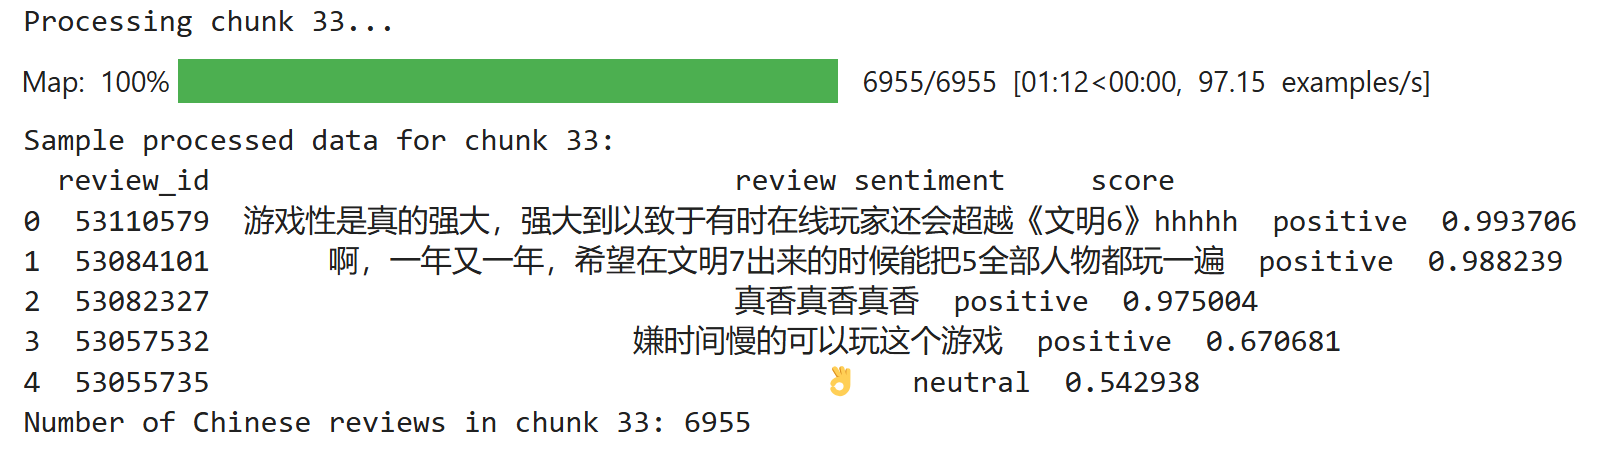

In [7]:
Image(filename="images/Screenshot 2024-10-26 180845.png")

Traslation in English of the same chunk

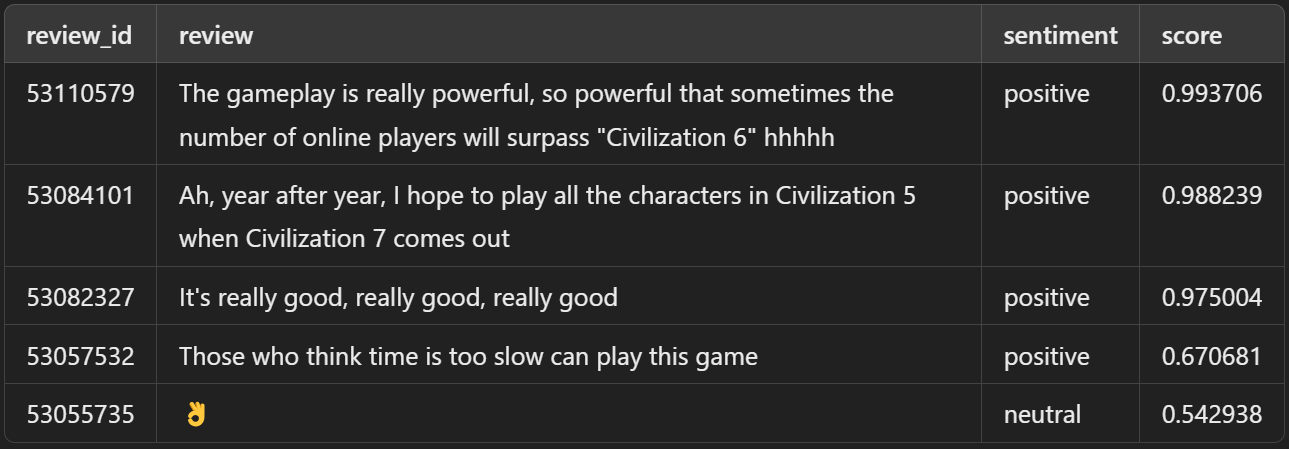

In [3]:
Image(filename="images/Screenshot 2024-10-30 154259.png")

Sample of selected reviews to see how the model react to various scenario

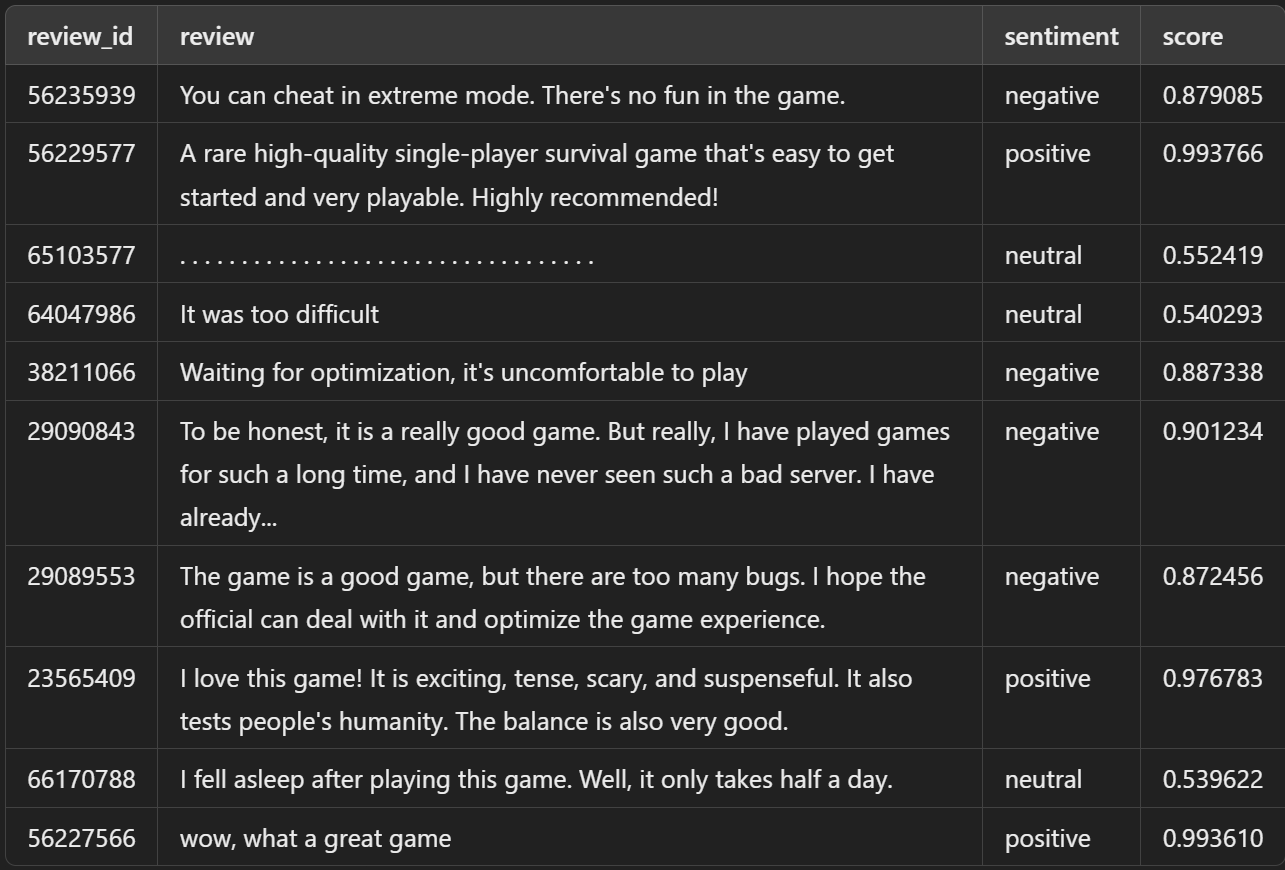

In [5]:
Image(filename="images/Screenshot 2024-10-30 154156.png")

# Russian sentiment Analysis

I chose DeepPavlov for sentiment analysis as it’s trained on Russian social media posts, providing robust handling of Russian-specific language nuances. The model supports a 5-class classification, allowing it to detect nonsensical or out-of-context reviews that other models may incorrectly classify as neutral. Trained on the largest available dataset for Russian sentiment, it incorporates techniques to diversify data, minimizing overfitting and improving accuracy. The model achieved an F1 score of 0.73, a strong result for multiclass sentiment classification. More details are available in the [official paper](http://www.cs.uml.edu/~arum/publications/Rogers_Romanov_Rumshisky_COLING2018_RuSentiment.pdf).

First, I want to clarify the challenges I faced during this section. After previous analyses, I ran out of GPU usage on Kaggle, and unfortunately, none of my teammates or friends from Naples had access to a GPU either. It appears that only users who regularly participate in Kaggle competitions are allowed continuous GPU access, which required me to switch to Colab.

However, Colab has stricter limitations on GPU usage. Official documentation states a 12-hour weekly limit, though actual usage varies depending on how intensively the resources are used. Ultimately, I could only run code for less than 2 hours at a time, which wasn’t enough to complete my analysis in one session. To work around this, I saved each chunk as a checkpoint on Google Drive and cycled through different accounts to maximize GPU availability. In total, I created and switched between four different accounts to complete the task.

In [16]:
file_path = '/root/.cache/kagglehub/datasets/najzeko/steam-reviews-2021/versions/1/steam_reviews.csv'

In [ ]:
!pip install deeppavlov

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.2/152.2 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.7/492.7 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.4/222.4 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7

In [ ]:
from deeppavlov import build_model, configs

# Load the DeepPavlov Russian sentiment analysis model
model = build_model(configs.classifiers.rusentiment_bert, download=True, install=True) # config allow use to use the GPU

2024-10-29 19:24:18.27 INFO in 'deeppavlov.core.data.utils'['utils'] at line 97: Downloading from http://files.deeppavlov.ai/v1/classifiers/rusentiment_bert/rusentiment_bert_torch.tar.gz to /root/.deeppavlov/models/classifiers/rusentiment_bert_torch.tar.gz
INFO:deeppavlov.core.data.utils:Downloading from http://files.deeppavlov.ai/v1/classifiers/rusentiment_bert/rusentiment_bert_torch.tar.gz to /root/.deeppavlov/models/classifiers/rusentiment_bert_torch.tar.gz
100%|██████████| 1.34G/1.34G [01:13<00:00, 18.4MB/s]
2024-10-29 19:25:32.112 INFO in 'deeppavlov.core.data.utils'['utils'] at line 284: Extracting /root/.deeppavlov/models/classifiers/rusentiment_bert_torch.tar.gz archive into /root/.deeppavlov/models/classifiers/rusentiment_bert_torch
INFO:deeppavlov.core.data.utils:Extracting /root/.deeppavlov/models/classifiers/rusentiment_bert_torch.tar.gz archive into /root/.deeppavlov/models/classifiers/rusentiment_bert_torch
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_down

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual

In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available()) #check GPU usage

In [24]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


In [34]:
import torch

chunksize = 50000
sub_batch_size = 500
torch.cuda.empty_cache()  # Clear any unused memory allocations before starting

# There was a lot of variance on the distribution of the russian review, some chunk had just a few while some had a lot, that's why I had to divide in sub batch so that for each chunk I could analyze a fixed number of review that the GPU could handle
def deeppavlov_batch_sentiment_analysis(texts, sub_batch_size=sub_batch_size):
    print(f"[DEBUG] Starting batch sentiment analysis for {len(texts)} texts.")

    texts = [text if pd.notna(text) else 'neutral' for text in texts]

    sentiments = []

    # Process texts in sub-batches:
    for start in range(0, len(texts), sub_batch_size):
        end = start + sub_batch_size
        sub_batch = texts[start:end]
        print(f"[DEBUG] Processing sub-batch with {len(sub_batch)} texts.")

        sub_batch_results = model(sub_batch) # perform sentiment
        sentiments.extend([result.lower() for result in sub_batch_results])

        torch.cuda.empty_cache()  # Free GPU memory after each iteration, if not after a few batch it run out of memory

    return sentiments

# As previously said I had to introduce checkpoints since I could not complete the run in one session
def save_checkpoint(data, chunk_index, output_dir='/content/drive/MyDrive/checkpoints-20241029T162236Z-001/checkpoints'):
    os.makedirs(output_dir, exist_ok=True)
    checkpoint_path = f"{output_dir}processed_data_checkpoint_{chunk_index}.csv"
    data.to_csv(checkpoint_path, index=False)
    print(f"[DEBUG] Checkpoint saved at {checkpoint_path}")

def load_latest_checkpoint(output_dir='/content/drive/MyDrive/checkpoints-20241029T162236Z-001/checkpoints'):
    checkpoint_files = glob.glob(os.path.join(output_dir, 'processed_data_checkpoint_*.csv'))
    if not checkpoint_files:
        return None, 0  # No checkpoints found

    latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
    print(f"[DEBUG] Loading from checkpoint: {latest_checkpoint}")
    resumed_data = pd.read_csv(latest_checkpoint)
    resumed_index = int(latest_checkpoint.split('_')[-1].split('.')[0])

    return resumed_data, resumed_index

def process_and_save_workflow(file_path, output_path, chunksize=chunksize):
    total_start_time = time.time()

    if not os.path.exists(output_path):
        with open(output_path, mode='w', newline='', encoding='utf-8') as f_out:
            writer = csv.writer(f_out)
            writer.writerow(['review_id', 'text', 'sentiment'])

    # Load the latest checkpoint if available
    resumed_data, start_chunk = load_latest_checkpoint()

    # Debug
    if start_chunk > 0:
        print(f"[DEBUG] Resuming from checkpoint at chunk {start_chunk}. Processing will start from chunk {start_chunk + 1}.")
    else:
        print("[DEBUG] No checkpoint found. Starting from the beginning.")

    # Process each chunk using the preloaded model
    for i, chunk in enumerate(pd.read_csv(file_path, chunksize=chunksize, encoding='utf-8', quoting=csv.QUOTE_MINIMAL, escapechar='\\', on_bad_lines='skip', low_memory=False, dtype=str)):
        if i < start_chunk:
            continue  # Skip processed chunks

        print(f"\n[DEBUG] Processing chunk {i + 1}")
        try:
            russian_reviews = chunk[chunk['language'] == 'russian'].copy()

            if not russian_reviews.empty: # chunk must contain at least one russian review
                start_time = time.time()
                russian_reviews['sentiment'] = deeppavlov_batch_sentiment_analysis(russian_reviews['review'].tolist())
                print(f"[DEBUG] Sentiment analysis completed in {time.time() - start_time:.2f} seconds for chunk {i + 1}")

                sentiment_data = russian_reviews[['review_id', 'review', 'sentiment']]

                # Debug on CSV file
                print(f"[DEBUG] Sentiment data columns: {sentiment_data.columns}")
                print(f"[DEBUG] First few rows of sentiment data:\n{sentiment_data.head()}")
                sentiment_data = sentiment_data.astype(str)
                print(f"[DEBUG] Data types after conversion: {sentiment_data.dtypes}")

                # Save to CSV
                sentiment_data.to_csv(output_path, mode='a', header=False, index=False, encoding='utf-8')

                # Save checkpoint
                save_checkpoint(sentiment_data, i + 1)  # Save after each chunk
        except Exception as e:
            print(f"[ERROR] An error occurred while processing chunk {i + 1}: {e}")

    total_time = time.time() - total_start_time
    print(f"\n=== Total time taken for processing and saving all chunks: {total_time:.2f} seconds ===")
# Execute
output_path = 'Russian_steam_reviews.csv'
process_and_save_workflow(file_path, output_path)

[DEBUG] Loading from checkpoint: /content/drive/MyDrive/checkpoints-20241029T162236Z-001_Ang/checkpoints/processed_data_checkpoint_335.csv
[DEBUG] Resuming from checkpoint at chunk 335. Processing will start from chunk 336.

[DEBUG] Processing chunk 336
[DEBUG] Starting batch sentiment analysis for 2308 texts.
[DEBUG] Processing sub-batch with 500 texts.
[DEBUG] Processing sub-batch with 500 texts.
[DEBUG] Processing sub-batch with 500 texts.
[DEBUG] Processing sub-batch with 500 texts.
[DEBUG] Processing sub-batch with 308 texts.
[DEBUG] Sentiment analysis completed in 8.43 seconds for chunk 336
[DEBUG] Sentiment data columns: Index(['review_id', 'review', 'sentiment'], dtype='object')
[DEBUG] First few rows of sentiment data:
         review_id                                             review  \
16750008  75874523                  The worst quests in game history.   
16750044  75833016  Как по мне очень скучная игра, ожидания были к...   
16750176  75692914                         

This was our fourth session, processing around 100 chunks each time, which was the maximum our GPU could handle. For context, running a single chunk on the CPU took nearly 30 minutes, so using the GPU method was essential to submit the Assigment on time.

In [40]:
# Since everytime we runned up of GPU our session was interrupted, I didn't manage to save the cumulative output, so I just had to merge every checkpointsù
directory_path = '/content/drive/MyDrive/checkpoints-20241029T162236Z-001_Ang/checkpoints'
all_files = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith('.csv')]
final_data = pd.DataFrame()

for file in all_files:
    data = pd.read_csv(file)
    final_data = pd.concat([final_data, data], ignore_index=True)

final_data.to_csv('/content/drive/MyDrive/final_combined_file.csv', index=False)

print("Final file created successfully at '/content/drive/MyDrive/final_combined_file.csv'")

Final file created successfully at '/content/drive/MyDrive/final_combined_file.csv'


# Sentimental Analysis

We can finally start with our final analysis

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/english-sentiment-on-steam-2021/english_sentiment_with_review.csv
/kaggle/input/steam-sentiment-schinese/sentiment_values_schinese.csv
/kaggle/input/russian-sentiment-analysis/final_combined_file.csv
/kaggle/input/steam-reviews-2021/steam_reviews.csv
/kaggle/input/steam-sentiment-eng/sentiment_reviews_eng.csv


In [2]:
file_path = '/kaggle/input/steam-reviews-2021/steam_reviews.csv'
eng_path = '/kaggle/input/english-sentiment-on-steam-2021/english_sentiment_with_review.csv'
sch_path = '/kaggle/input/steam-sentiment-schinese/sentiment_values_schinese.csv'
rus_path = '/kaggle/input/russian-sentiment-analysis/final_combined_file.csv'

Loading this big dataset required some tecniques to manage the memory usage. The easier option was to load chunk by chunk but since the questions were really straightforward and I didn't need the 'review' column (the heaviest one) anymore (except for one operation that we'll see later) I am gonna just load only the columns that I need using multiprocessing to maximize the use of each core of the GPU, making it more efficent.

In [3]:
import pandas as pd
import multiprocessing as mp
import os

# Load CSV files
def load_csv_initial(path, usecols, dtype, name, language):
    print(f"Loading {name} dataset from {path}")
    df = pd.read_csv(path, usecols=usecols, dtype=dtype)
    df['language'] = language  #add  language column appending value depending by dataset used
    print(f"Finished loading {name} dataset with {len(df)} rows and added language: {language}")
    return df

# Load the datasets in parallel
def parallel_load():
    with mp.Pool(3) as pool:
        results = pool.starmap(load_csv_initial, [
            (file_path, ['review_id'], {'review_id': str}, 'original', None),
            (eng_path, ['review_id', 'review', 'sentiment'], {'review_id': str, 'review': str, 'sentiment': str}, 'English sentiments', 'English'),
            (sch_path, ['review_id', 'review', 'sentiment'], {'review_id': str, 'review': str, 'sentiment': str}, 'Simplified Chinese sentiments', 'Simplified Chinese'),
            (rus_path, ['review_id', 'review', 'sentiment'], {'review_id': str, 'review': str, 'sentiment': str}, 'Russian sentiments', 'Russian'),
        ])
    return results

# Load the data
review_ids, eng_sentiments, sch_sentiments, rus_sentiments = parallel_load()

print("Concatenating sentiment datasets")
# we use review_id as foreign key to retrieve the info needed from original dataset, skipping everything else
sentiments = pd.concat([eng_sentiments, sch_sentiments, rus_sentiments]).drop_duplicates(subset='review_id')
print(f"Concatenated dataset has {len(sentiments)} rows")

print("Merging datasets")
filtered_reviews = pd.merge(
    review_ids[['review_id']],
    sentiments[['review_id', 'review', 'sentiment', 'language']],  
    on='review_id',
    how='inner'
)
print(f"Filtered dataset has {len(filtered_reviews)} rows")

print("Displaying first few rows of the filtered dataset")
print(filtered_reviews.head())


Loading English sentiments dataset from /kaggle/input/english-sentiment-on-steam-2021/english_sentiment_with_review.csvLoading Simplified Chinese sentiments dataset from /kaggle/input/steam-sentiment-schinese/sentiment_values_schinese.csvLoading original dataset from /kaggle/input/steam-reviews-2021/steam_reviews.csv


Finished loading Simplified Chinese sentiments dataset with 3762149 rows and added language: Simplified Chinese
Loading Russian sentiments dataset from /kaggle/input/russian-sentiment-analysis/final_combined_file.csv
Finished loading Russian sentiments dataset with 2347907 rows and added language: Russian
Finished loading English sentiments dataset with 9632292 rows and added language: English
Finished loading original dataset with 21747371 rows and added language: None
Concatenating sentiment datasets
Concatenated dataset has 15643702 rows
Merging datasets
Filtered dataset has 15742340 rows
Displaying first few rows of the filtered dataset
  review_id                   

In [4]:
# Russian model is a 5 class classifier, that labeled some reviews as skippable or out of context, so we remove those rows
filtered_reviews = filtered_reviews[~filtered_reviews['sentiment'].isin(['skip', 'speech'])]
filtered_reviews

review_id                                             review  \
0         85185598                            不玩此生遗憾，RPG游戏里的天花板，太吸引人了   
1         85185250                                 拔DIAO无情打桩机--杰洛特!!!   
2         85185111                                              巫师3NB   
3         85184605  One of the best RPG's of all time, worthy of a...   
4         85184287                                                 大作   
...            ...                                                ...   
15742335  65645125                                         Holy balls   
15742336  65645115  A tripod thing bears down on you, it looks imm...   
15742337  65645100             Honestly this is the best vr game ever   
15742338  65645066  Smooth turning is not working right now.\nIt a...   
15742339  65644930  WMR加载中闪退，无法进入游戏\nWMR Flashback in Load，cant pl...   

         sentiment            language  
0         positive  Simplified Chinese  
1         positive  Simplified Chinese  
2         positive  Simplified Chinese  
3         positive             English  
4         positive  Simplified Chinese  
...            ...                 ...  
15742335   neutral             English  
15742336  positive             English  
15742337  positive             English  
15742338  positive             English  
15742339  positive  Simplified Chinese  

[15594238 rows x 4 columns]

In [5]:
filtered_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15594238 entries, 0 to 15742339
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   review_id  object
 1   review     object
 2   sentiment  object
 3   language   object
dtypes: object(4)
memory usage: 594.9+ MB


In [6]:
# I thought about using the lenght of the review as an addional feature to provide more meaningfull information in our analysis
# So we create this new variable with a little bit of feature engineering

# we need to use different methods to retrieve the lenght of the review for each langauge and take into consideration the nature of the langauge (the same phrase in english require more characters for instance )

def calculate_review_length(review, language):
    if pd.isna(review):
        return 0  
    if language == 'english':
        return len(re.findall(r'[a-zA-Z]', review)) #only characters, we do not count everything else
    elif language == 'chinese':
        return len(re.findall(r'[\u4e00-\u9fff]', review)) # we use Schinese ASCII
    elif language == 'russian':
        return len(re.findall(r'[\u0400-\u04FF]', review)) # russian ASCII
    else:
        return len(review)

filtered_reviews['review_length'] = filtered_reviews.apply(
    lambda row: calculate_review_length(row['review'], row['language']), axis=1
)
filtered_reviews_l = filtered_reviews.drop(columns=['review'])
print(filtered_reviews_l.head())


  review_id sentiment            language  review_length
0  85185598  positive  Simplified Chinese             23
1  85185250  positive  Simplified Chinese             18
2  85185111  positive  Simplified Chinese              5
3  85184605  positive             English             59
4  85184287  positive  Simplified Chinese              2


# What is the distribution of sentiment across all reviews?

### Distribution in general

In [7]:
sentiment_distribution = filtered_reviews['sentiment'].value_counts()
sentiment_distribution

sentiment
positive    10052101
negative     2805061
neutral      2737068
Name: count, dtype: int64

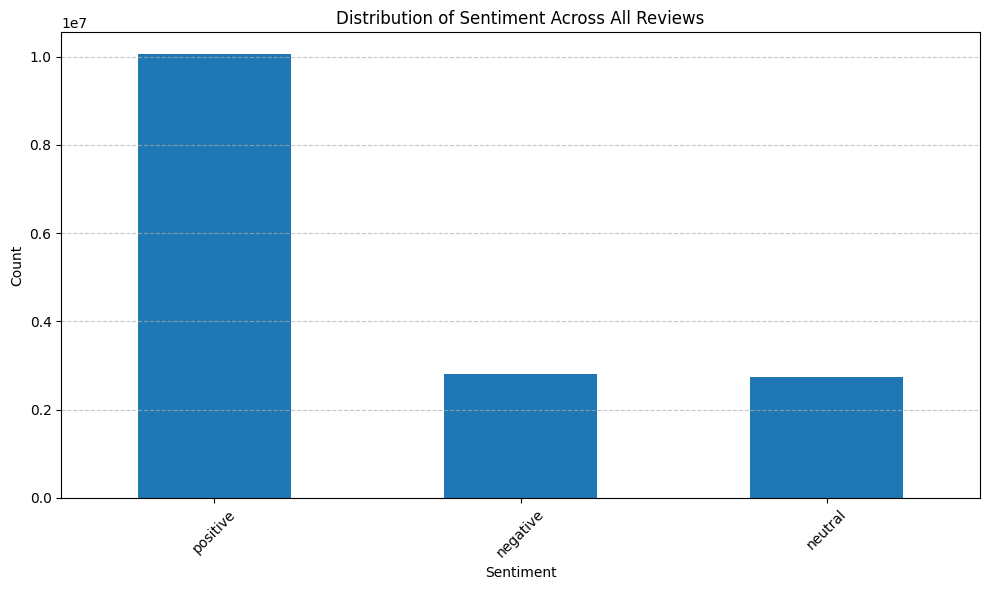

In [8]:
# Plot 
plt.figure(figsize=(10, 6))
sentiment_distribution = filtered_reviews['sentiment'].value_counts()
sentiment_distribution.plot(kind='bar')
plt.title('Distribution of Sentiment Across All Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [9]:
sentiment_percentage = (sentiment_distribution / sentiment_distribution.sum()) * 100
sentiment_percentage

sentiment
positive    64.460387
negative    17.987813
neutral     17.551800
Name: count, dtype: float64

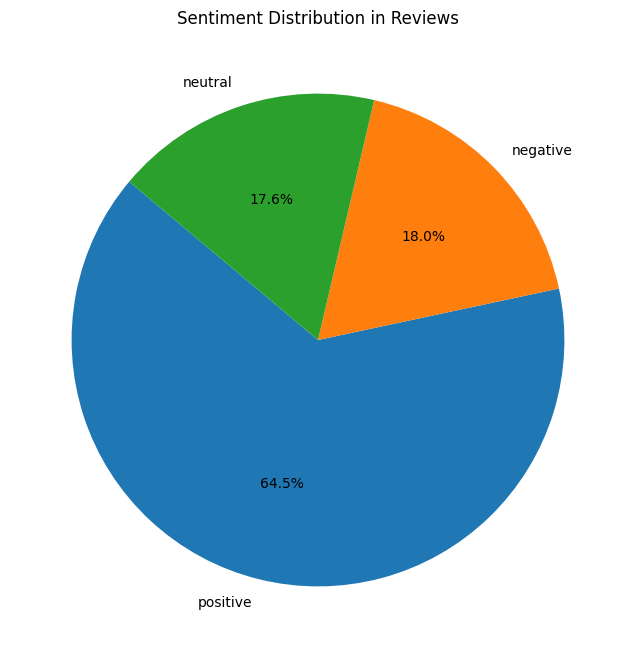

In [10]:
plt.figure(figsize=(8, 8))
sentiment_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution in Reviews')
plt.ylabel('')
plt.show()


### Distribution by Language

<Figure size 1200x600 with 0 Axes>

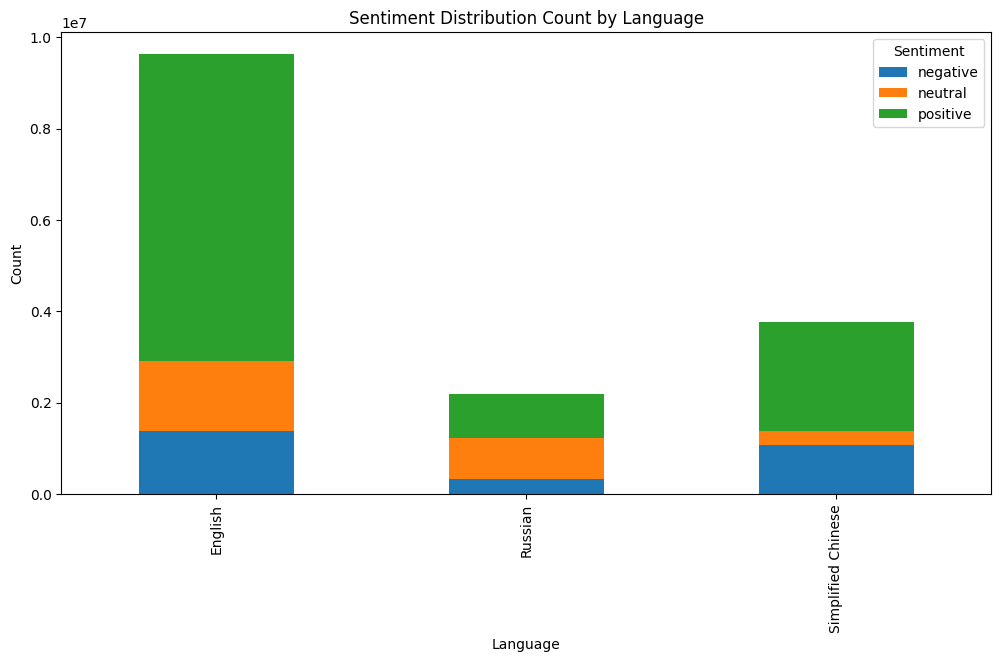

<Figure size 1200x600 with 0 Axes>

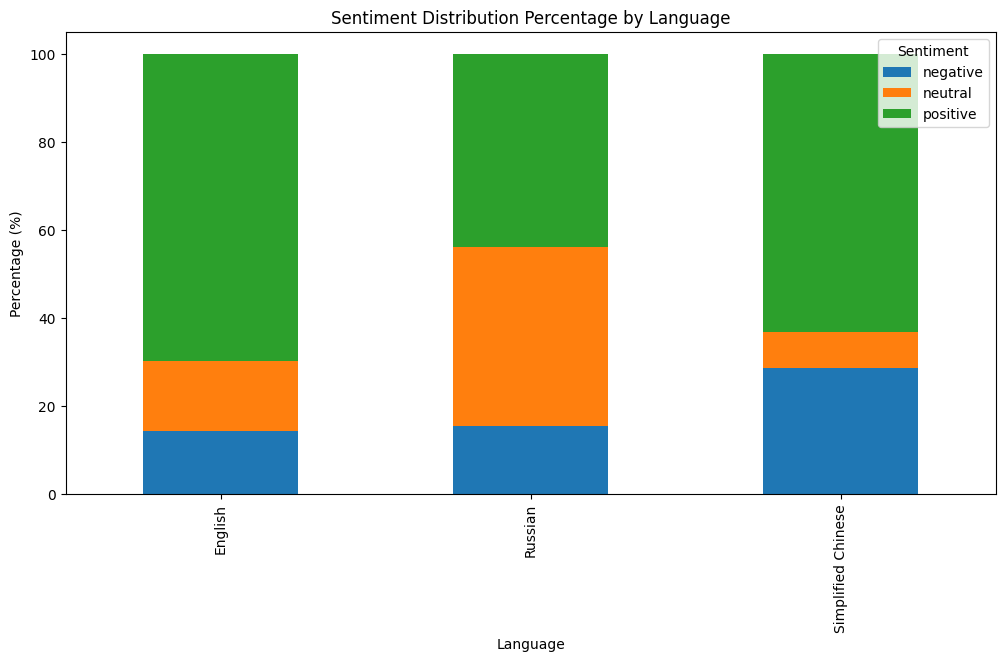

In [11]:
# by language
sentiment_counts = filtered_reviews.groupby(['language', 'sentiment']).size().unstack().fillna(0)
sentiment_percentage = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

# Count
plt.figure(figsize=(12, 6))
sentiment_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Sentiment Distribution Count by Language')
plt.xlabel('Language')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

# Percentage
plt.figure(figsize=(12, 6))
sentiment_percentage.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Sentiment Distribution Percentage by Language')
plt.xlabel('Language')
plt.ylabel('Percentage (%)')
plt.legend(title='Sentiment')
plt.show()


### Distribution over time

In [12]:
# general loading function
def load_csv(path, usecols, dtype, name):
    print(f"Loading {name} dataset from {path}")
    df = pd.read_csv(path, usecols=usecols, dtype=dtype)
    print(f"Finished loading {name} dataset with {len(df)}")
    return df

In [13]:
def load_timestamp_csv():
    with mp.Pool(1) as pool:
        timestamp_data = pool.starmap(load_csv, [
            (file_path, ['review_id', 'timestamp_created'], {'review_id': str, 'timestamp_created': str}, 'timestamp_created dataset')
        ])
    return timestamp_data[0]

timestamp_df = load_timestamp_csv()
print("Displaying first few rows of the timestamp_df dataset")
print(timestamp_df.head())
print("Merging timestamp_created dataset with filtered reviews")
merged_df = pd.merge(timestamp_df, filtered_reviews_l, on="review_id", how="inner")
merged_df['timestamp_created'] = pd.to_numeric(merged_df['timestamp_created'], errors='coerce')
merged_df['timestamp_created'] = pd.to_datetime(merged_df['timestamp_created'], unit = 's')


Loading timestamp_created dataset dataset from /kaggle/input/steam-reviews-2021/steam_reviews.csv
Finished loading timestamp_created dataset dataset with 21747371
Displaying first few rows of the timestamp_df dataset
  review_id timestamp_created
0  85185598        1611381629
1  85185250        1611381030
2  85185111        1611380800
3  85184605        1611379970
4  85184287        1611379427
Merging timestamp_created dataset with filtered reviews


In [14]:
merged_df.head()

review_id   timestamp_created sentiment            language  review_length
0  85185598 2021-01-23 06:00:29  positive  Simplified Chinese             23
1  85185250 2021-01-23 05:50:30  positive  Simplified Chinese             18
2  85185111 2021-01-23 05:46:40  positive  Simplified Chinese              5
3  85184605 2021-01-23 05:32:50  positive             English             59
4  85184287 2021-01-23 05:23:47  positive  Simplified Chinese              2

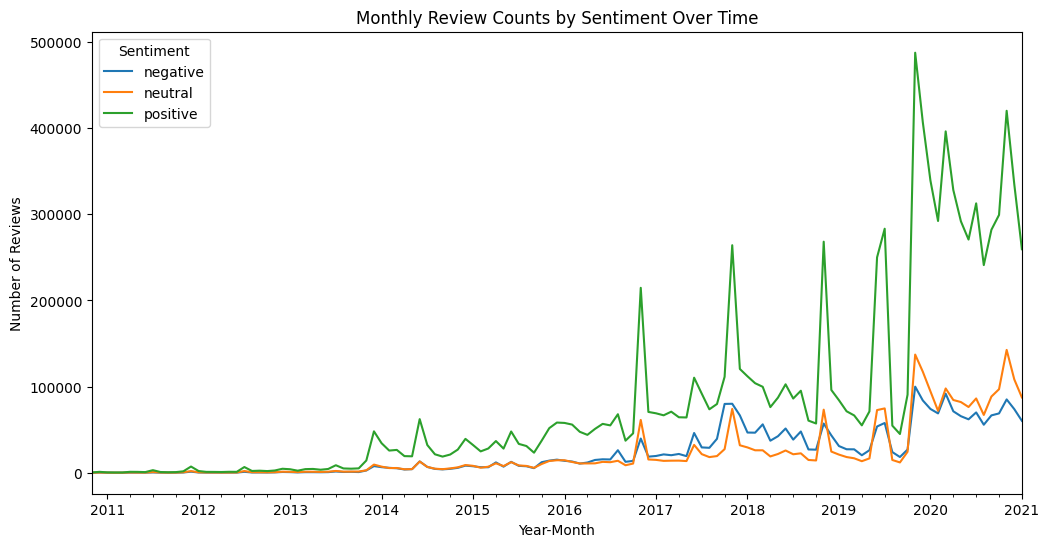

In [15]:
merged_df['year_month'] = merged_df['timestamp_created'].dt.to_period('M')
monthly_sentiment_counts = merged_df.groupby(['year_month', 'sentiment']).size().unstack(fill_value=0)

# Plot time series
plt.figure(figsize=(12, 6))
monthly_sentiment_counts.plot(kind='line', ax=plt.gca())
plt.title('Monthly Review Counts by Sentiment Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')
plt.show()

The distribution shows first of all the invertion of trend between the number of negative and neutral review: during Covid time more or less, the third quarter of 2019, we had more neutral and negative reviews going forward, this explain also the lack of reliability of the Steam Review lately. 

The plot shows a peak at the end of each new year, probably due to the introduction of new games between the start of Schools and Christmas time. Nonetheless the general number of review goes up, there are majority of positive review, probably due to the hype of this new games, that goes straight to normal after new Year.

### By language

In [16]:
monthly_sentiment_counts = merged_df.groupby(['year_month', 'language', 'sentiment']).size().unstack(fill_value=0)
# We have to normnalize the X and Y axis to allow a more clear visualizzation
filtered_monthly_counts = {}
languages = monthly_sentiment_counts.index.get_level_values('language').unique()

for language in languages:
    language_data = monthly_sentiment_counts.xs(language, level='language')
    first_month_with_reviews = language_data[(language_data > 0).any(axis=1)].index.min()
    filtered_monthly_counts[language] = language_data[language_data.index >= first_month_with_reviews]
    
for language, data in filtered_monthly_counts.items():
    filtered_monthly_counts[language].index = filtered_monthly_counts[language].index.to_timestamp()


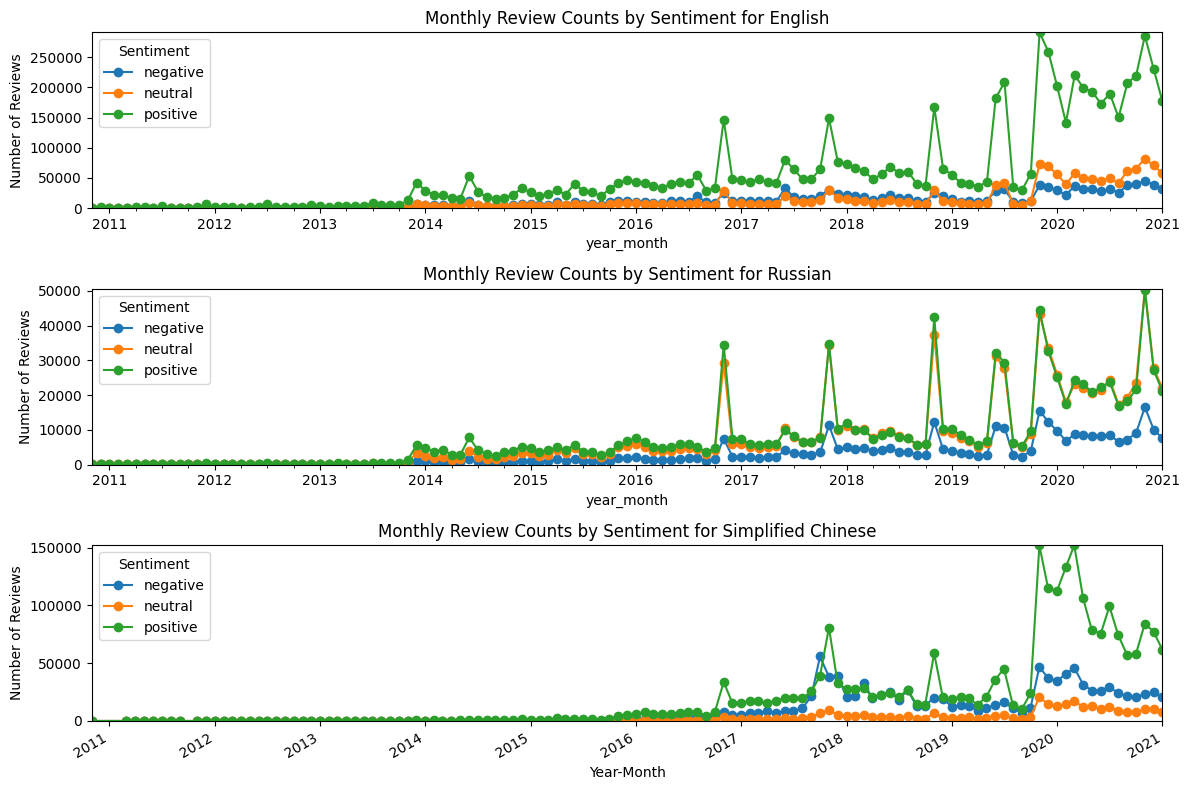

In [17]:
# Plot
fig, axes = plt.subplots(len(languages), 1, figsize=(12, 8), sharex=False, sharey=False)

for i, language in enumerate(languages):
    ax = axes[i]
    filtered_data = filtered_monthly_counts[language]
    
    filtered_data.plot(kind='line', ax=ax, marker='o')
    
    ax.set_xlim(filtered_data.index.min(), filtered_data.index.max())
    ax.set_ylim(0, filtered_data.max().max()) 
    
    ax.set_title(f'Monthly Review Counts by Sentiment for {language}')
    ax.set_ylabel('Number of Reviews')
    if i == len(languages) - 1:
        ax.set_xlabel('Year-Month')
    ax.legend(title='Sentiment')

plt.tight_layout()
plt.show()


### Distribution by Game

In [18]:
def load_app_name_csv():
    with mp.Pool(1) as pool:
        app_name_data = pool.starmap(load_csv, [
            (file_path, ['review_id', 'app_name'], {'review_id': str, 'app_name': str}, 'app_name dataset')
        ])
    return app_name_data[0]

app_name_df = load_app_name_csv()
print("Merging app_name dataset with filtered reviews")
final_reviews_game = pd.merge(filtered_reviews_l, app_name_df, on='review_id', how='inner')


Loading app_name dataset dataset from /kaggle/input/steam-reviews-2021/steam_reviews.csv
Finished loading app_name dataset dataset with 21747371
Merging app_name dataset with filtered reviews


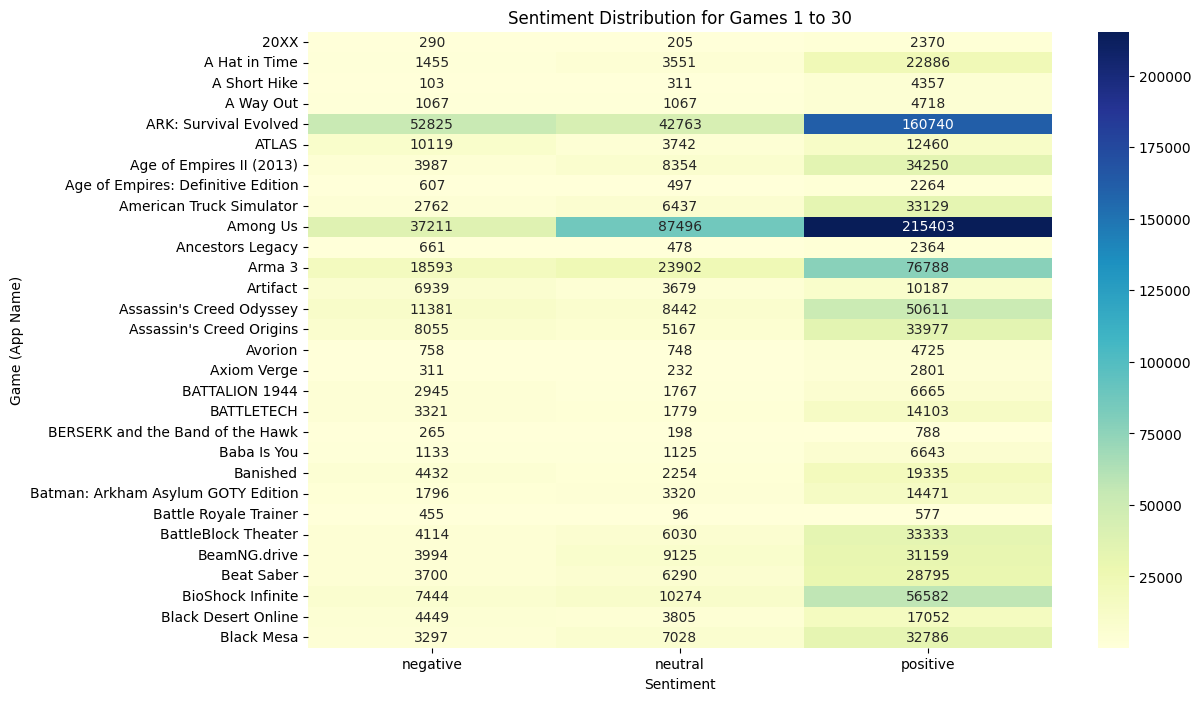

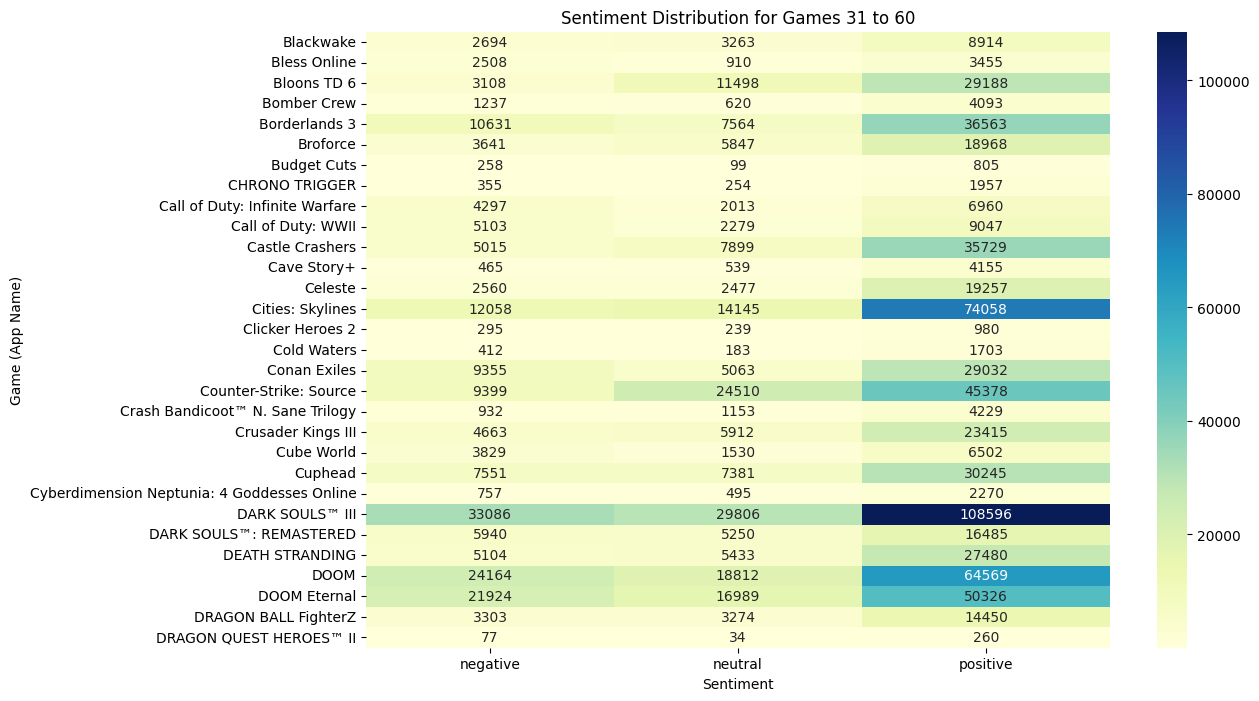

/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 40857 (\N{CJK UNIFIED IDEOGRAPH-9F99}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 23830 (\N{CJK UNIFIED IDEOGRAPH-5D16}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 40857 (\N{CJK UNIFIED IDEOGRAPH-9F99}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23830 (\N{CJK UNIFIED IDEOGRAPH-5D16}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


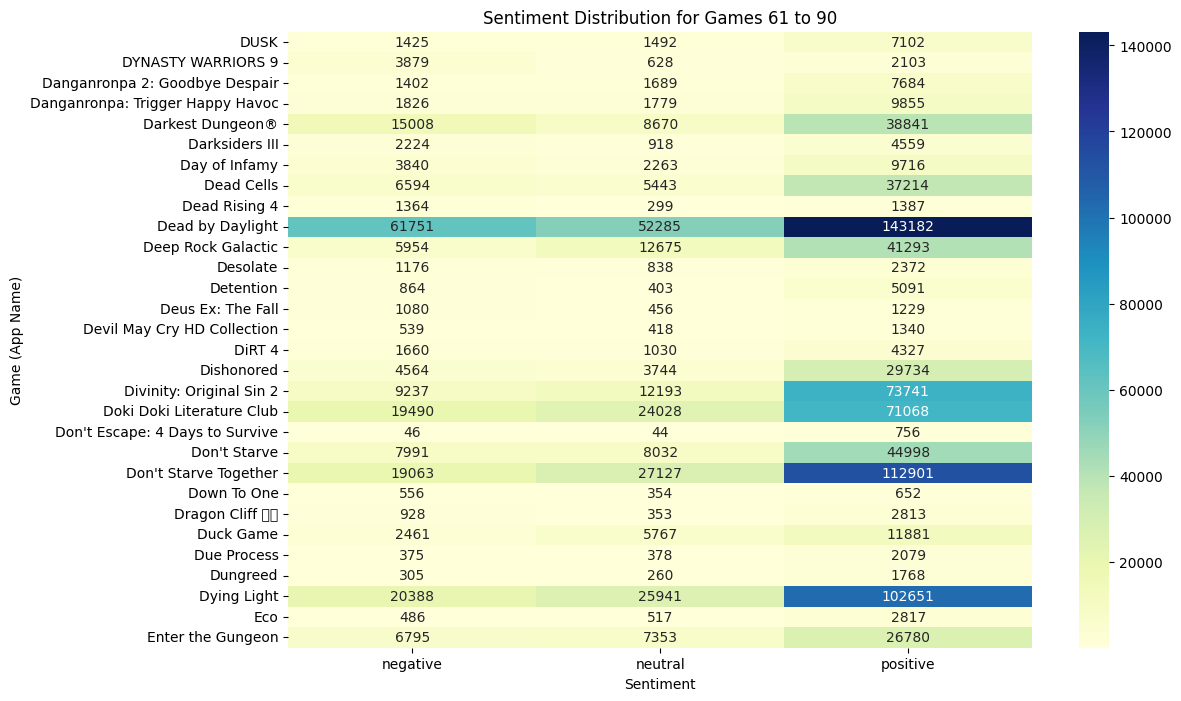

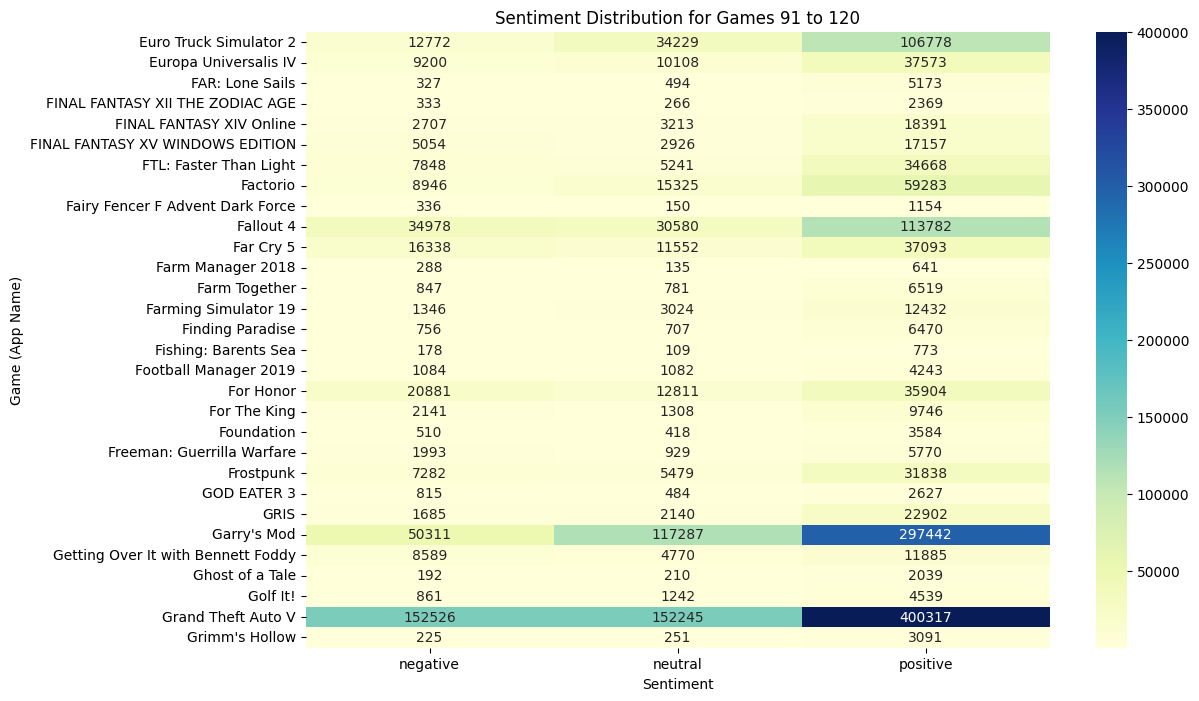

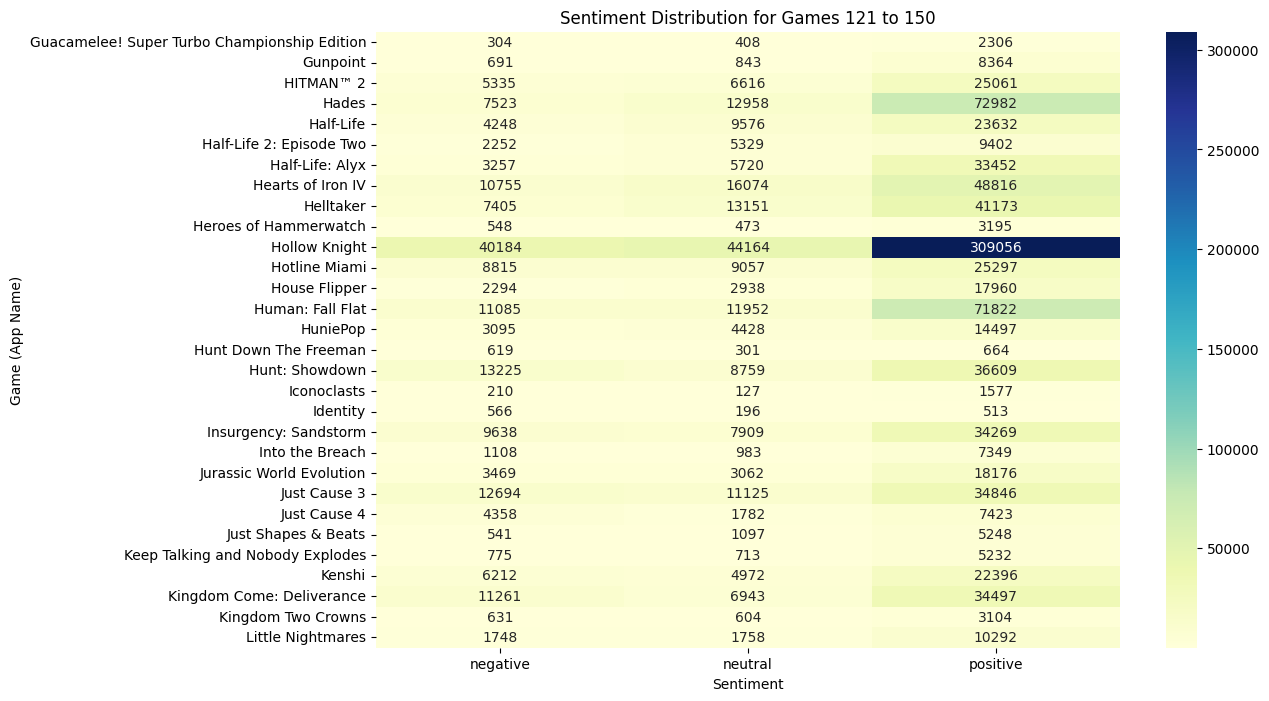

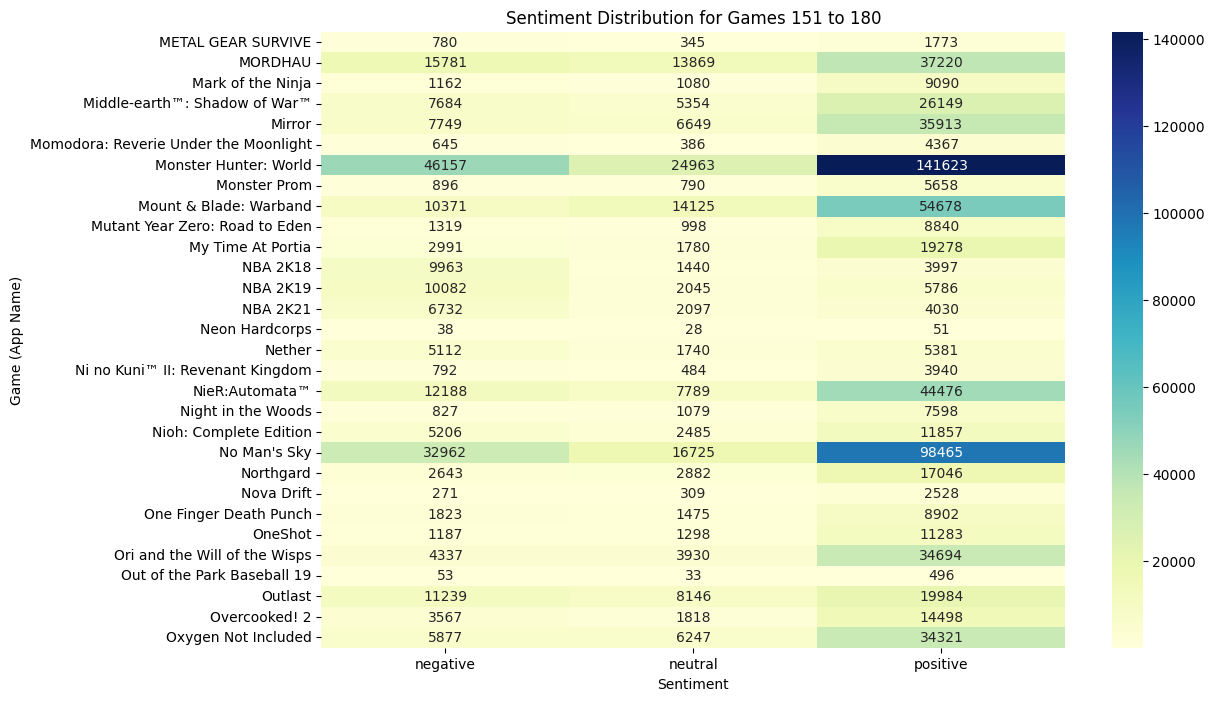

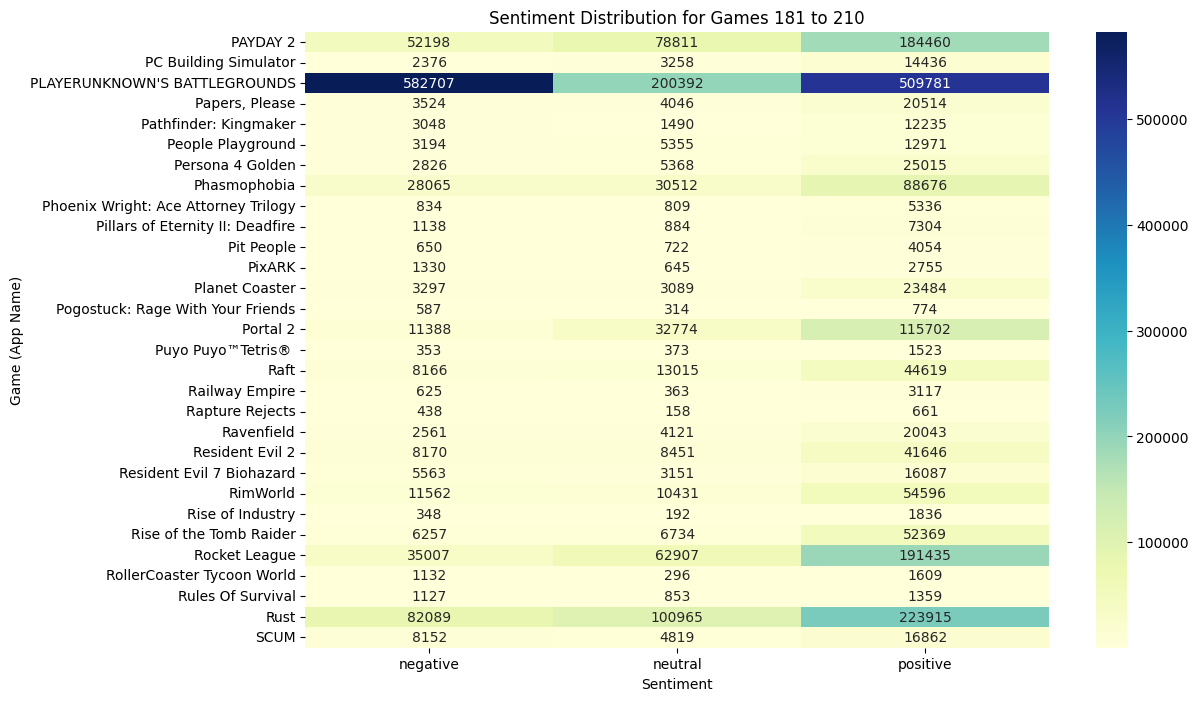

/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 65290 (\N{FULLWIDTH ASTERISK}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65290 (\N{FULLWIDTH ASTERISK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


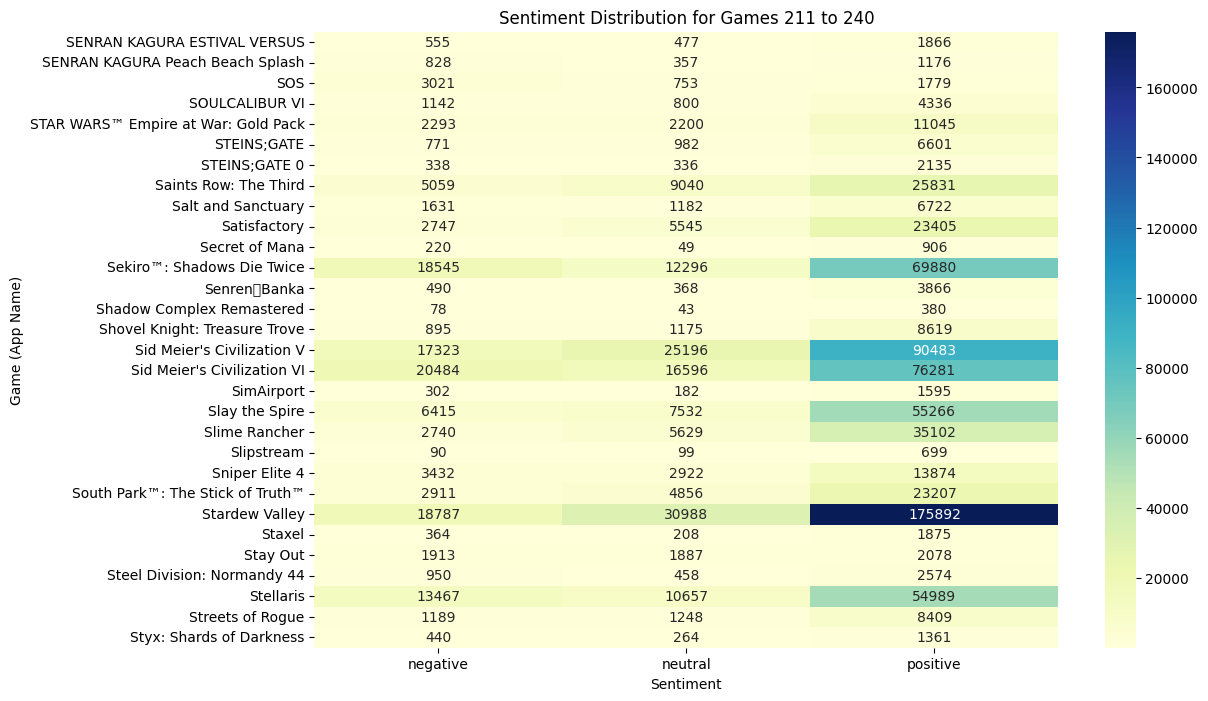

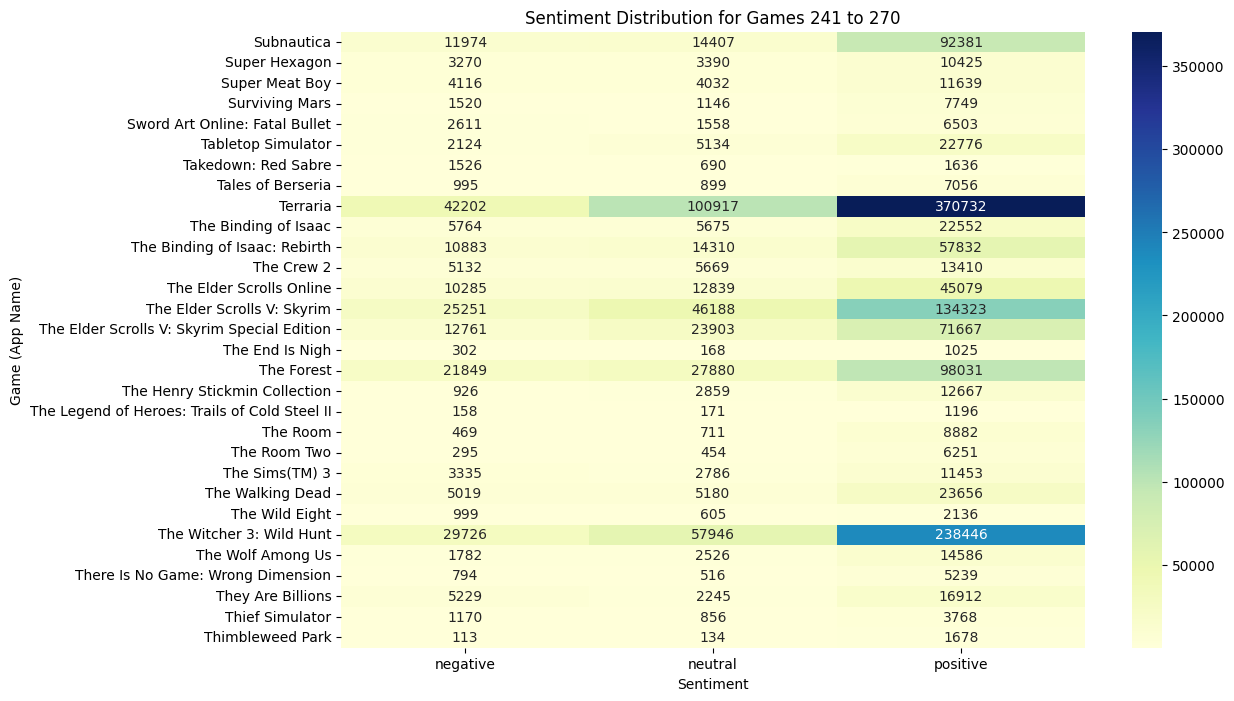

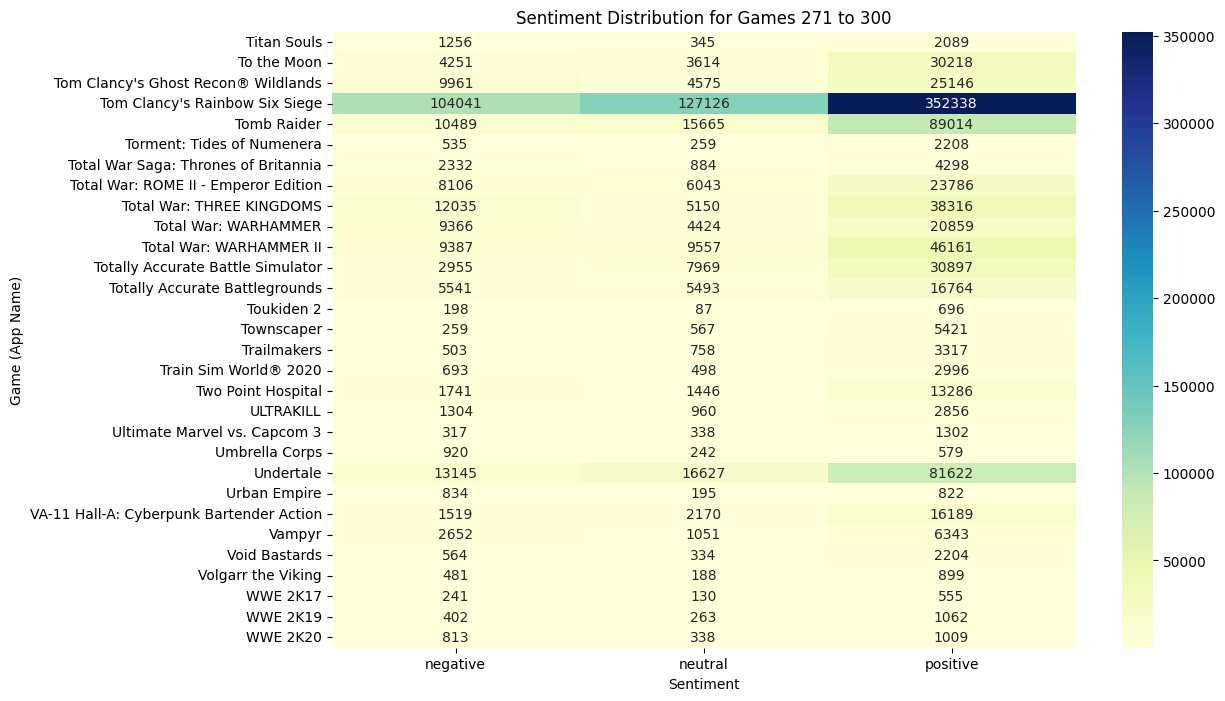

/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 19977 (\N{CJK UNIFIED IDEOGRAPH-4E09}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 22269 (\N{CJK UNIFIED IDEOGRAPH-56FD}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 32676 (\N{CJK UNIFIED IDEOGRAPH-7FA4}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 33521 (\N{CJK UNIFIED IDEOGRAPH-82F1}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 20256 (\N{CJK UNIFIED IDEOGRAPH-4F20}) missing from current font.
  fig.canvas.draw()
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 19977 (\N{CJK UNIFIED IDEOGRAPH-4E09}) missing from current font.
  fig.canvas.

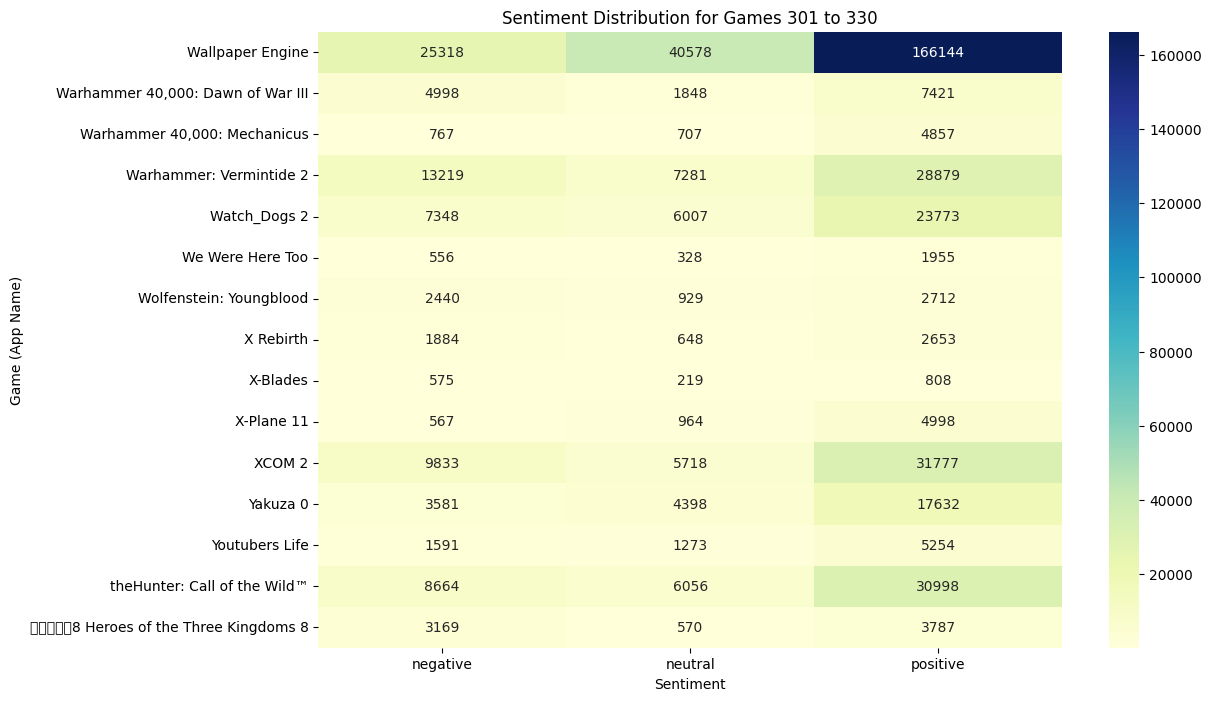

In [19]:
import math

games_per_section = 30  
num_sections = math.ceil(final_reviews_game['app_name'].nunique() / games_per_section)

sentiment_counts = final_reviews_game.pivot_table(
    index='app_name',
    columns='sentiment',
    aggfunc='size',
    fill_value=0
)

all_games = sentiment_counts.index.tolist()

# Plot each section
for i in range(num_sections):
    section_games = all_games[i * games_per_section:(i + 1) * games_per_section]
    section_data = sentiment_counts.loc[section_games]

    plt.figure(figsize=(12, 8))
    sns.heatmap(section_data, cmap="YlGnBu", annot=True, fmt="d")
    plt.title(f"Sentiment Distribution for Games {i * games_per_section + 1} to {(i + 1) * games_per_section}")
    plt.xlabel("Sentiment")
    plt.ylabel("Game (App Name)")
    plt.show()



The warning is plt that can't render chinese character, no need to address this issue

### Relationship between Sentiment and Review Lenght

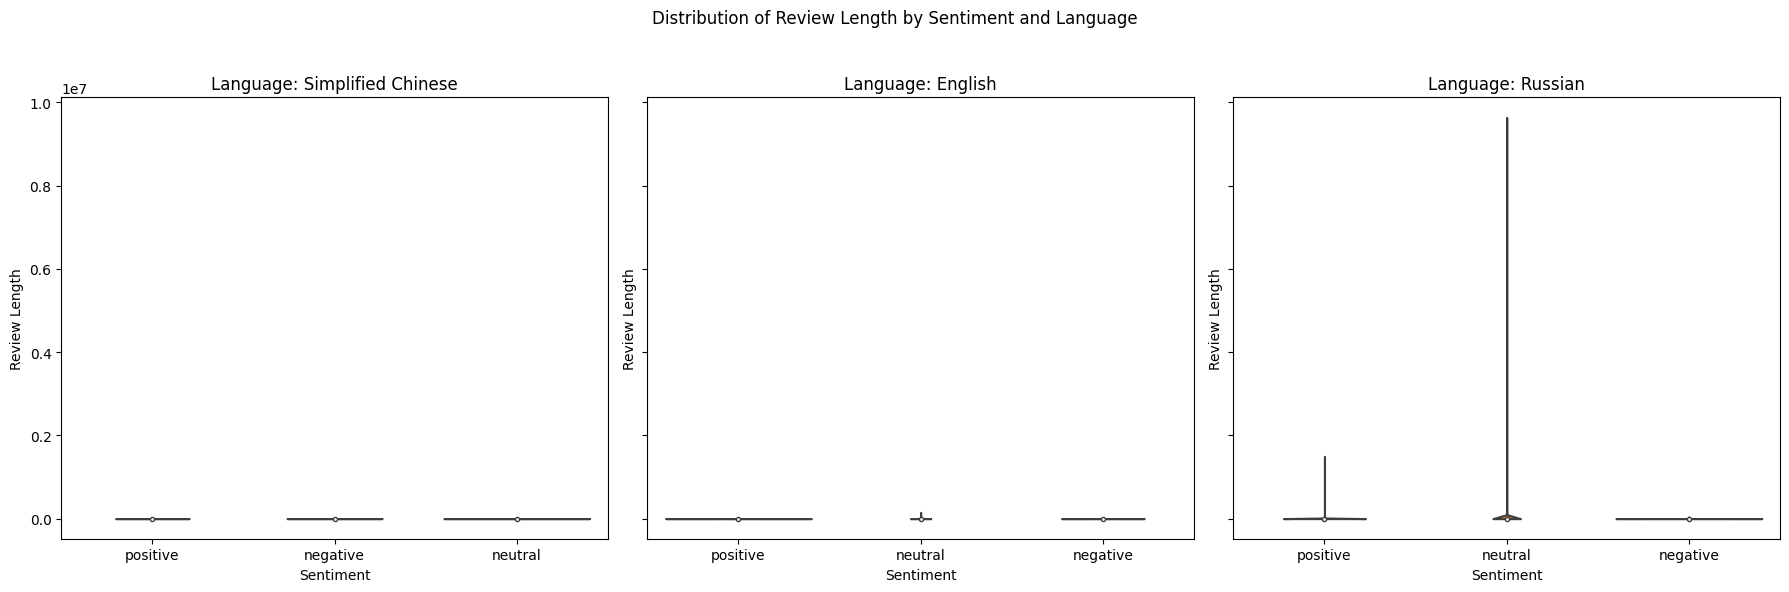

In [20]:
languages = filtered_reviews_l['language'].unique()

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Distribution of Review Length by Sentiment and Language')

for i, language in enumerate(languages):
    sns.violinplot(x='sentiment', y='review_length', data=filtered_reviews_l[filtered_reviews_l['language'] == language], ax=axes[i])
    axes[i].set_title(f'Language: {language}')
    axes[i].set_xlabel('Sentiment')
    axes[i].set_ylabel('Review Length')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Some outliers make the plot meaningless

In [21]:
# summary statistics
summary_stats = filtered_reviews_l.groupby(['language', 'sentiment'])['review_length'].describe()
print("Summary Statistics for Review Length by Language and Sentiment:")
summary_stats

Summary Statistics for Review Length by Language and Sentiment:


count        mean           std  min   25%  \
language           sentiment                                                   
English            negative   1385992.0  316.657120    672.454064  1.0  41.0   
                   neutral    1537228.0   44.214646    247.613596  0.0   6.0   
                   positive   6709072.0  234.375378    522.200537  1.0  23.0   
Russian            negative    339356.0  162.553109    435.271386  1.0  17.0   
                   neutral     897567.0  219.157537  10199.800576  0.0   9.0   
                   positive    962882.0  171.180141   1700.928913  1.0  21.0   
Simplified Chinese negative   1079713.0   50.644655    130.005162  1.0  10.0   
                   neutral     302273.0   47.691028    209.527166  1.0   6.0   
                   positive   2380147.0   54.349248    190.091068  0.0   5.0   

                                50%    75%        max  
language           sentiment                           
English            negative   104.0  292.0     8218.0  
                   neutral     15.0   36.0   150000.0  
                   positive    74.0  219.0     8000.0  
Russian            negative    43.0  128.0    40049.0  
                   neutral     31.0  108.0  9639004.0  
                   positive    53.0  144.0  1496880.0  
Simplified Chinese negative    22.0   48.0     8000.0  
                   neutral     14.0   31.0     8000.0  
                   positive    14.0   37.0     8000.0

Removing those outliers may lead to more meaningfull results

In [22]:
top_100_outliers = filtered_reviews_l.sort_values(by='review_length', ascending=False).head(100)
print("Top 100 Outliers by Review Length:")
print(top_100_outliers[['review_id', 'language', 'sentiment', 'review_length']])


Top 100 Outliers by Review Length:
         review_id language sentiment  review_length
14896571  18042721  Russian   neutral        9639004
5476892   33634014  Russian  positive        1496880
1467949   29208693  Russian  positive         447528
13170641  26673926  Russian  positive         300000
932774    31314218  Russian  positive         262167
...            ...      ...       ...            ...
6095975   85051334  English   neutral           8000
13130904  46309816  Russian   neutral           8000
5120239   84879873  English   neutral           8000
6357146   40797249  English   neutral           8000
12157707  28913263  English   neutral           8000

[100 rows x 4 columns]


I think 8k is the max review lenght allowed by Steam, so we put it as our threshold and remove everything after that 

In [23]:
filtered_reviews_l = filtered_reviews_l[filtered_reviews_l['review_length'] <= 8000]

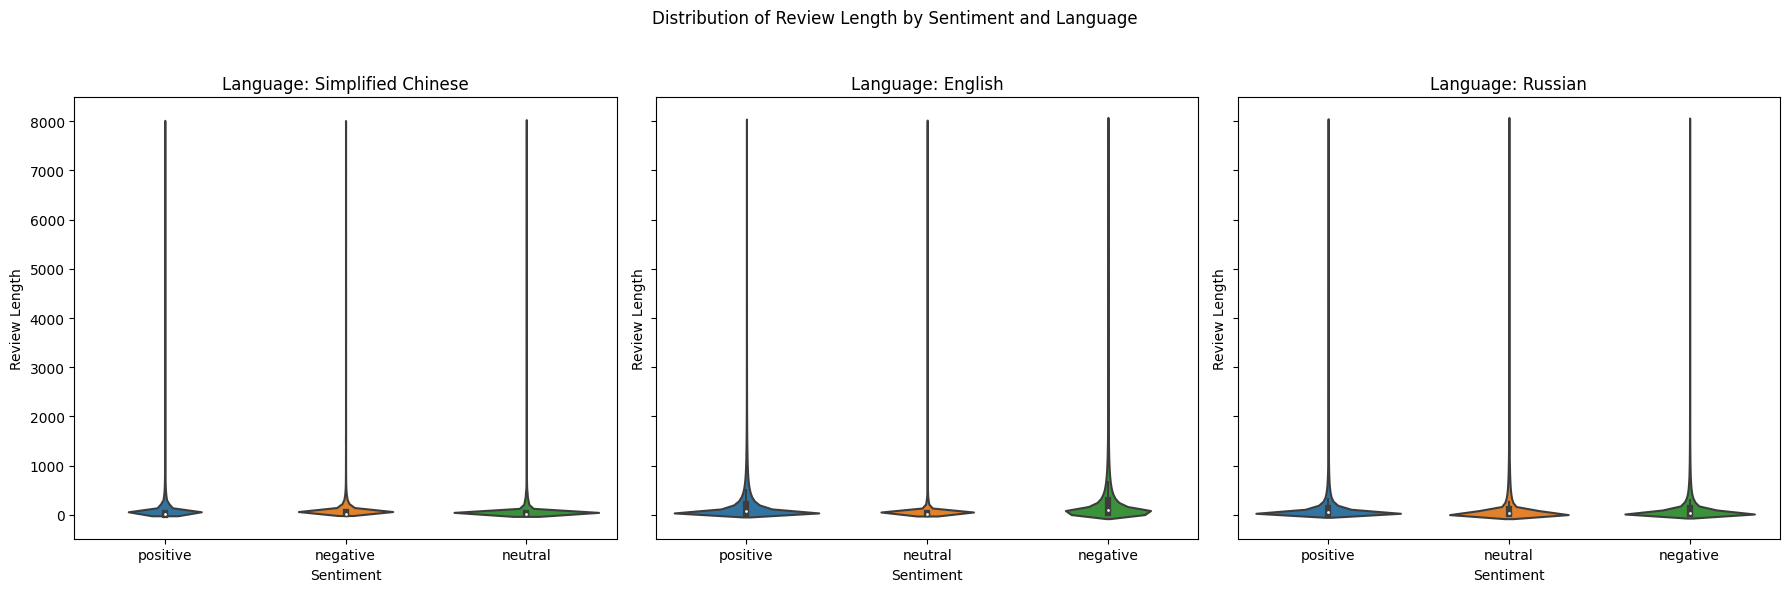

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Distribution of Review Length by Sentiment and Language')

for i, language in enumerate(languages):
    sns.violinplot(x='sentiment', y='review_length', data=filtered_reviews_l[filtered_reviews_l['language'] == language], ax=axes[i])
    axes[i].set_title(f'Language: {language}')
    axes[i].set_xlabel('Sentiment')
    axes[i].set_ylabel('Review Length')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [25]:
summary_stats = filtered_reviews_l.groupby(['language', 'sentiment'])['review_length'].describe()
print("Summary Statistics for Review Length by Language and Sentiment:")
summary_stats

Summary Statistics for Review Length by Language and Sentiment:


count        mean         std  min   25%  \
language           sentiment                                                 
English            negative   1385991.0  316.651419  672.420813  1.0  41.0   
                   neutral    1537227.0   44.117097  216.065722  0.0   6.0   
                   positive   6709072.0  234.375378  522.200537  1.0  23.0   
Russian            negative    339355.0  162.435573  429.853015  1.0  17.0   
                   neutral     897564.0  207.835075  611.490754  0.0   9.0   
                   positive    962877.0  168.422033  413.340154  1.0  21.0   
Simplified Chinese negative   1079713.0   50.644655  130.005162  1.0  10.0   
                   neutral     302273.0   47.691028  209.527166  1.0   6.0   
                   positive   2380147.0   54.349248  190.091068  0.0   5.0   

                                50%    75%     max  
language           sentiment                        
English            negative   104.0  292.0  8000.0  
                   neutral     15.0   36.0  8000.0  
                   positive    74.0  219.0  8000.0  
Russian            negative    43.0  128.0  8000.0  
                   neutral     31.0  108.0  8000.0  
                   positive    53.0  144.0  8000.0  
Simplified Chinese negative    22.0   48.0  8000.0  
                   neutral     14.0   31.0  8000.0  
                   positive    14.0   37.0  8000.0

Results now makes more sense but to have info of the core of the distribution we use statistic rules to remove outliers, so we consider only what is inside the 95% of our distribution, removing tails on both end by 2.5%

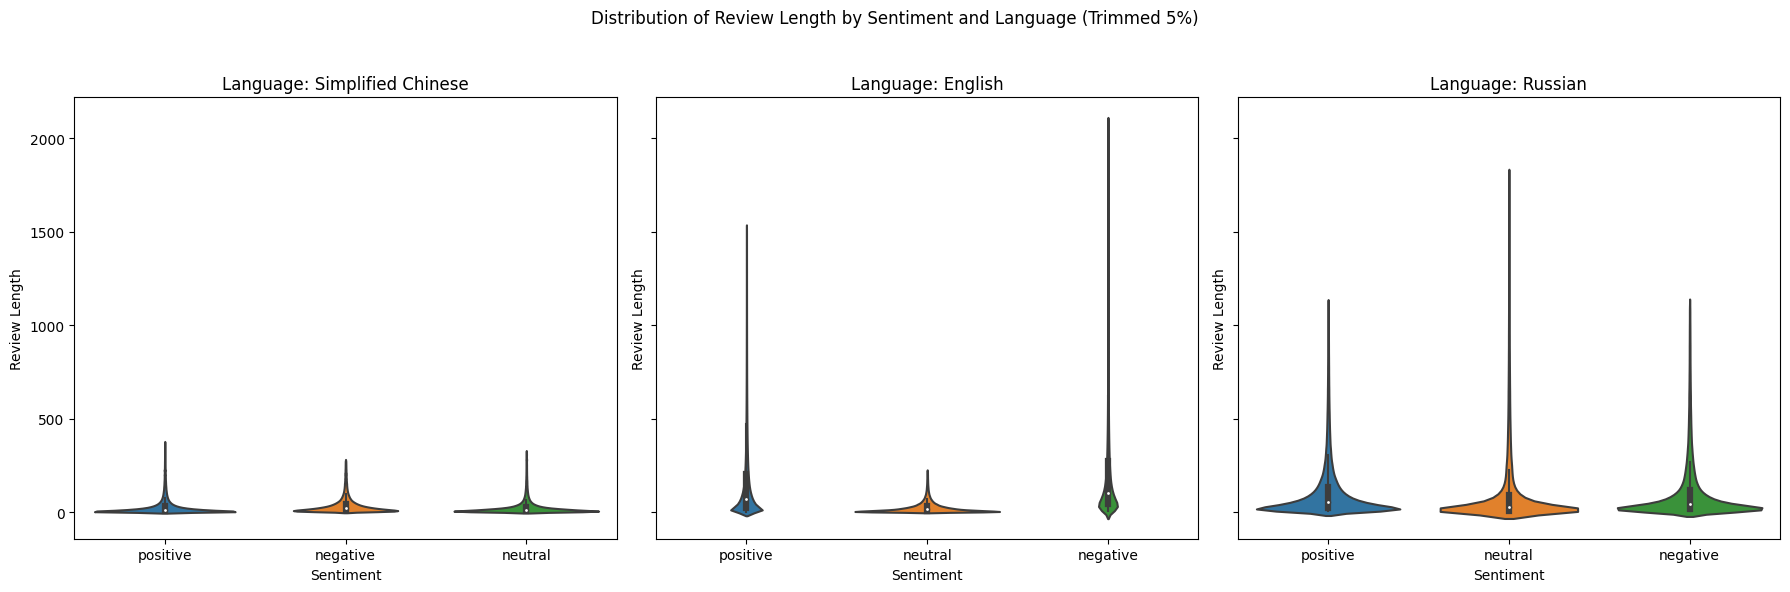

In [26]:
filtered_data = pd.DataFrame()
# Let's try to remove 2.5% on each side
for language in languages:
    language_data = filtered_reviews_l[filtered_reviews_l['language'] == language]
    for sentiment in language_data['sentiment'].unique():
        sentiment_data = language_data[language_data['sentiment'] == sentiment]
        lower_bound = sentiment_data['review_length'].quantile(0.025)
        upper_bound = sentiment_data['review_length'].quantile(0.975)
        filtered_sentiment_data = sentiment_data[(sentiment_data['review_length'] >= lower_bound) & 
                                                 (sentiment_data['review_length'] <= upper_bound)]
        filtered_data = pd.concat([filtered_data, filtered_sentiment_data])

# Plot the filtered data
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Distribution of Review Length by Sentiment and Language (Trimmed 5%)')

for i, language in enumerate(languages):
    sns.violinplot(x='sentiment', y='review_length', data=filtered_data[filtered_data['language'] == language], ax=axes[i])
    axes[i].set_title(f'Language: {language}')
    axes[i].set_xlabel('Sentiment')
    axes[i].set_ylabel('Review Length')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

We can finally give some conclusion:


Users writing in English tend to produce longer reviews overall, likely because review length is measured in character count, and English words generally require more characters than Chinese or Russian. 


In [27]:
# Mapping 
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
filtered_reviews_l['sentiment_score'] = filtered_reviews_l['sentiment'].map(sentiment_mapping)

# Correlation between review length and sentiment score by language
correlation_by_language = filtered_reviews_l.groupby('language')[['review_length', 'sentiment_score']].corr().unstack().iloc[:,1]
print("Correlation between review length and sentiment score by language:")
print(correlation_by_language)

Correlation between review length and sentiment score by language:
language
English              -0.004222
Russian              -0.009315
Simplified Chinese    0.010218
Name: (review_length, sentiment_score), dtype: float64


These correlation values are all very close to zero, indicating that review length is not strongly related to sentiment score in any of the three languages.

/tmp/ipykernel_17/1085173327.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_sentiment_counts = filtered_reviews_l.groupby(['language', 'length_category', 'sentiment']).size().unstack(fill_value=0)


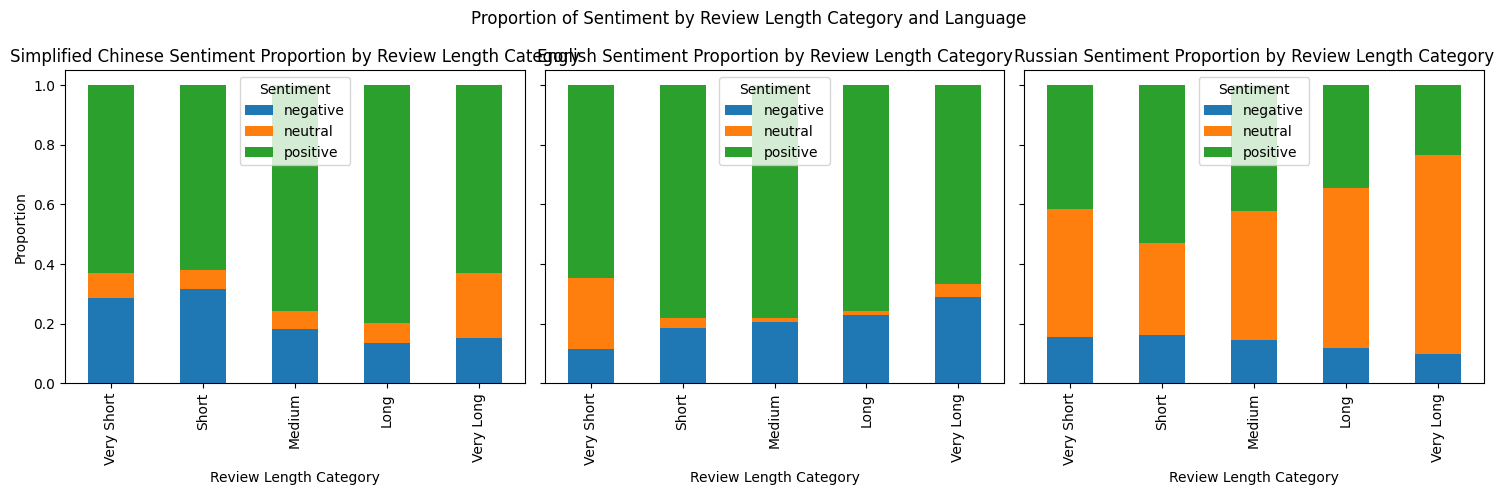

In [28]:
# For simplification we map the review lenght into category
bins = [0, 100, 500, 1000, 5000, float("inf")]  # boundaries 
labels = ['Very Short', 'Short', 'Medium', 'Long', 'Very Long']  # Labels 
filtered_reviews_l['length_category'] = pd.cut(filtered_reviews_l['review_length'], bins=bins, labels=labels)

filtered_reviews_l['sentiment_score'] = filtered_reviews_l['sentiment'].map(sentiment_mapping)

length_sentiment_counts = filtered_reviews_l.groupby(['language', 'length_category', 'sentiment']).size().unstack(fill_value=0)
length_sentiment_proportions = length_sentiment_counts.div(length_sentiment_counts.sum(axis=1), axis=0)

# Plot 
fig, axes = plt.subplots(1, len(languages), figsize=(15, 5), sharey=True)

for i, language in enumerate(languages):
    length_sentiment_proportions.loc[language].plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title(f'{language} Sentiment Proportion by Review Length Category')
    axes[i].set_xlabel('Review Length Category')
    axes[i].set_ylabel('Proportion')
    axes[i].legend(title='Sentiment')

plt.suptitle('Proportion of Sentiment by Review Length Category and Language')
plt.tight_layout()
plt.show()


Interestingly, English users tend to use more words when describing positive experiences, suggesting they may provide more detailed feedback when satisfied. In contrast, Chinese and Russian users typically keep positive reviews brief, while negative reviews are sometimes longer. This pattern could indicate that Chinese and Russian users prefer to elaborate more when expressing dissatisfaction or highlighting issues.

This was understandable also by the violin plot but this graph make it easier to visualize

# Does the sentiment analysis align with whether the application is recommended or not? Explain any insights from this comparison.

In [29]:
def load_recommended_csv():
    with mp.Pool(1) as pool:
        recommended_data = pool.starmap(load_csv, [
            (file_path, ['review_id', 'recommended'], {'review_id': str, 'recommended': bool}, 'recommended dataset')
        ])
    return recommended_data[0]

recommended_df = load_recommended_csv()
print("Merging recommended dataset with filtered reviews")
final_reviews_recommended = pd.merge(filtered_reviews_l, recommended_df, on='review_id', how='inner')


Loading recommended dataset dataset from /kaggle/input/steam-reviews-2021/steam_reviews.csv
Finished loading recommended dataset dataset with 21747371
Merging recommended dataset with filtered reviews


In [30]:
final_reviews_recommended.head()

review_id sentiment            language  review_length  sentiment_score  \
0  85185598  positive  Simplified Chinese             23              1.0   
1  85185250  positive  Simplified Chinese             18              1.0   
2  85185111  positive  Simplified Chinese              5              1.0   
3  85184605  positive             English             59              1.0   
4  85184287  positive  Simplified Chinese              2              1.0   

  length_category  recommended  
0      Very Short         True  
1      Very Short         True  
2      Very Short         True  
3      Very Short         True  
4      Very Short         True

In [31]:
sentiment_recommendation_counts = final_reviews_recommended.pivot_table(
    index='sentiment',
    columns='recommended',
    aggfunc='size',
    fill_value=0
)

print(sentiment_recommendation_counts)

recommended    False    True 
sentiment                    
negative     1314773  1510378
neutral       334118  2425028
positive      510724  9695900


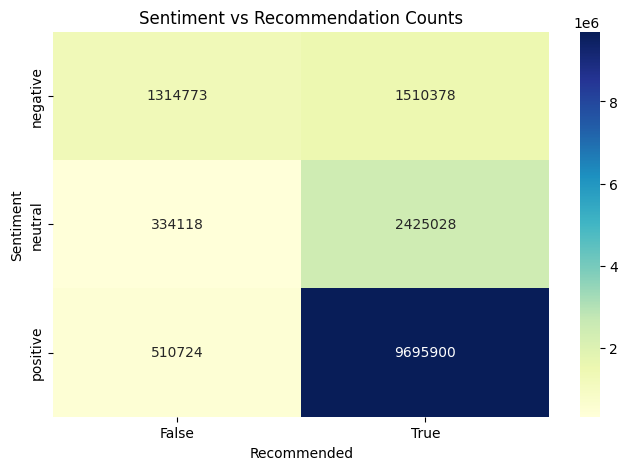

In [32]:
plt.figure(figsize=(8, 5))
sns.heatmap(sentiment_recommendation_counts, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Sentiment vs Recommendation Counts")
plt.xlabel("Recommended")
plt.ylabel("Sentiment")
plt.show()

In [33]:
sentiment_recommendation_percent = sentiment_recommendation_counts.div(sentiment_recommendation_counts.sum(axis=1), axis=0) * 100

print(sentiment_recommendation_percent)

recommended      False      True 
sentiment                        
negative     46.538150  53.461850
neutral      12.109472  87.890528
positive      5.003848  94.996152


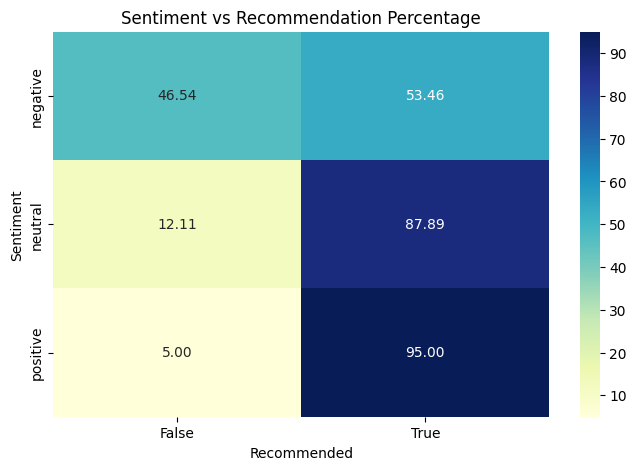

In [34]:
plt.figure(figsize=(8, 5))
sns.heatmap(sentiment_recommendation_percent, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Sentiment vs Recommendation Percentage")
plt.xlabel("Recommended")
plt.ylabel("Sentiment")
plt.show()


this heatmap provides a clear view of how sentiment correlates with recommendation, highlighting that positive sentiment is a strong indicator of recommendation, while negative sentiment does not necessarily equate to non-recommendation.

/tmp/ipykernel_17/2167001254.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sentiment_counts = final_reviews_recommended.groupby(['recommended', 'length_category', 'sentiment']).size().unstack(fill_value=0)


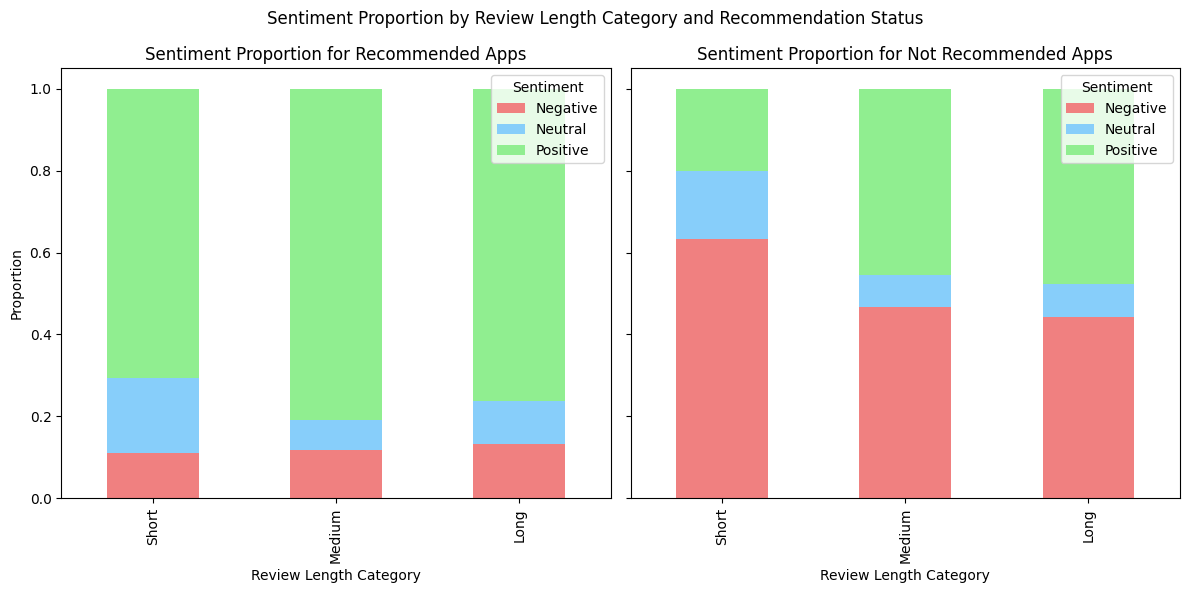

In [35]:
bins = [0, 500, 1000, float("inf")]
labels = ['Short', 'Medium', 'Long']
final_reviews_recommended['length_category'] = pd.cut(final_reviews_recommended['review_length'], bins=bins, labels=labels)

sentiment_counts = final_reviews_recommended.groupby(['recommended', 'length_category', 'sentiment']).size().unstack(fill_value=0)
sentiment_proportions = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

recommended_proportions = sentiment_proportions.loc[True]
not_recommended_proportions = sentiment_proportions.loc[False]

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
# Plot for 'True' 
recommended_proportions.plot(kind='bar', stacked=True, ax=axes[0], color=['lightcoral', 'lightskyblue', 'lightgreen'])
axes[0].set_title("Sentiment Proportion for Recommended Apps")
axes[0].set_xlabel("Review Length Category")
axes[0].set_ylabel("Proportion")
axes[0].legend(title="Sentiment", labels=['Negative', 'Neutral', 'Positive'])

# Plot for 'False' 
not_recommended_proportions.plot(kind='bar', stacked=True, ax=axes[1], color=['lightcoral', 'lightskyblue', 'lightgreen'])
axes[1].set_title("Sentiment Proportion for Not Recommended Apps")
axes[1].set_xlabel("Review Length Category")
axes[1].legend(title="Sentiment", labels=['Negative', 'Neutral', 'Positive'])

plt.suptitle("Sentiment Proportion by Review Length Category and Recommendation Status")
plt.tight_layout()
plt.show()

Overall, these charts show a clear contrast in sentiment distribution between recommended and not recommended apps, with recommended apps overwhelmingly positive and not recommended apps showing a stronger negative bias, especially in shorter reviews

# Is there a correlation between the sentiment of a review and the number of helpfulness votes it receives? Provide an analysis of the results and discuss potential trends.


In [36]:
def load_helpful_votes_csv():
    with mp.Pool(1) as pool:
        helpful_votes_data = pool.starmap(load_csv, [
            (file_path, ['review_id', 'votes_helpful'], {'review_id': str, 'votes_helpful': int}, 'votes_helpful dataset')
        ])
    return helpful_votes_data[0]

votes_helpful_df = load_helpful_votes_csv()
print("Merging votes_helpful dataset with filtered reviews")
final_reviews_helpfulness = pd.merge(filtered_reviews, votes_helpful_df, on='review_id', how='inner')

Loading votes_helpful dataset dataset from /kaggle/input/steam-reviews-2021/steam_reviews.csv
Finished loading votes_helpful dataset dataset with 21747371
Merging votes_helpful dataset with filtered reviews


In [37]:
proportion_helpful_votes = final_reviews_helpfulness.groupby('sentiment')['votes_helpful'].apply(lambda x: (x > 0).mean())
print("Proportion of Reviews with at least one Helpful Votes by Sentiment:")
print(proportion_helpful_votes )

Proportion of Reviews with at least one Helpful Votes by Sentiment:
sentiment
negative    0.374893
neutral     0.286509
positive    0.269072
Name: votes_helpful, dtype: float64


In [38]:
pd.options.display.float_format = '{:,.2f}'.format #for clearness

non_zero_reviews = final_reviews_helpfulness[final_reviews_helpfulness['votes_helpful'] > 0]

# Calculate the mean helpful votes by sentiment, considering only reviews with at least one helpful vote
mean_helpful_votes_non_zero = non_zero_reviews.groupby('sentiment')['votes_helpful'].mean()

# Display the result
print("Mean Helpful Votes Among Reviews with at Least One Vote by Sentiment:")
print(mean_helpful_votes_non_zero)


Mean Helpful Votes Among Reviews with at Least One Vote by Sentiment:
sentiment
negative           9.06
neutral            7.40
positive   1,601,438.83
Name: votes_helpful, dtype: float64


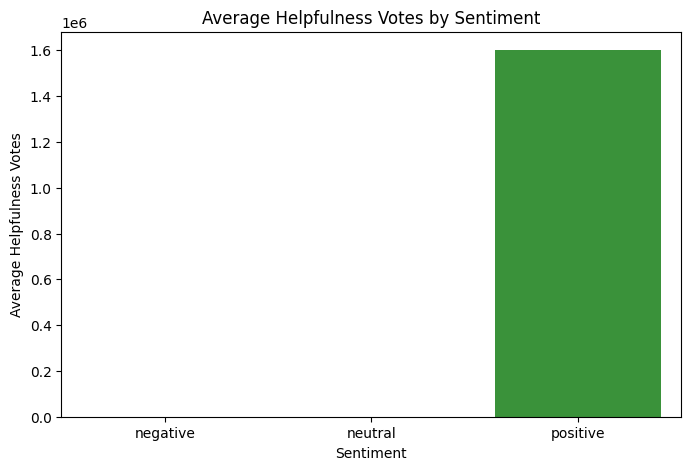

In [39]:
# Bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=mean_helpful_votes_non_zero.index, y=mean_helpful_votes_non_zero.values)
plt.title("Average Helpfulness Votes by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Helpfulness Votes")
plt.show()


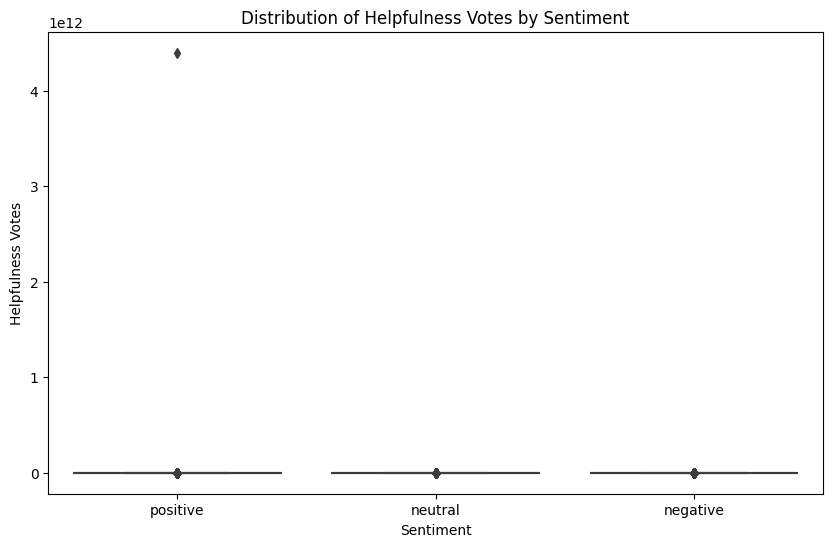

In [40]:
# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=final_reviews_helpfulness, x='sentiment', y='votes_helpful')
plt.title("Distribution of Helpfulness Votes by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Helpfulness Votes")
plt.show()
# It shows that positive contain an outlier that shift the axis and makes the plot useless

It shows that positive contain an outlier that shift the axis and makes the plot useless

In [41]:
# Map sentiment
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
final_reviews_helpfulness['sentiment_numeric'] = final_reviews_helpfulness['sentiment'].map(sentiment_mapping)

# Correlation
correlation = final_reviews_helpfulness['sentiment_numeric'].corr(final_reviews_helpfulness['votes_helpful'])
print("Correlation between Sentiment and Helpfulness Votes:", correlation)

Correlation between Sentiment and Helpfulness Votes: 0.00017204674132805626


sentiment has no meaningful impact on the number of helpfulness votes 

In [42]:
def identify_top_percent_outliers(df, column, percent=0.00001):
    outliers_df = pd.DataFrame()  
    outliers_count = {}       

    for sentiment in df['sentiment'].unique():
        subset = df[df['sentiment'] == sentiment]
        threshold = subset[column].quantile(1 - percent)

        # Identify outliers for this sentiment
        outliers_subset = subset[subset[column] > threshold]

        # Concatenate outliers to the outliers DataFrame
        outliers_df = pd.concat([outliers_df, outliers_subset])

        # Store the count of outliers identified for this sentiment
        outliers_count[sentiment] = len(outliers_subset)

    return outliers_df, outliers_count

outliers_identified, outliers_count = identify_top_percent_outliers(non_zero_reviews, 'votes_helpful')

print("\nNumber of Outliers Identified by Sentiment:")
print(outliers_count)

print("\nOutliers Identified (Votes Helpful) by Sentiment (Sorted from Greatest to Smallest):")
print(outliers_identified[['sentiment', 'votes_helpful']].sort_values(by='votes_helpful', ascending=False))


Number of Outliers Identified by Sentiment:
{'positive': 28, 'negative': 11, 'neutral': 8, nan: 0}

Outliers Identified (Votes Helpful) by Sentiment (Sorted from Greatest to Smallest):
         sentiment  votes_helpful
7698870   positive  4398046511106
4204335   positive          29608
5636123   positive          28211
14623929  negative          26149
10854995  positive          19927
13997772  positive          19707
10555982  negative          18030
12197247  positive          16993
5158693   positive          16960
13997771  negative          16090
13997593  positive          15776
10988208  negative          15598
14623972   neutral          15526
5632372    neutral          15385
9676152   negative          15160
5638898    neutral          15127
5636838   positive          14833
10760228  negative          14587
5098508    neutral          14408
14624422  negative          14349
6117451   positive          13625
9673029   negative          13595
5150527   negative          1349

In [43]:
def remove_single_greatest_outlier(df, column):
    # Identify the overall maximum value in votes_helpful
    max_value = df[column].max()
    
    # Find the row with the maximum votes_helpful value
    greatest_outlier = df[df[column] == max_value]
    
    # Remove the row with the greatest outlier from the DataFrame
    filtered_df = df[df[column] != max_value]
    
    return filtered_df, greatest_outlier

filtered_reviews, greatest_outlier = remove_single_greatest_outlier(non_zero_reviews, 'votes_helpful')

mean_helpful_votes_no_greatest_outlier = filtered_reviews.groupby('sentiment')['votes_helpful'].mean()
print("Mean Helpful Votes Among Reviews with at Least One Vote by Sentiment (Single Greatest Outlier Removed):")
print(mean_helpful_votes_no_greatest_outlier)

print("\nSingle Greatest Outlier Removed (Votes Helpful):")
outlier_reviews = greatest_outlier['review_id']
outlier_reviews

Mean Helpful Votes Among Reviews with at Least One Vote by Sentiment (Single Greatest Outlier Removed):
sentiment
negative   9.06
neutral    7.40
positive   6.77
Name: votes_helpful, dtype: float64

Single Greatest Outlier Removed (Votes Helpful):


7698870    63684360
Name: review_id, dtype: object

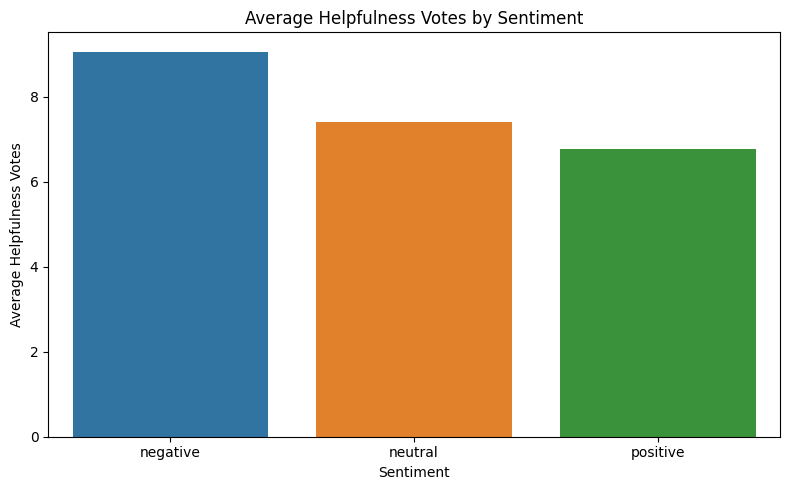

In [44]:
# Bar plot
average_helpfulness = filtered_reviews.groupby('sentiment')['votes_helpful'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(x='sentiment', y='votes_helpful', data=average_helpfulness)
plt.title("Average Helpfulness Votes by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Helpfulness Votes")
plt.tight_layout()
plt.show()



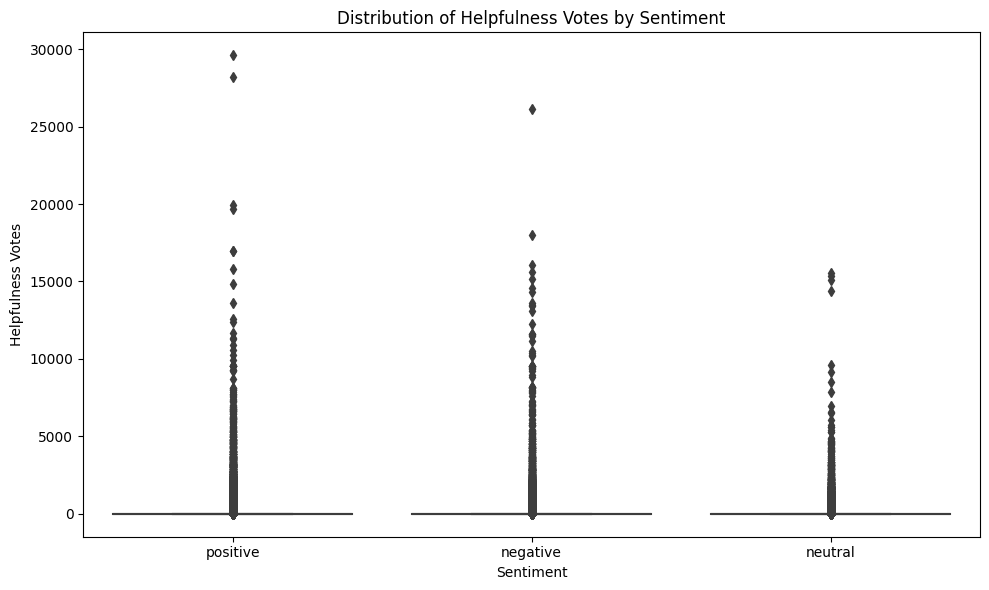

In [45]:
# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_reviews, x='sentiment', y='votes_helpful')
plt.title("Distribution of Helpfulness Votes by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Helpfulness Votes")
plt.tight_layout()
plt.show()

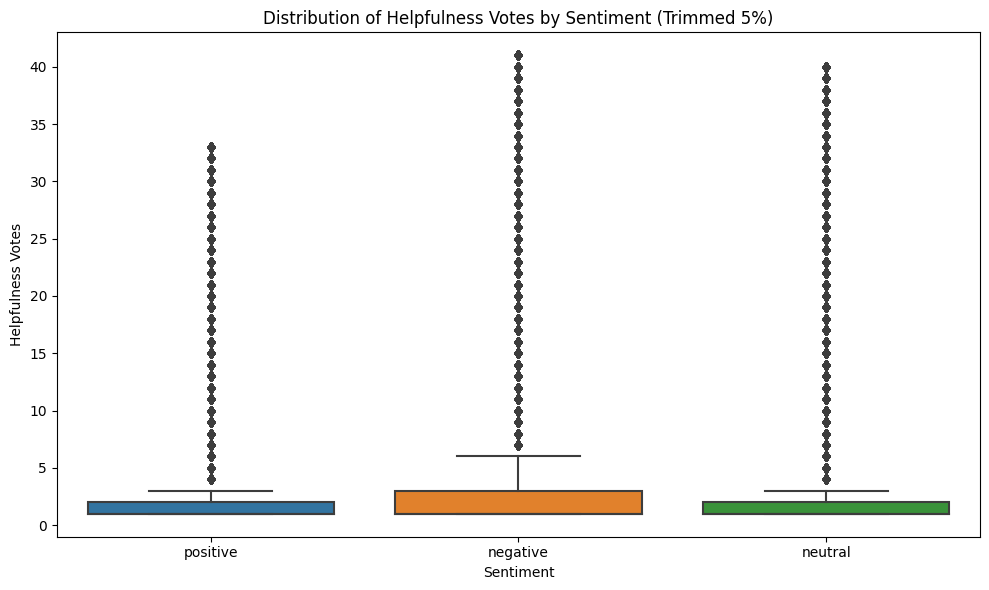

In [46]:
filtered_data = pd.DataFrame()
# Remove the tails (2.5%)
for sentiment in filtered_reviews['sentiment'].unique():
    sentiment_data = filtered_reviews[filtered_reviews['sentiment'] == sentiment]
    lower_bound = sentiment_data['votes_helpful'].quantile(0.025)
    upper_bound = sentiment_data['votes_helpful'].quantile(0.975)
    filtered_sentiment_data = sentiment_data[(sentiment_data['votes_helpful'] >= lower_bound) &
                                             (sentiment_data['votes_helpful'] <= upper_bound)]
    filtered_data = pd.concat([filtered_data, filtered_sentiment_data])

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_data, x='sentiment', y='votes_helpful')
plt.title("Distribution of Helpfulness Votes by Sentiment (Trimmed 5%)")
plt.xlabel("Sentiment")
plt.ylabel("Helpfulness Votes")
plt.tight_layout()
plt.show()


Negative reviews appear to have a slightly wider range and a higher median in helpfulness votes than positive or neutral reviews. This could imply that users are more likely to find critical (negative) reviews helpful.


<a href="https://colab.research.google.com/github/ZainebAlojayyan/Zain92_ADM/blob/main/Untitled5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Algorithmic Question (AQ)**
### 1.	Python program:




The aim of the provided code is to represent whether an integer n can be a sum of an integer k, and to return a valid sequence of integers.  If such a sequence is possible to return with a certain result:



In [1]:
def check_integers(n, k):

    if (n % 2 == k % 2) and (n >= k):
        last_number = n - (k - 1)
        return "YES", [1] * (k - 1) + [last_number]

# Check_even integers
    if n >= 2 * k and n % 2 == 0:
        even_numbers = [2] * (k - 1)
        even_numbers.append(n - 2 * (k - 1))
        return "YES", even_numbers
    return "NO"

# test_cases
t = int(input("Enter number of test cases: "))
results = []
for _ in range(t):
    n, k = map(int, input("Enter n and k: ").split())
    result = check_integers(n, k)
    results.append(result)

# Output results
for result in results:
    if result == "NO":
        print(result)
    else:
        print(result[0])
        print(" ".join(map(str, result[1])))



Enter number of test cases: 7
Enter n and k: 10 3
Enter n and k: 100 4
Enter n and k: 8 7
Enter n and k: 97 2
Enter n and k: 8 8
Enter n and k: 3 10
Enter n and k: 5 3
YES
2 2 6
YES
1 1 1 97
NO
NO
YES
1 1 1 1 1 1 1 1
NO
YES
1 1 3



### **2.	Time complexity using Big O notation:** **bold text**


Here the steps that clarify the time processes of the implemented code:

Step1: O(1)+O(1)+O(1)+O(k)

Step2: O(1)+O(k)+O(1)+O(1)

Step3: O(1)+O(1)

Step4: O(t.1)+O(1)+O(k)+O(1)

Step5: O(1)+O(1)+O(1)+O(k)

Time complexity: O(13) O(t) + O(4k) = O(t)+O(k) = O(t.k)

Since there are two variables in the code:
the number of test cases t and the size of the integers k the time complexity for all operations of test cases is O(t⋅k) which expect linear increasing between t and k.






In [15]:
from google.colab import files
from IPython.display import Image
uploaded = files.upload()

Saving Big O.png to Big O.png


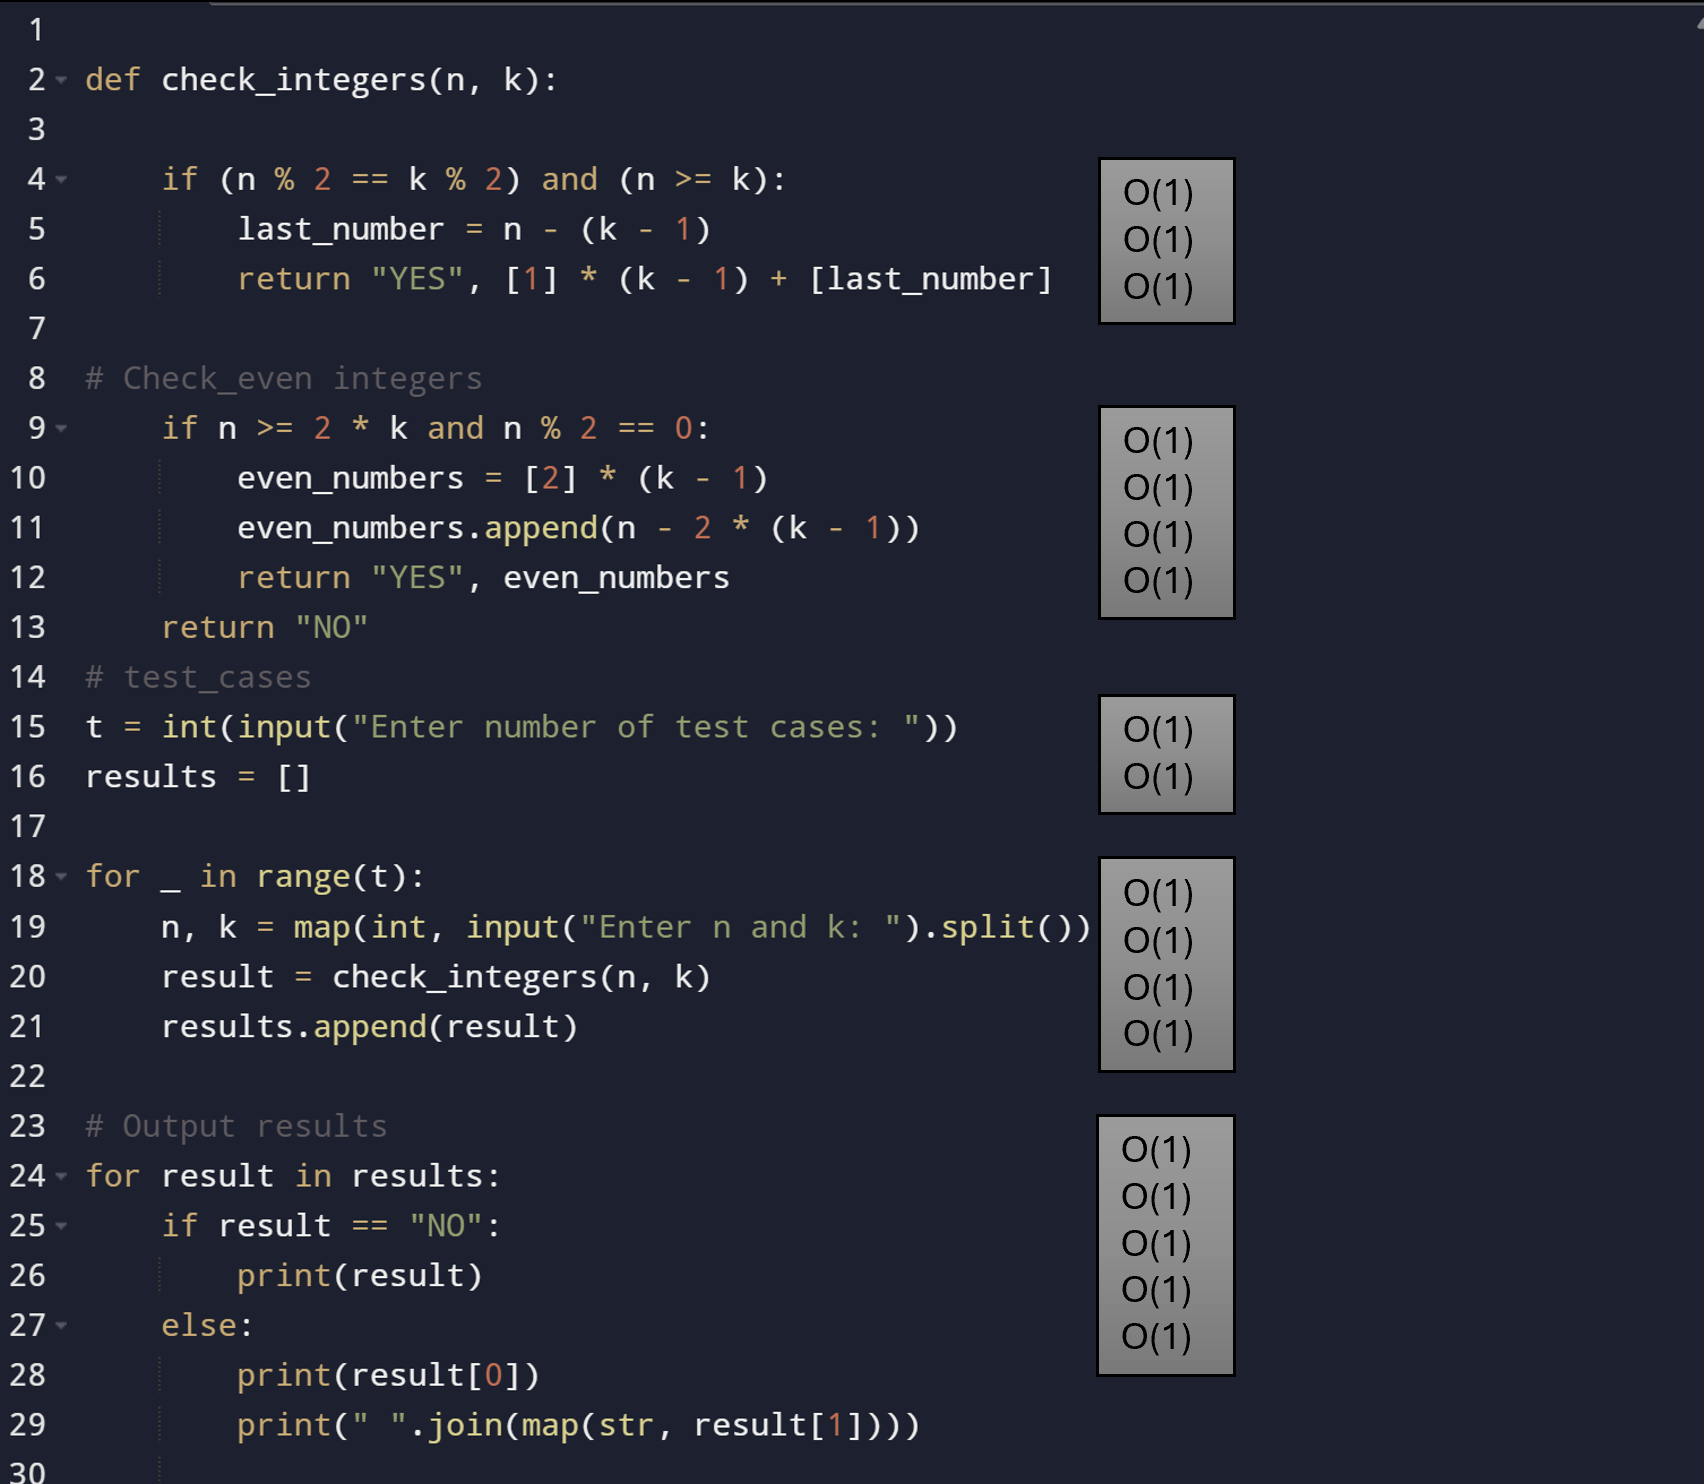

In [17]:
Image('Big O.png', width=600, height=600)

### **3.	AI Evaluation of Time complexity:**

o	ChatGPT: Total Time Complexity is O(t⋅k) where t is the number of test cases and k is the size of the sequence being generated. This analysis shows that the function is efficient, particularly as t and k grow, as each test case is handled independently in linear time relative to k.


o	Perplexity: Combining all parts, the overall time complexity of the entire program can be summarized as: O(t*k) This indicates that the performance of the code depends linearly on both the number of test cases t and the value of k for each test case.


o	Going through two sources of AI that demonstrate the same result of time complexity of our code as O(t.k) confirms to accurate result of time complexity that preformed the factors of the given integers and constant time of the code operations.
